In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import types
import datetime
import random
import math
from typing import Tuple

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, distributions
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.autograd import Function
from torch.distributions import RelaxedOneHotCategorical, Normal, Categorical
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.optimizer import Optimizer

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid

cam2aml01.aml.speechmatics.io
CUDA=True 1


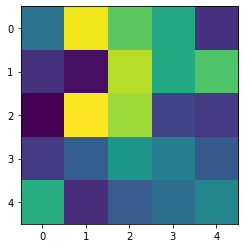

In [2]:
def set_seeds(seed=42, fully_deterministic=False):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if fully_deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seeds()

!hostname
print(f"CUDA={torch.cuda.is_available()}", os.environ.get("CUDA_VISIBLE_DEVICES"))
z = np.random.rand(5, 5)
plt.imshow(z)

### MNIST Dataloader

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
    ]
)
batch_size = 512
ds_train = MNIST('/tmp/mnist', download=True, transform=transform)
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)

ds_test = MNIST('/tmp/mnist_test_', download=True, train=False, transform=transform)
dl_test = DataLoader(ds_test, batch_size=batch_size, num_workers=4)
test_x, _ = next(iter(dl_test))
test_x = test_x.to(device)

### Utils

In [4]:
def show_image(im_data):
    dpi = matplotlib.rcParams['figure.dpi']
    height, width = im_data.shape
    figsize = width / float(dpi), height / float(dpi)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')
    ax.imshow(im_data, vmin=0, vmax=1, cmap='gray')
    plt.show();
    ax.set(xlim=[0, width], ylim=[height, 0], aspect=1)


class RAdam(Optimizer):
    def __init__(
        self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True
    ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if "betas" in param and (
                    param["betas"][0] != betas[0] or param["betas"][1] != betas[1]
                ):
                    param["buffer"] = [[None, None, None] for _ in range(10)]
        defaults = dict(
            lr=lr,
            betas=betas,
            eps=eps,
            weight_decay=weight_decay,
            buffer=[[None, None, None] for _ in range(10)],
        )
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError("RAdam does not support sparse gradients")

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p_data_fp32)
                    state["exp_avg_sq"] = torch.zeros_like(p_data_fp32)
                else:
                    state["exp_avg"] = state["exp_avg"].type_as(p_data_fp32)
                    state["exp_avg_sq"] = state["exp_avg_sq"].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                beta1, beta2 = group["betas"]

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state["step"] += 1
                buffered = group["buffer"][int(state["step"] % 10)]
                if state["step"] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state["step"]
                    beta2_t = beta2 ** state["step"]
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state["step"] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t)
                            * (N_sma - 4)
                            / (N_sma_max - 4)
                            * (N_sma - 2)
                            / N_sma
                            * N_sma_max
                            / (N_sma_max - 2)
                        ) / (1 - beta1 ** state["step"])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state["step"])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group["eps"])
                    p_data_fp32.addcdiv_(-step_size * group["lr"], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group["weight_decay"] != 0:
                        p_data_fp32.add_(-group["weight_decay"] * group["lr"], p_data_fp32)
                    p_data_fp32.add_(-step_size * group["lr"], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


# Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
# https://arxiv.org/abs/1908.08681v1
# implemented for PyTorch / FastAI by lessw2020
# github: https://github.com/lessw2020/mish
def mish(x):
    return x * torch.tanh(F.softplus(x))


class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return mish(x)
    
# https://pytorch.org/docs/stable/_modules/torch/optim/lr_scheduler.html
class FlatCA(_LRScheduler):
    def __init__(self, optimizer, steps, eta_min=0, last_epoch=-1):
        self.steps = steps
        self.eta_min = eta_min
        super(FlatCA, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        lr_list = []
        T_max = self.steps / 3
        for base_lr in self.base_lrs:
            # flat if first 2/3
            if 0 <= self._step_count < 2 * T_max:
                lr_list.append(base_lr)
            # annealed if last 1/3
            else:
                lr_list.append(
                    self.eta_min
                    + (base_lr - self.eta_min)
                    * (1 + math.cos(math.pi * (self._step_count - 2 * T_max) / T_max))
                    / 2
                )
            return lr_list

### Architecture

In [5]:
class Encoder(nn.Module):
    """ Downsamples by a fac of 2 """

    def __init__(self, in_feat_dim, codebook_dim, hidden_dim=128, num_res_blocks=0, final_tanh=True):
        super().__init__()
        blocks = [
            nn.Conv2d(in_feat_dim, hidden_dim // 2, kernel_size=3, stride=2, padding=1),
            Mish(),
            nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=3, padding=1),
            Mish(),
        ]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.append(nn.Conv2d(hidden_dim, codebook_dim, kernel_size=1))
        if final_tanh is True:
            blocks.append(nn.Tanh())
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    """ Upsamples by a fac of 2 """

    def __init__(
        self, in_feat_dim, out_feat_dim, hidden_dim=128, num_res_blocks=0, very_bottom=False, final_tanh=True
    ):
        super().__init__()
        self.very_bottom = very_bottom
        self.out_feat_dim = out_feat_dim # num channels on bottom layer

        blocks = [nn.Conv2d(in_feat_dim, hidden_dim, kernel_size=3, padding=1), Mish()]

        for _ in range(num_res_blocks):
            blocks.append(ResBlock(hidden_dim, hidden_dim // 2))

        blocks.extend([
                Upsample(),
                nn.Conv2d(hidden_dim, hidden_dim // 2, kernel_size=3, padding=1),
                Mish(),
                nn.Conv2d(hidden_dim // 2, out_feat_dim, kernel_size=3, padding=1),
        ])

        if very_bottom is True:
            blocks.append(nn.Sigmoid())
        else:
            if final_tanh is True:
                blocks.append(nn.Tanh())        
        
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Upsample(nn.Module):
    def __init__(self, scale_factor=2):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor)


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channel, channel, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(channel, in_channel, kernel_size=3, padding=1)

    def forward(self, inp):
        x = self.conv_1(inp)
        x = mish(x)
        x = self.conv_2(x)
        x = x + inp
        return mish(x)

In [6]:
class VQCodebook(nn.Module):
    def __init__(self, codebook_slots, codebook_dim, temperature=0.5):
        super().__init__()
        self.codebook_slots = codebook_slots
        self.codebook_dim = codebook_dim
        self.temperature = temperature
        self.codebook = nn.Parameter(torch.randn(codebook_slots, codebook_dim))
        self.log_slots_const = np.log(self.codebook_slots)

    def z_e_to_z_q(self, z_e, soft=True):
        bs, feat_dim, w, h = z_e.shape
        assert feat_dim == self.codebook_dim
        z_e = z_e.permute(0, 2, 3, 1).contiguous()
        z_e_flat = z_e.view(bs * w * h, feat_dim)
        codebook_sqr = torch.sum(self.codebook ** 2, dim=1)
        z_e_flat_sqr = torch.sum(z_e_flat ** 2, dim=1, keepdim=True)

        distances = torch.addmm(
            codebook_sqr + z_e_flat_sqr, z_e_flat, self.codebook.t(), alpha=-2.0, beta=1.0
        )

        if soft is True:
            dist = RelaxedOneHotCategorical(self.temperature, logits=-distances)
            soft_onehot = dist.rsample()
            hard_indices = torch.argmax(soft_onehot, dim=1).view(bs, w, h)
            z_q = (soft_onehot @ self.codebook).view(bs, w, h, feat_dim)
            
            # entropy loss
            KL = dist.probs * (dist.probs.add(1e-9).log() + self.log_slots_const)
            KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()
            
            # probability-weighted commitment loss    
            commit_loss = (dist.probs.view(bs, w, h, self.codebook_slots) * distances.view(bs, w, h, self.codebook_slots)).sum(dim=(1,2,3)).mean()
        else:
            with torch.no_grad():
                dist = Categorical(logits=-distances)
                hard_indices = dist.sample().view(bs, w, h)
                hard_onehot = (
                    F.one_hot(hard_indices, num_classes=self.codebook_slots)
                    .type_as(self.codebook)
                    .view(bs * w * h, self.codebook_slots)
                )
                z_q = (hard_onehot @ self.codebook).view(bs, w, h, feat_dim)
                
                # entropy loss
                KL = dist.probs * (dist.probs.add(1e-9).log() + np.log(self.codebook_slots))
                KL = KL.view(bs, w, h, self.codebook_slots).sum(dim=(1,2,3)).mean()

                commit_loss = 0.0

        z_q = z_q.permute(0, 3, 1, 2)

        return z_q, hard_indices, KL, commit_loss

    def lookup(self, ids: torch.Tensor):
        return F.embedding(ids, self.codebook).permute(0, 3, 1, 2)

    def quantize(self, z_e, soft=False):
        with torch.no_grad():
            z_q, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return z_q, indices

    def quantize_indices(self, z_e, soft=False):
        with torch.no_grad():
            _, indices, _, _ = self.z_e_to_z_q(z_e, soft=soft)
        return indices

    def forward(self, z_e):
        z_q, indices, kl, commit_loss = self.z_e_to_z_q(z_e, soft=True)
        return z_q, indices, kl, commit_loss

In [7]:
 class PruneVQCodebook(VQCodebook):
    """Modified VQCodebook where we can prune down the codes during training."""

    def __init__(self, min_codebook_slots, codebook_dim, temperature=0.6):
        nn.Module.__init__(self)
        self.min_codebook_slots = min_codebook_slots
        self.max_codebook_slots = min_codebook_slots * 2
        self.codebook_dim = codebook_dim
        self.temperature = temperature
        self._codebook = nn.Parameter(torch.randn(self.max_codebook_slots, codebook_dim))
        self.codes_in_use_mask = torch.ones(self.max_codebook_slots).bool()

    @property
    def codebook(self):
        return self._codebook[self.codes_in_use_mask]

    def update_code(self, code_id, new_value):
        new_codebook = self._codebook[self.codes_in_use_mask == True]
        new_codebook[code_id] = new_value
        self._codebook[self.codes_in_use_mask == True]= new_codebook

    @property
    def codebook_slots(self):
        return int(self.codes_in_use_mask.sum().item())

    @property
    def log_slots_const(self):
        return np.log(self.codebook_slots)

    def drop_code(self, code_idx):
        new_mask = torch.ones(self.codebook_slots).bool()
        new_mask[code_idx] = False 
        self.codes_in_use_mask[self.codes_in_use_mask == True] = new_mask

In [8]:
class HQA(nn.Module):
    def __init__(
        self,
        prev_model,
        input_feat_dim,
        codebook_slots=256,
        codebook_dim=64,
        enc_hidden_dim=16,
        dec_hidden_dim=32,
        gs_temp=0.667,
        pruning=False,
    ):
        super().__init__()
        self.prev_model = prev_model
        self.encoder = Encoder(input_feat_dim, codebook_dim, enc_hidden_dim)
        self.pruning = pruning
        if self.pruning is True:
            self.codebook = PruneVQCodebook(codebook_slots, codebook_dim, gs_temp)
        else:
            self.codebook = VQCodebook(codebook_slots, codebook_dim, gs_temp)
        self.decoder = Decoder(
            codebook_dim,
            input_feat_dim,
            dec_hidden_dim,
            very_bottom=prev_model is None,
        )

    def parameters(self, prefix="", recurse=True):
        for module in [self.encoder, self.codebook, self.decoder]:
            for name, param in module.named_parameters(recurse=recurse):
                yield param

    @classmethod
    def init_higher(cls, prev_model, **kwargs):
        model = HQA(prev_model, prev_model.codebook.codebook_dim, **kwargs)
        model.prev_model.eval()
        return model
    
    @classmethod
    def init_bottom(cls, input_feat_dim, **kwargs):
        model = HQA(None, input_feat_dim, **kwargs)
        return model
        
    def forward(self, img):
        z_e_lower = self.encode_lower(img)
        z_e = self.encoder(z_e_lower)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        z_e_lower_tilde = self.decoder(z_q)
        return z_e_lower_tilde, z_e_lower, z_q, z_e, indices, kl, commit_loss
   
    def forward_full_stack(self, img):
        z_e = self.encode(img)
        z_q, indices, kl, commit_loss = self.codebook(z_e)
        img_recon_dist = self.decode(z_q)
        return img_recon_dist, img, z_q, z_e, indices, kl, commit_loss

    def encode_lower(self, x):
        if self.prev_model is None:
            return x
        else:
            with torch.no_grad():
                z_e_lower = self.prev_model.encode(x)
            return z_e_lower

    def encode(self, x):
        with torch.no_grad():
            z_e_lower = self.encode_lower(x)
            z_e = self.encoder(z_e_lower)
        return z_e
        
    def decode_lower(self, z_q_lower):
        with torch.no_grad():
            recon = self.prev_model.decode(z_q_lower)           
        return recon

    def decode(self, z_q):
        with torch.no_grad():
            if self.prev_model is not None:
                z_q_lower_tilde = self.prev_model.quantize(self.decoder(z_q))
                recon = self.decode_lower(z_q_lower_tilde)
            else:
                recon = self.decoder(z_q)
        return recon

    def quantize(self, z_e):
        z_q, _ = self.codebook.quantize(z_e)
        return z_q

    def reconstruct_average(self, x, num_samples=10):
        """Average over stochastic edecodes"""
        b, c, h, w = x.shape
        result = torch.empty((num_samples, b, c, h, w)).to(device)

        for i in range(num_samples):
            result[i] = self.decode(self.quantize(self.encode(x)))
        return result.mean(0)

    def reconstruct(self, x):
        return self.decode(self.quantize(self.encode(x)))
    
    def reconstruct_from_codes(self, codes):
        return self.decode(model.codebook.lookup(codes))
    
    def reconstruct_from_z_e(self, z_e):
        return self.decode(self.quantize(z_e))
    
    def recon_loss(self, orig, recon):
        return F.mse_loss(orig, recon, reduction='none').sum(dim=(1,2,3)).mean()

    def __len__(self):
        i = 1
        layer = self
        while layer.prev_model is not None:
            i += 1
            layer = layer.prev_model
        return i

    def __getitem__(self, idx):
        max_layer = len(self) - 1
        if idx > max_layer:
            raise IndexError("layer does not exist")

        layer = self
        for _ in range(max_layer - idx):
            layer = layer.prev_model
        return layer

### Training

In [9]:
def show_recon(img, *models):
    fig, axes = plt.subplots(nrows=1, ncols=len(models), figsize=(10 * len(models), 5))

    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    for i, model in enumerate(models):
        model.eval()
        img_ = img.unsqueeze(0).unsqueeze(0)
        recon = model.reconstruct(img_).squeeze()
        output = np.hstack([img.cpu(), np.ones([img.shape[0], 1]), recon.cpu(), np.ones([img.shape[0], 1]), np.abs((img-recon).cpu())])
        axes[i].imshow(output, vmin=0, vmax=1, cmap='gray')
        model.train()


def get_bit_usage(indices):
    """ Calculate bits used by latent space vs max possible """
    num_latents = indices.shape[0] * indices.shape[1] * indices.shape[2]
    avg_probs = F.one_hot(indices).float().mean(dim=(0, 1, 2))
    highest_prob = torch.max(avg_probs)
    bits = (-(avg_probs * torch.log2(avg_probs + 1e-10)).sum()) * num_latents
    max_bits = math.log2(256) * num_latents
    return bits, max_bits, highest_prob


def decay_temp_linear(step, total_steps, temp_base, temp_min=0.001):
    factor = 1.0 - (step/total_steps)
    return temp_min + (temp_base - temp_min) * factor


def get_n_params(model, params):
    pp=0
    for p in list(params):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp


def parameters_layerwise(layer):
    for module in [layer.encoder, layer.codebook, layer.decoder]:
        for name, param in module.named_parameters(recurse=True):
            yield param

                
def print_params(model):
    print("Number of paramters")
    total_params = 0
    for i in range(len(model)):
        layer_params = get_n_params(model, parameters_layerwise(model[i]))
        print(f"Layer f{i}: {layer_params}")
        total_params += layer_params
    print(f"Total: {total_params}")

In [10]:
def get_loss_hqa(img, model, epoch, step, commit_threshold=0.6, log=None):
    recon, orig, z_q, z_e, indices, KL, commit_loss = model(img)
    recon_loss = model.recon_loss(orig, recon)
    
    # calculate loss
    dims = np.prod(recon.shape[1:]) # orig_w * orig_h * num_channels
    loss = recon_loss/dims + 0.001*KL/dims + 0.001*(commit_loss)/dims
    
    # logging    
    if step % 20 == 0:
        nll = recon_loss
        elbo = -(nll + KL)  
        distortion_bpd = nll / dims / np.log(2)
        rate_bpd = KL / dims / np.log(2)
        
        bits, max_bits, highest_prob = get_bit_usage(indices)
        bit_usage_frac = bits / max_bits
        
        time = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
        log_line = f"{time}, epoch={epoch}, step={step}, loss={loss:.5f}, distortion={distortion_bpd:.3f}, rate={rate_bpd:.3f}, -elbo={-elbo:.5f}, nll={nll:.5f}, KL={KL:.5f}, commit_loss={commit_loss:.5f}, bit_usage={bit_usage_frac:.5f}, highest_prob={highest_prob:.3f}, temp={model.codebook.temperature:.5f}"
        print(log_line)

        if log is not None:
            with open(log, "a") as logfile:
                logfile.write(log_line + "\n")
                
    return loss, indices


def train(model, optimizer, scheduler, epochs, decay=True, log=None):
    step = 0
    model.train()
    temp_base = model.codebook.temperature
    code_count = torch.zeros(model.codebook.codebook_slots).to(device)
    total_steps = len(dl_train)*epochs
    
    for epoch in range(epochs):
        for x, _ in dl_train:
            x = x.to(device)
            
            # anneal temperature
            if decay is True:
                model.codebook.temperature = decay_temp_linear(step+1, total_steps, temp_base, temp_min=0.001) 
            
            loss, indices = get_loss_hqa(x, model, epoch, step, log=log)
                
            # take training step    
            model.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            if scheduler is not None:
                scheduler.step()     
                
            # code reset every 20 steps
            indices_onehot = F.one_hot(indices, num_classes=model.codebook.codebook_slots).float()
            code_count = code_count + indices_onehot.sum(dim=(0, 1, 2))
            if step % 20 == 0:
                with torch.no_grad():
                    max_count, most_used_code = torch.max(code_count, dim=0)
                    frac_usage = code_count / max_count
                    z_q_most_used = model.codebook.lookup(most_used_code.view(1, 1, 1)).squeeze()

                    min_frac_usage, min_used_code = torch.min(frac_usage, dim=0)
                    if min_frac_usage < 0.03:
                        print(f'reset code {min_used_code}')
                        moved_code = z_q_most_used + torch.randn_like(z_q_most_used) / 100
                        if model.pruning:
                            model.codebook.update_code(min_used_code, moved_code)
                        else:
                            model.codebook.codebook[min_used_code] = moved_code

                    # code prune every 40 steps
                    if model.pruning and model.codebook.codebook_slots > model.codebook.min_codebook_slots and step % 40 == 0:
                        min_count, min_used_code = torch.min(code_count, dim=0)
                        model.codebook.drop_code(min_used_code)
                        print(f"pruned code {min_used_code} - {model.codebook.codebook_slots} remain")
                        code_count = torch.zeros(model.codebook.codebook_slots).to(device)
                    else: 
                        code_count = torch.zeros_like(code_count)

            step += 1
        if epoch % 5 == 0:
            for n in range(0, 5):
                show_recon(test_x[n, 0], model)
                plt.show();

In [11]:
def train_full_stack(root, exp_name, epochs=150, lr=4e-4, pruning=True):
    
    # small stack
    #enc_hidden_sizes = [16, 16, 32, 48, 80]
    #dec_hidden_sizes = [16, 32, 48, 80, 128]
    
    # big stack
    enc_hidden_sizes = [16, 16, 32, 64, 128]
    dec_hidden_sizes = [16, 64, 256, 512, 1024]
    
    os.makedirs(root + "/log", exist_ok=True)
    
    # layer 0
    print("training layer0")
    vqvae0 = HQA.init_bottom(
        input_feat_dim=1,
        enc_hidden_dim=enc_hidden_sizes[0],
        dec_hidden_dim=dec_hidden_sizes[0],
        pruning=pruning,
    ).to(device)

    log_file = f"{root}/log/{exp_name}_l0.log"
    opt = RAdam(vqvae0.parameters(), lr=lr)
    scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
    train(vqvae0, opt, scheduler, epochs, log=log_file)


    # layer 1
    print("training layer1")
    vqvae1 = HQA.init_higher(
        vqvae0,
        enc_hidden_dim=enc_hidden_sizes[1],
        dec_hidden_dim=dec_hidden_sizes[1],
        pruning=pruning,
    ).to(device)

    log_file = f"{root}/log/{exp_name}_l1.log"
    opt = RAdam(vqvae1.parameters(), lr=lr)
    scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
    train(vqvae1, opt, scheduler, epochs, log=log_file)

    # layer 2
    print("training layer2")
    vqvae2 = HQA.init_higher(
        vqvae1,
        enc_hidden_dim=enc_hidden_sizes[2],
        dec_hidden_dim=dec_hidden_sizes[2],
        pruning=pruning,
    ).to(device)

    log_file = f"{root}/log/{exp_name}_l2.log"
    opt = RAdam(vqvae2.parameters(), lr=lr)
    scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
    train(vqvae2, opt, scheduler, epochs, log=log_file)

    # layer 3
    print("training layer3")
    vqvae3 = HQA.init_higher(
        vqvae2,
        enc_hidden_dim=enc_hidden_sizes[3],
        dec_hidden_dim=dec_hidden_sizes[3],
        pruning=pruning,
    ).to(device)

    log_file = f"{root}/log/{exp_name}_l3.log"
    opt = RAdam(vqvae3.parameters(), lr=lr)
    scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
    train(vqvae3, opt, scheduler, epochs, log=log_file)

    # layer 4
    print("training layer4")
    vqvae4 = HQA.init_higher(
        vqvae3,
        enc_hidden_dim=enc_hidden_sizes[4],
        dec_hidden_dim=dec_hidden_sizes[4],
        pruning=pruning,
    ).to(device)

    print_params(vqvae4)

    log_file = f"{root}/log/{exp_name}_l4.log"
    opt = RAdam(vqvae4.parameters(), lr=lr)
    scheduler = FlatCA(opt, steps=epochs*len(dl_train), eta_min=lr/10)
    train(vqvae4, opt, scheduler, epochs, log=log_file)
    torch.save(vqvae4, f"{root}/{exp_name}.pt")
    
    return vqvae4

### Train HQA Stack

training layer0
18/02/2020 19:50:08, epoch=0, step=0, loss=0.21115, distortion=0.290, rate=2.243, -elbo=1797.74292, nll=205.69040, KL=1592.05249, commit_loss=8939.41992, bit_usage=0.00351, highest_prob=0.998, temp=0.66696
reset code 0
pruned code 0 - 511 remain
18/02/2020 19:50:10, epoch=0, step=20, loss=0.20416, distortion=0.280, rate=2.243, -elbo=1790.54285, nll=198.55289, KL=1591.98999, commit_loss=8909.93555, bit_usage=0.00295, highest_prob=0.998, temp=0.66621
reset code 0
18/02/2020 19:50:12, epoch=0, step=40, loss=0.18688, distortion=0.255, rate=1.997, -elbo=1598.74341, nll=181.12604, KL=1417.61743, commit_loss=8825.96582, bit_usage=0.12600, highest_prob=0.519, temp=0.66546
reset code 16
pruned code 16 - 510 remain
18/02/2020 19:50:13, epoch=0, step=60, loss=0.15498, distortion=0.209, rate=1.997, -elbo=1566.21741, nll=148.54398, KL=1417.67346, commit_loss=8736.96680, bit_usage=0.12555, highest_prob=0.520, temp=0.66470
reset code 16
18/02/2020 19:50:15, epoch=0, step=80, loss=0.12

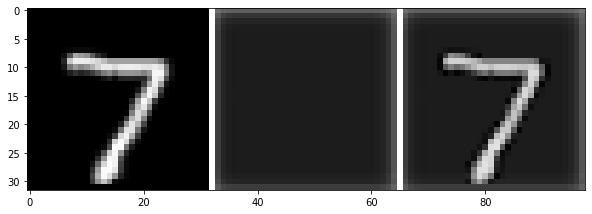

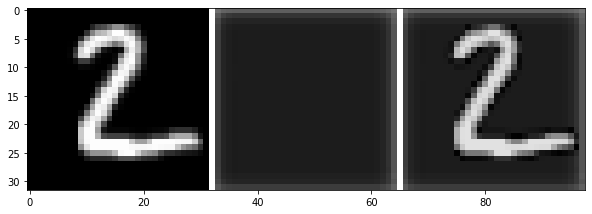

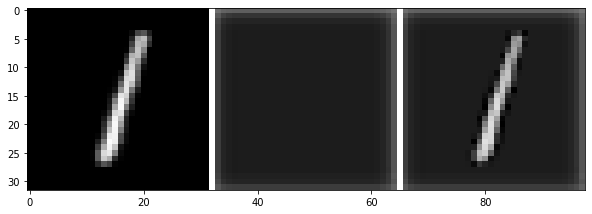

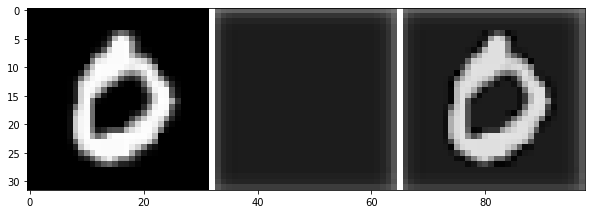

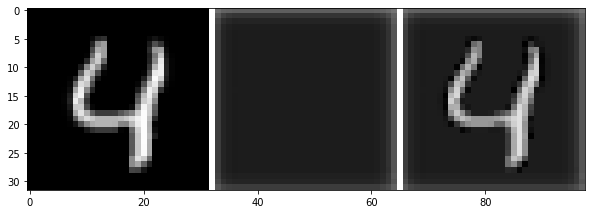

18/02/2020 19:50:20, epoch=1, step=120, loss=0.10721, distortion=0.141, rate=1.748, -elbo=1341.22241, nll=100.19526, KL=1241.02710, commit_loss=8345.85352, bit_usage=0.24970, highest_prob=0.276, temp=0.66245
reset code 48
pruned code 48 - 508 remain
18/02/2020 19:50:21, epoch=1, step=140, loss=0.10582, distortion=0.139, rate=1.752, -elbo=1342.42969, nll=98.99828, KL=1243.43140, commit_loss=8116.76172, bit_usage=0.24753, highest_prob=0.323, temp=0.66169
reset code 48
18/02/2020 19:50:23, epoch=1, step=160, loss=0.10451, distortion=0.138, rate=1.681, -elbo=1291.28784, nll=98.01510, KL=1193.27271, commit_loss=7808.69531, bit_usage=0.28300, highest_prob=0.274, temp=0.66094
reset code 64
pruned code 64 - 507 remain
18/02/2020 19:50:25, epoch=1, step=180, loss=0.10438, distortion=0.138, rate=1.694, -elbo=1300.93982, nll=98.23898, KL=1202.70081, commit_loss=7446.38281, bit_usage=0.27588, highest_prob=0.319, temp=0.66019
reset code 64
18/02/2020 19:50:27, epoch=1, step=200, loss=0.10233, disto

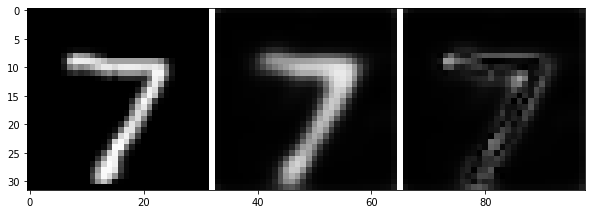

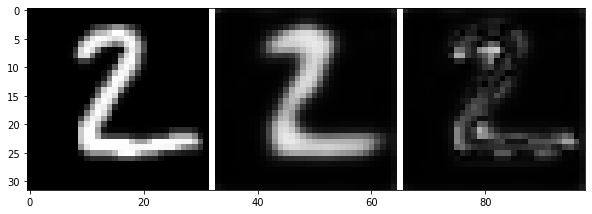

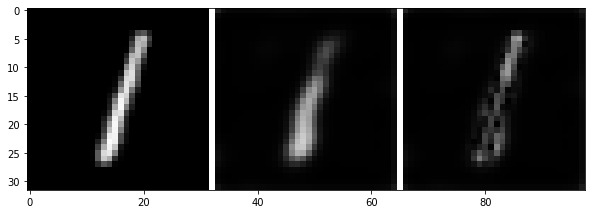

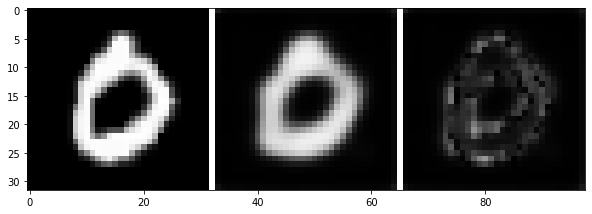

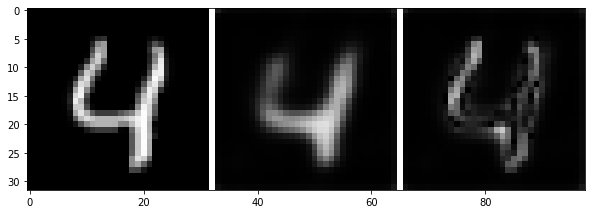

18/02/2020 19:51:13, epoch=6, step=720, loss=0.01454, distortion=0.018, rate=1.414, -elbo=1016.83276, nll=12.99098, KL=1003.84180, commit_loss=891.81384, bit_usage=0.48738, highest_prob=0.100, temp=0.63987
reset code 288
pruned code 288 - 493 remain
18/02/2020 19:51:15, epoch=6, step=740, loss=0.01238, distortion=0.015, rate=1.406, -elbo=1008.54425, nll=10.77504, KL=997.76923, commit_loss=906.10156, bit_usage=0.48924, highest_prob=0.100, temp=0.63912
reset code 288
18/02/2020 19:51:16, epoch=6, step=760, loss=0.01124, distortion=0.014, rate=1.373, -elbo=984.46362, nll=9.62194, KL=974.84167, commit_loss=911.66809, bit_usage=0.50513, highest_prob=0.086, temp=0.63837
reset code 304
pruned code 304 - 492 remain
18/02/2020 19:51:18, epoch=6, step=780, loss=0.01030, distortion=0.012, rate=1.372, -elbo=982.40649, nll=8.66558, KL=973.74091, commit_loss=910.47211, bit_usage=0.50663, highest_prob=0.086, temp=0.63761
reset code 304
18/02/2020 19:51:20, epoch=6, step=800, loss=0.00988, distortion=

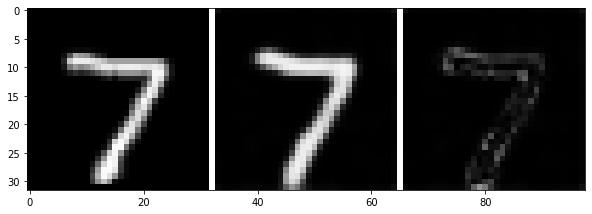

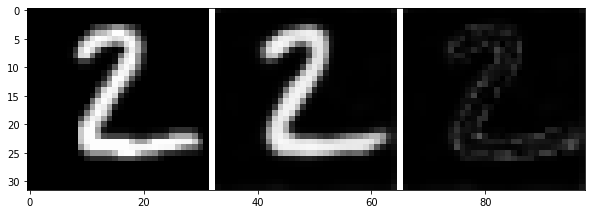

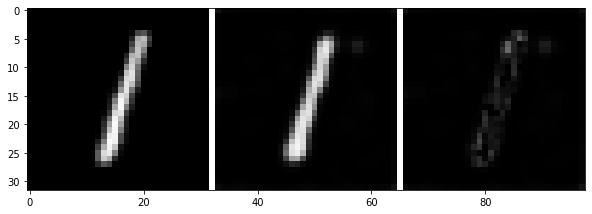

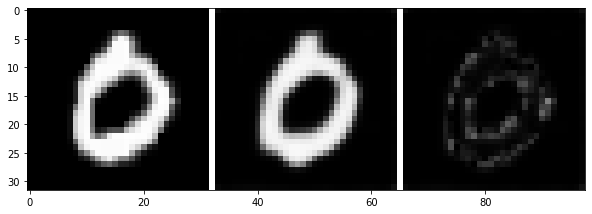

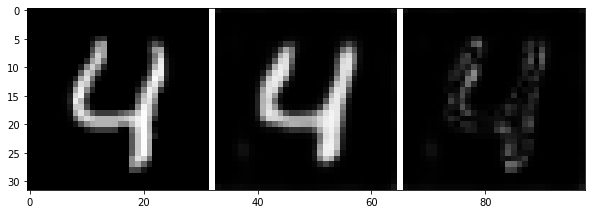

18/02/2020 19:52:04, epoch=11, step=1300, loss=0.00477, distortion=0.005, rate=1.278, -elbo=910.74567, nll=3.42899, KL=907.31665, commit_loss=550.68030, bit_usage=0.59365, highest_prob=0.073, temp=0.61805
reset code 32
18/02/2020 19:52:05, epoch=11, step=1320, loss=0.00468, distortion=0.005, rate=1.264, -elbo=900.63226, nll=3.36469, KL=897.26758, commit_loss=530.52222, bit_usage=0.59941, highest_prob=0.060, temp=0.61729
reset code 48
pruned code 48 - 478 remain
18/02/2020 19:52:07, epoch=11, step=1340, loss=0.00467, distortion=0.005, rate=1.265, -elbo=901.17786, nll=3.36265, KL=897.81519, commit_loss=522.26672, bit_usage=0.59888, highest_prob=0.061, temp=0.61654
reset code 48
18/02/2020 19:52:09, epoch=11, step=1360, loss=0.00453, distortion=0.005, rate=1.252, -elbo=892.14209, nll=3.24489, KL=888.89722, commit_loss=507.57431, bit_usage=0.60501, highest_prob=0.058, temp=0.61579
reset code 64
pruned code 64 - 477 remain
18/02/2020 19:52:10, epoch=11, step=1380, loss=0.00447, distortion=0

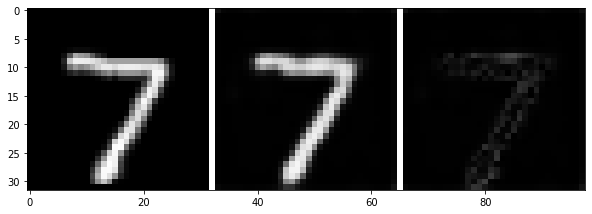

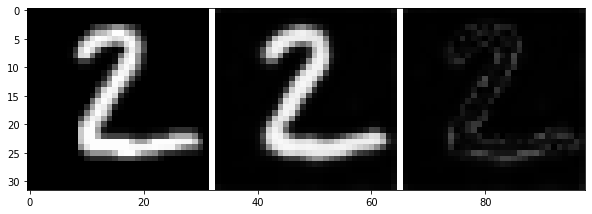

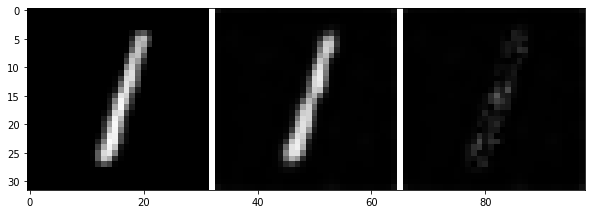

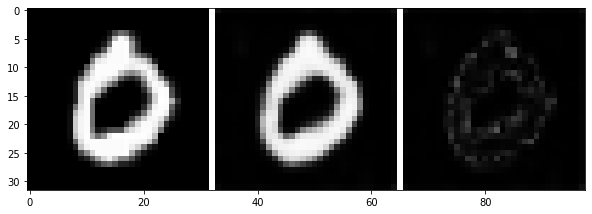

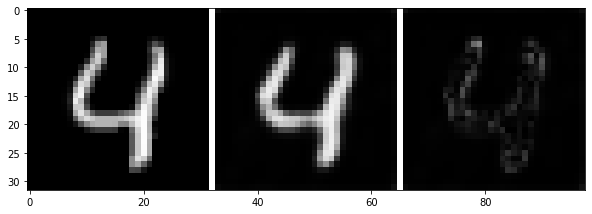

18/02/2020 19:52:55, epoch=16, step=1900, loss=0.00324, distortion=0.003, rate=1.159, -elbo=825.09436, nll=2.16527, KL=822.92908, commit_loss=332.29102, bit_usage=0.66483, highest_prob=0.039, temp=0.59547
reset code 32
18/02/2020 19:52:56, epoch=16, step=1920, loss=0.00319, distortion=0.003, rate=1.152, -elbo=819.57361, nll=2.12649, KL=817.44714, commit_loss=325.59613, bit_usage=0.66948, highest_prob=0.037, temp=0.59472
reset code 48
pruned code 48 - 463 remain
18/02/2020 19:52:58, epoch=16, step=1940, loss=0.00317, distortion=0.003, rate=1.151, -elbo=819.33936, nll=2.10950, KL=817.22986, commit_loss=319.96454, bit_usage=0.66874, highest_prob=0.037, temp=0.59397
reset code 48
18/02/2020 19:53:00, epoch=16, step=1960, loss=0.00316, distortion=0.003, rate=1.140, -elbo=811.61951, nll=2.11362, KL=809.50586, commit_loss=315.49896, bit_usage=0.67402, highest_prob=0.036, temp=0.59321
reset code 64
pruned code 64 - 462 remain
18/02/2020 19:53:01, epoch=16, step=1980, loss=0.00317, distortion=0

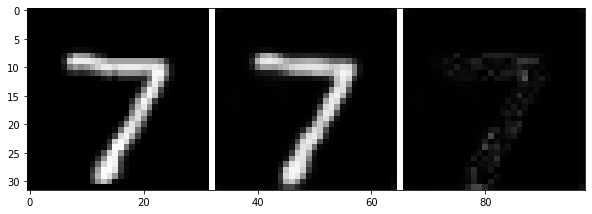

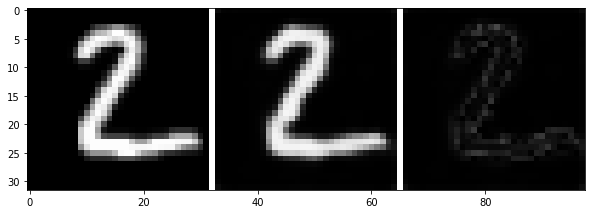

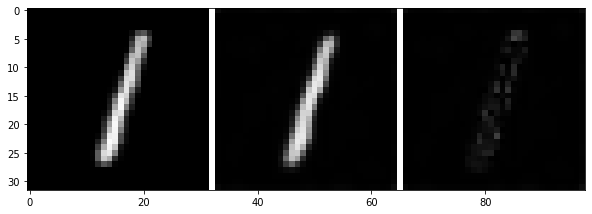

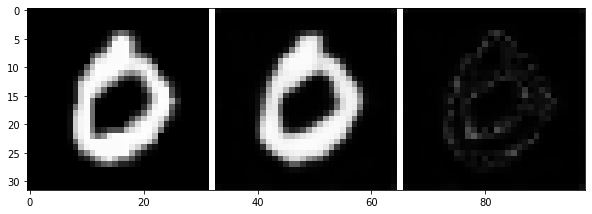

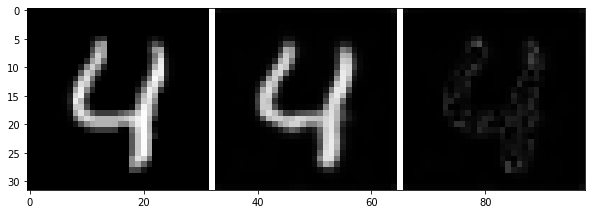

18/02/2020 19:53:44, epoch=21, step=2480, loss=0.00270, distortion=0.003, rate=1.054, -elbo=749.87860, nll=1.78491, KL=748.09369, commit_loss=227.92917, bit_usage=0.72343, highest_prob=0.025, temp=0.57365
reset code 288
pruned code 288 - 449 remain
18/02/2020 19:53:46, epoch=21, step=2500, loss=0.00266, distortion=0.002, rate=1.051, -elbo=747.86609, nll=1.75108, KL=746.11499, commit_loss=223.74268, bit_usage=0.72286, highest_prob=0.025, temp=0.57289
reset code 24
18/02/2020 19:53:47, epoch=21, step=2520, loss=0.00263, distortion=0.002, rate=1.048, -elbo=745.82483, nll=1.72635, KL=744.09851, commit_loss=224.93265, bit_usage=0.72604, highest_prob=0.024, temp=0.57214
reset code 40
pruned code 40 - 448 remain
18/02/2020 19:53:49, epoch=21, step=2540, loss=0.00260, distortion=0.002, rate=1.046, -elbo=743.94446, nll=1.70588, KL=742.23859, commit_loss=217.80713, bit_usage=0.72533, highest_prob=0.024, temp=0.57139
reset code 48
18/02/2020 19:53:50, epoch=21, step=2560, loss=0.00267, distortion

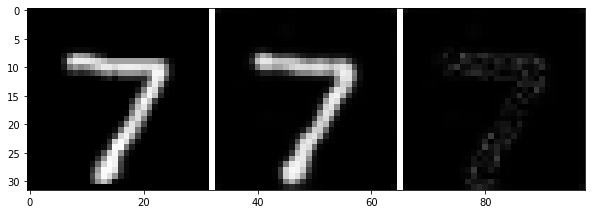

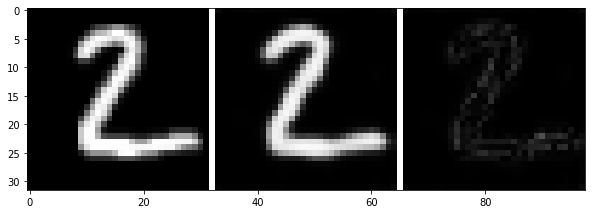

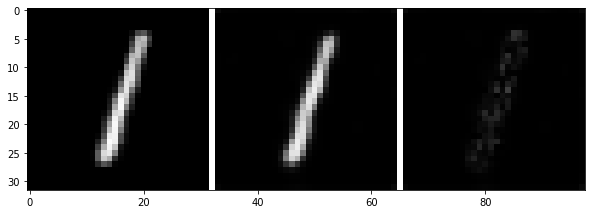

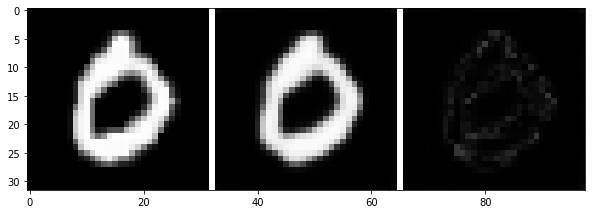

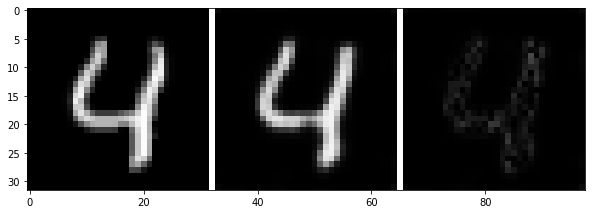

18/02/2020 19:54:33, epoch=26, step=3080, loss=0.00231, distortion=0.002, rate=0.962, -elbo=684.59222, nll=1.51959, KL=683.07263, commit_loss=165.39629, bit_usage=0.76684, highest_prob=0.018, temp=0.55107
reset code 304
pruned code 304 - 434 remain
18/02/2020 19:54:35, epoch=26, step=3100, loss=0.00226, distortion=0.002, rate=0.956, -elbo=679.83356, nll=1.47771, KL=678.35583, commit_loss=160.79303, bit_usage=0.76621, highest_prob=0.018, temp=0.55032
reset code 304
18/02/2020 19:54:36, epoch=26, step=3120, loss=0.00231, distortion=0.002, rate=0.955, -elbo=679.23053, nll=1.52358, KL=677.70697, commit_loss=162.70895, bit_usage=0.76951, highest_prob=0.017, temp=0.54957
reset code 320
pruned code 320 - 433 remain
18/02/2020 19:54:38, epoch=26, step=3140, loss=0.00225, distortion=0.002, rate=0.955, -elbo=679.28766, nll=1.46372, KL=677.82391, commit_loss=161.12650, bit_usage=0.76964, highest_prob=0.018, temp=0.54881
reset code 40
18/02/2020 19:54:39, epoch=26, step=3160, loss=0.00228, distort

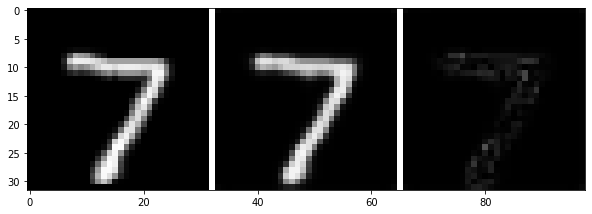

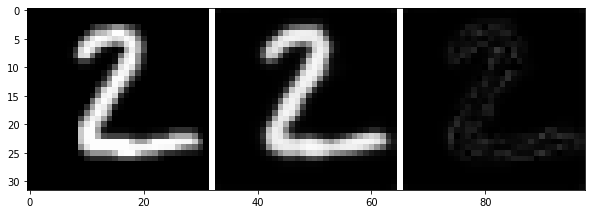

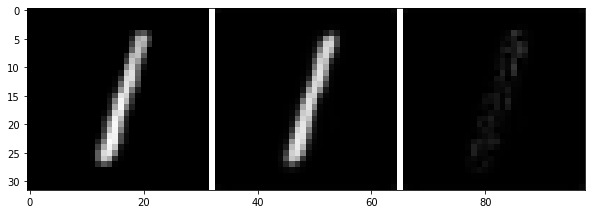

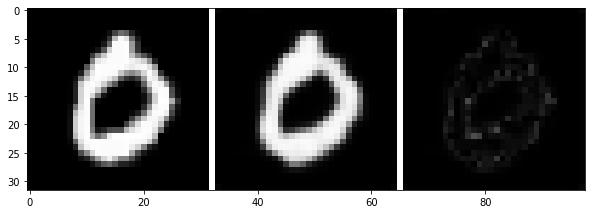

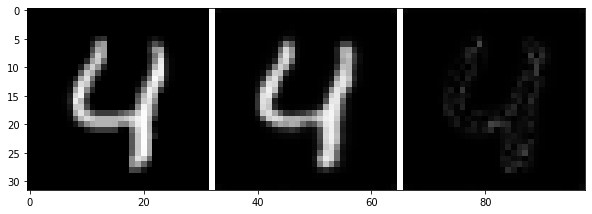

18/02/2020 19:55:21, epoch=31, step=3660, loss=0.00209, distortion=0.002, rate=0.887, -elbo=631.15375, nll=1.37829, KL=629.77545, commit_loss=130.38956, bit_usage=0.80023, highest_prob=0.014, temp=0.52925
reset code 288
18/02/2020 19:55:22, epoch=31, step=3680, loss=0.00208, distortion=0.002, rate=0.884, -elbo=629.14331, nll=1.37547, KL=627.76782, commit_loss=130.61975, bit_usage=0.80251, highest_prob=0.014, temp=0.52849
reset code 304
pruned code 304 - 419 remain
18/02/2020 19:55:24, epoch=31, step=3700, loss=0.00206, distortion=0.002, rate=0.882, -elbo=627.19745, nll=1.35804, KL=625.83942, commit_loss=127.70334, bit_usage=0.80235, highest_prob=0.014, temp=0.52774
reset code 304
18/02/2020 19:55:25, epoch=31, step=3720, loss=0.00206, distortion=0.002, rate=0.881, -elbo=626.40552, nll=1.35862, KL=625.04688, commit_loss=128.77896, bit_usage=0.80476, highest_prob=0.014, temp=0.52699
reset code 320
pruned code 320 - 418 remain
18/02/2020 19:55:27, epoch=31, step=3740, loss=0.00213, distor

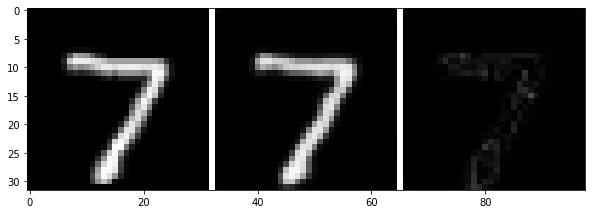

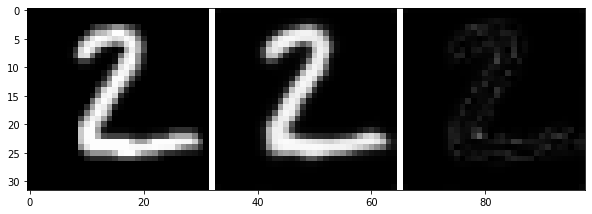

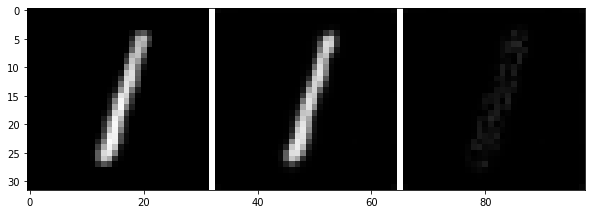

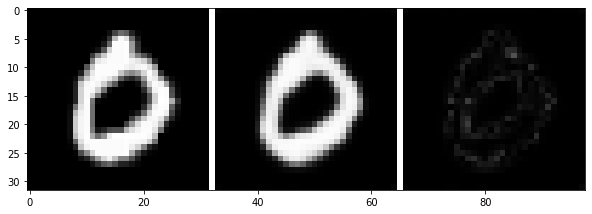

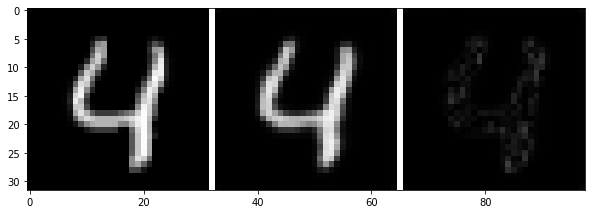

18/02/2020 19:56:09, epoch=36, step=4260, loss=0.00192, distortion=0.002, rate=0.826, -elbo=587.38751, nll=1.26848, KL=586.11902, commit_loss=110.96331, bit_usage=0.83040, highest_prob=0.012, temp=0.50667
reset code 352
18/02/2020 19:56:11, epoch=36, step=4280, loss=0.00192, distortion=0.002, rate=0.822, -elbo=584.47693, nll=1.27441, KL=583.20251, commit_loss=110.28008, bit_usage=0.83219, highest_prob=0.012, temp=0.50592
reset code 368
pruned code 368 - 404 remain
18/02/2020 19:56:12, epoch=36, step=4300, loss=0.00192, distortion=0.002, rate=0.819, -elbo=582.80853, nll=1.27656, KL=581.53198, commit_loss=109.14931, bit_usage=0.83229, highest_prob=0.012, temp=0.50517
reset code 368
18/02/2020 19:56:14, epoch=36, step=4320, loss=0.00189, distortion=0.002, rate=0.817, -elbo=580.80432, nll=1.24803, KL=579.55627, commit_loss=110.05479, bit_usage=0.83402, highest_prob=0.012, temp=0.50441
reset code 384
pruned code 384 - 403 remain
18/02/2020 19:56:15, epoch=36, step=4340, loss=0.00189, distor

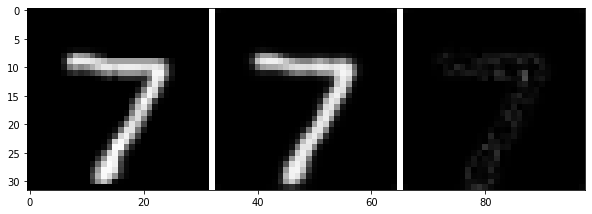

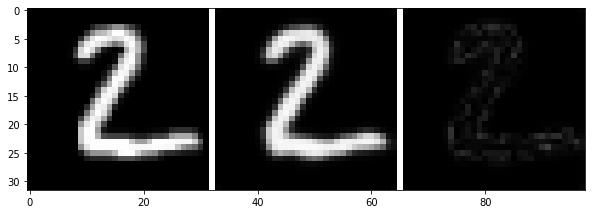

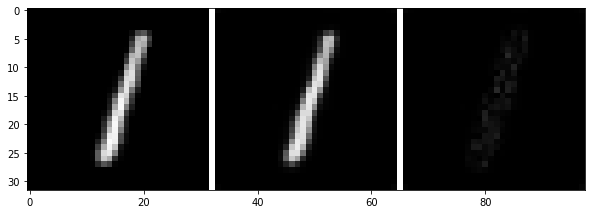

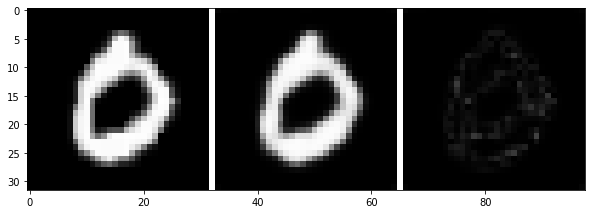

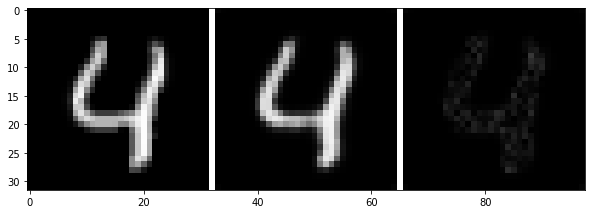

18/02/2020 19:56:55, epoch=41, step=4840, loss=0.00181, distortion=0.002, rate=0.772, -elbo=549.20612, nll=1.20775, KL=547.99835, commit_loss=99.03815, bit_usage=0.85617, highest_prob=0.010, temp=0.48485
reset code 304
pruned code 304 - 390 remain
18/02/2020 19:56:56, epoch=41, step=4860, loss=0.00178, distortion=0.002, rate=0.766, -elbo=544.91400, nll=1.18117, KL=543.73285, commit_loss=95.27333, bit_usage=0.85554, highest_prob=0.010, temp=0.48409
reset code 304
18/02/2020 19:56:58, epoch=41, step=4880, loss=0.00178, distortion=0.002, rate=0.765, -elbo=544.01355, nll=1.18114, KL=542.83240, commit_loss=96.57416, bit_usage=0.85726, highest_prob=0.010, temp=0.48334
reset code 320
pruned code 320 - 389 remain
18/02/2020 19:56:59, epoch=41, step=4900, loss=0.00177, distortion=0.002, rate=0.764, -elbo=543.72028, nll=1.17733, KL=542.54297, commit_loss=96.91708, bit_usage=0.85733, highest_prob=0.010, temp=0.48259
reset code 320
18/02/2020 19:57:00, epoch=41, step=4920, loss=0.00178, distortion

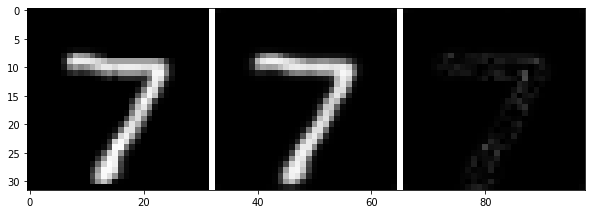

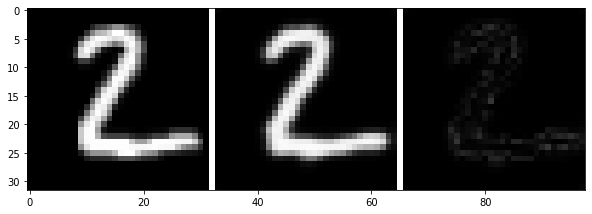

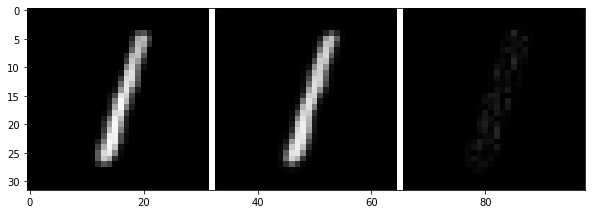

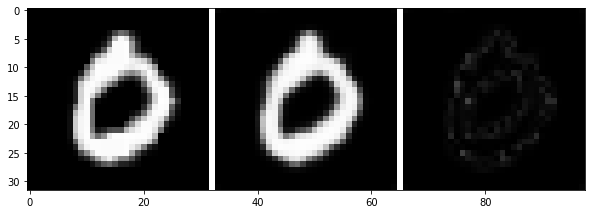

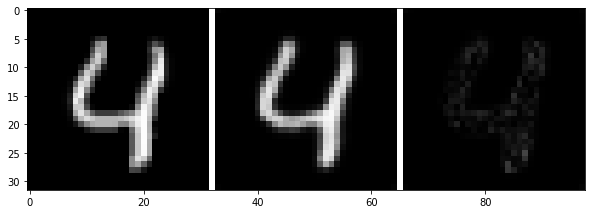

18/02/2020 19:57:40, epoch=46, step=5440, loss=0.00168, distortion=0.002, rate=0.717, -elbo=509.94196, nll=1.12710, KL=508.81485, commit_loss=88.60376, bit_usage=0.87804, highest_prob=0.009, temp=0.46227
reset code 352
pruned code 352 - 375 remain
18/02/2020 19:57:41, epoch=46, step=5460, loss=0.00167, distortion=0.002, rate=0.715, -elbo=508.61142, nll=1.11924, KL=507.49219, commit_loss=87.34215, bit_usage=0.87790, highest_prob=0.009, temp=0.46152
reset code 352
18/02/2020 19:57:43, epoch=46, step=5480, loss=0.00168, distortion=0.002, rate=0.713, -elbo=507.39761, nll=1.12179, KL=506.27582, commit_loss=87.32092, bit_usage=0.87961, highest_prob=0.009, temp=0.46077
reset code 368
pruned code 368 - 374 remain
18/02/2020 19:57:44, epoch=46, step=5500, loss=0.00166, distortion=0.002, rate=0.713, -elbo=506.98267, nll=1.10465, KL=505.87802, commit_loss=87.05197, bit_usage=0.87938, highest_prob=0.009, temp=0.46001
reset code 368
18/02/2020 19:57:45, epoch=46, step=5520, loss=0.00171, distortion

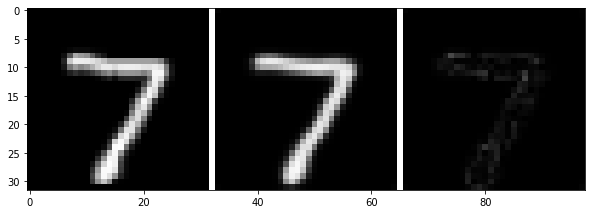

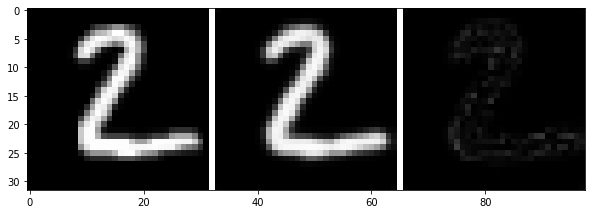

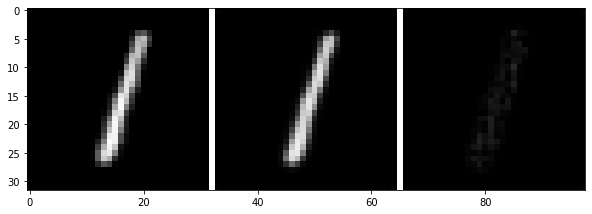

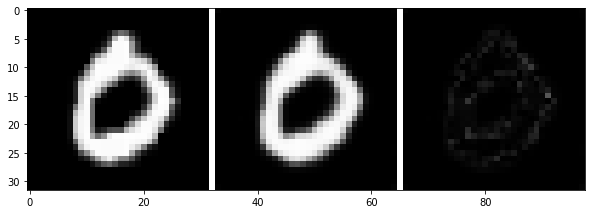

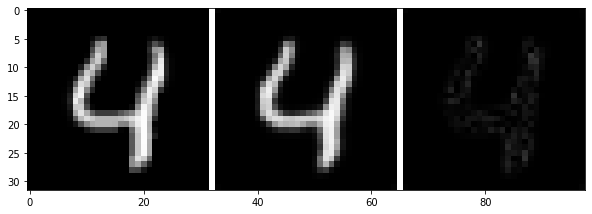

18/02/2020 19:58:23, epoch=51, step=6020, loss=0.00158, distortion=0.001, rate=0.668, -elbo=475.49988, nll=1.06138, KL=474.43851, commit_loss=81.44994, bit_usage=0.89646, highest_prob=0.008, temp=0.44045
reset code 304
18/02/2020 19:58:24, epoch=51, step=6040, loss=0.00159, distortion=0.002, rate=0.670, -elbo=476.53006, nll=1.07355, KL=475.45651, commit_loss=82.52543, bit_usage=0.89806, highest_prob=0.008, temp=0.43969
reset code 336
pruned code 336 - 360 remain
18/02/2020 19:58:25, epoch=51, step=6060, loss=0.00157, distortion=0.001, rate=0.665, -elbo=473.29645, nll=1.05267, KL=472.24377, commit_loss=80.39261, bit_usage=0.89772, highest_prob=0.008, temp=0.43894
reset code 336
18/02/2020 19:58:27, epoch=51, step=6080, loss=0.00161, distortion=0.002, rate=0.669, -elbo=475.81958, nll=1.09383, KL=474.72574, commit_loss=82.82361, bit_usage=0.89919, highest_prob=0.008, temp=0.43819
reset code 352
pruned code 352 - 359 remain
18/02/2020 19:58:28, epoch=51, step=6100, loss=0.00158, distortion

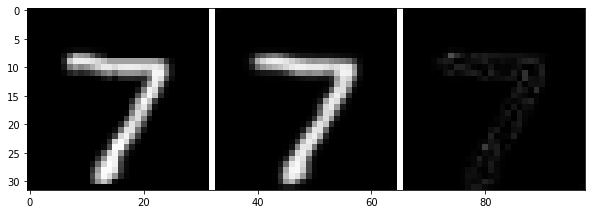

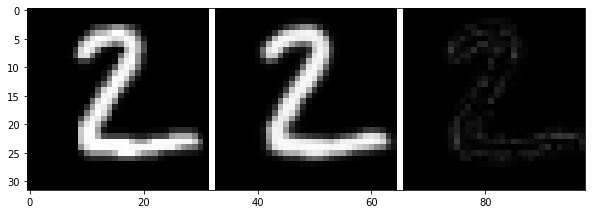

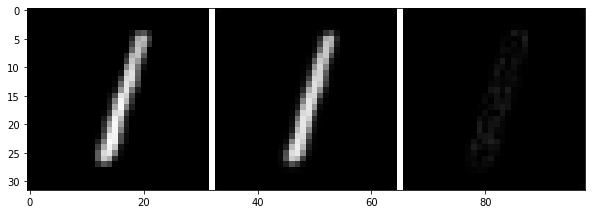

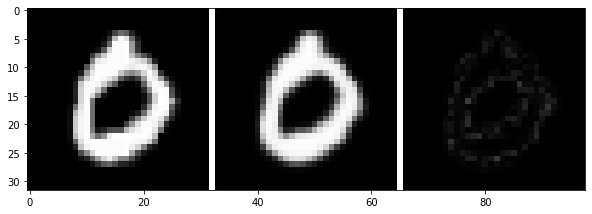

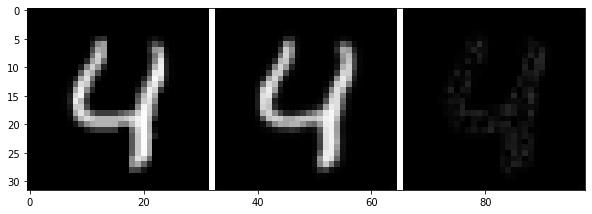

18/02/2020 19:59:06, epoch=56, step=6620, loss=0.00150, distortion=0.001, rate=0.625, -elbo=444.83948, nll=1.01976, KL=443.81970, commit_loss=75.52647, bit_usage=0.91391, highest_prob=0.007, temp=0.41787
reset code 256
18/02/2020 19:59:08, epoch=56, step=6640, loss=0.00150, distortion=0.001, rate=0.625, -elbo=444.90170, nll=1.01615, KL=443.88556, commit_loss=75.72324, bit_usage=0.91517, highest_prob=0.007, temp=0.41712
reset code 272
pruned code 272 - 345 remain
18/02/2020 19:59:09, epoch=56, step=6660, loss=0.00149, distortion=0.001, rate=0.624, -elbo=444.01093, nll=1.00561, KL=443.00531, commit_loss=75.80788, bit_usage=0.91510, highest_prob=0.007, temp=0.41637
reset code 272
18/02/2020 19:59:10, epoch=56, step=6680, loss=0.00150, distortion=0.001, rate=0.623, -elbo=443.44772, nll=1.01986, KL=442.42786, commit_loss=76.26019, bit_usage=0.91647, highest_prob=0.007, temp=0.41561
reset code 288
pruned code 288 - 344 remain
18/02/2020 19:59:12, epoch=56, step=6700, loss=0.00149, distortion

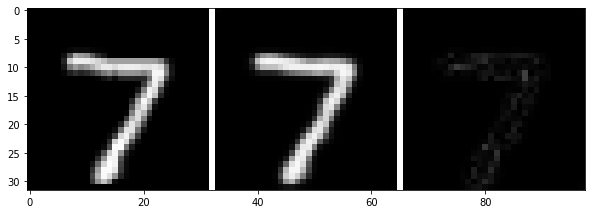

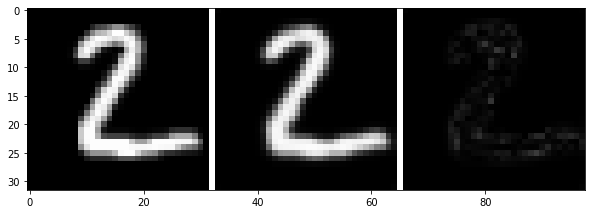

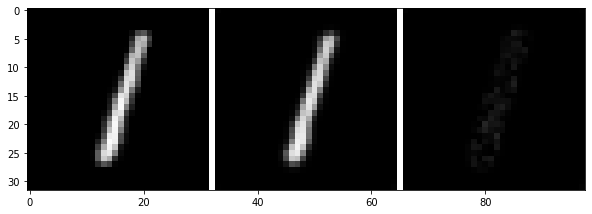

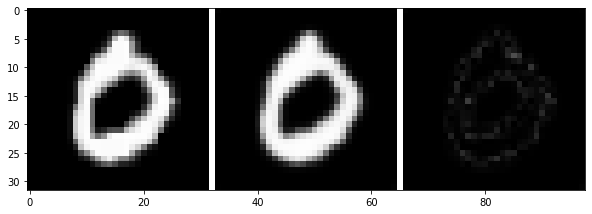

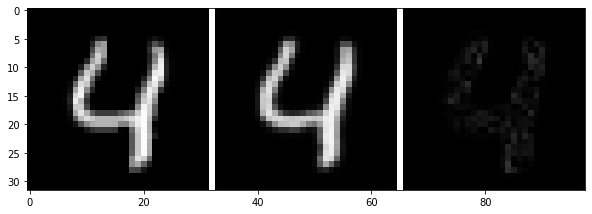

18/02/2020 19:59:47, epoch=61, step=7200, loss=0.00146, distortion=0.001, rate=0.588, -elbo=418.17389, nll=1.00733, KL=417.16656, commit_loss=73.76954, bit_usage=0.93055, highest_prob=0.007, temp=0.39605
reset code 160
pruned code 160 - 331 remain
18/02/2020 19:59:49, epoch=61, step=7220, loss=0.00143, distortion=0.001, rate=0.583, -elbo=414.85336, nll=0.97830, KL=413.87506, commit_loss=72.27150, bit_usage=0.93035, highest_prob=0.007, temp=0.39529
reset code 160
18/02/2020 19:59:50, epoch=61, step=7240, loss=0.00143, distortion=0.001, rate=0.579, -elbo=412.18591, nll=0.98487, KL=411.20105, commit_loss=71.36820, bit_usage=0.93145, highest_prob=0.007, temp=0.39454
reset code 176
pruned code 176 - 330 remain
18/02/2020 19:59:51, epoch=61, step=7260, loss=0.00147, distortion=0.001, rate=0.585, -elbo=416.54129, nll=1.01648, KL=415.52481, commit_loss=73.82973, bit_usage=0.93182, highest_prob=0.007, temp=0.39379
reset code 8
18/02/2020 19:59:52, epoch=61, step=7280, loss=0.00142, distortion=0

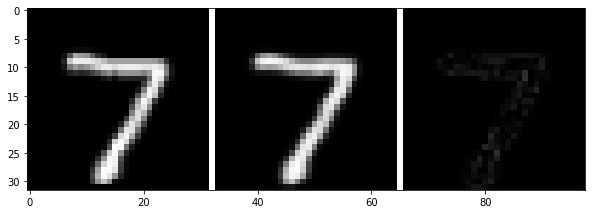

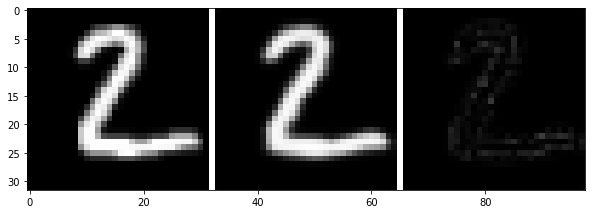

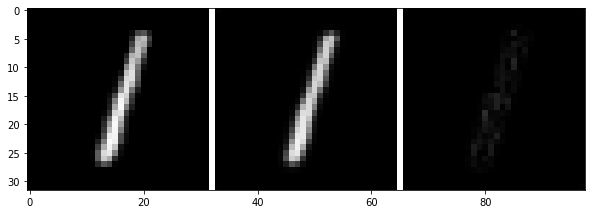

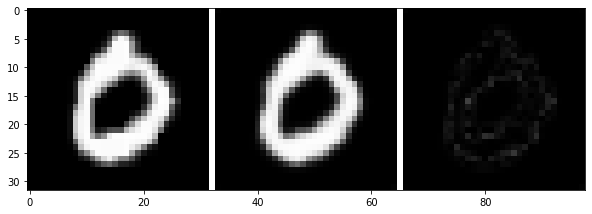

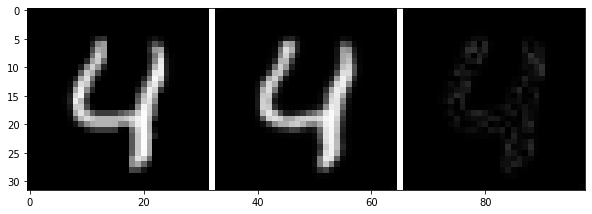

18/02/2020 20:00:28, epoch=66, step=7800, loss=0.00139, distortion=0.001, rate=0.548, -elbo=389.88519, nll=0.96666, KL=388.91852, commit_loss=70.91906, bit_usage=0.94549, highest_prob=0.006, temp=0.37347
reset code 88
pruned code 88 - 316 remain
18/02/2020 20:00:30, epoch=66, step=7820, loss=0.00140, distortion=0.001, rate=0.550, -elbo=391.49188, nll=0.97578, KL=390.51611, commit_loss=71.42092, bit_usage=0.94543, highest_prob=0.006, temp=0.37272
reset code 176
18/02/2020 20:00:31, epoch=66, step=7840, loss=0.00135, distortion=0.001, rate=0.542, -elbo=385.79919, nll=0.92858, KL=384.87061, commit_loss=70.33865, bit_usage=0.94636, highest_prob=0.006, temp=0.37197
reset code 208
pruned code 208 - 315 remain
18/02/2020 20:00:32, epoch=66, step=7860, loss=0.00136, distortion=0.001, rate=0.542, -elbo=385.49921, nll=0.93962, KL=384.55960, commit_loss=69.66423, bit_usage=0.94628, highest_prob=0.006, temp=0.37121
reset code 208
18/02/2020 20:00:33, epoch=66, step=7880, loss=0.00137, distortion=0

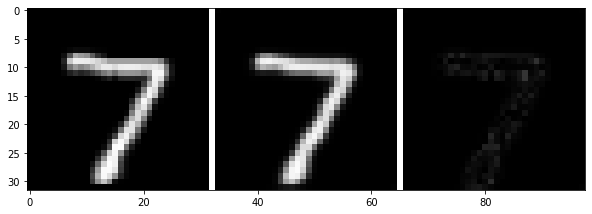

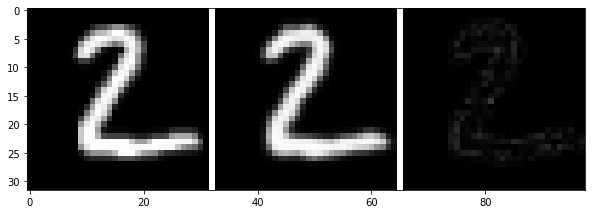

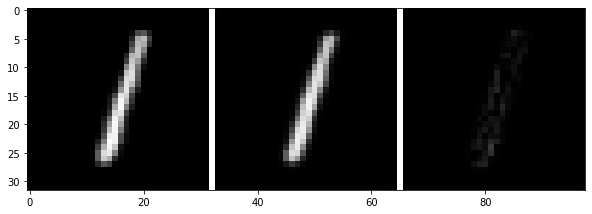

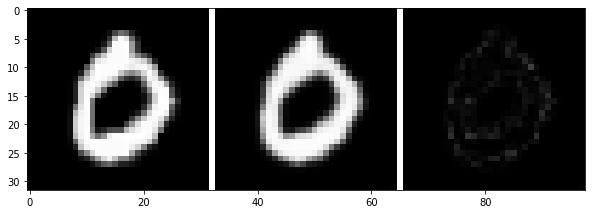

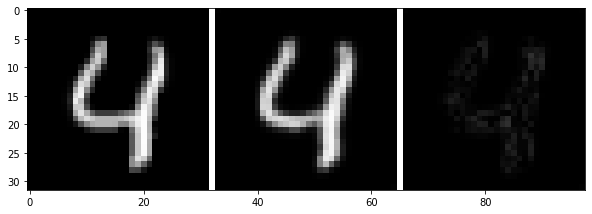

18/02/2020 20:01:07, epoch=71, step=8380, loss=0.00132, distortion=0.001, rate=0.510, -elbo=362.78052, nll=0.91733, KL=361.86319, commit_loss=68.92395, bit_usage=0.95835, highest_prob=0.006, temp=0.35165
reset code 272
18/02/2020 20:01:08, epoch=71, step=8400, loss=0.00132, distortion=0.001, rate=0.504, -elbo=358.73053, nll=0.92790, KL=357.80264, commit_loss=68.15015, bit_usage=0.95927, highest_prob=0.006, temp=0.35089
reset code 288
pruned code 288 - 301 remain
18/02/2020 20:01:09, epoch=71, step=8420, loss=0.00130, distortion=0.001, rate=0.504, -elbo=358.35910, nll=0.90776, KL=357.45135, commit_loss=67.87064, bit_usage=0.95918, highest_prob=0.006, temp=0.35014
reset code 8
18/02/2020 20:01:11, epoch=71, step=8440, loss=0.00130, distortion=0.001, rate=0.504, -elbo=358.59531, nll=0.90988, KL=357.68542, commit_loss=68.33607, bit_usage=0.96013, highest_prob=0.006, temp=0.34939
reset code 24
pruned code 24 - 300 remain
18/02/2020 20:01:12, epoch=71, step=8460, loss=0.00130, distortion=0.0

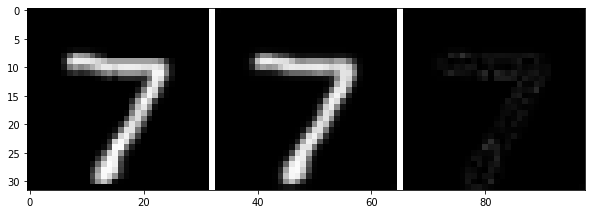

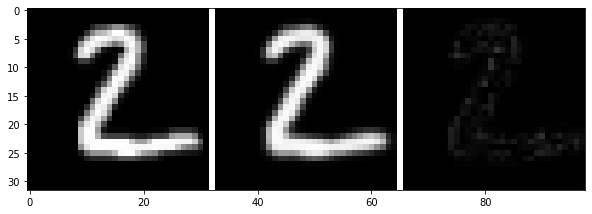

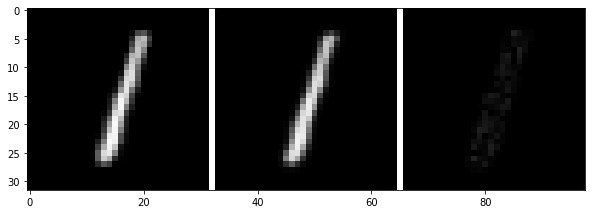

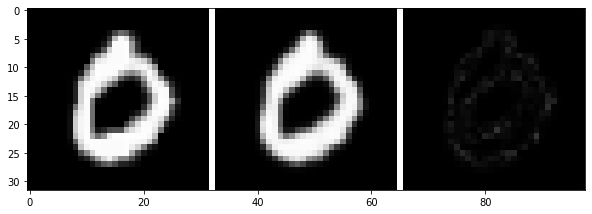

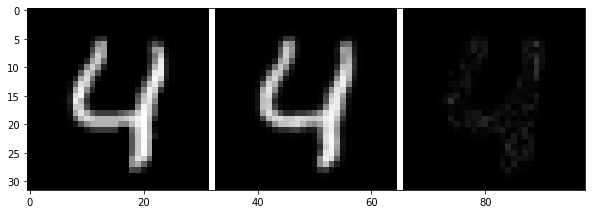

18/02/2020 20:01:46, epoch=76, step=8980, loss=0.00128, distortion=0.001, rate=0.475, -elbo=338.13217, nll=0.90639, KL=337.22577, commit_loss=67.70077, bit_usage=0.97110, highest_prob=0.005, temp=0.32907
reset code 160
18/02/2020 20:01:48, epoch=76, step=9000, loss=0.00126, distortion=0.001, rate=0.471, -elbo=335.05917, nll=0.88504, KL=334.17413, commit_loss=67.19973, bit_usage=0.97187, highest_prob=0.005, temp=0.32832
reset code 224
pruned code 224 - 286 remain
18/02/2020 20:01:49, epoch=76, step=9020, loss=0.00125, distortion=0.001, rate=0.466, -elbo=331.67203, nll=0.88577, KL=330.78625, commit_loss=66.12251, bit_usage=0.97184, highest_prob=0.005, temp=0.32757
reset code 184
18/02/2020 20:01:50, epoch=76, step=9040, loss=0.00127, distortion=0.001, rate=0.470, -elbo=334.41608, nll=0.90284, KL=333.51324, commit_loss=67.11599, bit_usage=0.97260, highest_prob=0.005, temp=0.32681
reset code 20
pruned code 20 - 285 remain
18/02/2020 20:01:51, epoch=76, step=9060, loss=0.00127, distortion=0

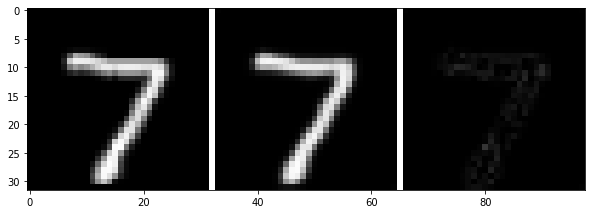

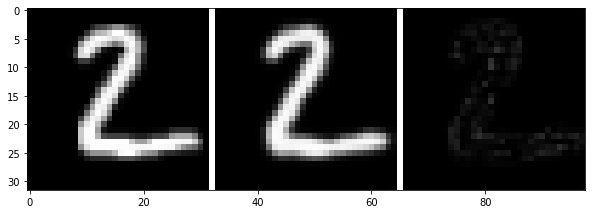

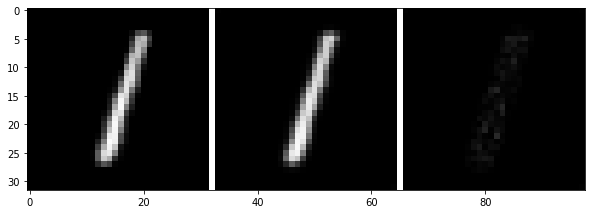

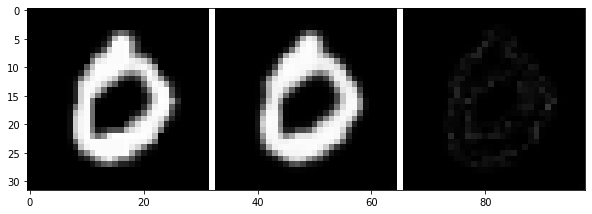

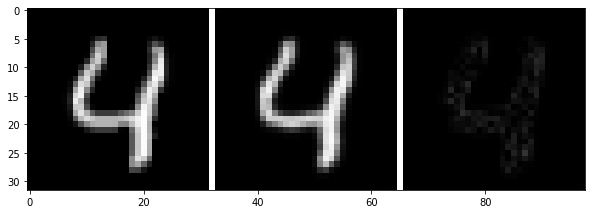

18/02/2020 20:02:23, epoch=81, step=9560, loss=0.00122, distortion=0.001, rate=0.434, -elbo=308.71295, nll=0.87458, KL=307.83838, commit_loss=65.16866, bit_usage=0.98302, highest_prob=0.005, temp=0.30725
reset code 12
pruned code 12 - 272 remain
18/02/2020 20:02:24, epoch=81, step=9580, loss=0.00120, distortion=0.001, rate=0.430, -elbo=306.39673, nll=0.85320, KL=305.54352, commit_loss=64.97278, bit_usage=0.98289, highest_prob=0.005, temp=0.30649
reset code 16
18/02/2020 20:02:26, epoch=81, step=9600, loss=0.00119, distortion=0.001, rate=0.427, -elbo=304.01102, nll=0.85133, KL=303.15970, commit_loss=63.50569, bit_usage=0.98365, highest_prob=0.005, temp=0.30574
reset code 32
pruned code 32 - 271 remain
18/02/2020 20:02:27, epoch=81, step=9620, loss=0.00120, distortion=0.001, rate=0.426, -elbo=303.47824, nll=0.86142, KL=302.61682, commit_loss=63.62085, bit_usage=0.98357, highest_prob=0.005, temp=0.30499
reset code 32
18/02/2020 20:02:28, epoch=81, step=9640, loss=0.00119, distortion=0.001

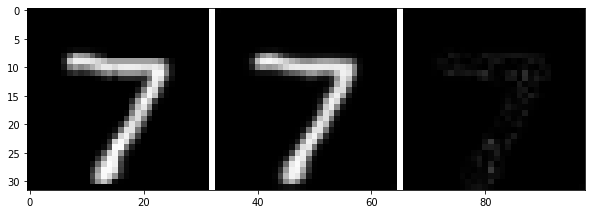

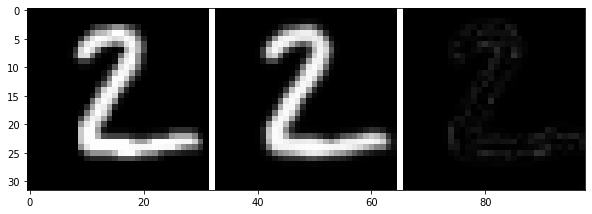

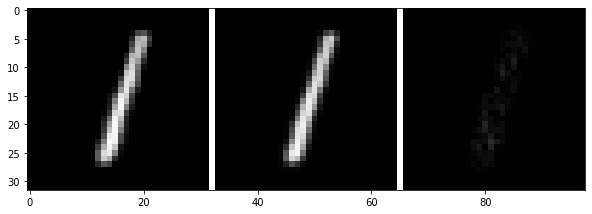

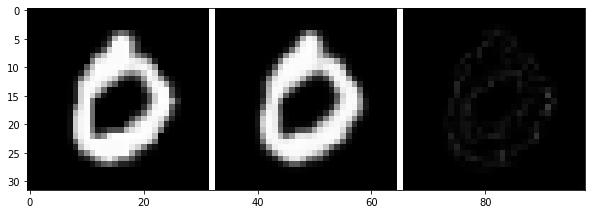

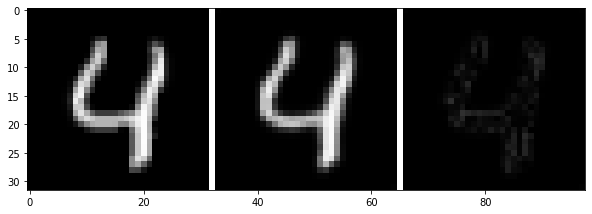

18/02/2020 20:03:00, epoch=86, step=10160, loss=0.00118, distortion=0.001, rate=0.401, -elbo=285.54272, nll=0.85694, KL=284.68579, commit_loss=65.03859, bit_usage=0.99428, highest_prob=0.005, temp=0.28467
reset code 217
pruned code 217 - 257 remain
18/02/2020 20:03:01, epoch=86, step=10180, loss=0.00116, distortion=0.001, rate=0.393, -elbo=279.87372, nll=0.84511, KL=279.02863, commit_loss=63.43797, bit_usage=0.99418, highest_prob=0.005, temp=0.28392
reset code 250
18/02/2020 20:03:02, epoch=86, step=10200, loss=0.00115, distortion=0.001, rate=0.392, -elbo=279.34201, nll=0.83648, KL=278.50552, commit_loss=63.73405, bit_usage=0.99497, highest_prob=0.005, temp=0.28317
reset code 85
pruned code 85 - 256 remain
18/02/2020 20:03:03, epoch=86, step=10220, loss=0.00116, distortion=0.001, rate=0.393, -elbo=280.00565, nll=0.84163, KL=279.16400, commit_loss=64.22159, bit_usage=0.99504, highest_prob=0.005, temp=0.28241
reset code 19
18/02/2020 20:03:04, epoch=86, step=10240, loss=0.00114, distorti

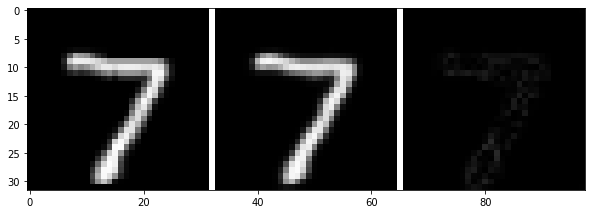

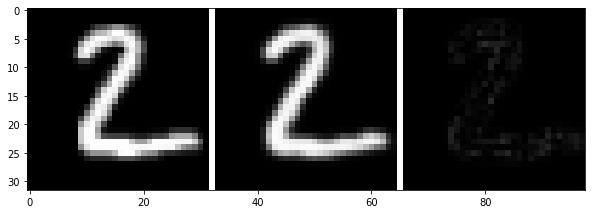

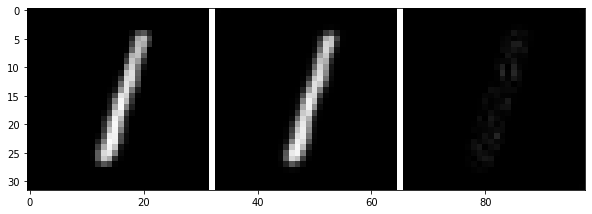

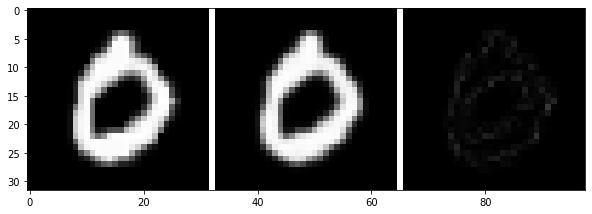

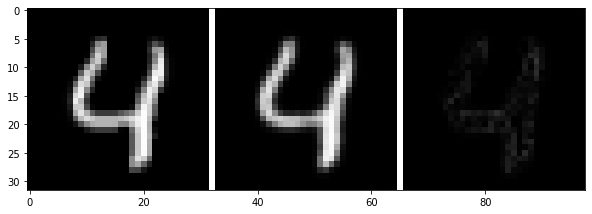

18/02/2020 20:03:36, epoch=91, step=10740, loss=0.00113, distortion=0.001, rate=0.383, -elbo=272.33679, nll=0.82115, KL=271.51566, commit_loss=61.68077, bit_usage=0.99904, highest_prob=0.005, temp=0.26285
18/02/2020 20:03:37, epoch=91, step=10760, loss=0.00111, distortion=0.001, rate=0.385, -elbo=273.93372, nll=0.79757, KL=273.13614, commit_loss=61.92001, bit_usage=0.99921, highest_prob=0.004, temp=0.26209
18/02/2020 20:03:38, epoch=91, step=10780, loss=0.00114, distortion=0.001, rate=0.391, -elbo=278.44858, nll=0.82369, KL=277.62488, commit_loss=63.04168, bit_usage=0.99925, highest_prob=0.005, temp=0.26134
18/02/2020 20:03:39, epoch=91, step=10800, loss=0.00111, distortion=0.001, rate=0.386, -elbo=274.91089, nll=0.80417, KL=274.10672, commit_loss=62.37426, bit_usage=0.99920, highest_prob=0.004, temp=0.26059
18/02/2020 20:03:40, epoch=91, step=10820, loss=0.00111, distortion=0.001, rate=0.383, -elbo=272.92859, nll=0.80340, KL=272.12518, commit_loss=61.72497, bit_usage=0.99919, highest_

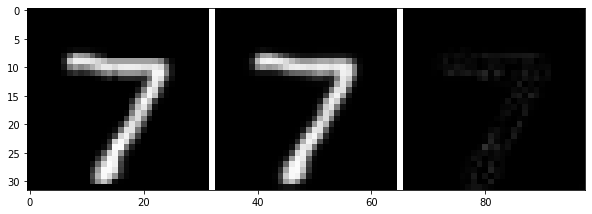

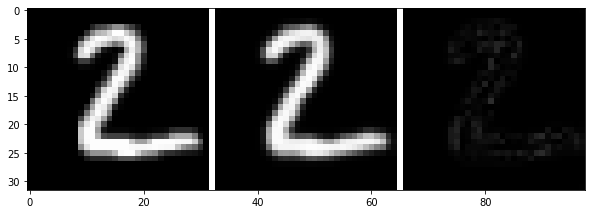

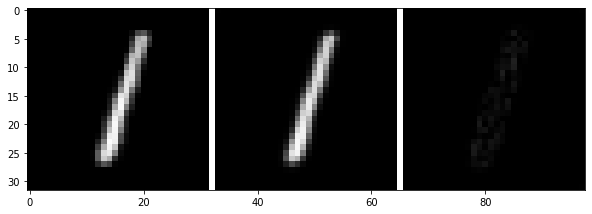

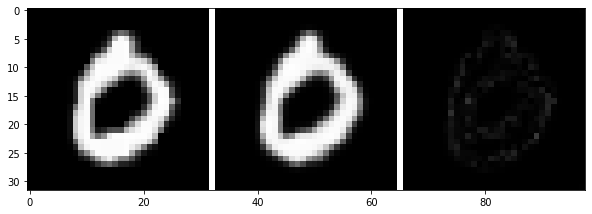

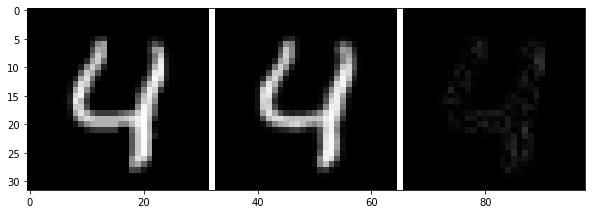

18/02/2020 20:04:11, epoch=96, step=11340, loss=0.00112, distortion=0.001, rate=0.396, -elbo=282.00952, nll=0.79811, KL=281.21143, commit_loss=62.46738, bit_usage=0.99926, highest_prob=0.005, temp=0.24027
18/02/2020 20:04:13, epoch=96, step=11360, loss=0.00110, distortion=0.001, rate=0.390, -elbo=277.82257, nll=0.78653, KL=277.03604, commit_loss=61.21060, bit_usage=0.99927, highest_prob=0.005, temp=0.23952
18/02/2020 20:04:14, epoch=96, step=11380, loss=0.00112, distortion=0.001, rate=0.403, -elbo=286.71658, nll=0.80069, KL=285.91589, commit_loss=63.39237, bit_usage=0.99945, highest_prob=0.005, temp=0.23877
18/02/2020 20:04:15, epoch=96, step=11400, loss=0.00113, distortion=0.001, rate=0.395, -elbo=281.41278, nll=0.81195, KL=280.60083, commit_loss=62.06659, bit_usage=0.99937, highest_prob=0.005, temp=0.23801
18/02/2020 20:04:16, epoch=96, step=11420, loss=0.00111, distortion=0.001, rate=0.393, -elbo=279.50192, nll=0.80104, KL=278.70087, commit_loss=61.20453, bit_usage=0.99927, highest_

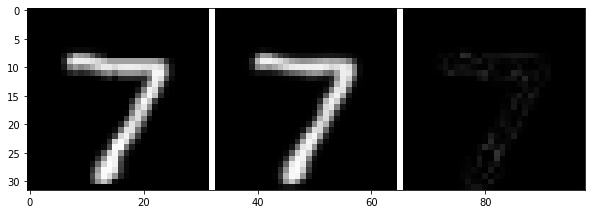

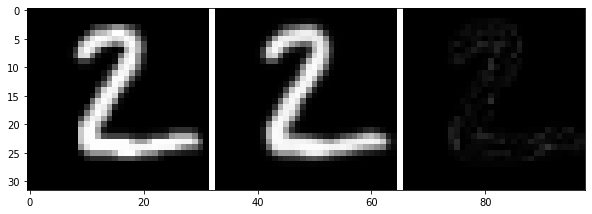

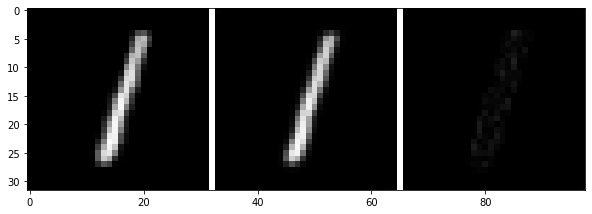

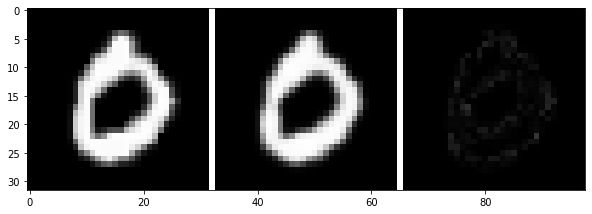

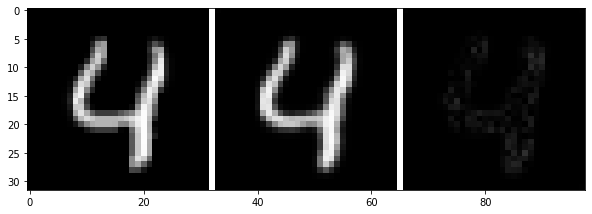

18/02/2020 20:04:47, epoch=101, step=11920, loss=0.00112, distortion=0.001, rate=0.396, -elbo=281.73004, nll=0.80545, KL=280.92459, commit_loss=60.75723, bit_usage=0.99922, highest_prob=0.005, temp=0.21845
18/02/2020 20:04:48, epoch=101, step=11940, loss=0.00113, distortion=0.001, rate=0.399, -elbo=283.83594, nll=0.80918, KL=283.02676, commit_loss=60.71088, bit_usage=0.99927, highest_prob=0.005, temp=0.21769
18/02/2020 20:04:49, epoch=101, step=11960, loss=0.00112, distortion=0.001, rate=0.396, -elbo=281.73273, nll=0.80448, KL=280.92825, commit_loss=60.58881, bit_usage=0.99917, highest_prob=0.005, temp=0.21694
18/02/2020 20:04:50, epoch=101, step=11980, loss=0.00111, distortion=0.001, rate=0.396, -elbo=281.93939, nll=0.79576, KL=281.14365, commit_loss=60.47026, bit_usage=0.99920, highest_prob=0.005, temp=0.21619
18/02/2020 20:04:51, epoch=101, step=12000, loss=0.00110, distortion=0.001, rate=0.394, -elbo=280.72360, nll=0.78888, KL=279.93472, commit_loss=59.56295, bit_usage=0.99921, hig

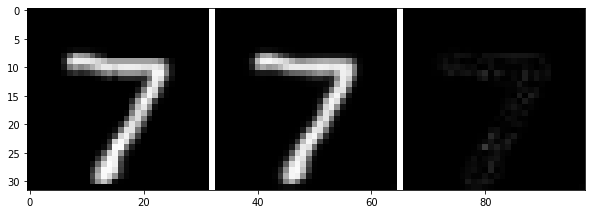

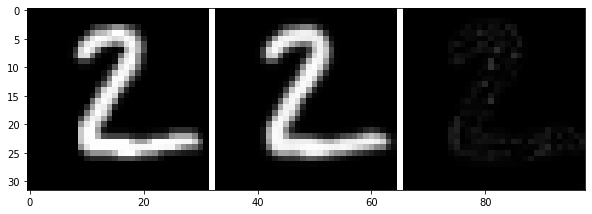

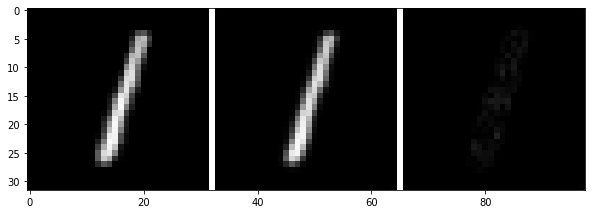

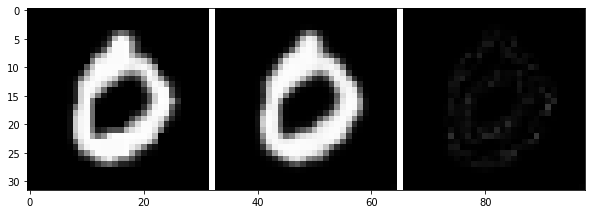

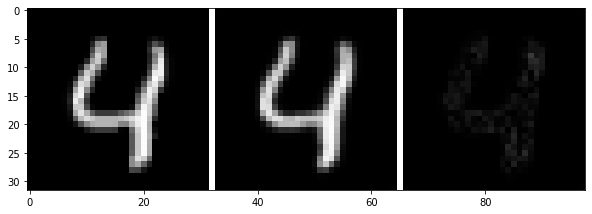

18/02/2020 20:05:22, epoch=106, step=12520, loss=0.00107, distortion=0.001, rate=0.402, -elbo=286.23605, nll=0.75305, KL=285.48300, commit_loss=59.96142, bit_usage=0.99924, highest_prob=0.005, temp=0.19587
18/02/2020 20:05:23, epoch=106, step=12540, loss=0.00108, distortion=0.001, rate=0.397, -elbo=282.33270, nll=0.76410, KL=281.56860, commit_loss=58.84536, bit_usage=0.99902, highest_prob=0.005, temp=0.19512
18/02/2020 20:05:25, epoch=106, step=12560, loss=0.00109, distortion=0.001, rate=0.404, -elbo=287.68283, nll=0.76818, KL=286.91464, commit_loss=59.93430, bit_usage=0.99927, highest_prob=0.005, temp=0.19437
18/02/2020 20:05:26, epoch=106, step=12580, loss=0.00108, distortion=0.001, rate=0.401, -elbo=285.61395, nll=0.75684, KL=284.85712, commit_loss=59.80029, bit_usage=0.99922, highest_prob=0.005, temp=0.19361
18/02/2020 20:05:27, epoch=106, step=12600, loss=0.00109, distortion=0.001, rate=0.406, -elbo=288.81277, nll=0.77249, KL=288.04028, commit_loss=60.43985, bit_usage=0.99935, hig

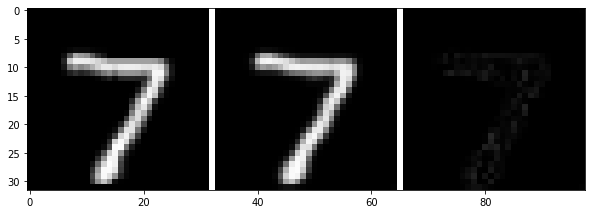

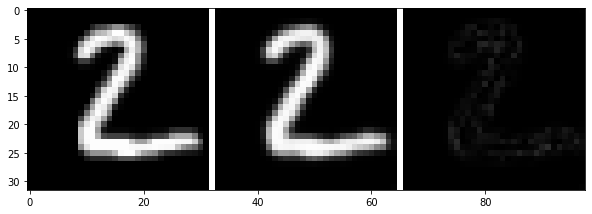

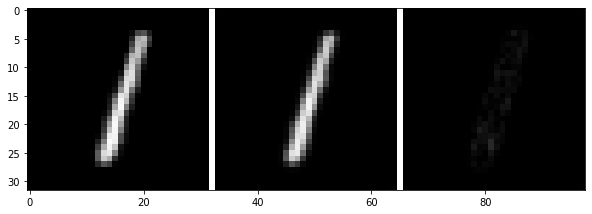

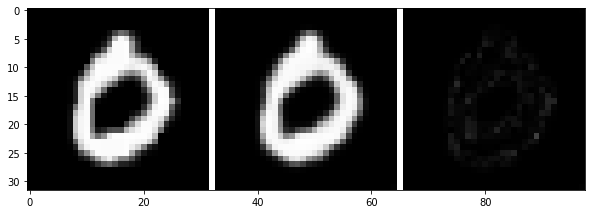

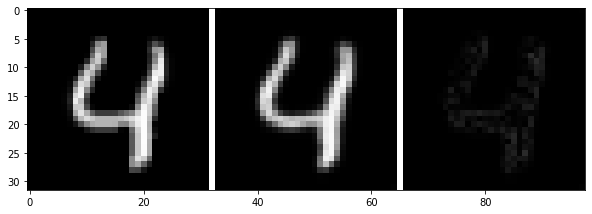

18/02/2020 20:05:57, epoch=111, step=13100, loss=0.00108, distortion=0.001, rate=0.405, -elbo=288.29605, nll=0.76393, KL=287.53210, commit_loss=59.04414, bit_usage=0.99914, highest_prob=0.005, temp=0.17405
18/02/2020 20:05:59, epoch=111, step=13120, loss=0.00110, distortion=0.001, rate=0.404, -elbo=287.73651, nll=0.78273, KL=286.95377, commit_loss=58.42213, bit_usage=0.99899, highest_prob=0.005, temp=0.17329
18/02/2020 20:06:00, epoch=111, step=13140, loss=0.00107, distortion=0.001, rate=0.407, -elbo=289.83929, nll=0.74450, KL=289.09479, commit_loss=59.29427, bit_usage=0.99932, highest_prob=0.005, temp=0.17254
18/02/2020 20:06:01, epoch=111, step=13160, loss=0.00109, distortion=0.001, rate=0.410, -elbo=291.95569, nll=0.76443, KL=291.19125, commit_loss=59.94910, bit_usage=0.99924, highest_prob=0.005, temp=0.17179
18/02/2020 20:06:02, epoch=111, step=13180, loss=0.00107, distortion=0.001, rate=0.407, -elbo=289.71851, nll=0.74733, KL=288.97116, commit_loss=59.09923, bit_usage=0.99937, hig

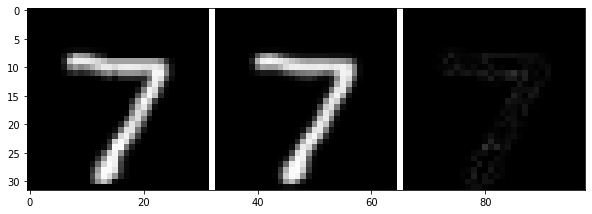

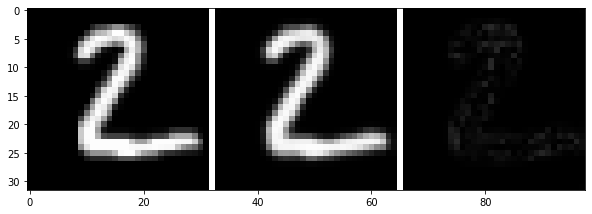

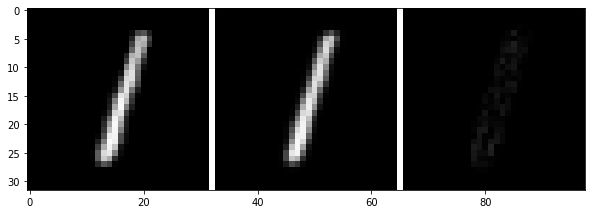

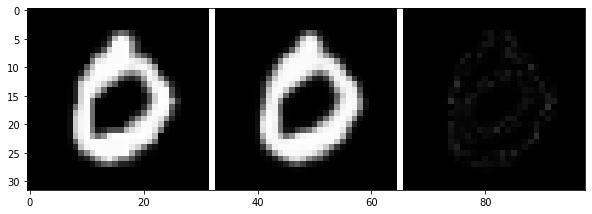

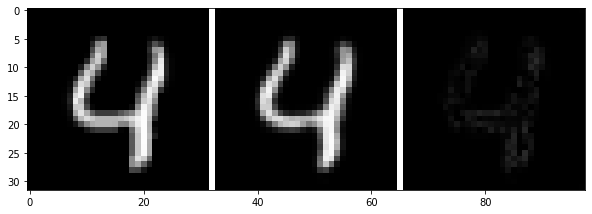

18/02/2020 20:06:34, epoch=116, step=13700, loss=0.00108, distortion=0.001, rate=0.406, -elbo=289.24829, nll=0.76041, KL=288.48788, commit_loss=57.62168, bit_usage=0.99914, highest_prob=0.005, temp=0.15147
18/02/2020 20:06:35, epoch=116, step=13720, loss=0.00106, distortion=0.001, rate=0.409, -elbo=290.97800, nll=0.73535, KL=290.24265, commit_loss=58.66886, bit_usage=0.99916, highest_prob=0.005, temp=0.15072
18/02/2020 20:06:36, epoch=116, step=13740, loss=0.00109, distortion=0.001, rate=0.409, -elbo=291.29605, nll=0.76954, KL=290.52652, commit_loss=57.97637, bit_usage=0.99916, highest_prob=0.005, temp=0.14997
18/02/2020 20:06:37, epoch=116, step=13760, loss=0.00106, distortion=0.001, rate=0.410, -elbo=291.79813, nll=0.73600, KL=291.06213, commit_loss=58.16059, bit_usage=0.99914, highest_prob=0.005, temp=0.14921
18/02/2020 20:06:38, epoch=116, step=13780, loss=0.00107, distortion=0.001, rate=0.410, -elbo=291.47049, nll=0.74591, KL=290.72458, commit_loss=57.85600, bit_usage=0.99911, hig

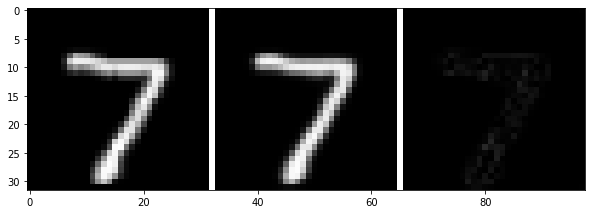

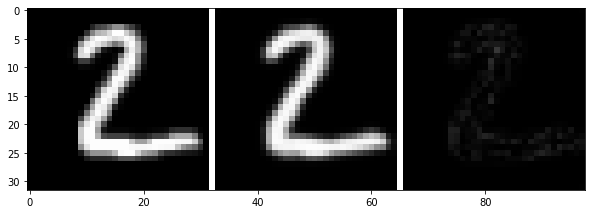

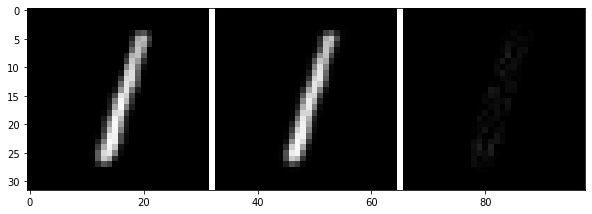

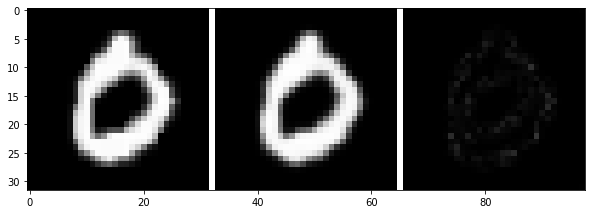

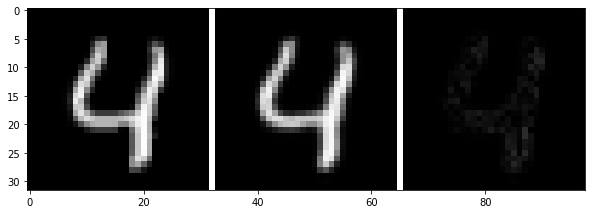

18/02/2020 20:07:09, epoch=121, step=14280, loss=0.00106, distortion=0.001, rate=0.416, -elbo=296.33279, nll=0.73083, KL=295.60196, commit_loss=57.99390, bit_usage=0.99904, highest_prob=0.006, temp=0.12965
18/02/2020 20:07:10, epoch=121, step=14300, loss=0.00104, distortion=0.001, rate=0.411, -elbo=292.30673, nll=0.71935, KL=291.58737, commit_loss=57.29569, bit_usage=0.99910, highest_prob=0.005, temp=0.12889
18/02/2020 20:07:11, epoch=121, step=14320, loss=0.00108, distortion=0.001, rate=0.418, -elbo=297.42444, nll=0.74676, KL=296.67767, commit_loss=59.10186, bit_usage=0.99925, highest_prob=0.005, temp=0.12814
18/02/2020 20:07:12, epoch=121, step=14340, loss=0.00107, distortion=0.001, rate=0.410, -elbo=291.98615, nll=0.74316, KL=291.24298, commit_loss=57.81409, bit_usage=0.99903, highest_prob=0.006, temp=0.12739
18/02/2020 20:07:13, epoch=121, step=14360, loss=0.00106, distortion=0.001, rate=0.412, -elbo=293.11453, nll=0.73904, KL=292.37549, commit_loss=57.46889, bit_usage=0.99887, hig

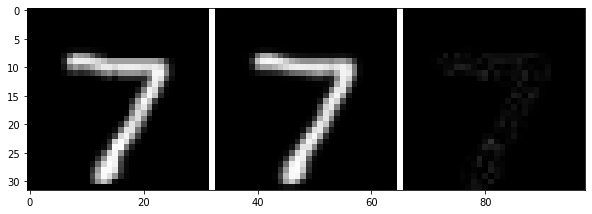

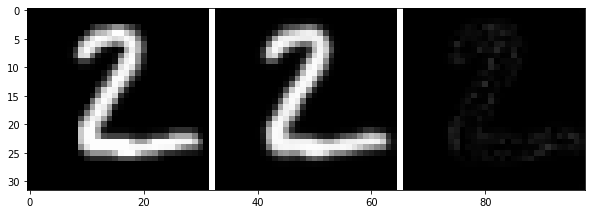

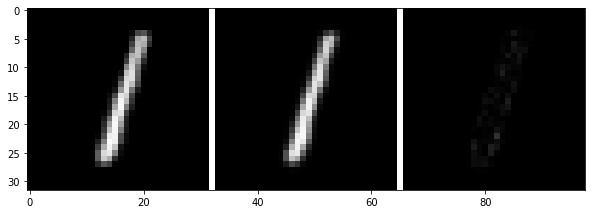

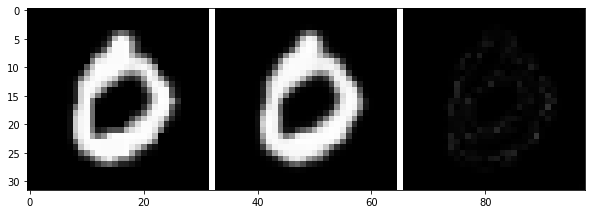

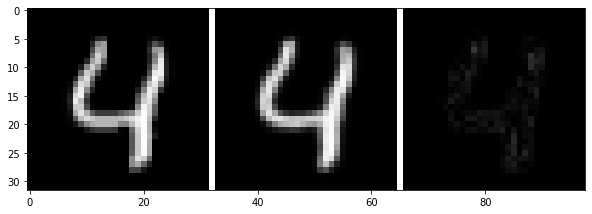

18/02/2020 20:07:44, epoch=126, step=14880, loss=0.00105, distortion=0.001, rate=0.416, -elbo=296.09900, nll=0.72108, KL=295.37793, commit_loss=57.42471, bit_usage=0.99917, highest_prob=0.006, temp=0.10707
18/02/2020 20:07:46, epoch=126, step=14900, loss=0.00107, distortion=0.001, rate=0.414, -elbo=294.28793, nll=0.74780, KL=293.54013, commit_loss=57.18182, bit_usage=0.99906, highest_prob=0.005, temp=0.10632
18/02/2020 20:07:47, epoch=126, step=14920, loss=0.00105, distortion=0.001, rate=0.419, -elbo=298.21405, nll=0.72315, KL=297.49091, commit_loss=58.15635, bit_usage=0.99912, highest_prob=0.005, temp=0.10557
18/02/2020 20:07:48, epoch=126, step=14940, loss=0.00106, distortion=0.001, rate=0.415, -elbo=295.05887, nll=0.73071, KL=294.32816, commit_loss=56.98948, bit_usage=0.99891, highest_prob=0.006, temp=0.10481
18/02/2020 20:07:49, epoch=126, step=14960, loss=0.00106, distortion=0.001, rate=0.418, -elbo=297.42789, nll=0.72775, KL=296.70013, commit_loss=57.97420, bit_usage=0.99902, hig

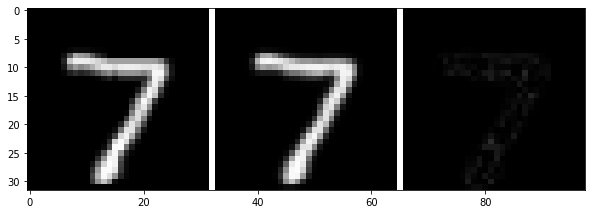

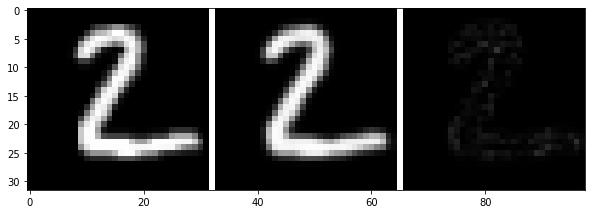

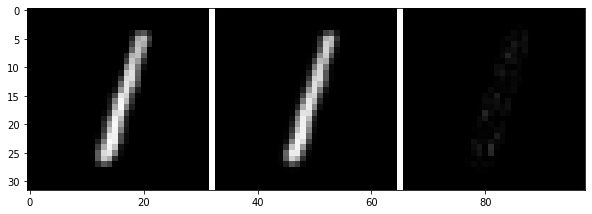

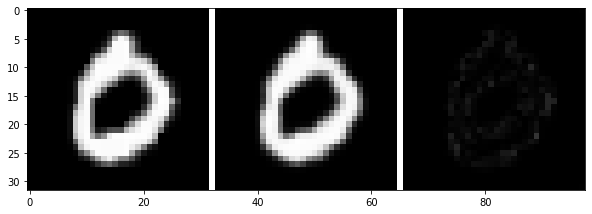

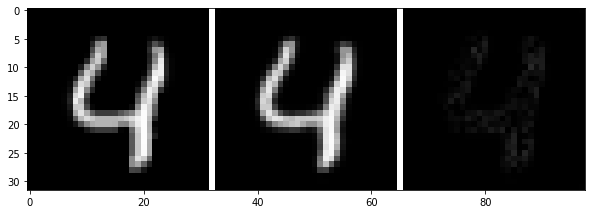

18/02/2020 20:08:20, epoch=131, step=15460, loss=0.00105, distortion=0.001, rate=0.418, -elbo=297.45276, nll=0.71733, KL=296.73541, commit_loss=57.16987, bit_usage=0.99901, highest_prob=0.006, temp=0.08525
18/02/2020 20:08:21, epoch=131, step=15480, loss=0.00104, distortion=0.001, rate=0.417, -elbo=296.41586, nll=0.71303, KL=295.70282, commit_loss=56.49120, bit_usage=0.99899, highest_prob=0.006, temp=0.08449
18/02/2020 20:08:22, epoch=131, step=15500, loss=0.00106, distortion=0.001, rate=0.419, -elbo=297.80621, nll=0.72598, KL=297.08023, commit_loss=57.52173, bit_usage=0.99893, highest_prob=0.006, temp=0.08374
18/02/2020 20:08:23, epoch=131, step=15520, loss=0.00106, distortion=0.001, rate=0.416, -elbo=296.13583, nll=0.72928, KL=295.40656, commit_loss=56.81414, bit_usage=0.99896, highest_prob=0.006, temp=0.08299
18/02/2020 20:08:24, epoch=131, step=15540, loss=0.00106, distortion=0.001, rate=0.414, -elbo=294.27365, nll=0.73856, KL=293.53510, commit_loss=55.90133, bit_usage=0.99891, hig

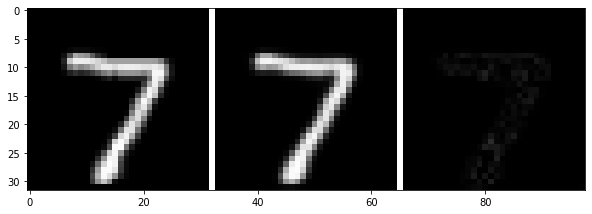

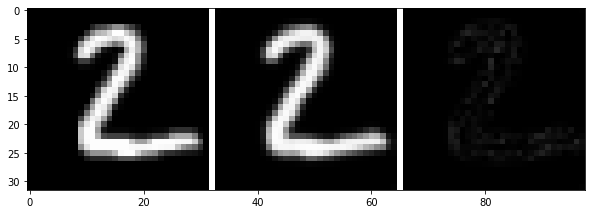

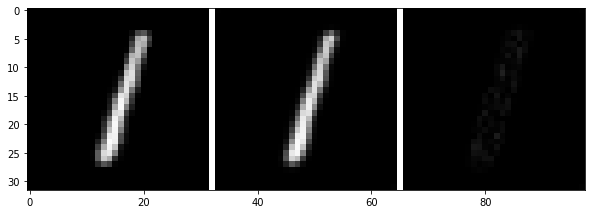

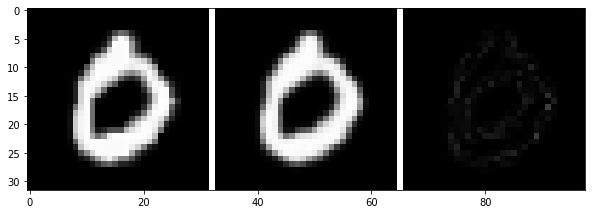

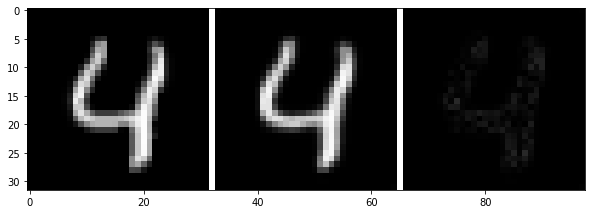

18/02/2020 20:08:56, epoch=136, step=16060, loss=0.00106, distortion=0.001, rate=0.416, -elbo=295.77875, nll=0.73229, KL=295.04645, commit_loss=56.00319, bit_usage=0.99888, highest_prob=0.006, temp=0.06267
18/02/2020 20:08:57, epoch=136, step=16080, loss=0.00105, distortion=0.001, rate=0.420, -elbo=298.96970, nll=0.72394, KL=298.24576, commit_loss=56.98692, bit_usage=0.99906, highest_prob=0.006, temp=0.06192
18/02/2020 20:08:58, epoch=136, step=16100, loss=0.00106, distortion=0.001, rate=0.422, -elbo=300.37549, nll=0.72870, KL=299.64679, commit_loss=57.60740, bit_usage=0.99894, highest_prob=0.006, temp=0.06117
18/02/2020 20:08:59, epoch=136, step=16120, loss=0.00107, distortion=0.001, rate=0.420, -elbo=298.99802, nll=0.73680, KL=298.26123, commit_loss=56.83524, bit_usage=0.99898, highest_prob=0.006, temp=0.06041
18/02/2020 20:09:00, epoch=136, step=16140, loss=0.00106, distortion=0.001, rate=0.421, -elbo=299.88623, nll=0.73150, KL=299.15472, commit_loss=57.01360, bit_usage=0.99910, hig

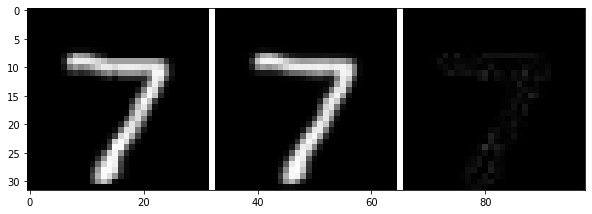

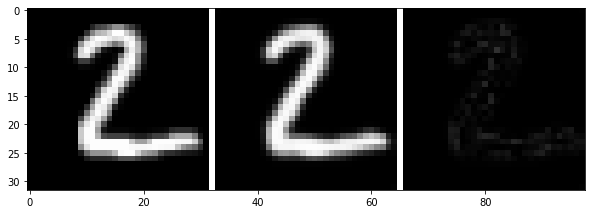

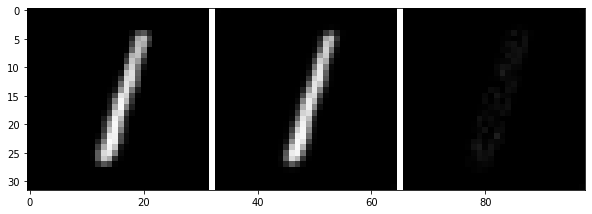

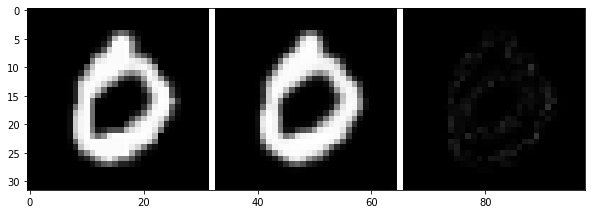

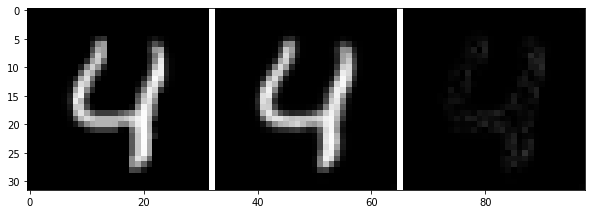

18/02/2020 20:09:31, epoch=141, step=16640, loss=0.00106, distortion=0.001, rate=0.419, -elbo=297.84286, nll=0.72847, KL=297.11441, commit_loss=56.51401, bit_usage=0.99901, highest_prob=0.006, temp=0.04085
18/02/2020 20:09:32, epoch=141, step=16660, loss=0.00104, distortion=0.001, rate=0.416, -elbo=295.68430, nll=0.71604, KL=294.96826, commit_loss=55.91507, bit_usage=0.99893, highest_prob=0.006, temp=0.04009
18/02/2020 20:09:33, epoch=141, step=16680, loss=0.00105, distortion=0.001, rate=0.420, -elbo=298.84918, nll=0.72433, KL=298.12485, commit_loss=56.52353, bit_usage=0.99902, highest_prob=0.006, temp=0.03934
18/02/2020 20:09:34, epoch=141, step=16700, loss=0.00104, distortion=0.001, rate=0.412, -elbo=293.10699, nll=0.71361, KL=292.39337, commit_loss=55.40992, bit_usage=0.99885, highest_prob=0.005, temp=0.03859
18/02/2020 20:09:35, epoch=141, step=16720, loss=0.00105, distortion=0.001, rate=0.413, -elbo=294.15497, nll=0.72857, KL=293.42639, commit_loss=55.46237, bit_usage=0.99890, hig

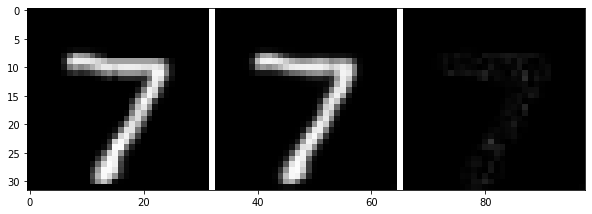

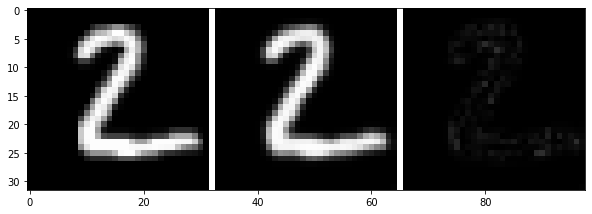

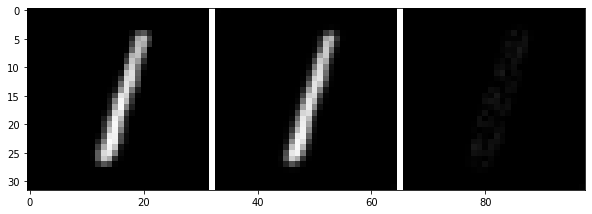

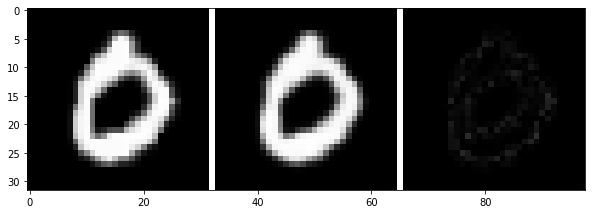

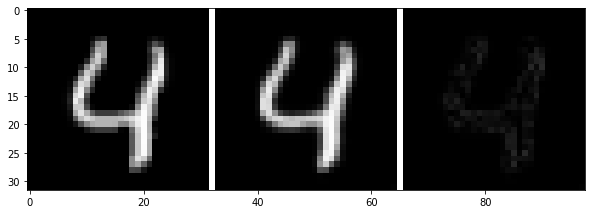

18/02/2020 20:10:07, epoch=146, step=17240, loss=0.00105, distortion=0.001, rate=0.418, -elbo=297.50327, nll=0.71965, KL=296.78363, commit_loss=56.34678, bit_usage=0.99895, highest_prob=0.006, temp=0.01827
18/02/2020 20:10:08, epoch=146, step=17260, loss=0.00101, distortion=0.001, rate=0.412, -elbo=293.41739, nll=0.68843, KL=292.72897, commit_loss=54.73499, bit_usage=0.99883, highest_prob=0.005, temp=0.01752
18/02/2020 20:10:09, epoch=146, step=17280, loss=0.00105, distortion=0.001, rate=0.417, -elbo=296.78592, nll=0.71927, KL=296.06665, commit_loss=56.05289, bit_usage=0.99901, highest_prob=0.006, temp=0.01677
18/02/2020 20:10:11, epoch=146, step=17300, loss=0.00105, distortion=0.001, rate=0.421, -elbo=299.45724, nll=0.72282, KL=298.73444, commit_loss=56.73839, bit_usage=0.99903, highest_prob=0.005, temp=0.01601
18/02/2020 20:10:12, epoch=146, step=17320, loss=0.00108, distortion=0.001, rate=0.421, -elbo=299.83130, nll=0.74744, KL=299.08386, commit_loss=56.80378, bit_usage=0.99893, hig

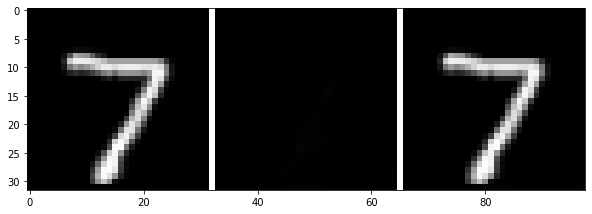

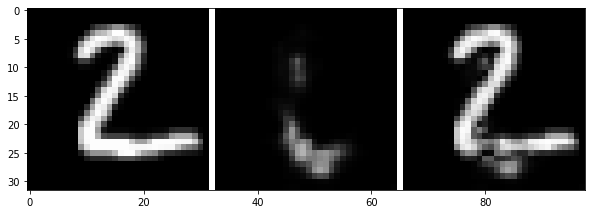

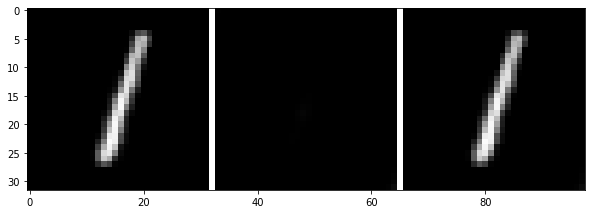

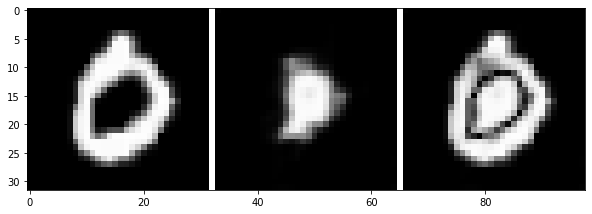

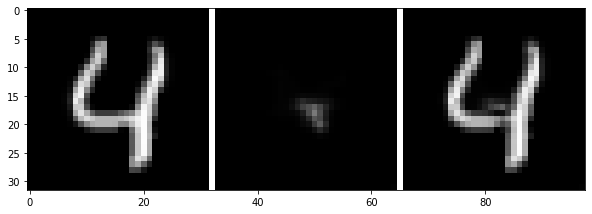

18/02/2020 20:10:40, epoch=1, step=120, loss=0.25370, distortion=0.366, rate=0.029, -elbo=4484.72412, nll=4154.00781, KL=330.71616, commit_loss=2222.73291, bit_usage=0.32361, highest_prob=0.241, temp=0.66245
reset code 48
pruned code 48 - 508 remain
18/02/2020 20:10:41, epoch=1, step=140, loss=0.18014, distortion=0.260, rate=0.030, -elbo=3283.96875, nll=2948.82788, KL=335.14093, commit_loss=2188.36597, bit_usage=0.31042, highest_prob=0.254, temp=0.66169
reset code 48
18/02/2020 20:10:42, epoch=1, step=160, loss=0.13535, distortion=0.195, rate=0.029, -elbo=2539.71484, nll=2215.11401, KL=324.60074, commit_loss=2193.36182, bit_usage=0.34297, highest_prob=0.240, temp=0.66094
reset code 64
pruned code 64 - 507 remain
18/02/2020 20:10:43, epoch=1, step=180, loss=0.11421, distortion=0.165, rate=0.029, -elbo=2192.45166, nll=1868.65674, KL=323.79504, commit_loss=2210.24854, bit_usage=0.34640, highest_prob=0.240, temp=0.66019
reset code 64
18/02/2020 20:10:43, epoch=1, step=200, loss=0.09949, di

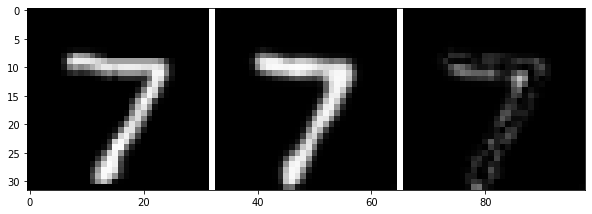

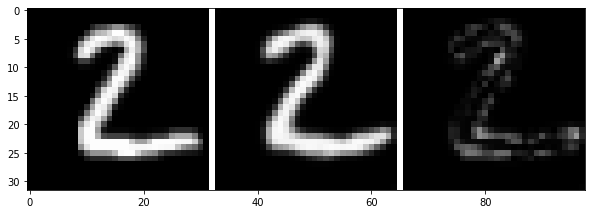

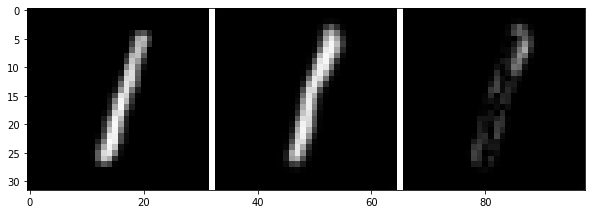

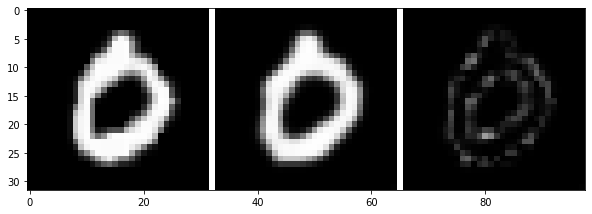

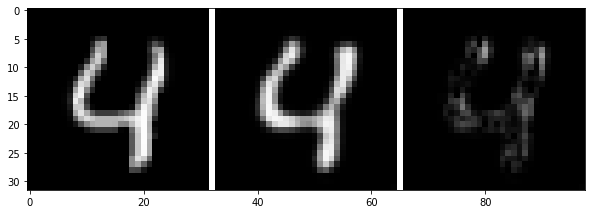

18/02/2020 20:11:06, epoch=6, step=720, loss=0.03733, distortion=0.054, rate=0.023, -elbo=873.18939, nll=608.77795, KL=264.41144, commit_loss=2544.54590, bit_usage=0.59520, highest_prob=0.056, temp=0.63987
reset code 320
pruned code 320 - 493 remain
18/02/2020 20:11:07, epoch=6, step=740, loss=0.03647, distortion=0.052, rate=0.023, -elbo=860.07642, nll=594.73621, KL=265.34024, commit_loss=2565.01123, bit_usage=0.59530, highest_prob=0.057, temp=0.63912
reset code 288
18/02/2020 20:11:08, epoch=6, step=760, loss=0.03460, distortion=0.050, rate=0.023, -elbo=826.67554, nll=564.07849, KL=262.59705, commit_loss=2569.05811, bit_usage=0.59970, highest_prob=0.052, temp=0.63837
reset code 320
pruned code 320 - 492 remain
18/02/2020 20:11:09, epoch=6, step=780, loss=0.03465, distortion=0.050, rate=0.023, -elbo=827.95398, nll=564.85278, KL=263.10120, commit_loss=2579.99463, bit_usage=0.60141, highest_prob=0.053, temp=0.63761
reset code 320
18/02/2020 20:11:10, epoch=6, step=800, loss=0.03360, dist

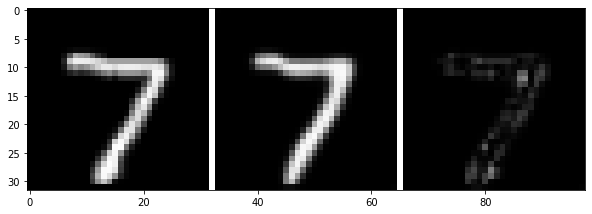

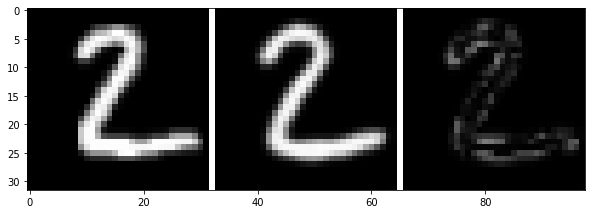

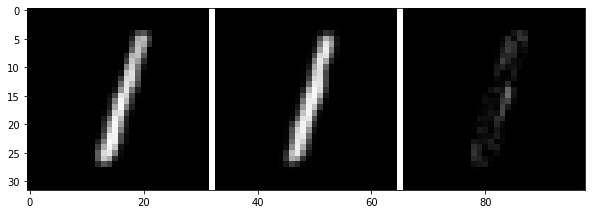

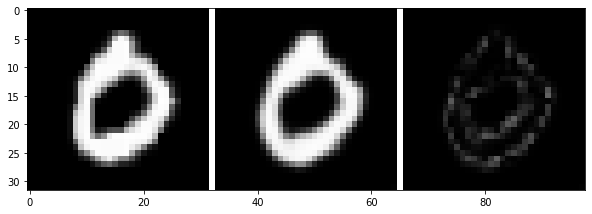

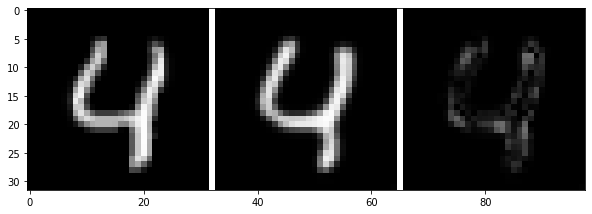

18/02/2020 20:11:32, epoch=11, step=1300, loss=0.02446, distortion=0.035, rate=0.023, -elbo=658.52844, nll=397.69073, KL=260.83771, commit_loss=2768.06934, bit_usage=0.65228, highest_prob=0.064, temp=0.61805
reset code 80
18/02/2020 20:11:33, epoch=11, step=1320, loss=0.02393, distortion=0.034, rate=0.023, -elbo=649.88562, nll=388.98157, KL=260.90405, commit_loss=2774.72119, bit_usage=0.65410, highest_prob=0.060, temp=0.61729
reset code 96
pruned code 96 - 478 remain
18/02/2020 20:11:34, epoch=11, step=1340, loss=0.02319, distortion=0.033, rate=0.023, -elbo=638.09149, nll=376.89642, KL=261.19507, commit_loss=2782.77637, bit_usage=0.65575, highest_prob=0.062, temp=0.61654
reset code 96
18/02/2020 20:11:35, epoch=11, step=1360, loss=0.02338, distortion=0.033, rate=0.023, -elbo=639.40466, nll=380.01520, KL=259.38943, commit_loss=2775.49438, bit_usage=0.66089, highest_prob=0.058, temp=0.61579
reset code 112
pruned code 112 - 477 remain
18/02/2020 20:11:36, epoch=11, step=1380, loss=0.02342

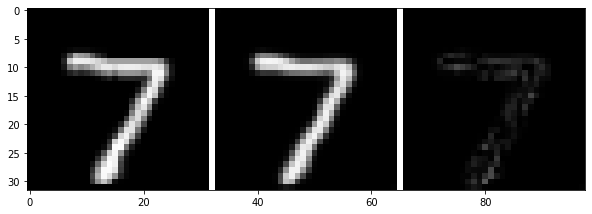

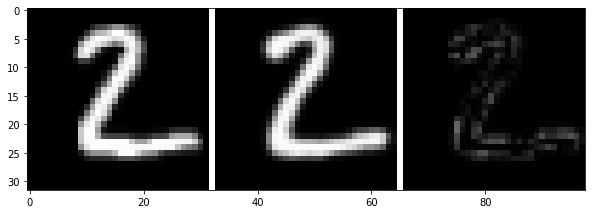

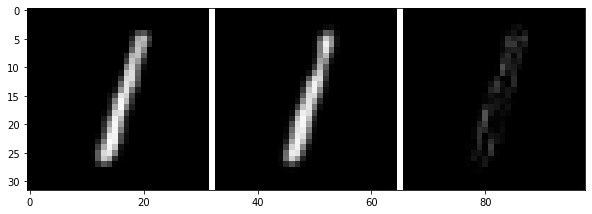

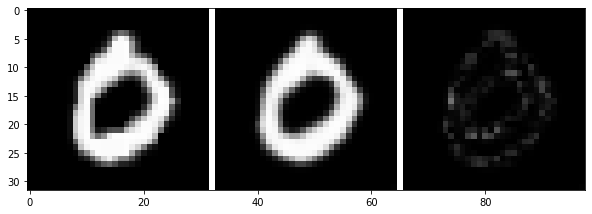

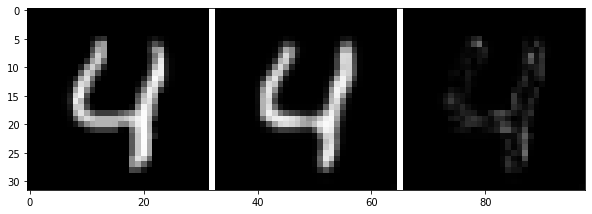

18/02/2020 20:11:58, epoch=16, step=1900, loss=0.01913, distortion=0.027, rate=0.024, -elbo=582.50104, nll=310.35266, KL=272.14838, commit_loss=2765.97217, bit_usage=0.67083, highest_prob=0.071, temp=0.59547
reset code 64
18/02/2020 20:11:59, epoch=16, step=1920, loss=0.01929, distortion=0.028, rate=0.024, -elbo=585.43665, nll=313.03729, KL=272.39932, commit_loss=2763.25464, bit_usage=0.67321, highest_prob=0.075, temp=0.59472
reset code 80
pruned code 80 - 463 remain
18/02/2020 20:12:00, epoch=16, step=1940, loss=0.01903, distortion=0.027, rate=0.024, -elbo=580.87805, nll=308.71939, KL=272.15869, commit_loss=2760.53125, bit_usage=0.67562, highest_prob=0.083, temp=0.59397
reset code 80
18/02/2020 20:12:01, epoch=16, step=1960, loss=0.01846, distortion=0.026, rate=0.024, -elbo=567.76062, nll=299.39417, KL=268.36646, commit_loss=2768.85303, bit_usage=0.68611, highest_prob=0.058, temp=0.59321
reset code 96
pruned code 96 - 462 remain
18/02/2020 20:12:01, epoch=16, step=1980, loss=0.01836, 

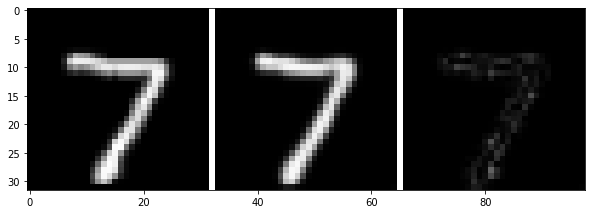

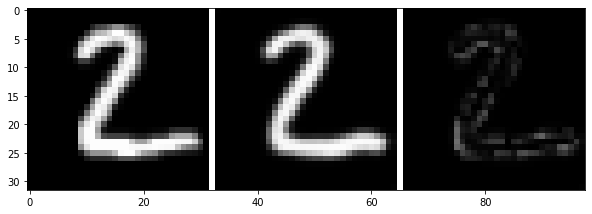

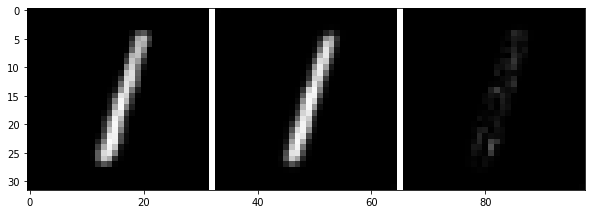

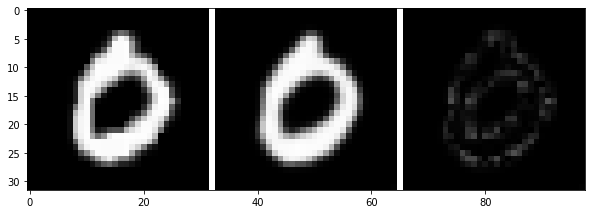

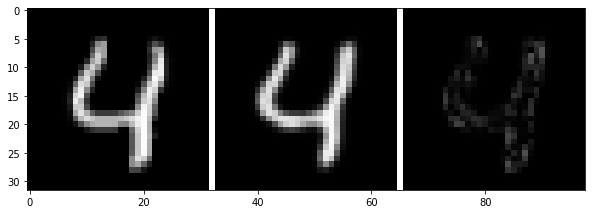

18/02/2020 20:12:24, epoch=21, step=2480, loss=0.01618, distortion=0.023, rate=0.023, -elbo=527.78125, nll=262.11014, KL=265.67114, commit_loss=2724.20605, bit_usage=0.72218, highest_prob=0.044, temp=0.57365
reset code 48
pruned code 48 - 449 remain
18/02/2020 20:12:24, epoch=21, step=2500, loss=0.01599, distortion=0.023, rate=0.023, -elbo=525.36951, nll=259.02518, KL=266.34430, commit_loss=2713.72900, bit_usage=0.71944, highest_prob=0.056, temp=0.57289
reset code 48
18/02/2020 20:12:25, epoch=21, step=2520, loss=0.01563, distortion=0.022, rate=0.023, -elbo=519.07733, nll=253.12340, KL=265.95392, commit_loss=2723.88574, bit_usage=0.72010, highest_prob=0.051, temp=0.57214
reset code 64
pruned code 64 - 448 remain
18/02/2020 20:12:26, epoch=21, step=2540, loss=0.01555, distortion=0.022, rate=0.024, -elbo=518.89697, nll=251.86475, KL=267.03223, commit_loss=2710.70557, bit_usage=0.71931, highest_prob=0.049, temp=0.57139
reset code 64
18/02/2020 20:12:27, epoch=21, step=2560, loss=0.01560, 

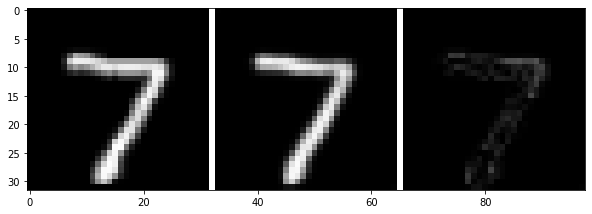

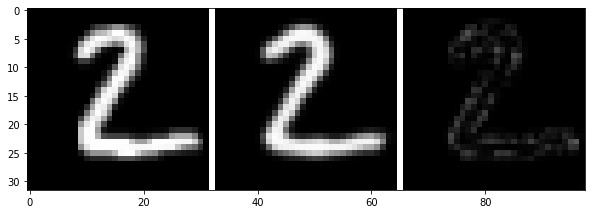

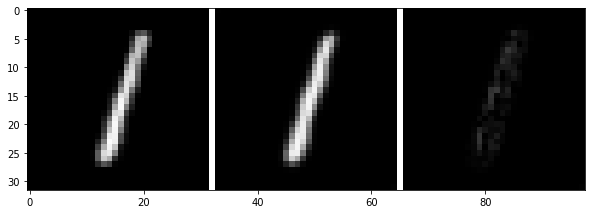

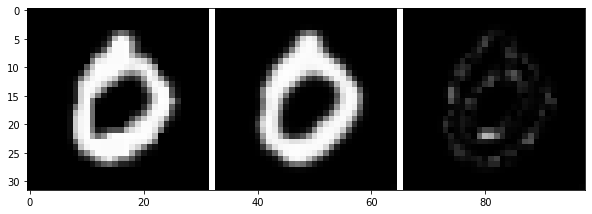

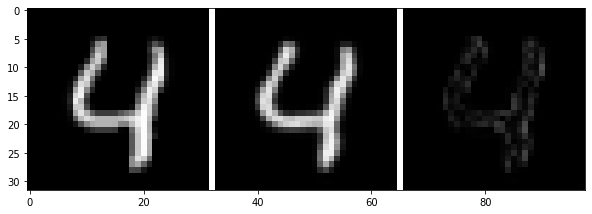

18/02/2020 20:12:50, epoch=26, step=3080, loss=0.01429, distortion=0.020, rate=0.024, -elbo=499.09674, nll=231.18350, KL=267.91324, commit_loss=2670.72949, bit_usage=0.72655, highest_prob=0.058, temp=0.55107
reset code 48
pruned code 48 - 434 remain
18/02/2020 20:12:51, epoch=26, step=3100, loss=0.01413, distortion=0.020, rate=0.024, -elbo=496.82471, nll=228.53622, KL=268.28848, commit_loss=2669.67285, bit_usage=0.72371, highest_prob=0.073, temp=0.55032
reset code 48
18/02/2020 20:12:52, epoch=26, step=3120, loss=0.01418, distortion=0.020, rate=0.024, -elbo=496.38971, nll=229.39622, KL=266.99350, commit_loss=2668.43872, bit_usage=0.72783, highest_prob=0.054, temp=0.54957
reset code 64
pruned code 64 - 433 remain
18/02/2020 20:12:52, epoch=26, step=3140, loss=0.01437, distortion=0.020, rate=0.024, -elbo=501.35886, nll=232.55518, KL=268.80368, commit_loss=2660.32520, bit_usage=0.72555, highest_prob=0.057, temp=0.54881
reset code 64
18/02/2020 20:12:53, epoch=26, step=3160, loss=0.01398, 

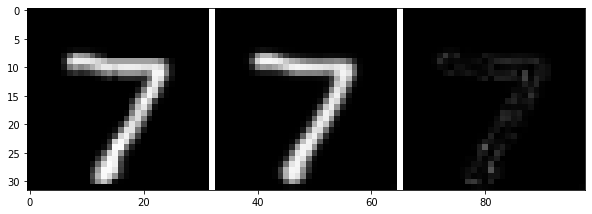

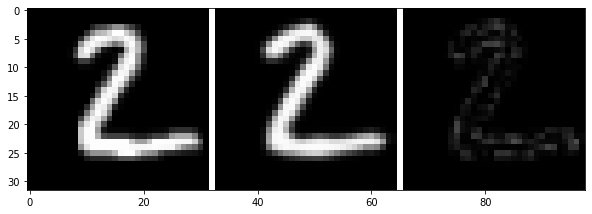

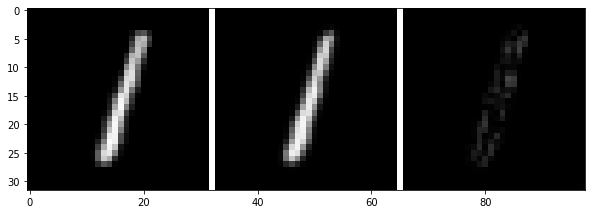

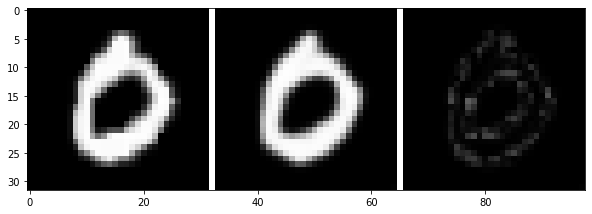

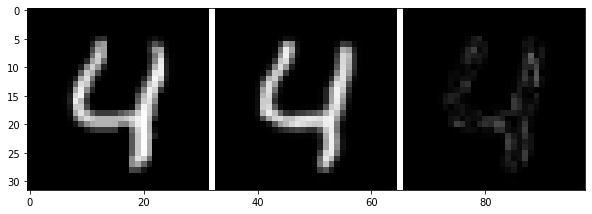

18/02/2020 20:13:15, epoch=31, step=3660, loss=0.01303, distortion=0.019, rate=0.024, -elbo=478.52612, nll=210.59894, KL=267.92719, commit_loss=2629.70386, bit_usage=0.74477, highest_prob=0.050, temp=0.52925
reset code 24
18/02/2020 20:13:16, epoch=31, step=3680, loss=0.01291, distortion=0.018, rate=0.023, -elbo=474.53943, nll=208.65538, KL=265.88403, commit_loss=2630.74097, bit_usage=0.74916, highest_prob=0.042, temp=0.52849
reset code 40
pruned code 40 - 419 remain
18/02/2020 20:13:17, epoch=31, step=3700, loss=0.01321, distortion=0.019, rate=0.024, -elbo=481.06049, nll=213.61192, KL=267.44855, commit_loss=2632.64746, bit_usage=0.74647, highest_prob=0.045, temp=0.52774
reset code 48
18/02/2020 20:13:18, epoch=31, step=3720, loss=0.01281, distortion=0.018, rate=0.023, -elbo=473.53760, nll=207.03412, KL=266.50348, commit_loss=2613.38086, bit_usage=0.74581, highest_prob=0.043, temp=0.52699
reset code 80
pruned code 80 - 418 remain
18/02/2020 20:13:18, epoch=31, step=3740, loss=0.01276, 

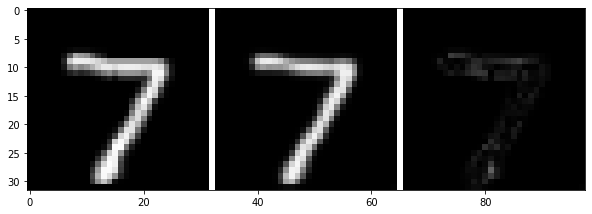

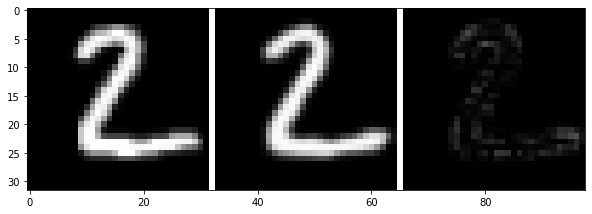

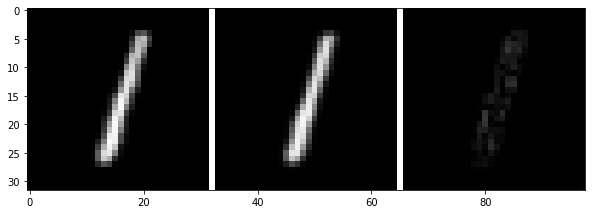

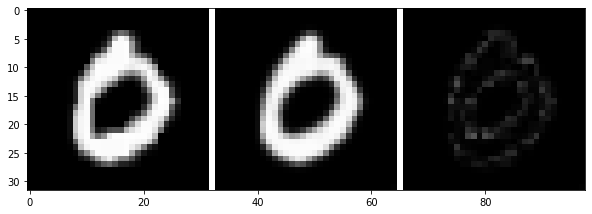

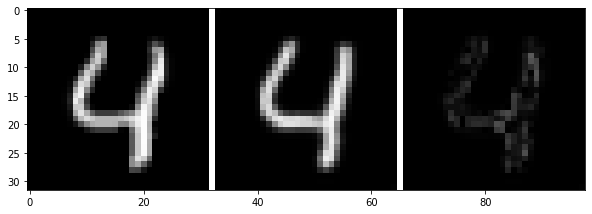

18/02/2020 20:13:41, epoch=36, step=4260, loss=0.01206, distortion=0.017, rate=0.024, -elbo=462.51804, nll=194.66760, KL=267.85043, commit_loss=2580.87256, bit_usage=0.75916, highest_prob=0.037, temp=0.50667
reset code 368
18/02/2020 20:13:42, epoch=36, step=4280, loss=0.01199, distortion=0.017, rate=0.024, -elbo=463.22092, nll=193.64542, KL=269.57550, commit_loss=2578.53174, bit_usage=0.75719, highest_prob=0.040, temp=0.50592
reset code 384
pruned code 384 - 404 remain
18/02/2020 20:13:43, epoch=36, step=4300, loss=0.01204, distortion=0.017, rate=0.024, -elbo=464.50079, nll=194.36487, KL=270.13593, commit_loss=2583.53101, bit_usage=0.75333, highest_prob=0.038, temp=0.50517
reset code 56
18/02/2020 20:13:44, epoch=36, step=4320, loss=0.01217, distortion=0.017, rate=0.024, -elbo=468.62238, nll=196.60561, KL=272.01675, commit_loss=2578.04956, bit_usage=0.75471, highest_prob=0.044, temp=0.50441
reset code 88
pruned code 88 - 403 remain
18/02/2020 20:13:44, epoch=36, step=4340, loss=0.0116

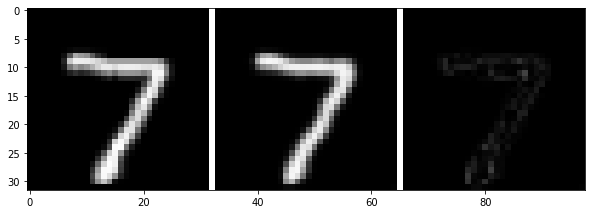

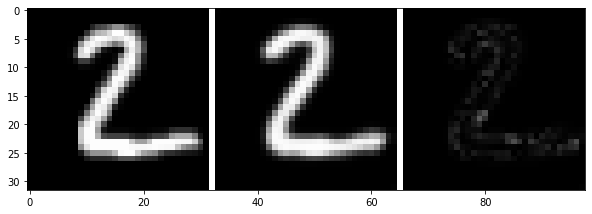

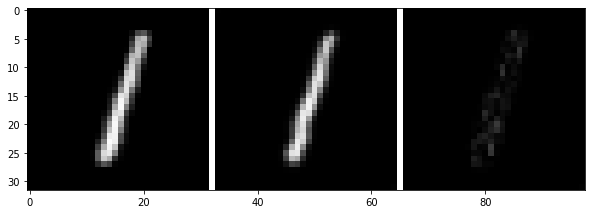

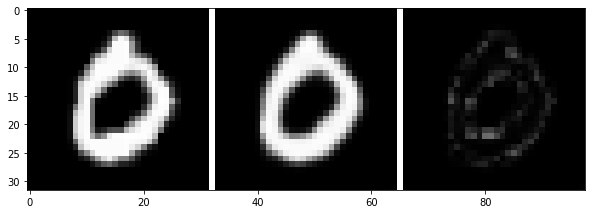

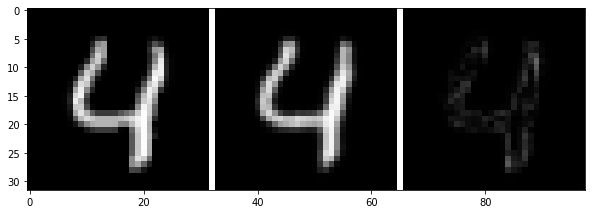

18/02/2020 20:14:06, epoch=41, step=4840, loss=0.01122, distortion=0.016, rate=0.023, -elbo=444.47995, nll=181.00394, KL=263.47601, commit_loss=2532.72266, bit_usage=0.78437, highest_prob=0.035, temp=0.48485
reset code 176
pruned code 176 - 390 remain
18/02/2020 20:14:07, epoch=41, step=4860, loss=0.01100, distortion=0.016, rate=0.023, -elbo=440.94440, nll=177.48816, KL=263.45624, commit_loss=2533.62158, bit_usage=0.78607, highest_prob=0.038, temp=0.48409
reset code 176
18/02/2020 20:14:08, epoch=41, step=4880, loss=0.01133, distortion=0.016, rate=0.023, -elbo=446.63611, nll=182.77525, KL=263.86084, commit_loss=2530.68506, bit_usage=0.78690, highest_prob=0.035, temp=0.48334
reset code 192
pruned code 192 - 389 remain
18/02/2020 20:14:08, epoch=41, step=4900, loss=0.01136, distortion=0.016, rate=0.023, -elbo=448.03070, nll=183.26318, KL=264.76752, commit_loss=2550.01416, bit_usage=0.78662, highest_prob=0.032, temp=0.48259
reset code 192
18/02/2020 20:14:09, epoch=41, step=4920, loss=0.0

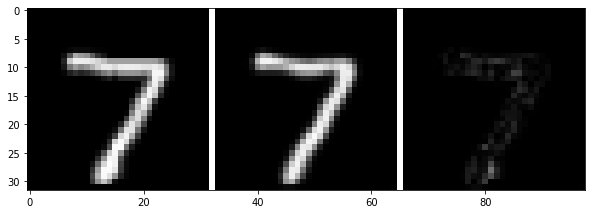

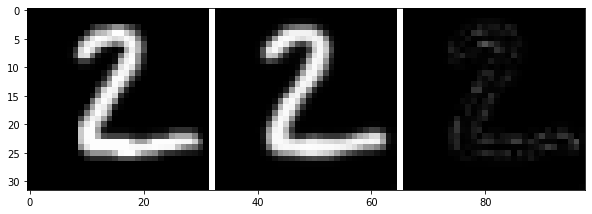

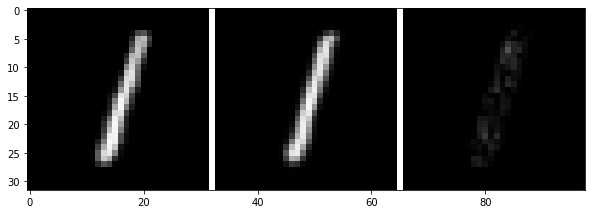

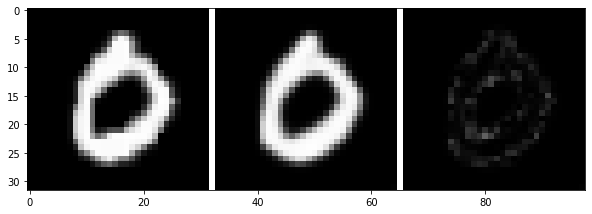

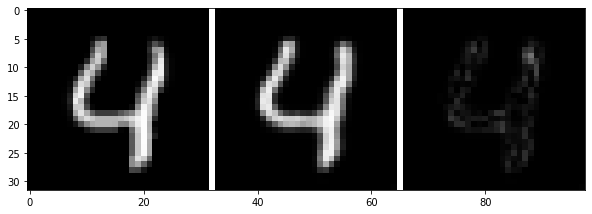

18/02/2020 20:14:31, epoch=46, step=5440, loss=0.01083, distortion=0.015, rate=0.023, -elbo=430.31500, nll=174.63892, KL=255.67610, commit_loss=2488.76001, bit_usage=0.81960, highest_prob=0.025, temp=0.46227
reset code 304
pruned code 304 - 375 remain
18/02/2020 20:14:32, epoch=46, step=5460, loss=0.01063, distortion=0.015, rate=0.022, -elbo=426.08350, nll=171.47612, KL=254.60736, commit_loss=2476.77368, bit_usage=0.81792, highest_prob=0.027, temp=0.46152
reset code 320
18/02/2020 20:14:33, epoch=46, step=5480, loss=0.01080, distortion=0.015, rate=0.022, -elbo=428.94714, nll=174.19817, KL=254.74896, commit_loss=2482.46118, bit_usage=0.82057, highest_prob=0.023, temp=0.46077
reset code 368
pruned code 368 - 374 remain
18/02/2020 20:14:34, epoch=46, step=5500, loss=0.01085, distortion=0.015, rate=0.022, -elbo=430.43753, nll=175.09555, KL=255.34198, commit_loss=2486.40283, bit_usage=0.81960, highest_prob=0.024, temp=0.46001
reset code 208
18/02/2020 20:14:34, epoch=46, step=5520, loss=0.0

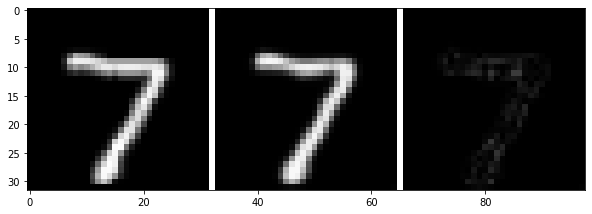

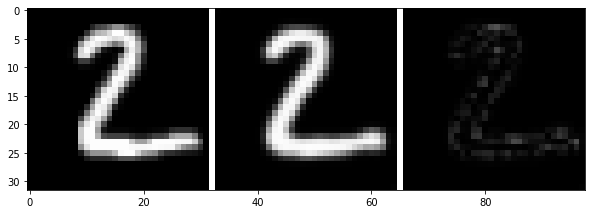

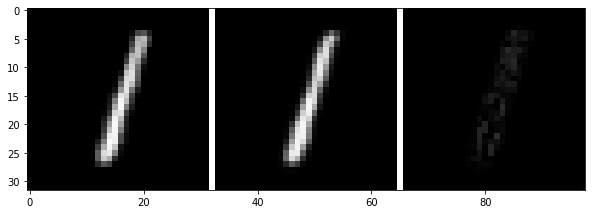

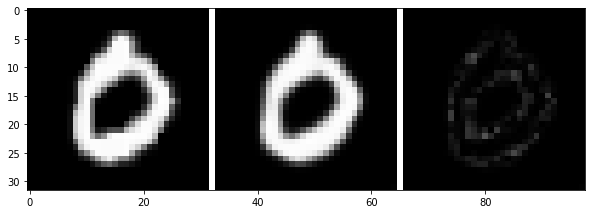

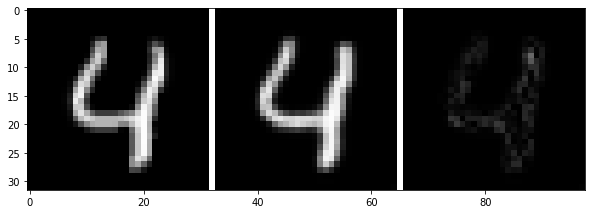

18/02/2020 20:14:56, epoch=51, step=6020, loss=0.01030, distortion=0.015, rate=0.022, -elbo=415.83344, nll=166.01527, KL=249.81816, commit_loss=2432.92505, bit_usage=0.83985, highest_prob=0.025, temp=0.44045
reset code 256
18/02/2020 20:14:57, epoch=51, step=6040, loss=0.01031, distortion=0.015, rate=0.022, -elbo=418.19727, nll=166.23991, KL=251.95737, commit_loss=2425.23706, bit_usage=0.83714, highest_prob=0.023, temp=0.43969
reset code 272
pruned code 272 - 360 remain
18/02/2020 20:14:58, epoch=51, step=6060, loss=0.01012, distortion=0.014, rate=0.022, -elbo=413.28674, nll=163.17636, KL=250.11038, commit_loss=2425.44849, bit_usage=0.83978, highest_prob=0.028, temp=0.43894
reset code 320
18/02/2020 20:14:59, epoch=51, step=6080, loss=0.01035, distortion=0.015, rate=0.022, -elbo=417.58313, nll=166.97696, KL=250.60616, commit_loss=2426.17480, bit_usage=0.84288, highest_prob=0.022, temp=0.43819
reset code 336
pruned code 336 - 359 remain
18/02/2020 20:14:59, epoch=51, step=6100, loss=0.0

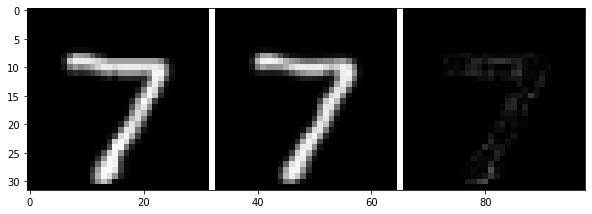

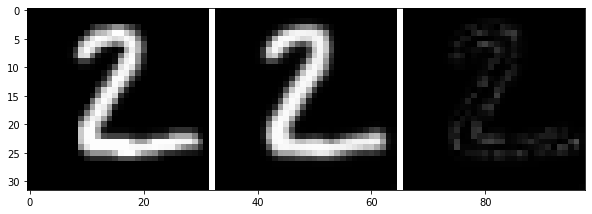

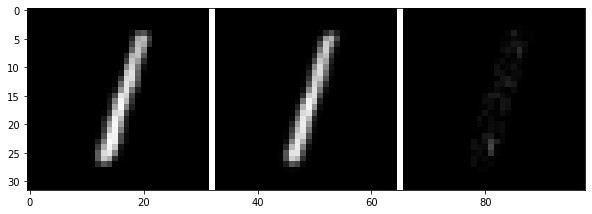

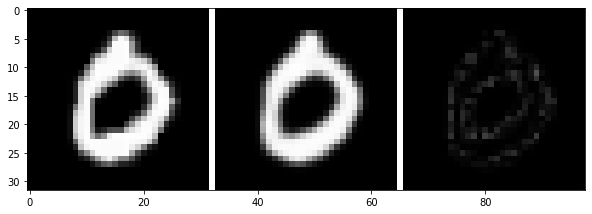

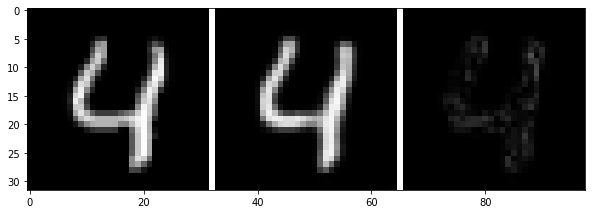

18/02/2020 20:15:21, epoch=56, step=6620, loss=0.00989, distortion=0.014, rate=0.022, -elbo=409.75653, nll=159.33849, KL=250.41803, commit_loss=2373.32153, bit_usage=0.84970, highest_prob=0.021, temp=0.41787
reset code 240
18/02/2020 20:15:22, epoch=56, step=6640, loss=0.01002, distortion=0.014, rate=0.022, -elbo=410.48175, nll=161.52422, KL=248.95752, commit_loss=2377.04639, bit_usage=0.85304, highest_prob=0.020, temp=0.41712
reset code 272
pruned code 272 - 345 remain
18/02/2020 20:15:23, epoch=56, step=6660, loss=0.00972, distortion=0.014, rate=0.022, -elbo=405.84576, nll=156.63730, KL=249.20847, commit_loss=2384.78247, bit_usage=0.85288, highest_prob=0.021, temp=0.41637
reset code 272
18/02/2020 20:15:23, epoch=56, step=6680, loss=0.00977, distortion=0.014, rate=0.022, -elbo=405.74655, nll=157.44034, KL=248.30621, commit_loss=2367.02979, bit_usage=0.85285, highest_prob=0.018, temp=0.41561
reset code 288
pruned code 288 - 344 remain
18/02/2020 20:15:24, epoch=56, step=6700, loss=0.0

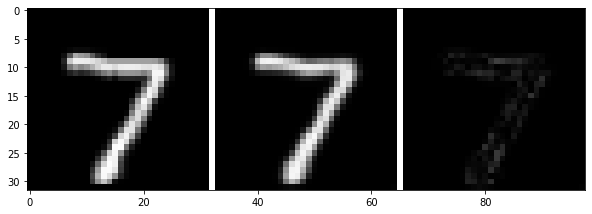

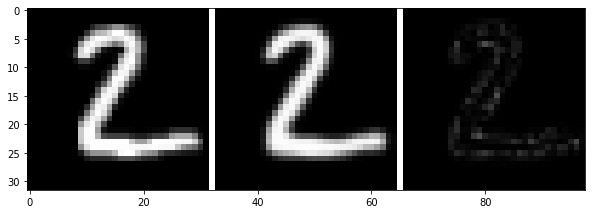

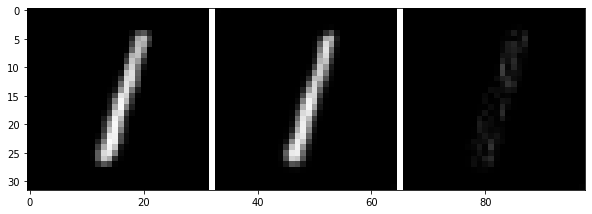

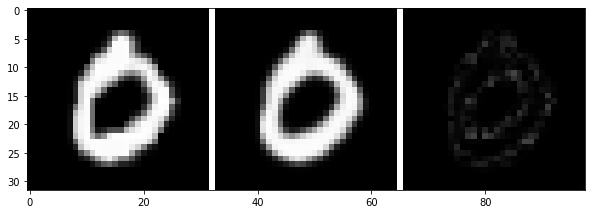

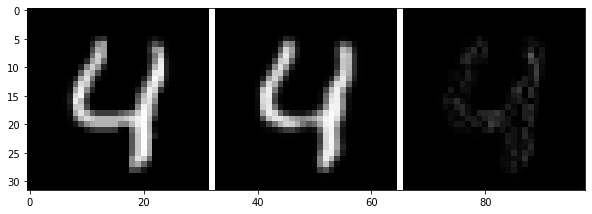

18/02/2020 20:15:45, epoch=61, step=7200, loss=0.00987, distortion=0.014, rate=0.022, -elbo=412.22028, nll=159.17096, KL=253.04930, commit_loss=2328.84888, bit_usage=0.84896, highest_prob=0.026, temp=0.39605
reset code 64
pruned code 64 - 331 remain
18/02/2020 20:15:46, epoch=61, step=7220, loss=0.00936, distortion=0.013, rate=0.022, -elbo=404.21356, nll=150.82959, KL=253.38396, commit_loss=2332.46729, bit_usage=0.84940, highest_prob=0.028, temp=0.39529
reset code 112
18/02/2020 20:15:47, epoch=61, step=7240, loss=0.00987, distortion=0.014, rate=0.022, -elbo=412.89764, nll=159.04478, KL=253.85284, commit_loss=2333.58350, bit_usage=0.84950, highest_prob=0.022, temp=0.39454
reset code 128
pruned code 128 - 330 remain
18/02/2020 20:15:47, epoch=61, step=7260, loss=0.00949, distortion=0.013, rate=0.022, -elbo=406.85593, nll=152.88933, KL=253.96660, commit_loss=2319.13452, bit_usage=0.84728, highest_prob=0.024, temp=0.39379
reset code 176
18/02/2020 20:15:48, epoch=61, step=7280, loss=0.009

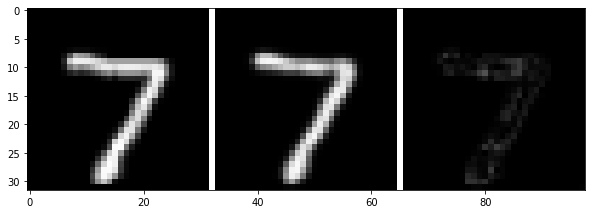

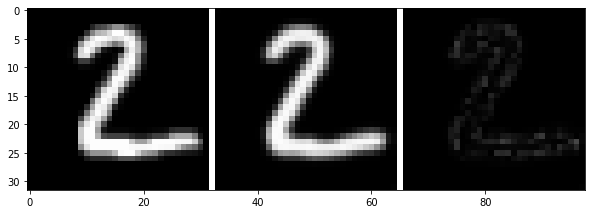

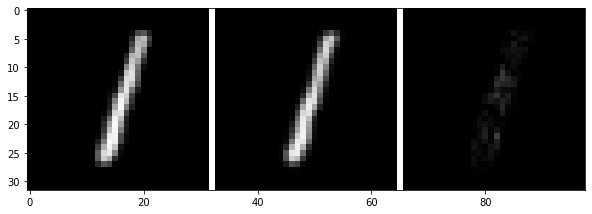

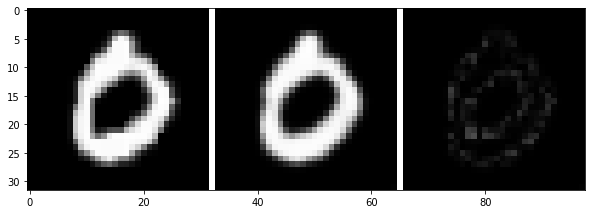

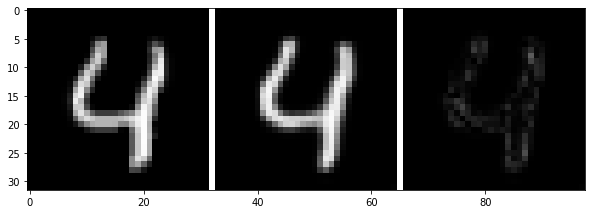

18/02/2020 20:16:10, epoch=66, step=7800, loss=0.00929, distortion=0.013, rate=0.022, -elbo=401.90155, nll=149.59735, KL=252.30421, commit_loss=2291.47559, bit_usage=0.86266, highest_prob=0.020, temp=0.37347
reset code 24
pruned code 24 - 316 remain
18/02/2020 20:16:10, epoch=66, step=7820, loss=0.00914, distortion=0.013, rate=0.022, -elbo=400.90720, nll=147.13159, KL=253.77560, commit_loss=2301.96143, bit_usage=0.86012, highest_prob=0.023, temp=0.37272
reset code 32
18/02/2020 20:16:11, epoch=66, step=7840, loss=0.00923, distortion=0.013, rate=0.022, -elbo=400.36481, nll=148.69978, KL=251.66504, commit_loss=2310.44385, bit_usage=0.86366, highest_prob=0.020, temp=0.37197
reset code 48
pruned code 48 - 315 remain
18/02/2020 20:16:12, epoch=66, step=7860, loss=0.00932, distortion=0.013, rate=0.022, -elbo=402.89319, nll=150.18521, KL=252.70799, commit_loss=2304.40674, bit_usage=0.86296, highest_prob=0.021, temp=0.37121
reset code 48
18/02/2020 20:16:13, epoch=66, step=7880, loss=0.00951, 

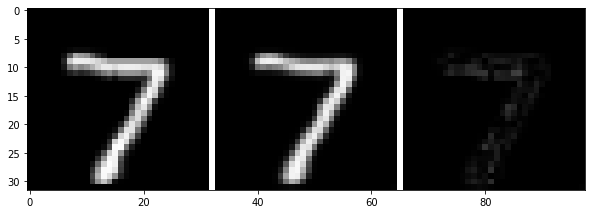

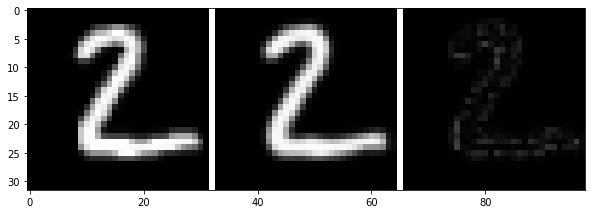

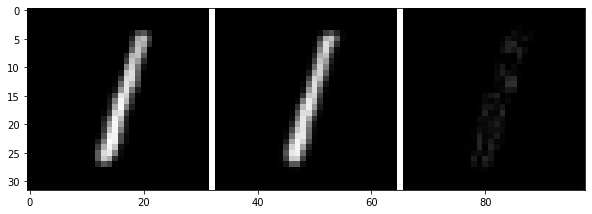

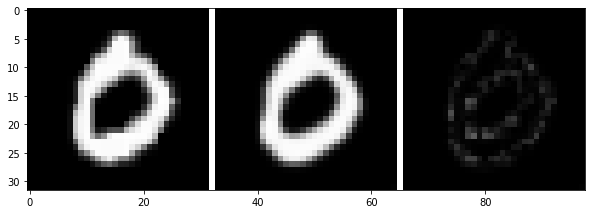

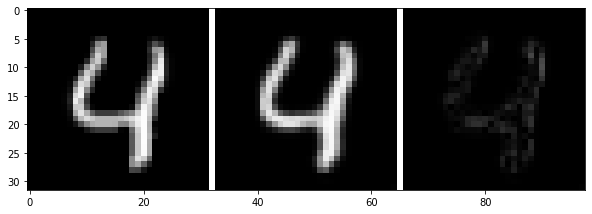

18/02/2020 20:16:32, epoch=71, step=8380, loss=0.00913, distortion=0.013, rate=0.022, -elbo=398.09137, nll=147.16342, KL=250.92795, commit_loss=2240.34448, bit_usage=0.87144, highest_prob=0.021, temp=0.35165
reset code 240
18/02/2020 20:16:32, epoch=71, step=8400, loss=0.00899, distortion=0.013, rate=0.022, -elbo=395.43219, nll=144.83156, KL=250.60062, commit_loss=2245.56543, bit_usage=0.87119, highest_prob=0.019, temp=0.35089
reset code 256
pruned code 256 - 301 remain
18/02/2020 20:16:33, epoch=71, step=8420, loss=0.00913, distortion=0.013, rate=0.022, -elbo=397.75745, nll=147.12848, KL=250.62897, commit_loss=2263.48242, bit_usage=0.87312, highest_prob=0.019, temp=0.35014
reset code 256
18/02/2020 20:16:34, epoch=71, step=8440, loss=0.00913, distortion=0.013, rate=0.022, -elbo=398.00516, nll=147.14563, KL=250.85953, commit_loss=2265.70752, bit_usage=0.87420, highest_prob=0.017, temp=0.34939
reset code 272
pruned code 272 - 300 remain
18/02/2020 20:16:34, epoch=71, step=8460, loss=0.0

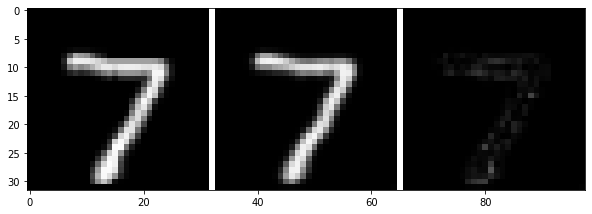

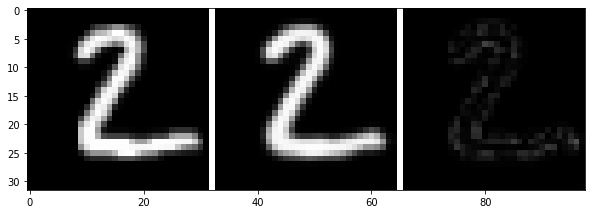

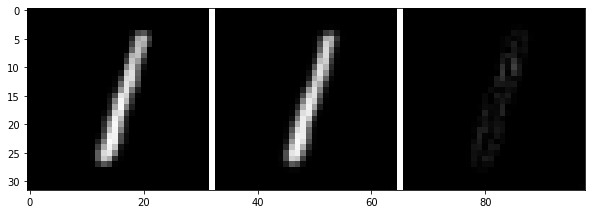

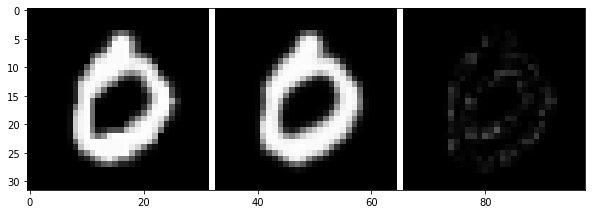

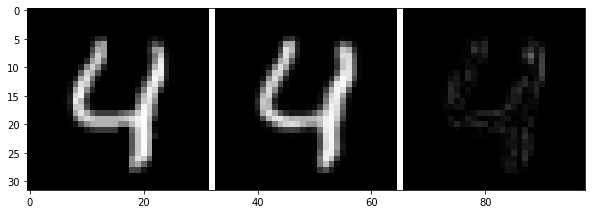

18/02/2020 20:16:54, epoch=76, step=8980, loss=0.00885, distortion=0.013, rate=0.022, -elbo=392.14865, nll=142.55963, KL=249.58902, commit_loss=2231.07764, bit_usage=0.87796, highest_prob=0.026, temp=0.32907
reset code 80
18/02/2020 20:16:54, epoch=76, step=9000, loss=0.00911, distortion=0.013, rate=0.022, -elbo=396.08771, nll=146.79266, KL=249.29506, commit_loss=2232.03320, bit_usage=0.87953, highest_prob=0.020, temp=0.32832
reset code 176
pruned code 176 - 286 remain
18/02/2020 20:16:55, epoch=76, step=9020, loss=0.00890, distortion=0.013, rate=0.022, -elbo=392.55453, nll=143.41496, KL=249.13957, commit_loss=2226.54248, bit_usage=0.87886, highest_prob=0.022, temp=0.32757
reset code 72
18/02/2020 20:16:56, epoch=76, step=9040, loss=0.00894, distortion=0.013, rate=0.022, -elbo=392.58173, nll=144.02045, KL=248.56128, commit_loss=2230.85767, bit_usage=0.88084, highest_prob=0.019, temp=0.32681
reset code 56
pruned code 56 - 285 remain
18/02/2020 20:16:56, epoch=76, step=9060, loss=0.00888

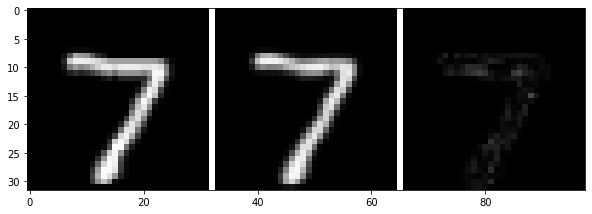

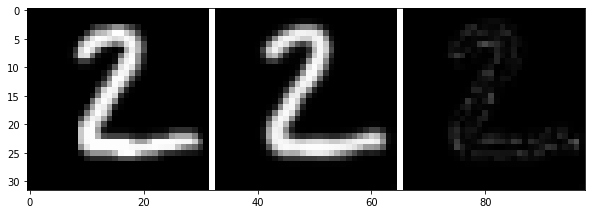

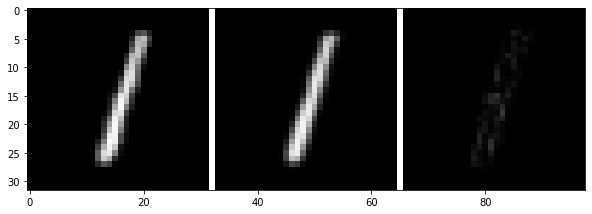

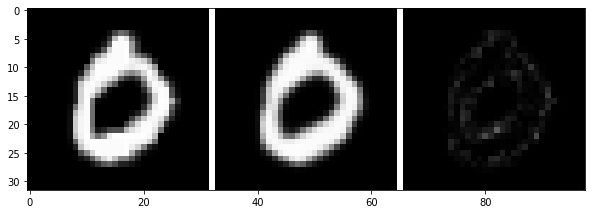

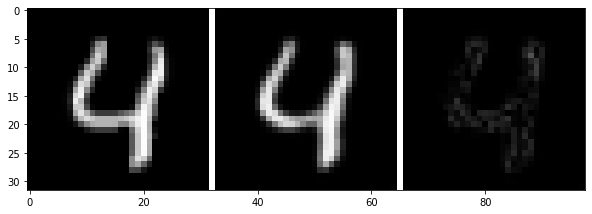

18/02/2020 20:17:14, epoch=81, step=9560, loss=0.00862, distortion=0.012, rate=0.022, -elbo=385.79138, nll=138.85976, KL=246.93164, commit_loss=2180.83838, bit_usage=0.88745, highest_prob=0.017, temp=0.30725
reset code 64
pruned code 64 - 272 remain
18/02/2020 20:17:15, epoch=81, step=9580, loss=0.00870, distortion=0.012, rate=0.022, -elbo=387.04169, nll=140.06323, KL=246.97844, commit_loss=2217.37109, bit_usage=0.89024, highest_prob=0.019, temp=0.30649
reset code 96
18/02/2020 20:17:16, epoch=81, step=9600, loss=0.00859, distortion=0.012, rate=0.022, -elbo=385.15973, nll=138.22565, KL=246.93410, commit_loss=2201.50293, bit_usage=0.88740, highest_prob=0.018, temp=0.30574
reset code 112
pruned code 112 - 271 remain
18/02/2020 20:17:16, epoch=81, step=9620, loss=0.00862, distortion=0.012, rate=0.022, -elbo=384.67731, nll=138.86479, KL=245.81250, commit_loss=2187.36768, bit_usage=0.88429, highest_prob=0.019, temp=0.30499
reset code 104
18/02/2020 20:17:17, epoch=81, step=9640, loss=0.0086

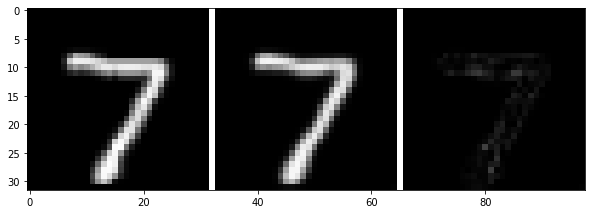

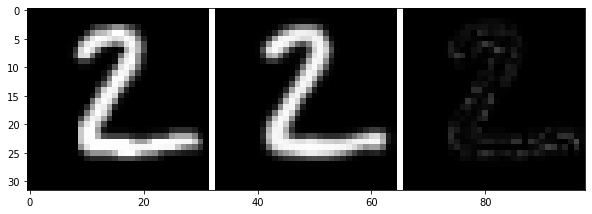

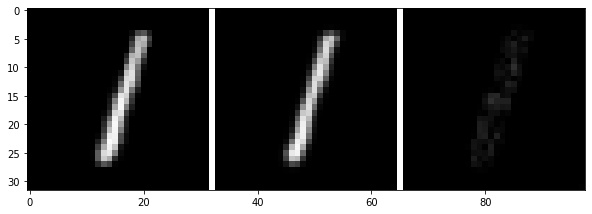

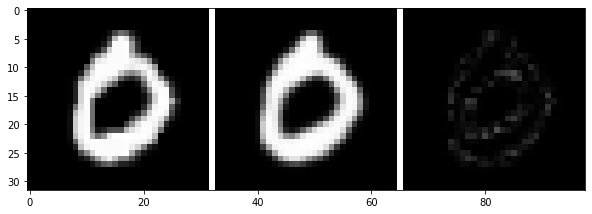

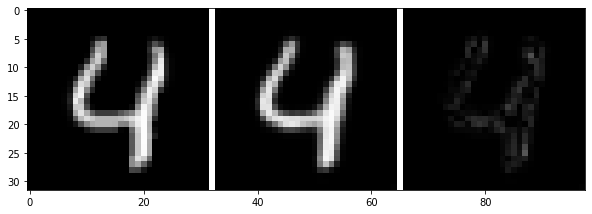

18/02/2020 20:17:36, epoch=86, step=10160, loss=0.00870, distortion=0.012, rate=0.022, -elbo=387.38831, nll=140.04185, KL=247.34647, commit_loss=2200.99854, bit_usage=0.88934, highest_prob=0.017, temp=0.28467
reset code 1
pruned code 1 - 257 remain
18/02/2020 20:17:37, epoch=86, step=10180, loss=0.00836, distortion=0.012, rate=0.022, -elbo=378.80670, nll=134.56900, KL=244.23772, commit_loss=2180.74146, bit_usage=0.88965, highest_prob=0.018, temp=0.28392
reset code 4
18/02/2020 20:17:38, epoch=86, step=10200, loss=0.00843, distortion=0.012, rate=0.022, -elbo=380.11432, nll=135.65561, KL=244.45869, commit_loss=2185.34790, bit_usage=0.89332, highest_prob=0.018, temp=0.28317
reset code 44
pruned code 44 - 256 remain
18/02/2020 20:17:38, epoch=86, step=10220, loss=0.00827, distortion=0.012, rate=0.022, -elbo=379.86624, nll=133.10742, KL=246.75882, commit_loss=2175.90430, bit_usage=0.88895, highest_prob=0.020, temp=0.28241
reset code 2
18/02/2020 20:17:39, epoch=86, step=10240, loss=0.00848,

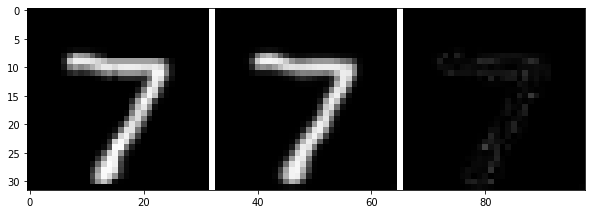

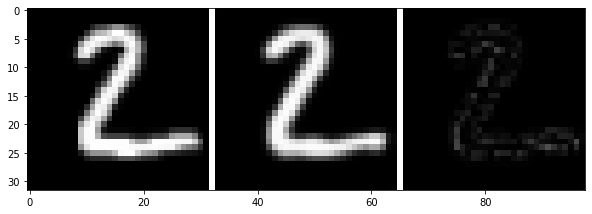

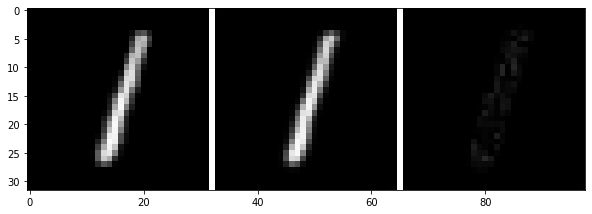

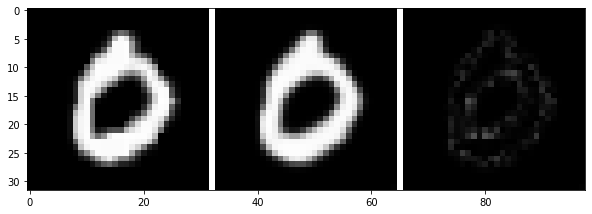

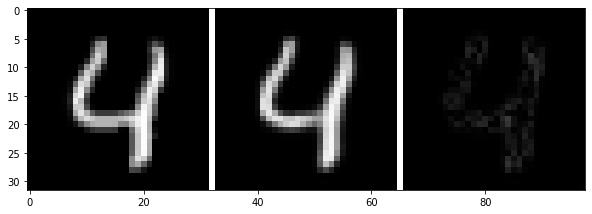

18/02/2020 20:17:58, epoch=91, step=10740, loss=0.00837, distortion=0.012, rate=0.022, -elbo=379.55469, nll=134.77960, KL=244.77509, commit_loss=2165.29688, bit_usage=0.90377, highest_prob=0.017, temp=0.26285
reset code 20
18/02/2020 20:17:58, epoch=91, step=10760, loss=0.00835, distortion=0.012, rate=0.022, -elbo=380.10498, nll=134.46309, KL=245.64188, commit_loss=2157.84009, bit_usage=0.90058, highest_prob=0.016, temp=0.26209
reset code 186
18/02/2020 20:17:59, epoch=91, step=10780, loss=0.00854, distortion=0.012, rate=0.022, -elbo=382.20264, nll=137.43494, KL=244.76770, commit_loss=2187.35938, bit_usage=0.90521, highest_prob=0.018, temp=0.26134
reset code 148
18/02/2020 20:17:59, epoch=91, step=10800, loss=0.00802, distortion=0.011, rate=0.021, -elbo=371.68134, nll=128.95026, KL=242.73108, commit_loss=2162.69629, bit_usage=0.90572, highest_prob=0.018, temp=0.26059
reset code 180
18/02/2020 20:18:00, epoch=91, step=10820, loss=0.00852, distortion=0.012, rate=0.022, -elbo=381.28802, n

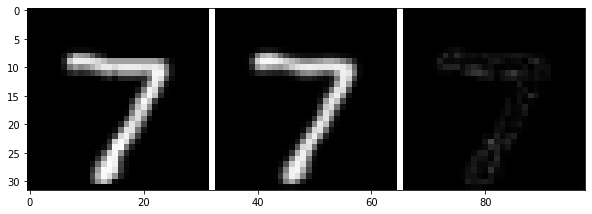

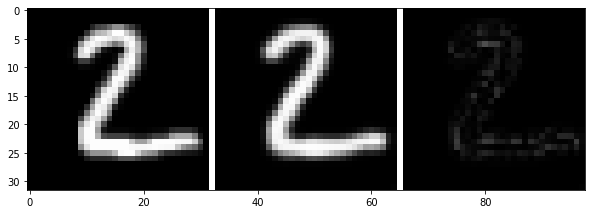

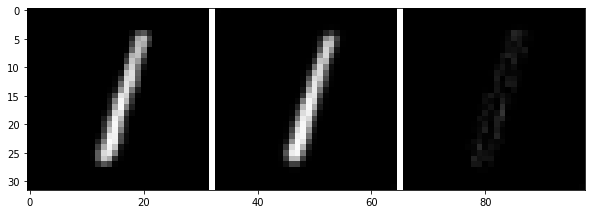

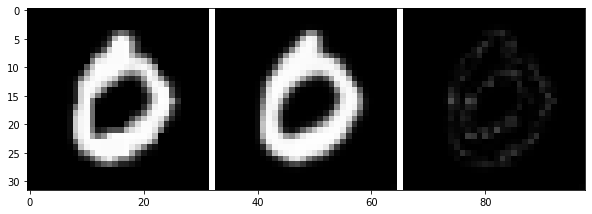

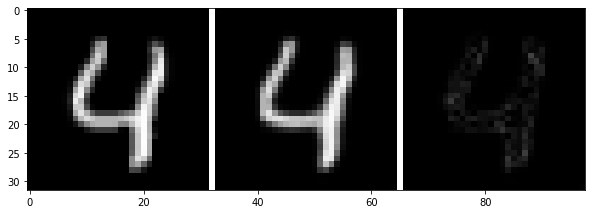

18/02/2020 20:18:20, epoch=96, step=11340, loss=0.00831, distortion=0.012, rate=0.021, -elbo=375.79105, nll=133.74010, KL=242.05095, commit_loss=2159.79321, bit_usage=0.92098, highest_prob=0.016, temp=0.24027
reset code 53
18/02/2020 20:18:21, epoch=96, step=11360, loss=0.00829, distortion=0.012, rate=0.021, -elbo=374.45184, nll=133.41780, KL=241.03406, commit_loss=2135.01514, bit_usage=0.92234, highest_prob=0.014, temp=0.23952
reset code 236
18/02/2020 20:18:22, epoch=96, step=11380, loss=0.00817, distortion=0.012, rate=0.021, -elbo=373.11676, nll=131.44432, KL=241.67245, commit_loss=2142.68677, bit_usage=0.92206, highest_prob=0.013, temp=0.23877
reset code 156
18/02/2020 20:18:22, epoch=96, step=11400, loss=0.00814, distortion=0.012, rate=0.021, -elbo=372.43375, nll=130.95563, KL=241.47812, commit_loss=2158.99976, bit_usage=0.92493, highest_prob=0.015, temp=0.23801
reset code 132
18/02/2020 20:18:23, epoch=96, step=11420, loss=0.00832, distortion=0.012, rate=0.021, -elbo=373.97952, n

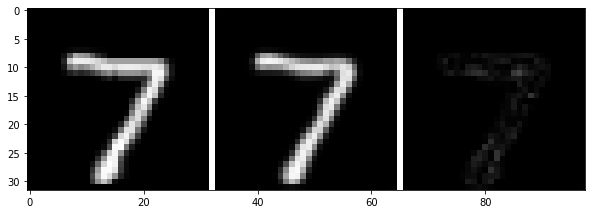

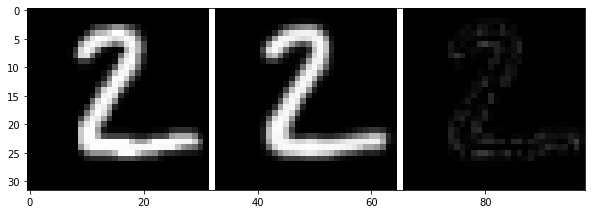

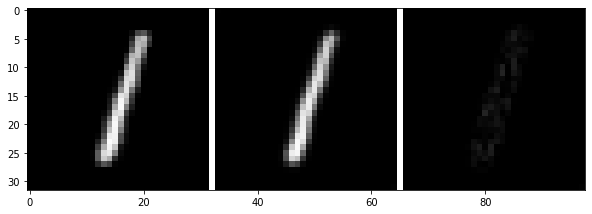

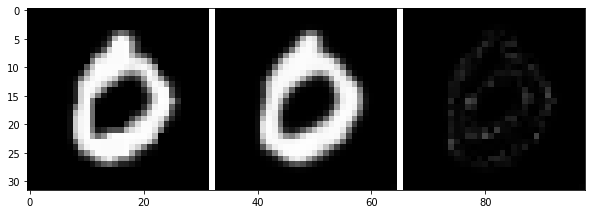

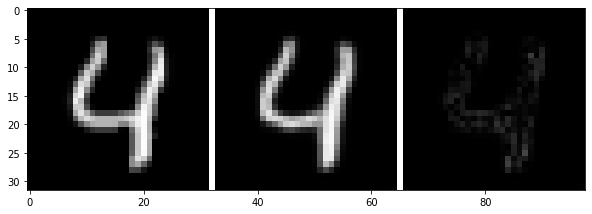

18/02/2020 20:18:41, epoch=101, step=11920, loss=0.00831, distortion=0.012, rate=0.021, -elbo=369.12091, nll=133.73532, KL=235.38559, commit_loss=2109.80908, bit_usage=0.94841, highest_prob=0.011, temp=0.21845
reset code 216
18/02/2020 20:18:42, epoch=101, step=11940, loss=0.00802, distortion=0.011, rate=0.021, -elbo=362.95105, nll=128.99773, KL=233.95332, commit_loss=2121.42651, bit_usage=0.94984, highest_prob=0.011, temp=0.21769
reset code 208
18/02/2020 20:18:42, epoch=101, step=11960, loss=0.00811, distortion=0.011, rate=0.021, -elbo=363.63623, nll=130.55914, KL=233.07709, commit_loss=2107.45654, bit_usage=0.95170, highest_prob=0.011, temp=0.21694
reset code 78
18/02/2020 20:18:43, epoch=101, step=11980, loss=0.00818, distortion=0.012, rate=0.021, -elbo=365.90607, nll=131.72714, KL=234.17892, commit_loss=2115.02197, bit_usage=0.95175, highest_prob=0.010, temp=0.21619
reset code 183
18/02/2020 20:18:44, epoch=101, step=12000, loss=0.00798, distortion=0.011, rate=0.020, -elbo=361.165

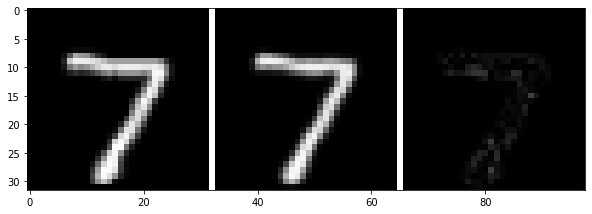

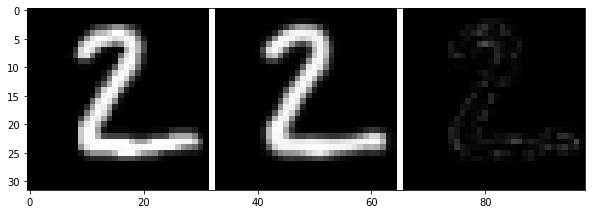

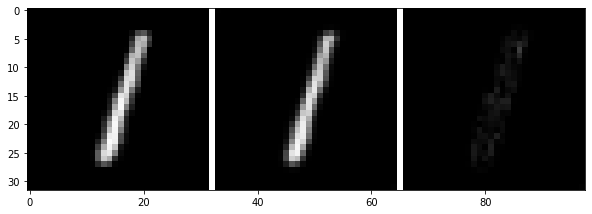

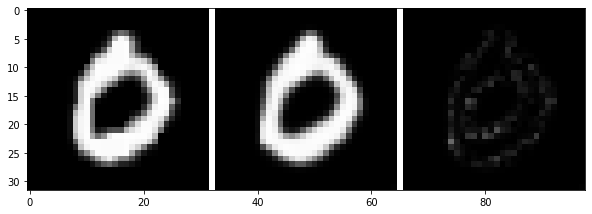

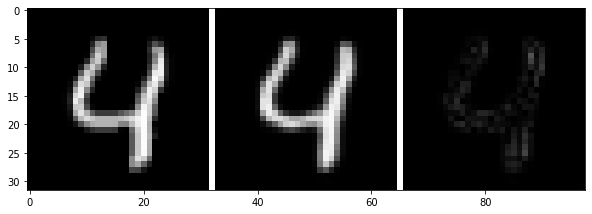

18/02/2020 20:19:04, epoch=106, step=12520, loss=0.00831, distortion=0.012, rate=0.021, -elbo=369.60785, nll=133.78012, KL=235.82773, commit_loss=2079.73218, bit_usage=0.95740, highest_prob=0.012, temp=0.19587
reset code 172
18/02/2020 20:19:05, epoch=106, step=12540, loss=0.00794, distortion=0.011, rate=0.021, -elbo=362.31824, nll=127.80077, KL=234.51746, commit_loss=2061.31689, bit_usage=0.95846, highest_prob=0.012, temp=0.19512
reset code 185
18/02/2020 20:19:05, epoch=106, step=12560, loss=0.00799, distortion=0.011, rate=0.021, -elbo=364.32721, nll=128.58969, KL=235.73752, commit_loss=2073.10425, bit_usage=0.95853, highest_prob=0.011, temp=0.19437
18/02/2020 20:19:06, epoch=106, step=12580, loss=0.00828, distortion=0.012, rate=0.021, -elbo=369.91724, nll=133.30124, KL=236.61600, commit_loss=2102.06055, bit_usage=0.95797, highest_prob=0.011, temp=0.19361
18/02/2020 20:19:07, epoch=106, step=12600, loss=0.00781, distortion=0.011, rate=0.021, -elbo=360.45953, nll=125.58900, KL=234.870

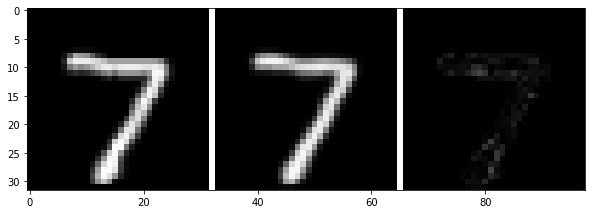

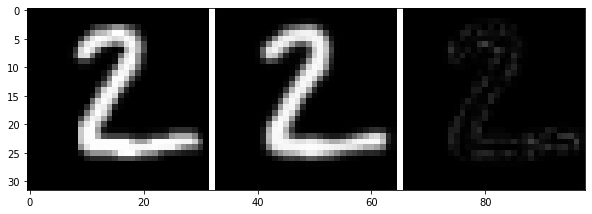

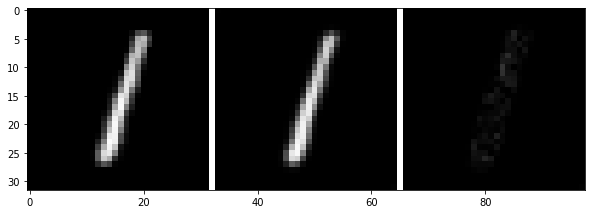

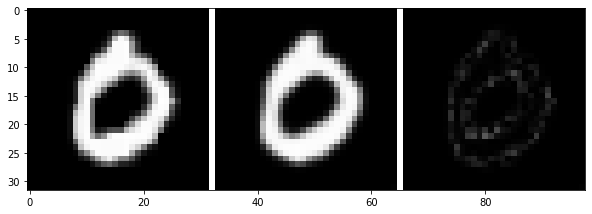

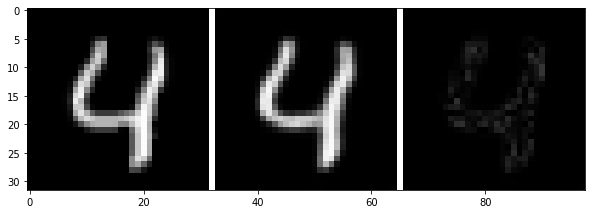

18/02/2020 20:19:26, epoch=111, step=13100, loss=0.00773, distortion=0.011, rate=0.021, -elbo=362.11853, nll=124.39532, KL=237.72322, commit_loss=2035.83667, bit_usage=0.95485, highest_prob=0.013, temp=0.17405
reset code 123
18/02/2020 20:19:27, epoch=111, step=13120, loss=0.00764, distortion=0.011, rate=0.021, -elbo=361.47540, nll=122.87772, KL=238.59769, commit_loss=2029.00403, bit_usage=0.95674, highest_prob=0.014, temp=0.17329
reset code 201
18/02/2020 20:19:28, epoch=111, step=13140, loss=0.00763, distortion=0.011, rate=0.021, -elbo=361.24823, nll=122.74537, KL=238.50287, commit_loss=2010.55640, bit_usage=0.95530, highest_prob=0.012, temp=0.17254
reset code 102
18/02/2020 20:19:28, epoch=111, step=13160, loss=0.00782, distortion=0.011, rate=0.021, -elbo=364.55826, nll=125.87467, KL=238.68358, commit_loss=2034.19470, bit_usage=0.95623, highest_prob=0.012, temp=0.17179
18/02/2020 20:19:29, epoch=111, step=13180, loss=0.00790, distortion=0.011, rate=0.021, -elbo=364.89075, nll=127.24

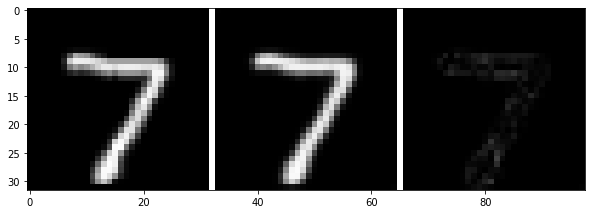

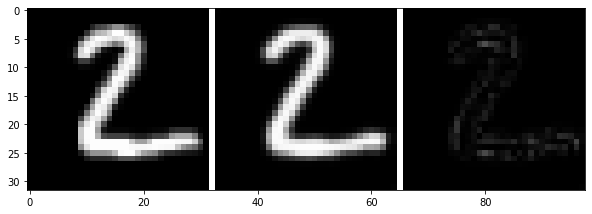

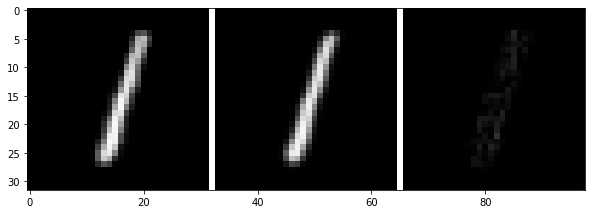

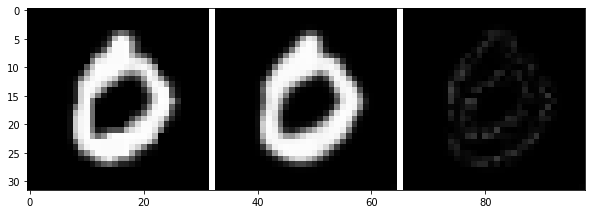

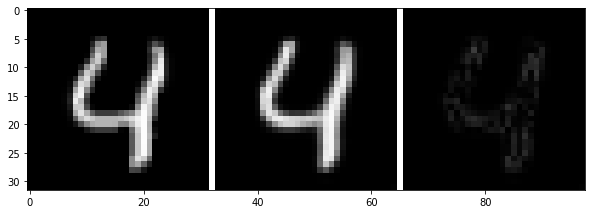

18/02/2020 20:19:50, epoch=116, step=13700, loss=0.00772, distortion=0.011, rate=0.021, -elbo=364.44684, nll=124.30553, KL=240.14133, commit_loss=2000.56238, bit_usage=0.95882, highest_prob=0.013, temp=0.15147
18/02/2020 20:19:50, epoch=116, step=13720, loss=0.00769, distortion=0.011, rate=0.021, -elbo=364.12915, nll=123.65667, KL=240.47247, commit_loss=2021.28931, bit_usage=0.95991, highest_prob=0.012, temp=0.15072
18/02/2020 20:19:51, epoch=116, step=13740, loss=0.00771, distortion=0.011, rate=0.021, -elbo=365.17032, nll=124.06597, KL=241.10434, commit_loss=2012.55615, bit_usage=0.95811, highest_prob=0.012, temp=0.14997
reset code 93
18/02/2020 20:19:52, epoch=116, step=13760, loss=0.00762, distortion=0.011, rate=0.021, -elbo=362.25870, nll=122.58533, KL=239.67337, commit_loss=2004.00586, bit_usage=0.96065, highest_prob=0.011, temp=0.14921
18/02/2020 20:19:52, epoch=116, step=13780, loss=0.00745, distortion=0.011, rate=0.021, -elbo=358.83716, nll=119.77766, KL=239.05949, commit_loss=

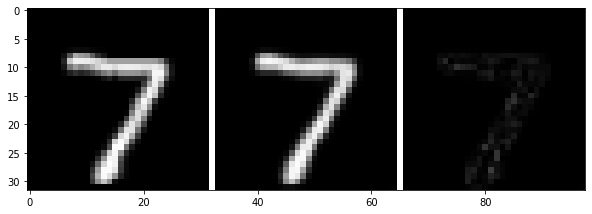

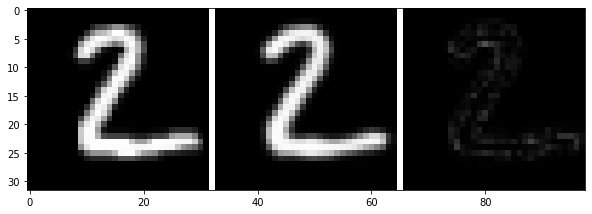

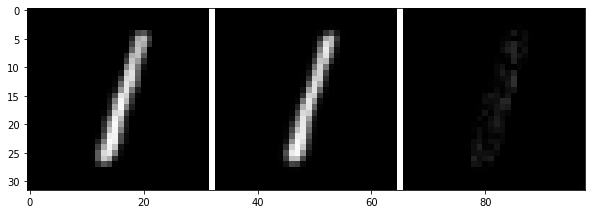

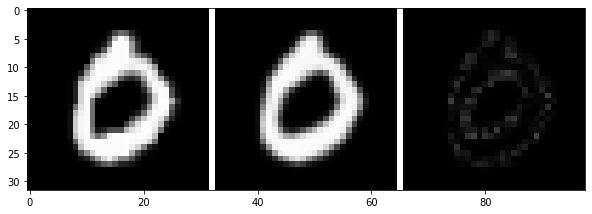

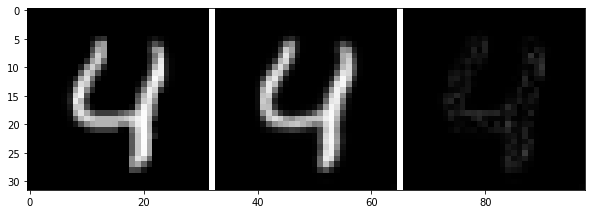

18/02/2020 20:20:11, epoch=121, step=14280, loss=0.00785, distortion=0.011, rate=0.021, -elbo=367.99579, nll=126.35132, KL=241.64445, commit_loss=1996.96655, bit_usage=0.95796, highest_prob=0.011, temp=0.12965
18/02/2020 20:20:12, epoch=121, step=14300, loss=0.00734, distortion=0.010, rate=0.021, -elbo=358.81012, nll=118.03429, KL=240.77582, commit_loss=1992.49841, bit_usage=0.96064, highest_prob=0.011, temp=0.12889
18/02/2020 20:20:12, epoch=121, step=14320, loss=0.00767, distortion=0.011, rate=0.021, -elbo=365.11072, nll=123.37646, KL=241.73425, commit_loss=2017.26233, bit_usage=0.96023, highest_prob=0.011, temp=0.12814
18/02/2020 20:20:13, epoch=121, step=14340, loss=0.00770, distortion=0.011, rate=0.021, -elbo=364.93625, nll=123.85513, KL=241.08112, commit_loss=2006.75854, bit_usage=0.95971, highest_prob=0.011, temp=0.12739
18/02/2020 20:20:13, epoch=121, step=14360, loss=0.00763, distortion=0.011, rate=0.021, -elbo=365.10385, nll=122.80994, KL=242.29391, commit_loss=1990.13989, bi

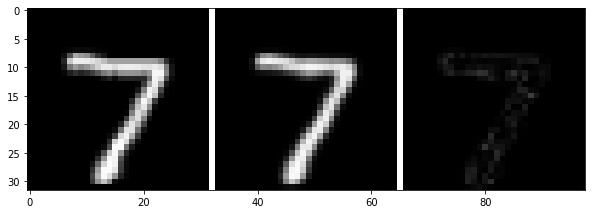

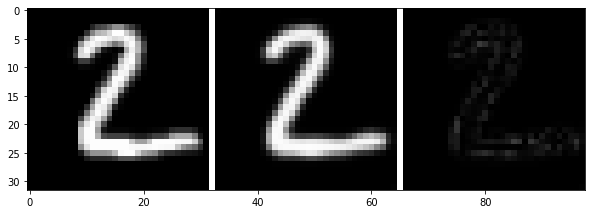

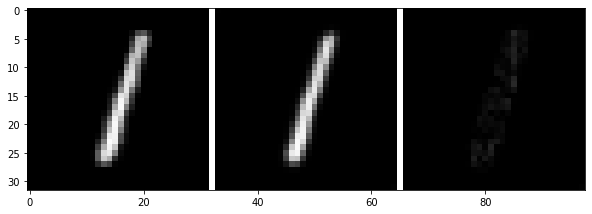

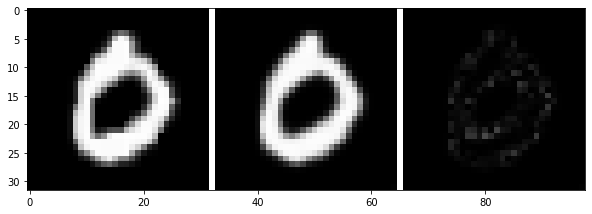

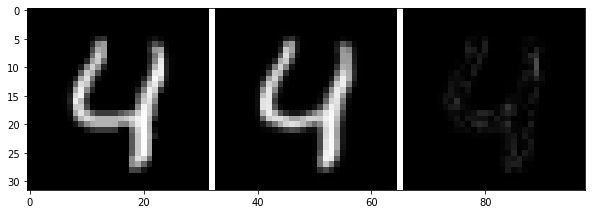

18/02/2020 20:20:32, epoch=126, step=14880, loss=0.00734, distortion=0.010, rate=0.021, -elbo=360.93250, nll=118.08765, KL=242.84485, commit_loss=1965.72534, bit_usage=0.95899, highest_prob=0.013, temp=0.10707
18/02/2020 20:20:33, epoch=126, step=14900, loss=0.00773, distortion=0.011, rate=0.022, -elbo=369.10153, nll=124.39677, KL=244.70476, commit_loss=2006.94604, bit_usage=0.95754, highest_prob=0.011, temp=0.10632
18/02/2020 20:20:33, epoch=126, step=14920, loss=0.00753, distortion=0.011, rate=0.021, -elbo=364.66229, nll=121.09093, KL=243.57135, commit_loss=1989.41992, bit_usage=0.95955, highest_prob=0.011, temp=0.10557
18/02/2020 20:20:34, epoch=126, step=14940, loss=0.00754, distortion=0.011, rate=0.021, -elbo=365.01877, nll=121.32901, KL=243.68976, commit_loss=1986.57874, bit_usage=0.95849, highest_prob=0.011, temp=0.10481
18/02/2020 20:20:35, epoch=126, step=14960, loss=0.00767, distortion=0.011, rate=0.022, -elbo=367.92261, nll=123.45845, KL=244.46416, commit_loss=1973.30835, bi

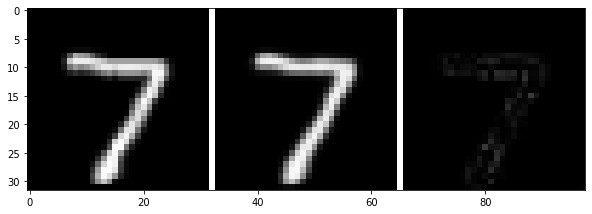

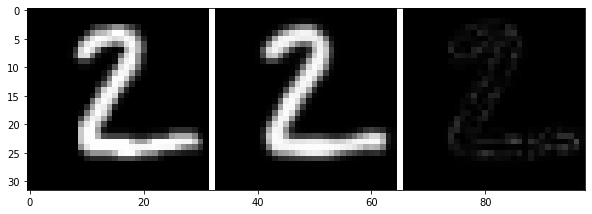

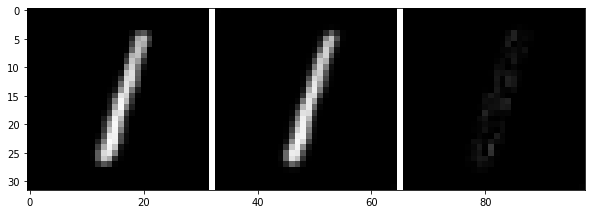

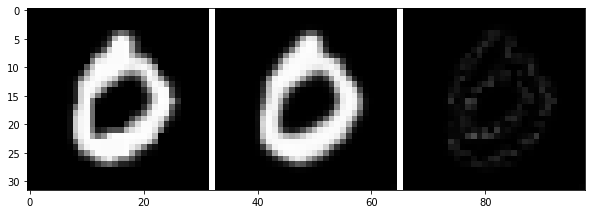

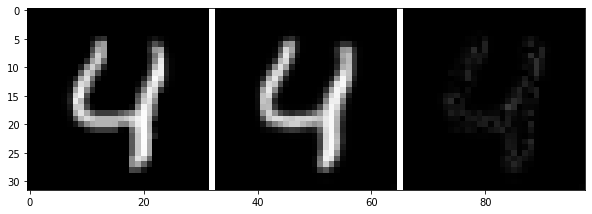

18/02/2020 20:20:54, epoch=131, step=15460, loss=0.00743, distortion=0.011, rate=0.022, -elbo=363.76428, nll=119.58382, KL=244.18048, commit_loss=1967.07104, bit_usage=0.95715, highest_prob=0.011, temp=0.08525
18/02/2020 20:20:54, epoch=131, step=15480, loss=0.00776, distortion=0.011, rate=0.022, -elbo=371.19373, nll=124.84531, KL=246.34843, commit_loss=1995.47290, bit_usage=0.95713, highest_prob=0.010, temp=0.08449
reset code 164
18/02/2020 20:20:55, epoch=131, step=15500, loss=0.00721, distortion=0.010, rate=0.022, -elbo=361.18704, nll=115.86549, KL=245.32155, commit_loss=1977.52612, bit_usage=0.95803, highest_prob=0.010, temp=0.08374
18/02/2020 20:20:56, epoch=131, step=15520, loss=0.00770, distortion=0.011, rate=0.022, -elbo=369.47269, nll=123.92049, KL=245.55220, commit_loss=1976.41187, bit_usage=0.95655, highest_prob=0.011, temp=0.08299
18/02/2020 20:20:56, epoch=131, step=15540, loss=0.00744, distortion=0.011, rate=0.022, -elbo=364.10016, nll=119.69170, KL=244.40845, commit_loss

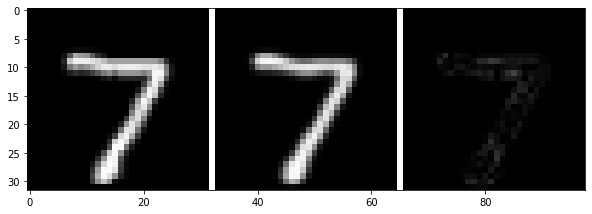

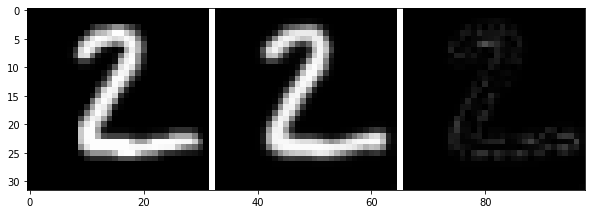

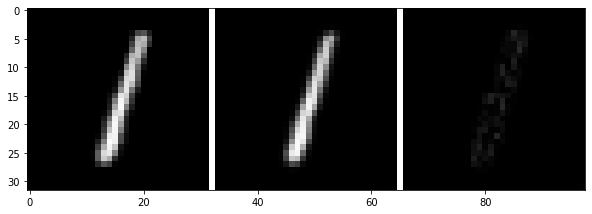

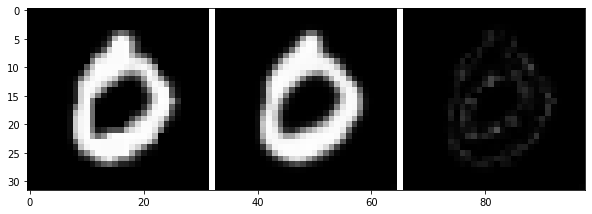

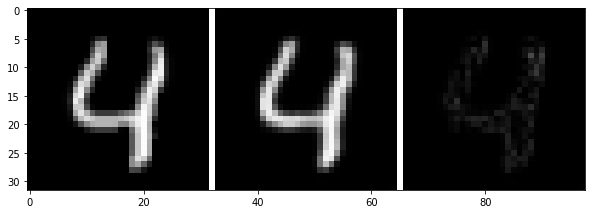

18/02/2020 20:21:17, epoch=136, step=16060, loss=0.00759, distortion=0.011, rate=0.022, -elbo=368.56726, nll=122.15152, KL=246.41573, commit_loss=1993.21362, bit_usage=0.95815, highest_prob=0.012, temp=0.06267
18/02/2020 20:21:18, epoch=136, step=16080, loss=0.00747, distortion=0.011, rate=0.022, -elbo=366.17017, nll=120.14891, KL=246.02127, commit_loss=1994.29248, bit_usage=0.95900, highest_prob=0.011, temp=0.06192
18/02/2020 20:21:18, epoch=136, step=16100, loss=0.00760, distortion=0.011, rate=0.022, -elbo=368.30978, nll=122.29309, KL=246.01669, commit_loss=1979.09448, bit_usage=0.95923, highest_prob=0.011, temp=0.06117
18/02/2020 20:21:19, epoch=136, step=16120, loss=0.00773, distortion=0.011, rate=0.022, -elbo=370.59750, nll=124.35846, KL=246.23904, commit_loss=1992.95825, bit_usage=0.95930, highest_prob=0.010, temp=0.06041
18/02/2020 20:21:20, epoch=136, step=16140, loss=0.00734, distortion=0.010, rate=0.022, -elbo=364.14331, nll=118.10493, KL=246.03839, commit_loss=1976.88770, bi

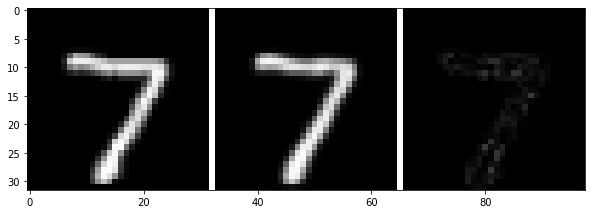

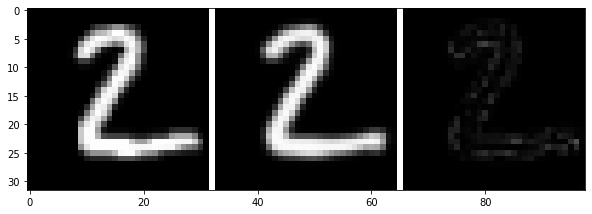

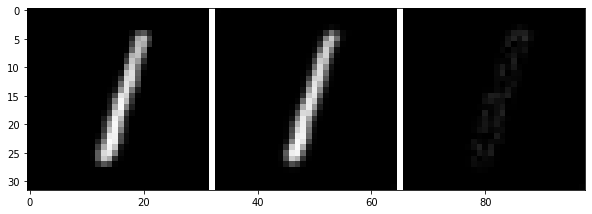

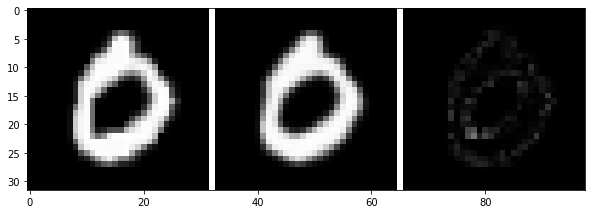

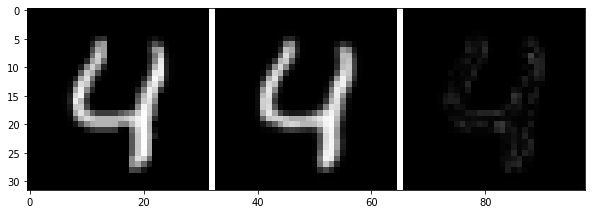

18/02/2020 20:21:39, epoch=141, step=16640, loss=0.00752, distortion=0.011, rate=0.022, -elbo=366.30273, nll=120.92269, KL=245.38005, commit_loss=1993.34192, bit_usage=0.95913, highest_prob=0.010, temp=0.04085
18/02/2020 20:21:40, epoch=141, step=16660, loss=0.00742, distortion=0.011, rate=0.022, -elbo=364.74713, nll=119.36867, KL=245.37845, commit_loss=1988.31995, bit_usage=0.96062, highest_prob=0.011, temp=0.04009
18/02/2020 20:21:41, epoch=141, step=16680, loss=0.00756, distortion=0.011, rate=0.022, -elbo=368.75156, nll=121.65775, KL=247.09381, commit_loss=2007.76135, bit_usage=0.95830, highest_prob=0.012, temp=0.03934
reset code 170
18/02/2020 20:21:41, epoch=141, step=16700, loss=0.00762, distortion=0.011, rate=0.022, -elbo=367.10693, nll=122.57049, KL=244.53645, commit_loss=1974.37427, bit_usage=0.95942, highest_prob=0.011, temp=0.03859
18/02/2020 20:21:42, epoch=141, step=16720, loss=0.00774, distortion=0.011, rate=0.022, -elbo=371.05048, nll=124.55867, KL=246.49179, commit_loss

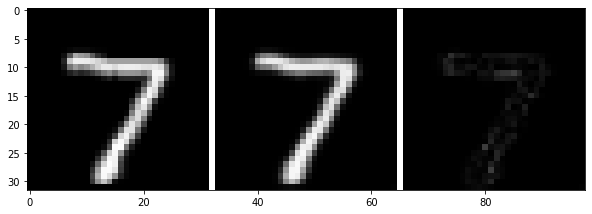

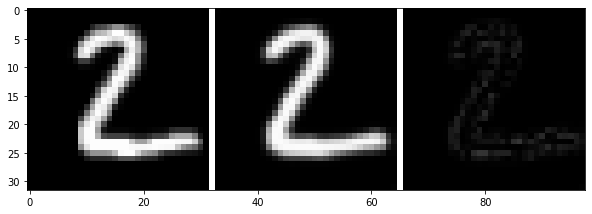

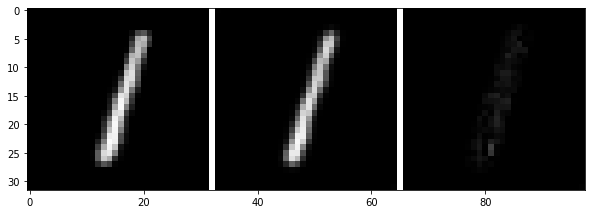

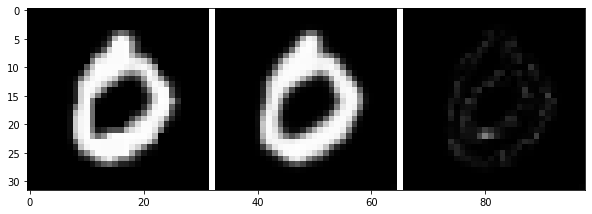

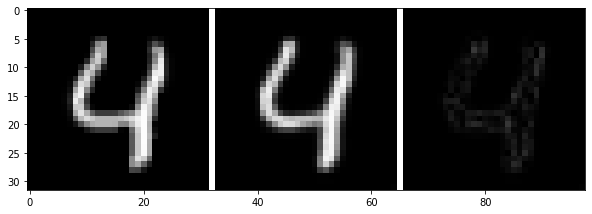

18/02/2020 20:22:02, epoch=146, step=17240, loss=0.00762, distortion=0.011, rate=0.022, -elbo=368.68243, nll=122.68875, KL=245.99367, commit_loss=1971.52686, bit_usage=0.96030, highest_prob=0.010, temp=0.01827
reset code 173
18/02/2020 20:22:02, epoch=146, step=17260, loss=0.00744, distortion=0.011, rate=0.022, -elbo=364.77606, nll=119.64372, KL=245.13232, commit_loss=1974.62341, bit_usage=0.96024, highest_prob=0.010, temp=0.01752
18/02/2020 20:22:03, epoch=146, step=17280, loss=0.00761, distortion=0.011, rate=0.022, -elbo=367.61771, nll=122.41465, KL=245.20305, commit_loss=1976.94275, bit_usage=0.96119, highest_prob=0.009, temp=0.01677
18/02/2020 20:22:03, epoch=146, step=17300, loss=0.00755, distortion=0.011, rate=0.022, -elbo=368.16968, nll=121.46849, KL=246.70117, commit_loss=1988.58130, bit_usage=0.96049, highest_prob=0.010, temp=0.01601
18/02/2020 20:22:04, epoch=146, step=17320, loss=0.00784, distortion=0.011, rate=0.022, -elbo=372.80389, nll=126.23021, KL=246.57367, commit_loss

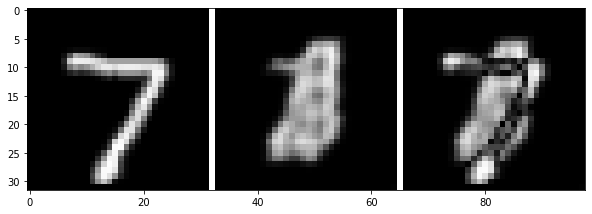

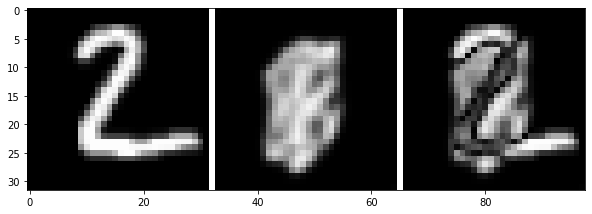

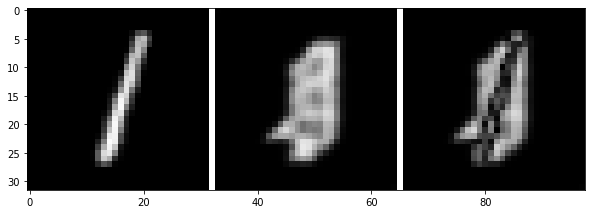

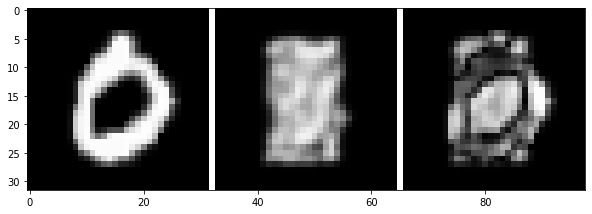

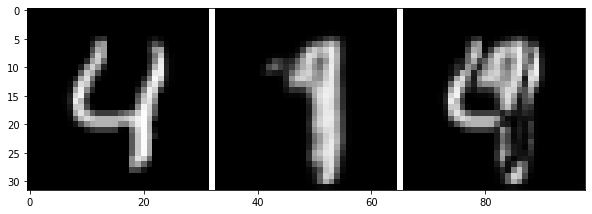

18/02/2020 20:22:22, epoch=1, step=120, loss=0.38131, distortion=0.550, rate=0.028, -elbo=1639.77112, nll=1561.25000, KL=78.52111, commit_loss=532.63123, bit_usage=0.31346, highest_prob=0.211, temp=0.66245
reset code 64
pruned code 64 - 508 remain
18/02/2020 20:22:22, epoch=1, step=140, loss=0.36697, distortion=0.529, rate=0.028, -elbo=1581.82812, nll=1502.47192, KL=79.35626, commit_loss=541.82092, bit_usage=0.32210, highest_prob=0.235, temp=0.66169
reset code 64
18/02/2020 20:22:23, epoch=1, step=160, loss=0.35578, distortion=0.513, rate=0.028, -elbo=1535.20911, nll=1456.65320, KL=78.55595, commit_loss=552.39966, bit_usage=0.35538, highest_prob=0.277, temp=0.66094
reset code 80
pruned code 80 - 507 remain
18/02/2020 20:22:23, epoch=1, step=180, loss=0.32167, distortion=0.464, rate=0.028, -elbo=1396.24207, nll=1316.91333, KL=79.32870, commit_loss=557.88983, bit_usage=0.36980, highest_prob=0.261, temp=0.66019
reset code 80
18/02/2020 20:22:24, epoch=1, step=200, loss=0.30217, distortion

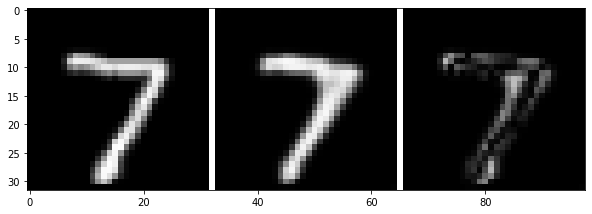

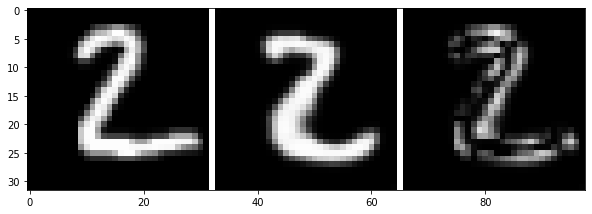

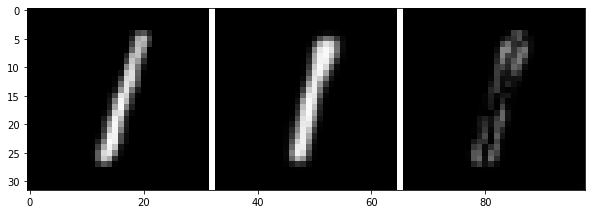

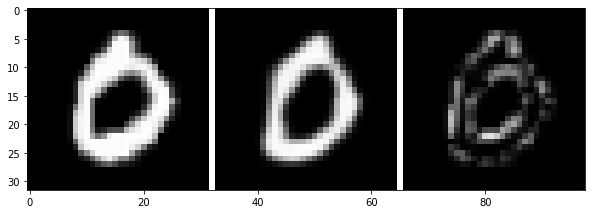

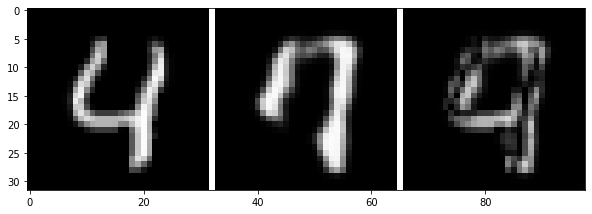

18/02/2020 20:22:39, epoch=6, step=720, loss=0.17021, distortion=0.245, rate=0.025, -elbo=767.97601, nll=696.54053, KL=71.43550, commit_loss=571.66974, bit_usage=0.56807, highest_prob=0.060, temp=0.63987
reset code 176
pruned code 176 - 493 remain
18/02/2020 20:22:39, epoch=6, step=740, loss=0.16843, distortion=0.243, rate=0.025, -elbo=760.67456, nll=689.22705, KL=71.44753, commit_loss=571.46649, bit_usage=0.56885, highest_prob=0.058, temp=0.63912
reset code 176
18/02/2020 20:22:39, epoch=6, step=760, loss=0.16750, distortion=0.241, rate=0.025, -elbo=755.69049, nll=685.43231, KL=70.25816, commit_loss=573.15289, bit_usage=0.57760, highest_prob=0.056, temp=0.63837
reset code 192
pruned code 192 - 492 remain
18/02/2020 20:22:40, epoch=6, step=780, loss=0.16425, distortion=0.237, rate=0.025, -elbo=742.60986, nll=672.12213, KL=70.48773, commit_loss=574.79156, bit_usage=0.57765, highest_prob=0.056, temp=0.63761
reset code 192
18/02/2020 20:22:40, epoch=6, step=800, loss=0.16489, distortion=0

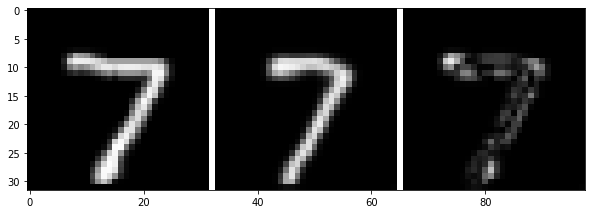

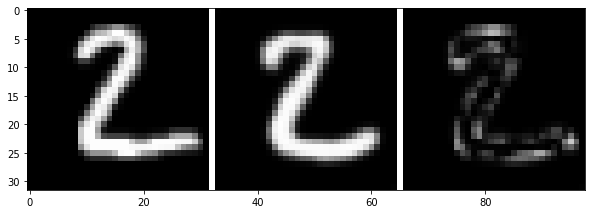

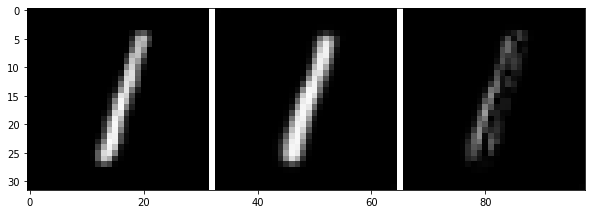

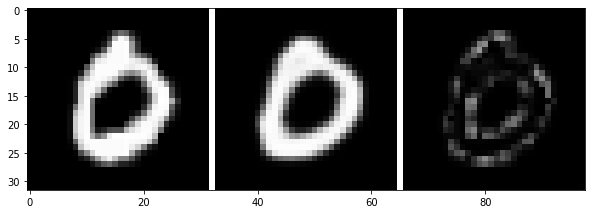

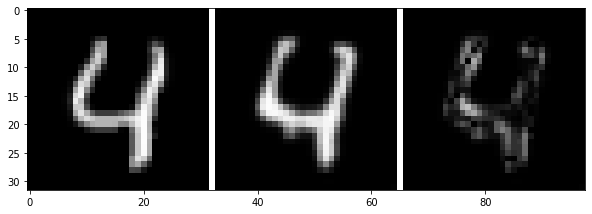

18/02/2020 20:22:54, epoch=11, step=1300, loss=0.13224, distortion=0.191, rate=0.026, -elbo=616.06757, nll=540.96936, KL=75.09819, commit_loss=606.29309, bit_usage=0.61602, highest_prob=0.062, temp=0.61805
reset code 416
18/02/2020 20:22:55, epoch=11, step=1320, loss=0.12793, distortion=0.184, rate=0.026, -elbo=598.21381, nll=523.33960, KL=74.87421, commit_loss=605.77783, bit_usage=0.62057, highest_prob=0.065, temp=0.61729
reset code 432
pruned code 432 - 478 remain
18/02/2020 20:22:55, epoch=11, step=1340, loss=0.12741, distortion=0.184, rate=0.026, -elbo=596.16553, nll=521.17395, KL=74.99158, commit_loss=611.90527, bit_usage=0.62260, highest_prob=0.065, temp=0.61654
reset code 432
18/02/2020 20:22:55, epoch=11, step=1360, loss=0.12830, distortion=0.185, rate=0.027, -elbo=600.06555, nll=524.82367, KL=75.24185, commit_loss=613.07739, bit_usage=0.62691, highest_prob=0.064, temp=0.61579
reset code 448
pruned code 448 - 477 remain
18/02/2020 20:22:56, epoch=11, step=1380, loss=0.12517, di

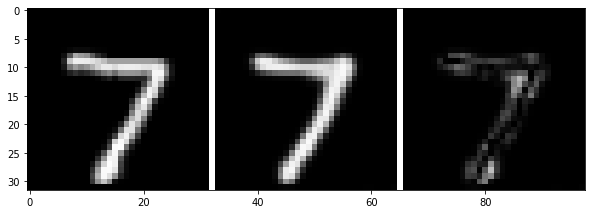

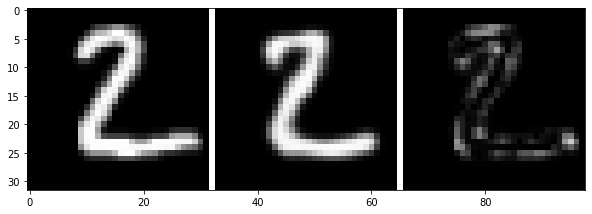

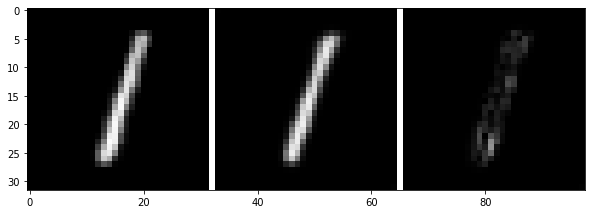

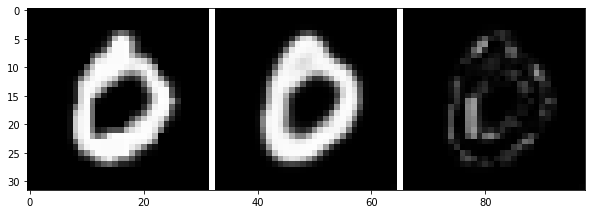

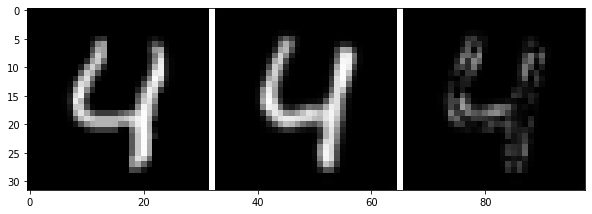

18/02/2020 20:23:09, epoch=16, step=1900, loss=0.10114, distortion=0.146, rate=0.026, -elbo=487.96371, nll=413.55850, KL=74.40522, commit_loss=656.89746, bit_usage=0.70308, highest_prob=0.042, temp=0.59547
reset code 240
18/02/2020 20:23:09, epoch=16, step=1920, loss=0.10218, distortion=0.147, rate=0.026, -elbo=491.96613, nll=417.81168, KL=74.15446, commit_loss=656.62042, bit_usage=0.70785, highest_prob=0.038, temp=0.59472
reset code 256
pruned code 256 - 463 remain
18/02/2020 20:23:10, epoch=16, step=1940, loss=0.10054, distortion=0.145, rate=0.026, -elbo=485.31738, nll=411.09915, KL=74.21823, commit_loss=655.04645, bit_usage=0.70648, highest_prob=0.042, temp=0.59397
reset code 256
18/02/2020 20:23:10, epoch=16, step=1960, loss=0.09796, distortion=0.141, rate=0.026, -elbo=474.38934, nll=400.51776, KL=73.87159, commit_loss=652.66675, bit_usage=0.70923, highest_prob=0.046, temp=0.59321
reset code 272
pruned code 272 - 462 remain
18/02/2020 20:23:11, epoch=16, step=1980, loss=0.09911, di

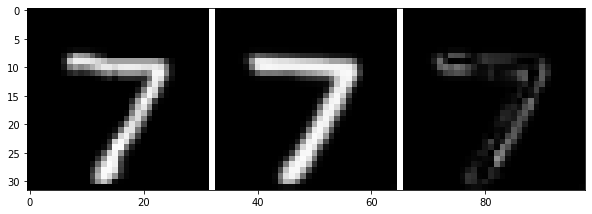

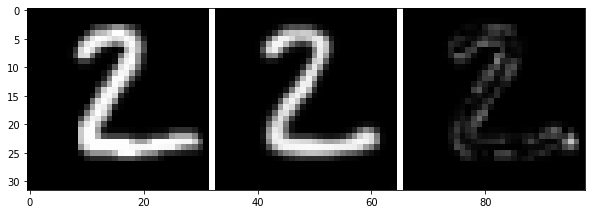

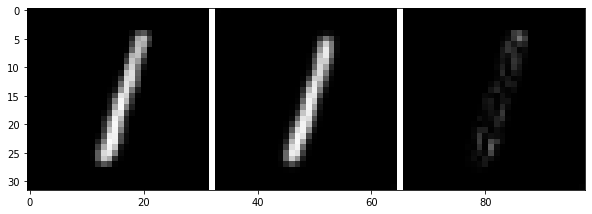

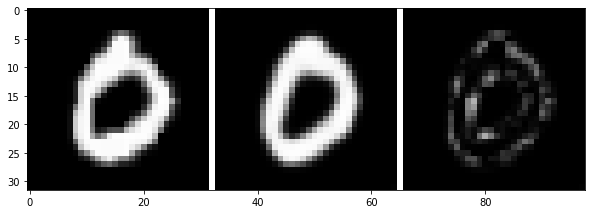

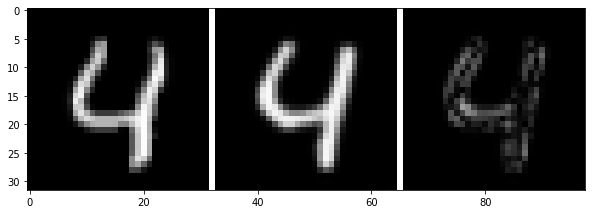

18/02/2020 20:23:24, epoch=21, step=2480, loss=0.08864, distortion=0.128, rate=0.026, -elbo=436.08270, nll=362.32312, KL=73.75958, commit_loss=666.81488, bit_usage=0.74472, highest_prob=0.033, temp=0.57365
reset code 224
pruned code 224 - 449 remain
18/02/2020 20:23:25, epoch=21, step=2500, loss=0.08715, distortion=0.125, rate=0.026, -elbo=429.83282, nll=356.24063, KL=73.59218, commit_loss=668.71765, bit_usage=0.74886, highest_prob=0.029, temp=0.57289
reset code 224
18/02/2020 20:23:25, epoch=21, step=2520, loss=0.08737, distortion=0.126, rate=0.026, -elbo=430.53671, nll=357.12769, KL=73.40903, commit_loss=668.90845, bit_usage=0.75098, highest_prob=0.029, temp=0.57214
reset code 240
pruned code 240 - 448 remain
18/02/2020 20:23:26, epoch=21, step=2540, loss=0.08809, distortion=0.127, rate=0.026, -elbo=434.03201, nll=360.08398, KL=73.94803, commit_loss=672.39978, bit_usage=0.74842, highest_prob=0.032, temp=0.57139
reset code 240
18/02/2020 20:23:26, epoch=21, step=2560, loss=0.08830, di

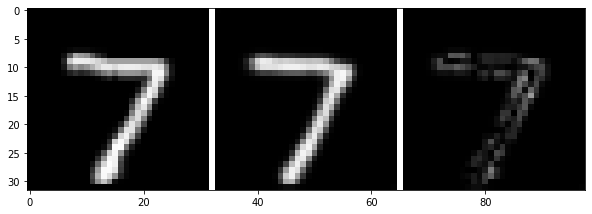

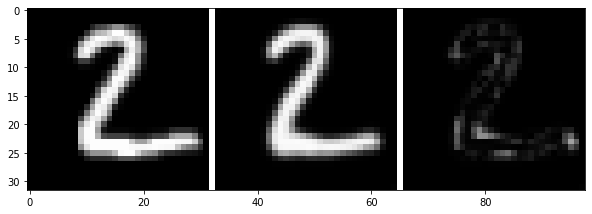

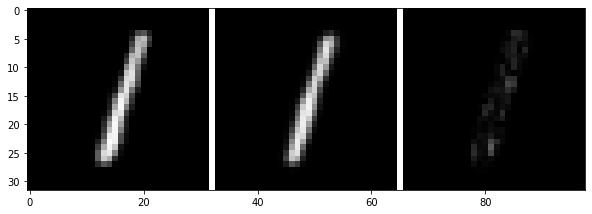

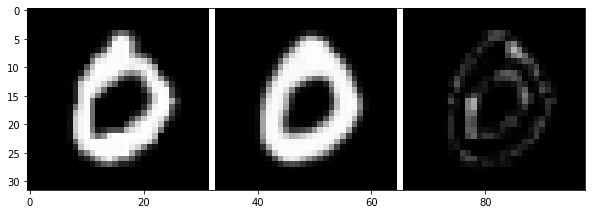

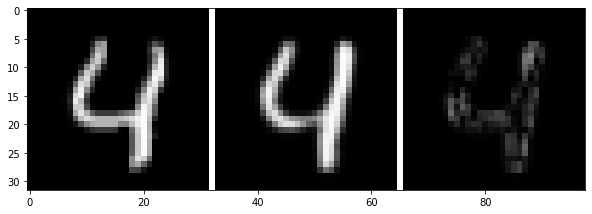

18/02/2020 20:23:39, epoch=26, step=3080, loss=0.08013, distortion=0.115, rate=0.026, -elbo=400.85815, nll=327.46014, KL=73.39801, commit_loss=675.11462, bit_usage=0.78122, highest_prob=0.024, temp=0.55107
reset code 176
pruned code 176 - 434 remain
18/02/2020 20:23:40, epoch=26, step=3100, loss=0.07944, distortion=0.114, rate=0.026, -elbo=398.16156, nll=324.62820, KL=73.53336, commit_loss=673.91504, bit_usage=0.78183, highest_prob=0.024, temp=0.55032
reset code 176
18/02/2020 20:23:40, epoch=26, step=3120, loss=0.07725, distortion=0.111, rate=0.026, -elbo=388.96042, nll=315.67273, KL=73.28769, commit_loss=675.91656, bit_usage=0.78588, highest_prob=0.022, temp=0.54957
reset code 192
pruned code 192 - 433 remain
18/02/2020 20:23:41, epoch=26, step=3140, loss=0.07962, distortion=0.115, rate=0.026, -elbo=399.21075, nll=325.35941, KL=73.85136, commit_loss=677.15356, bit_usage=0.78220, highest_prob=0.024, temp=0.54881
reset code 192
18/02/2020 20:23:41, epoch=26, step=3160, loss=0.07917, di

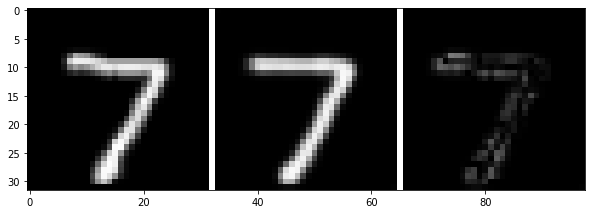

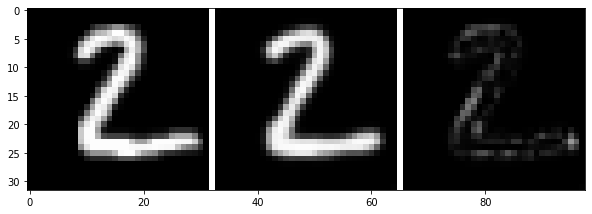

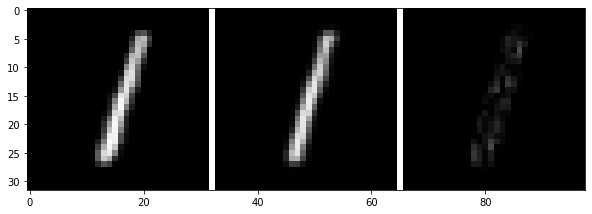

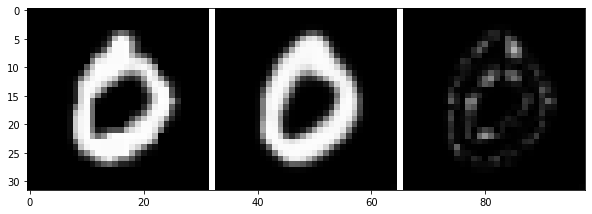

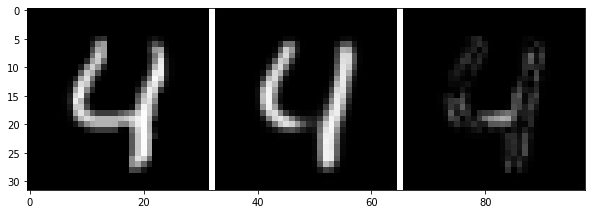

18/02/2020 20:23:55, epoch=31, step=3660, loss=0.07300, distortion=0.105, rate=0.026, -elbo=371.11121, nll=298.24603, KL=72.86517, commit_loss=670.07709, bit_usage=0.81295, highest_prob=0.020, temp=0.52925
reset code 272
18/02/2020 20:23:55, epoch=31, step=3680, loss=0.07364, distortion=0.106, rate=0.026, -elbo=373.89749, nll=300.88385, KL=73.01364, commit_loss=669.49707, bit_usage=0.81236, highest_prob=0.021, temp=0.52849
reset code 304
pruned code 304 - 419 remain
18/02/2020 20:23:55, epoch=31, step=3700, loss=0.07422, distortion=0.107, rate=0.026, -elbo=376.26385, nll=303.24991, KL=73.01393, commit_loss=676.35400, bit_usage=0.81142, highest_prob=0.023, temp=0.52774
reset code 304
18/02/2020 20:23:56, epoch=31, step=3720, loss=0.07179, distortion=0.103, rate=0.026, -elbo=365.99829, nll=293.28476, KL=72.71353, commit_loss=675.27856, bit_usage=0.81572, highest_prob=0.021, temp=0.52699
reset code 320
pruned code 320 - 418 remain
18/02/2020 20:23:56, epoch=31, step=3740, loss=0.07223, di

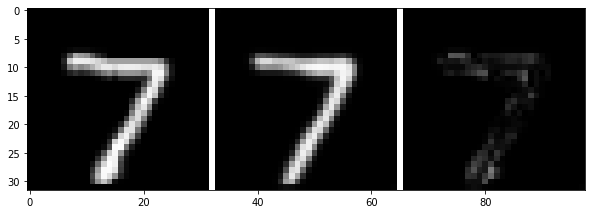

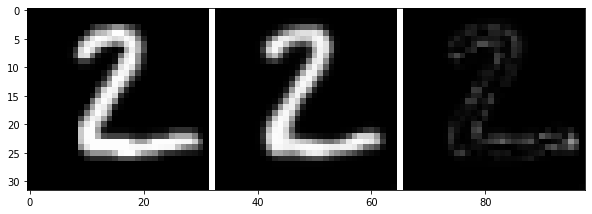

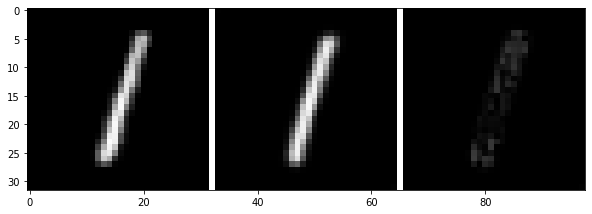

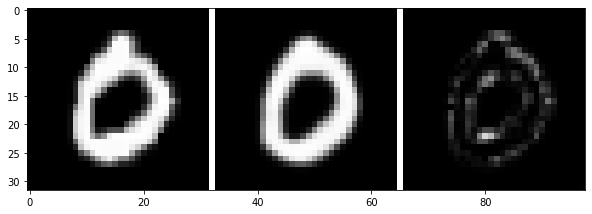

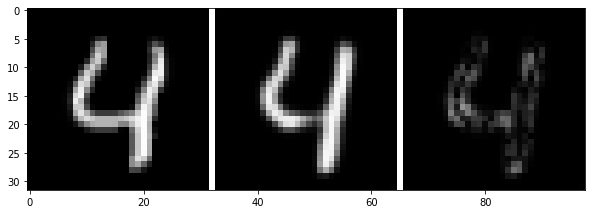

18/02/2020 20:24:08, epoch=36, step=4260, loss=0.06703, distortion=0.096, rate=0.026, -elbo=346.88751, nll=273.82739, KL=73.06011, commit_loss=674.39856, bit_usage=0.83217, highest_prob=0.019, temp=0.50667
reset code 224
18/02/2020 20:24:09, epoch=36, step=4280, loss=0.06748, distortion=0.097, rate=0.026, -elbo=348.78455, nll=275.65747, KL=73.12708, commit_loss=676.15442, bit_usage=0.83272, highest_prob=0.019, temp=0.50592
reset code 240
pruned code 240 - 404 remain
18/02/2020 20:24:09, epoch=36, step=4300, loss=0.06894, distortion=0.099, rate=0.026, -elbo=354.79752, nll=281.63028, KL=73.16723, commit_loss=674.80884, bit_usage=0.83306, highest_prob=0.020, temp=0.50517
reset code 288
18/02/2020 20:24:10, epoch=36, step=4320, loss=0.06841, distortion=0.098, rate=0.026, -elbo=352.94519, nll=279.46951, KL=73.47568, commit_loss=676.11902, bit_usage=0.83251, highest_prob=0.019, temp=0.50441
reset code 304
pruned code 304 - 403 remain
18/02/2020 20:24:10, epoch=36, step=4340, loss=0.06868, di

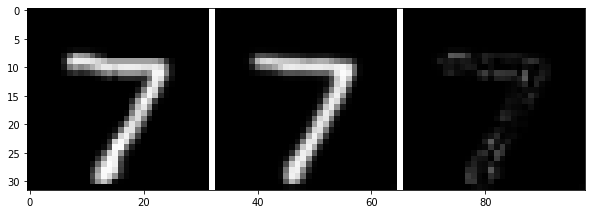

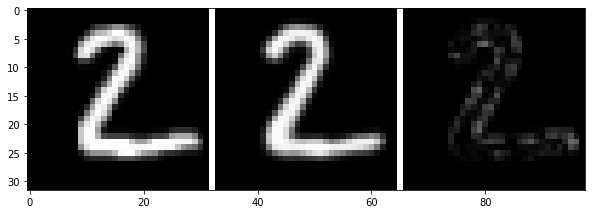

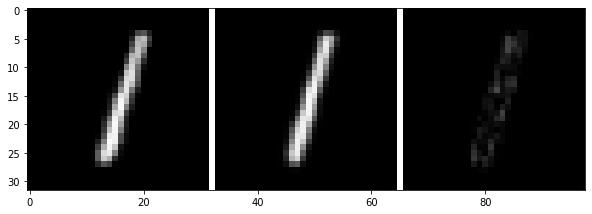

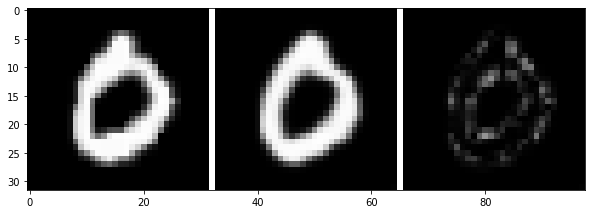

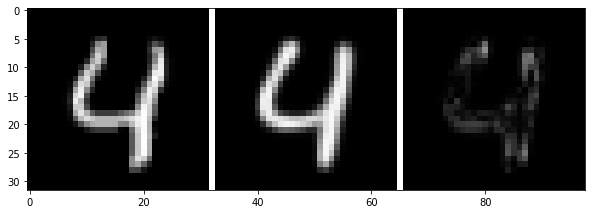

18/02/2020 20:24:22, epoch=41, step=4840, loss=0.06479, distortion=0.093, rate=0.026, -elbo=337.15100, nll=264.61530, KL=72.53571, commit_loss=675.38135, bit_usage=0.85530, highest_prob=0.018, temp=0.48485
reset code 304
pruned code 304 - 390 remain
18/02/2020 20:24:23, epoch=41, step=4860, loss=0.06392, distortion=0.092, rate=0.026, -elbo=333.73444, nll=261.06110, KL=72.67334, commit_loss=680.29065, bit_usage=0.85424, highest_prob=0.017, temp=0.48409
reset code 304
18/02/2020 20:24:23, epoch=41, step=4880, loss=0.06478, distortion=0.093, rate=0.026, -elbo=337.25769, nll=264.60022, KL=72.65749, commit_loss=678.06305, bit_usage=0.85625, highest_prob=0.016, temp=0.48334
reset code 320
pruned code 320 - 389 remain
18/02/2020 20:24:23, epoch=41, step=4900, loss=0.06435, distortion=0.093, rate=0.026, -elbo=335.31458, nll=262.81128, KL=72.50328, commit_loss=678.97583, bit_usage=0.85707, highest_prob=0.019, temp=0.48259
reset code 320
18/02/2020 20:24:24, epoch=41, step=4920, loss=0.06372, di

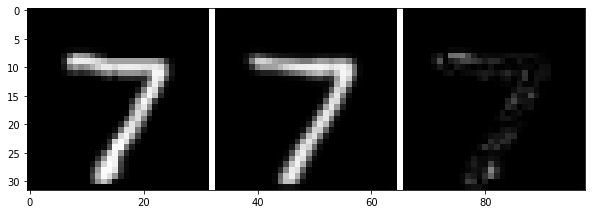

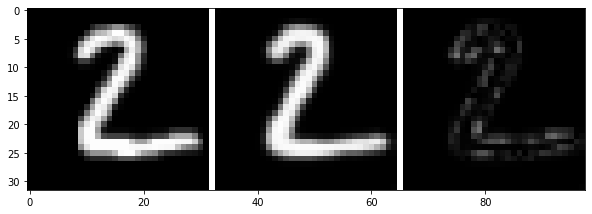

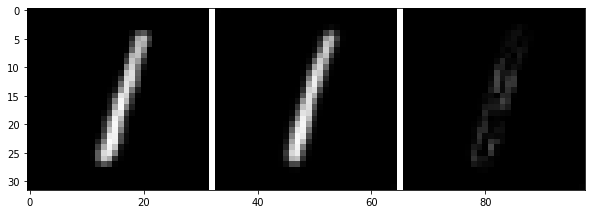

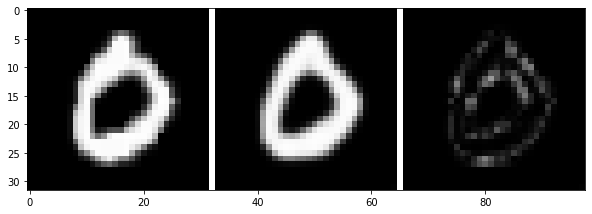

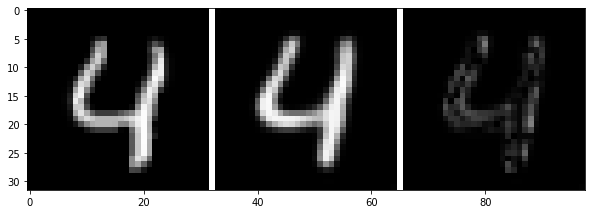

18/02/2020 20:24:38, epoch=46, step=5440, loss=0.06220, distortion=0.089, rate=0.025, -elbo=326.22507, nll=254.03743, KL=72.18764, commit_loss=676.69128, bit_usage=0.87657, highest_prob=0.014, temp=0.46227
reset code 368
pruned code 368 - 375 remain
18/02/2020 20:24:38, epoch=46, step=5460, loss=0.06168, distortion=0.089, rate=0.025, -elbo=323.83072, nll=251.87646, KL=71.95425, commit_loss=681.61597, bit_usage=0.87661, highest_prob=0.016, temp=0.46152
reset code 368
18/02/2020 20:24:38, epoch=46, step=5480, loss=0.06051, distortion=0.087, rate=0.025, -elbo=319.09790, nll=247.08511, KL=72.01277, commit_loss=684.53735, bit_usage=0.87707, highest_prob=0.015, temp=0.46077
reset code 88
pruned code 88 - 374 remain
18/02/2020 20:24:39, epoch=46, step=5500, loss=0.05991, distortion=0.086, rate=0.025, -elbo=316.54196, nll=244.63409, KL=71.90788, commit_loss=677.90314, bit_usage=0.87546, highest_prob=0.015, temp=0.46001
reset code 128
18/02/2020 20:24:39, epoch=46, step=5520, loss=0.06000, dist

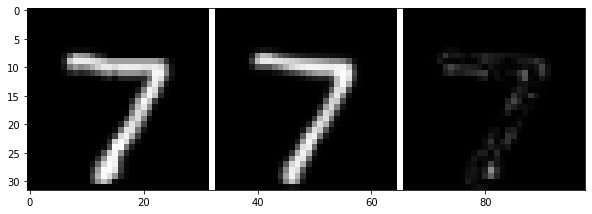

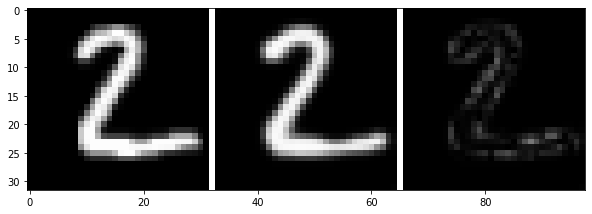

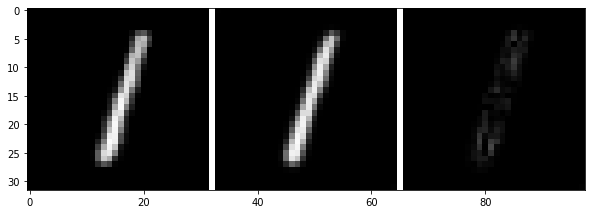

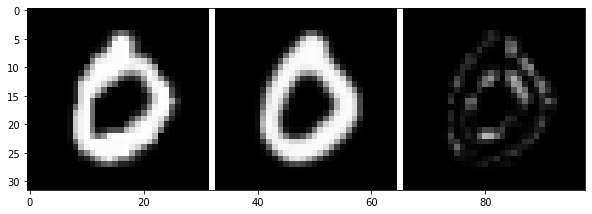

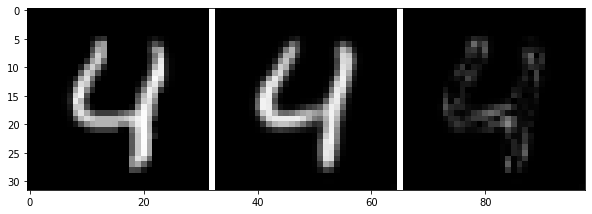

18/02/2020 20:24:52, epoch=51, step=6020, loss=0.05919, distortion=0.085, rate=0.025, -elbo=313.13849, nll=241.67874, KL=71.45973, commit_loss=681.17529, bit_usage=0.89091, highest_prob=0.014, temp=0.44045
reset code 304
18/02/2020 20:24:53, epoch=51, step=6040, loss=0.06005, distortion=0.086, rate=0.025, -elbo=316.70203, nll=245.20242, KL=71.49960, commit_loss=683.81317, bit_usage=0.89157, highest_prob=0.013, temp=0.43969
reset code 320
pruned code 320 - 360 remain
18/02/2020 20:24:53, epoch=51, step=6060, loss=0.05714, distortion=0.082, rate=0.025, -elbo=304.65479, nll=233.29080, KL=71.36397, commit_loss=681.02417, bit_usage=0.89156, highest_prob=0.012, temp=0.43894
reset code 320
18/02/2020 20:24:54, epoch=51, step=6080, loss=0.05784, distortion=0.083, rate=0.025, -elbo=307.64487, nll=236.13995, KL=71.50491, commit_loss=684.34155, bit_usage=0.89196, highest_prob=0.015, temp=0.43819
reset code 336
pruned code 336 - 359 remain
18/02/2020 20:24:54, epoch=51, step=6100, loss=0.05814, di

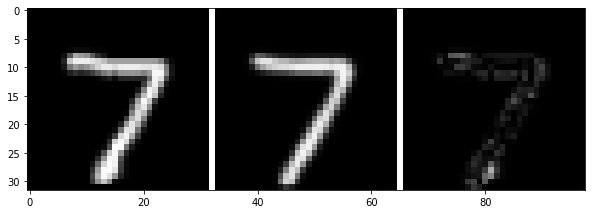

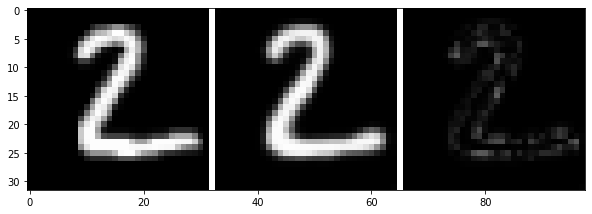

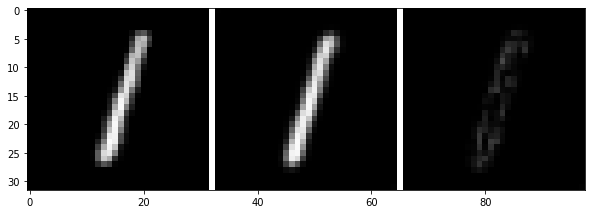

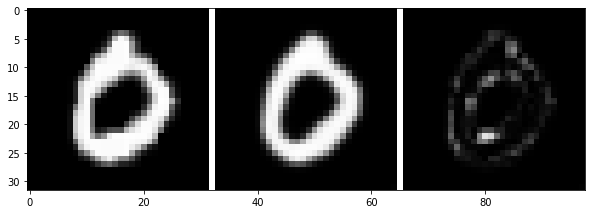

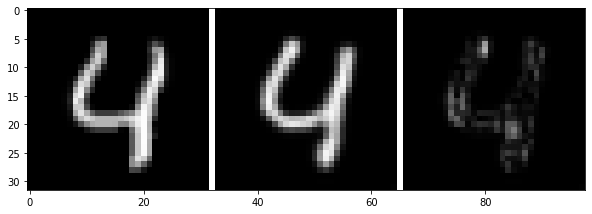

18/02/2020 20:25:08, epoch=56, step=6620, loss=0.05650, distortion=0.081, rate=0.025, -elbo=301.62088, nll=230.67923, KL=70.94166, commit_loss=683.30310, bit_usage=0.90607, highest_prob=0.012, temp=0.41787
reset code 240
18/02/2020 20:25:08, epoch=56, step=6640, loss=0.05708, distortion=0.082, rate=0.025, -elbo=303.82642, nll=233.03741, KL=70.78900, commit_loss=684.50751, bit_usage=0.90663, highest_prob=0.012, temp=0.41712
reset code 304
pruned code 304 - 345 remain
18/02/2020 20:25:09, epoch=56, step=6660, loss=0.05528, distortion=0.079, rate=0.025, -elbo=296.29620, nll=225.66351, KL=70.63268, commit_loss=677.64325, bit_usage=0.90627, highest_prob=0.012, temp=0.41637
reset code 304
18/02/2020 20:25:09, epoch=56, step=6680, loss=0.05605, distortion=0.081, rate=0.025, -elbo=299.70444, nll=228.82544, KL=70.87900, commit_loss=680.42615, bit_usage=0.90580, highest_prob=0.012, temp=0.41561
reset code 216
pruned code 216 - 344 remain
18/02/2020 20:25:09, epoch=56, step=6700, loss=0.05588, di

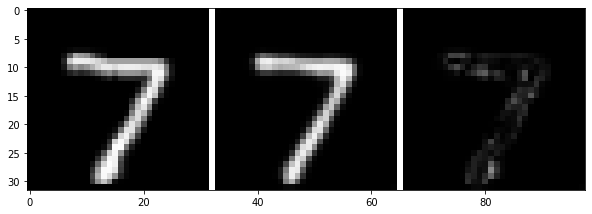

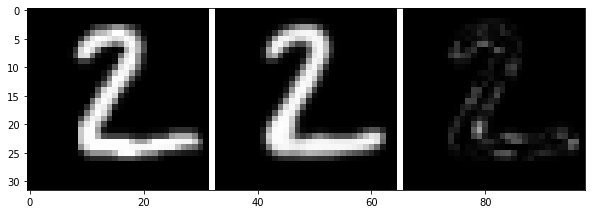

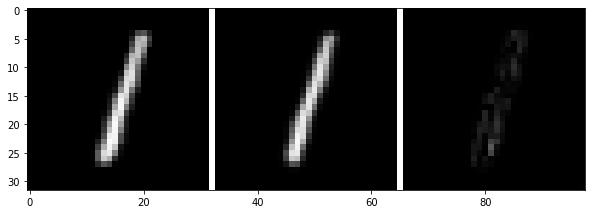

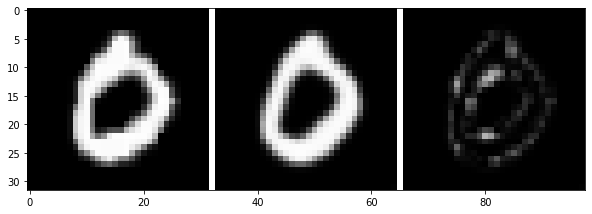

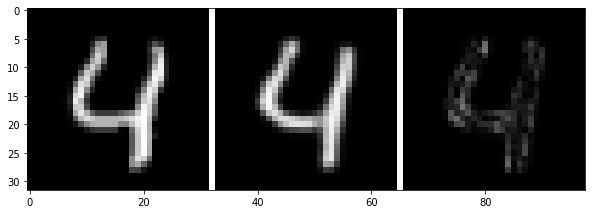

18/02/2020 20:25:23, epoch=61, step=7200, loss=0.05506, distortion=0.079, rate=0.025, -elbo=295.61011, nll=224.79050, KL=70.81960, commit_loss=676.77686, bit_usage=0.91482, highest_prob=0.012, temp=0.39605
reset code 112
pruned code 112 - 331 remain
18/02/2020 20:25:23, epoch=61, step=7220, loss=0.05444, distortion=0.078, rate=0.025, -elbo=293.01062, nll=222.24344, KL=70.76720, commit_loss=678.76270, bit_usage=0.91598, highest_prob=0.011, temp=0.39529
reset code 144
18/02/2020 20:25:24, epoch=61, step=7240, loss=0.05537, distortion=0.080, rate=0.025, -elbo=296.74652, nll=226.03943, KL=70.70708, commit_loss=676.34198, bit_usage=0.91594, highest_prob=0.011, temp=0.39454
reset code 176
pruned code 176 - 330 remain
18/02/2020 20:25:24, epoch=61, step=7260, loss=0.05542, distortion=0.080, rate=0.025, -elbo=297.19702, nll=226.25696, KL=70.94008, commit_loss=677.46838, bit_usage=0.91560, highest_prob=0.011, temp=0.39379
reset code 8
18/02/2020 20:25:25, epoch=61, step=7280, loss=0.05547, dist

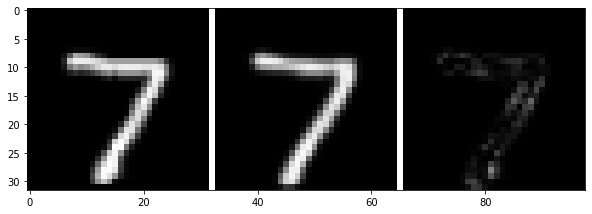

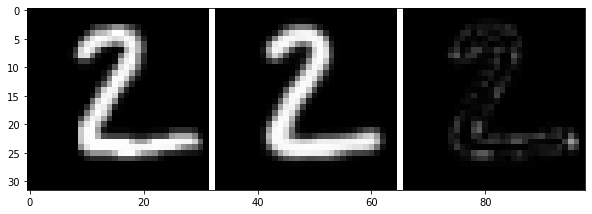

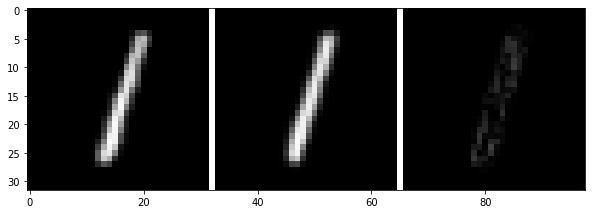

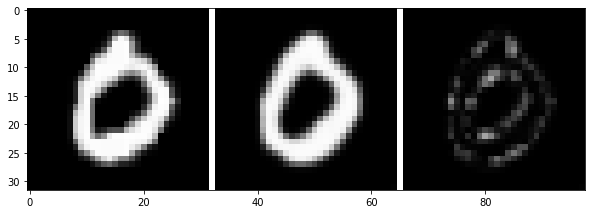

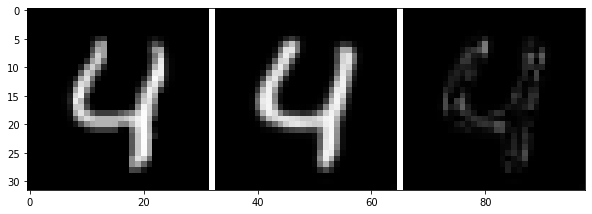

18/02/2020 20:25:39, epoch=66, step=7800, loss=0.05356, distortion=0.077, rate=0.025, -elbo=288.87299, nll=218.62103, KL=70.25197, commit_loss=677.20435, bit_usage=0.92459, highest_prob=0.013, temp=0.37347
reset code 192
pruned code 192 - 316 remain
18/02/2020 20:25:39, epoch=66, step=7820, loss=0.05299, distortion=0.076, rate=0.025, -elbo=286.47635, nll=216.30267, KL=70.17367, commit_loss=676.57129, bit_usage=0.92415, highest_prob=0.012, temp=0.37272
reset code 224
18/02/2020 20:25:40, epoch=66, step=7840, loss=0.05381, distortion=0.077, rate=0.025, -elbo=290.08484, nll=219.65509, KL=70.42975, commit_loss=679.47339, bit_usage=0.92482, highest_prob=0.012, temp=0.37197
reset code 240
pruned code 240 - 315 remain
18/02/2020 20:25:40, epoch=66, step=7860, loss=0.05346, distortion=0.077, rate=0.025, -elbo=288.50687, nll=218.20132, KL=70.30554, commit_loss=682.23224, bit_usage=0.92441, highest_prob=0.012, temp=0.37121
reset code 256
18/02/2020 20:25:41, epoch=66, step=7880, loss=0.05412, di

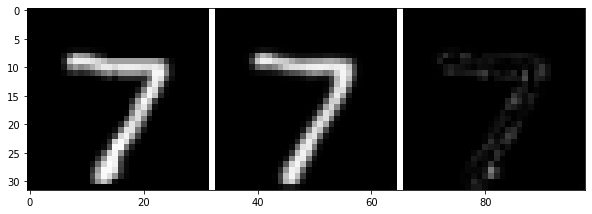

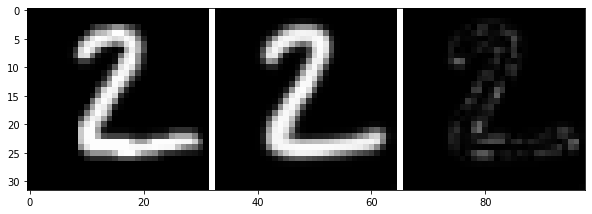

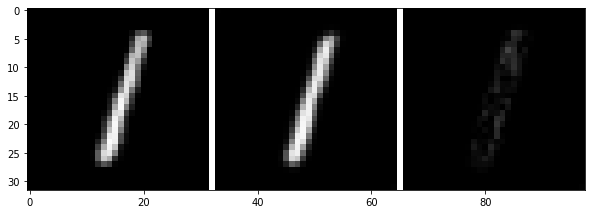

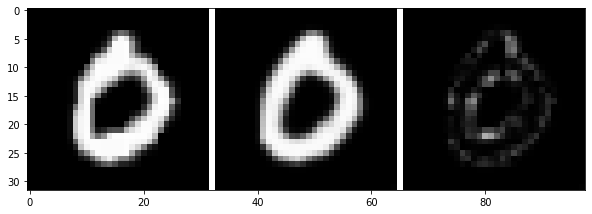

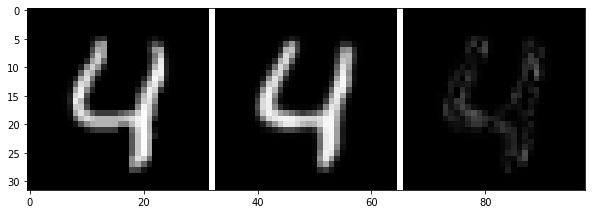

18/02/2020 20:25:54, epoch=71, step=8380, loss=0.05174, distortion=0.074, rate=0.025, -elbo=280.96738, nll=211.18921, KL=69.77817, commit_loss=676.26611, bit_usage=0.93073, highest_prob=0.012, temp=0.35165
reset code 288
18/02/2020 20:25:55, epoch=71, step=8400, loss=0.05273, distortion=0.076, rate=0.025, -elbo=285.44482, nll=215.24718, KL=70.19764, commit_loss=678.68225, bit_usage=0.93066, highest_prob=0.011, temp=0.35089
reset code 104
pruned code 104 - 301 remain
18/02/2020 20:25:55, epoch=71, step=8420, loss=0.05339, distortion=0.077, rate=0.025, -elbo=287.97510, nll=217.95551, KL=70.01959, commit_loss=679.92285, bit_usage=0.93167, highest_prob=0.011, temp=0.35014
reset code 112
18/02/2020 20:25:55, epoch=71, step=8440, loss=0.05242, distortion=0.075, rate=0.025, -elbo=283.83936, nll=213.95717, KL=69.88217, commit_loss=681.72766, bit_usage=0.93181, highest_prob=0.011, temp=0.34939
reset code 128
pruned code 128 - 300 remain
18/02/2020 20:25:56, epoch=71, step=8460, loss=0.05148, di

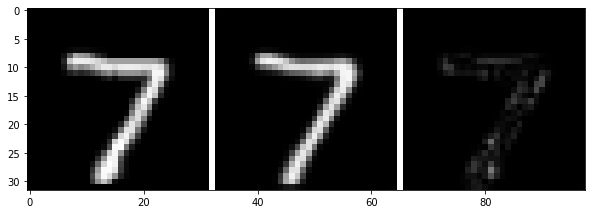

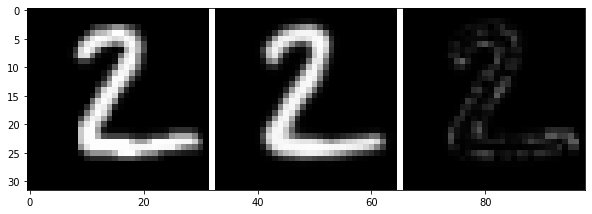

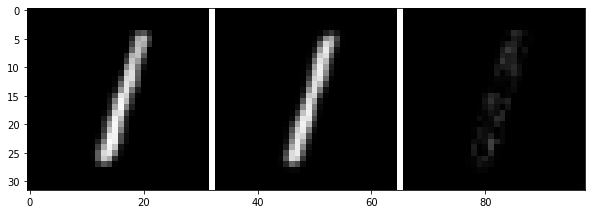

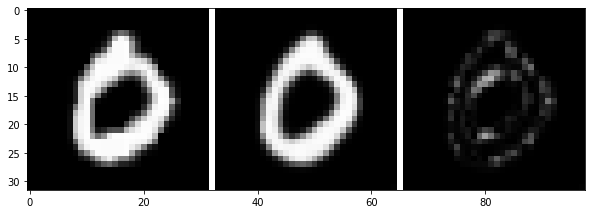

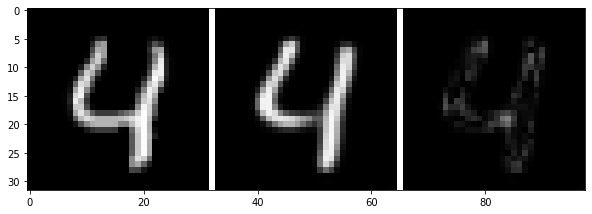

18/02/2020 20:26:10, epoch=76, step=8980, loss=0.04993, distortion=0.072, rate=0.024, -elbo=272.79449, nll=203.77878, KL=69.01570, commit_loss=685.73828, bit_usage=0.94205, highest_prob=0.010, temp=0.32907
reset code 56
18/02/2020 20:26:10, epoch=76, step=9000, loss=0.04997, distortion=0.072, rate=0.024, -elbo=272.94415, nll=203.91177, KL=69.03238, commit_loss=682.05304, bit_usage=0.94456, highest_prob=0.010, temp=0.32832
reset code 136
pruned code 136 - 286 remain
18/02/2020 20:26:11, epoch=76, step=9020, loss=0.05014, distortion=0.072, rate=0.024, -elbo=273.57068, nll=204.60712, KL=68.96355, commit_loss=677.59912, bit_usage=0.94370, highest_prob=0.011, temp=0.32757
reset code 168
18/02/2020 20:26:11, epoch=76, step=9040, loss=0.05046, distortion=0.073, rate=0.024, -elbo=274.94635, nll=205.91859, KL=69.02777, commit_loss=679.71820, bit_usage=0.94355, highest_prob=0.011, temp=0.32681
reset code 264
pruned code 264 - 285 remain
18/02/2020 20:26:12, epoch=76, step=9060, loss=0.05027, dis

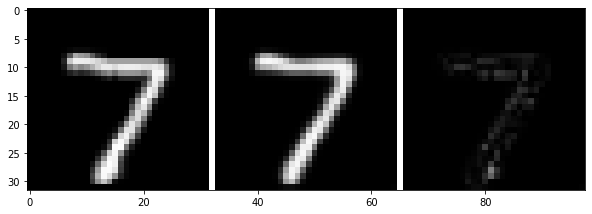

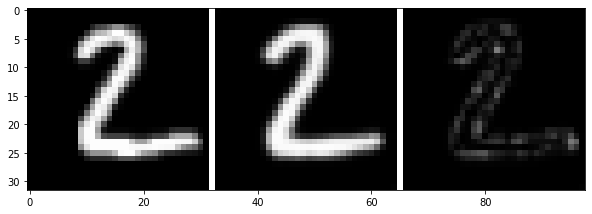

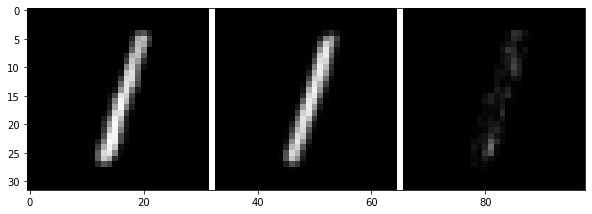

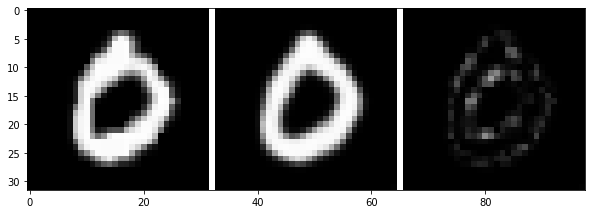

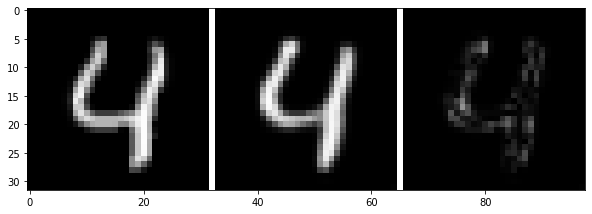

18/02/2020 20:26:25, epoch=81, step=9560, loss=0.04928, distortion=0.071, rate=0.024, -elbo=269.35730, nll=201.11465, KL=68.24265, commit_loss=677.19092, bit_usage=0.95117, highest_prob=0.010, temp=0.30725
reset code 104
pruned code 104 - 272 remain
18/02/2020 20:26:25, epoch=81, step=9580, loss=0.05029, distortion=0.072, rate=0.024, -elbo=273.61780, nll=205.22054, KL=68.39728, commit_loss=680.82178, bit_usage=0.95123, highest_prob=0.010, temp=0.30649
reset code 52
18/02/2020 20:26:26, epoch=81, step=9600, loss=0.05062, distortion=0.073, rate=0.024, -elbo=274.84488, nll=206.60858, KL=68.23631, commit_loss=677.37097, bit_usage=0.95286, highest_prob=0.009, temp=0.30574
reset code 100
pruned code 100 - 271 remain
18/02/2020 20:26:26, epoch=81, step=9620, loss=0.04929, distortion=0.071, rate=0.024, -elbo=269.32861, nll=201.16107, KL=68.16753, commit_loss=673.31799, bit_usage=0.95190, highest_prob=0.010, temp=0.30499
reset code 104
18/02/2020 20:26:27, epoch=81, step=9640, loss=0.05019, dis

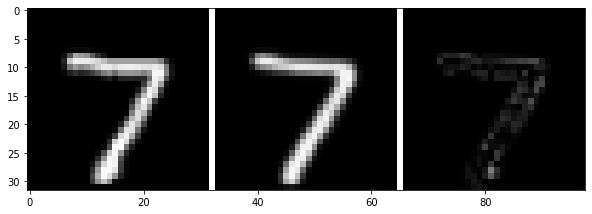

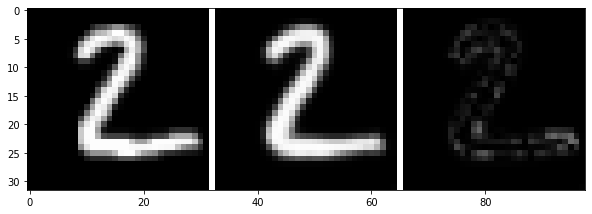

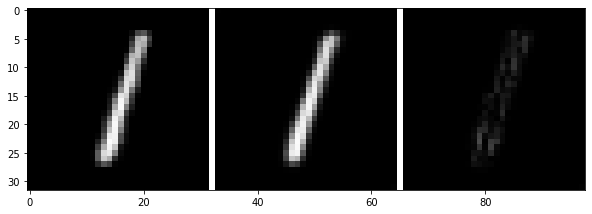

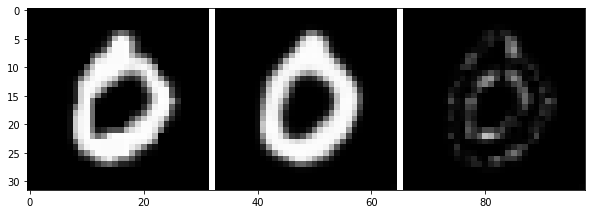

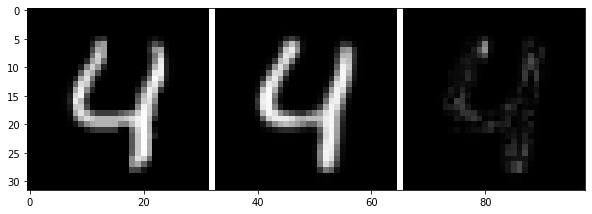

18/02/2020 20:26:40, epoch=86, step=10160, loss=0.04795, distortion=0.069, rate=0.024, -elbo=263.42145, nll=195.64078, KL=67.78067, commit_loss=680.68591, bit_usage=0.95643, highest_prob=0.009, temp=0.28467
reset code 150
pruned code 150 - 257 remain
18/02/2020 20:26:41, epoch=86, step=10180, loss=0.05096, distortion=0.073, rate=0.024, -elbo=276.01721, nll=207.97900, KL=68.03819, commit_loss=679.66089, bit_usage=0.95672, highest_prob=0.010, temp=0.28392
reset code 16
18/02/2020 20:26:41, epoch=86, step=10200, loss=0.04806, distortion=0.069, rate=0.024, -elbo=264.00485, nll=196.11311, KL=67.89174, commit_loss=677.21045, bit_usage=0.95568, highest_prob=0.012, temp=0.28317
reset code 63
pruned code 63 - 256 remain
18/02/2020 20:26:41, epoch=86, step=10220, loss=0.04745, distortion=0.068, rate=0.024, -elbo=261.11273, nll=193.61530, KL=67.49744, commit_loss=677.06177, bit_usage=0.95731, highest_prob=0.009, temp=0.28241
reset code 65
18/02/2020 20:26:42, epoch=86, step=10240, loss=0.04830, d

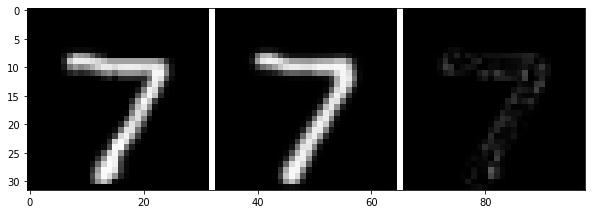

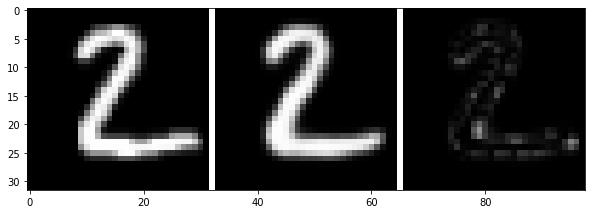

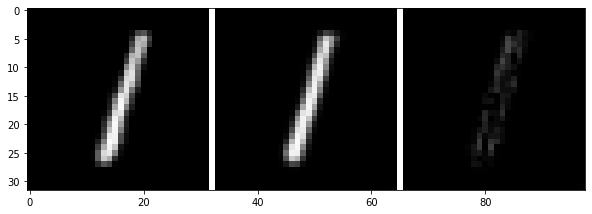

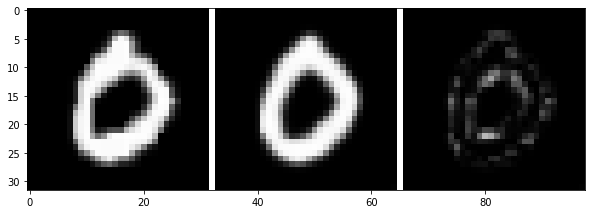

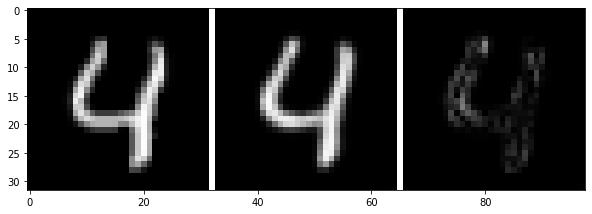

18/02/2020 20:26:55, epoch=91, step=10740, loss=0.04878, distortion=0.070, rate=0.024, -elbo=266.61285, nll=199.05190, KL=67.56096, commit_loss=681.95874, bit_usage=0.96573, highest_prob=0.010, temp=0.26285
reset code 7
18/02/2020 20:26:55, epoch=91, step=10760, loss=0.04721, distortion=0.068, rate=0.024, -elbo=260.16156, nll=192.62244, KL=67.53913, commit_loss=680.13177, bit_usage=0.96755, highest_prob=0.009, temp=0.26209
reset code 147
18/02/2020 20:26:56, epoch=91, step=10780, loss=0.04876, distortion=0.070, rate=0.024, -elbo=266.65710, nll=198.98849, KL=67.66861, commit_loss=681.20471, bit_usage=0.96734, highest_prob=0.009, temp=0.26134
reset code 50
18/02/2020 20:26:56, epoch=91, step=10800, loss=0.04902, distortion=0.070, rate=0.024, -elbo=267.58282, nll=200.03281, KL=67.55003, commit_loss=677.09717, bit_usage=0.96675, highest_prob=0.009, temp=0.26059
reset code 12
18/02/2020 20:26:57, epoch=91, step=10820, loss=0.04961, distortion=0.071, rate=0.024, -elbo=270.18448, nll=202.4591

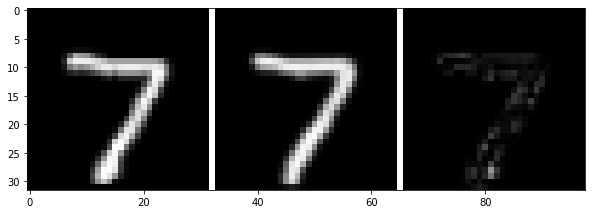

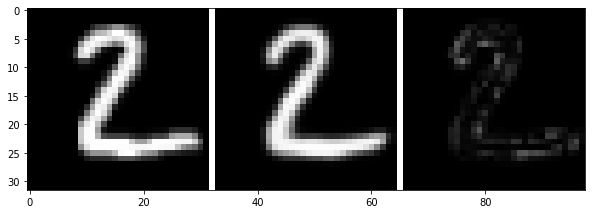

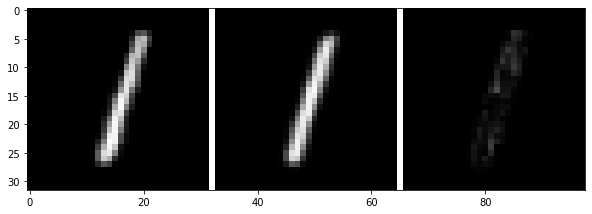

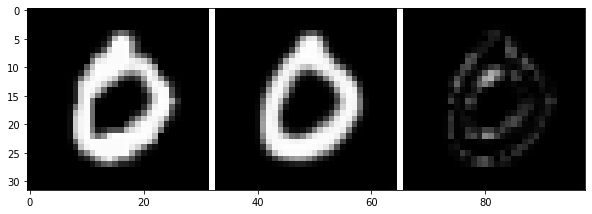

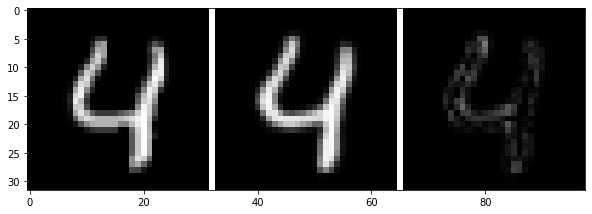

18/02/2020 20:27:09, epoch=96, step=11340, loss=0.04743, distortion=0.068, rate=0.024, -elbo=261.37799, nll=193.54343, KL=67.83456, commit_loss=674.58740, bit_usage=0.97086, highest_prob=0.008, temp=0.24027
reset code 250
18/02/2020 20:27:09, epoch=96, step=11360, loss=0.04764, distortion=0.068, rate=0.024, -elbo=262.22083, nll=194.38889, KL=67.83194, commit_loss=681.53503, bit_usage=0.97184, highest_prob=0.008, temp=0.23952
18/02/2020 20:27:10, epoch=96, step=11380, loss=0.04862, distortion=0.070, rate=0.024, -elbo=266.40146, nll=198.41800, KL=67.98347, commit_loss=673.31006, bit_usage=0.97117, highest_prob=0.009, temp=0.23877
reset code 68
18/02/2020 20:27:10, epoch=96, step=11400, loss=0.04812, distortion=0.069, rate=0.024, -elbo=264.15021, nll=196.36966, KL=67.78055, commit_loss=675.18341, bit_usage=0.97274, highest_prob=0.008, temp=0.23801
18/02/2020 20:27:10, epoch=96, step=11420, loss=0.04877, distortion=0.070, rate=0.024, -elbo=267.05896, nll=199.01204, KL=68.04691, commit_loss

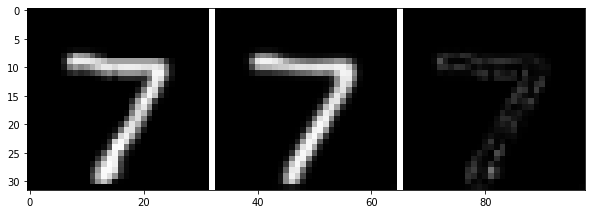

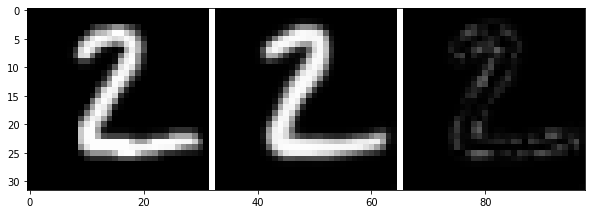

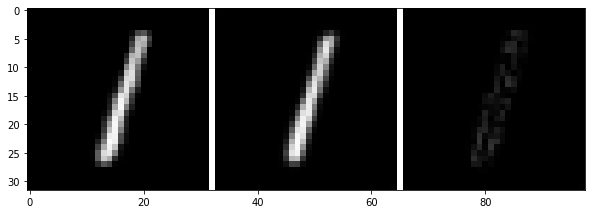

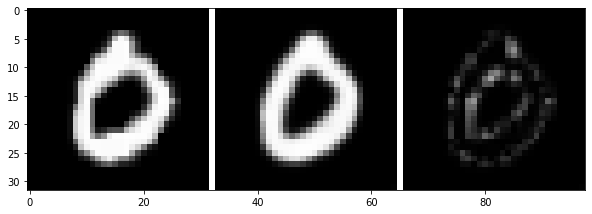

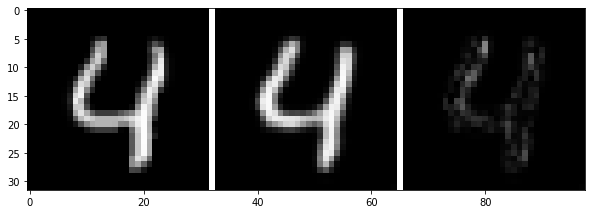

18/02/2020 20:27:22, epoch=101, step=11920, loss=0.04752, distortion=0.068, rate=0.024, -elbo=262.47089, nll=193.88443, KL=68.58646, commit_loss=674.38098, bit_usage=0.96894, highest_prob=0.010, temp=0.21845
reset code 14
18/02/2020 20:27:23, epoch=101, step=11940, loss=0.04817, distortion=0.069, rate=0.024, -elbo=265.19696, nll=196.54013, KL=68.65685, commit_loss=681.99762, bit_usage=0.97168, highest_prob=0.008, temp=0.21769
18/02/2020 20:27:23, epoch=101, step=11960, loss=0.04692, distortion=0.067, rate=0.024, -elbo=260.34793, nll=191.44417, KL=68.90377, commit_loss=672.77948, bit_usage=0.96924, highest_prob=0.010, temp=0.21694
18/02/2020 20:27:24, epoch=101, step=11980, loss=0.04829, distortion=0.069, rate=0.024, -elbo=265.89899, nll=197.04927, KL=68.84973, commit_loss=678.73242, bit_usage=0.97041, highest_prob=0.009, temp=0.21619
18/02/2020 20:27:24, epoch=101, step=12000, loss=0.04913, distortion=0.071, rate=0.024, -elbo=269.56482, nll=200.50424, KL=69.06059, commit_loss=681.11316

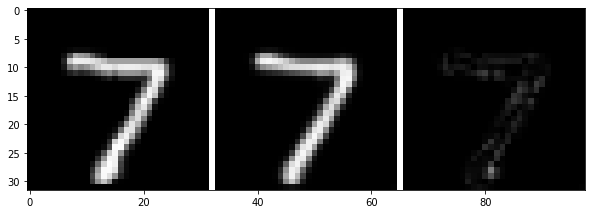

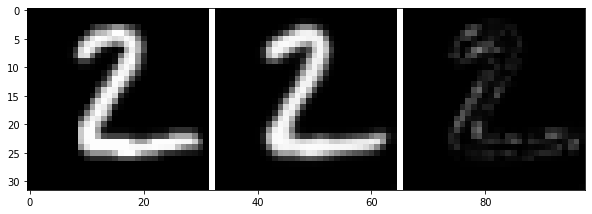

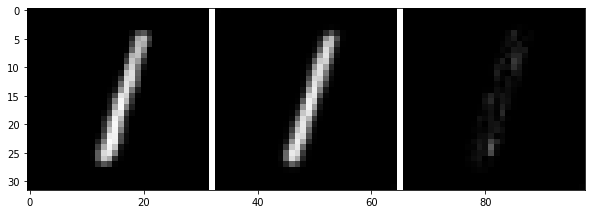

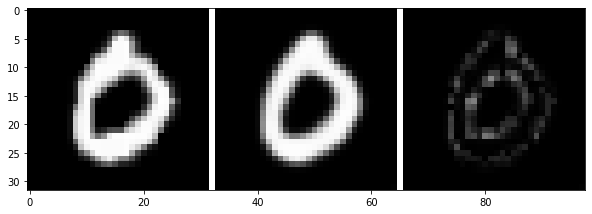

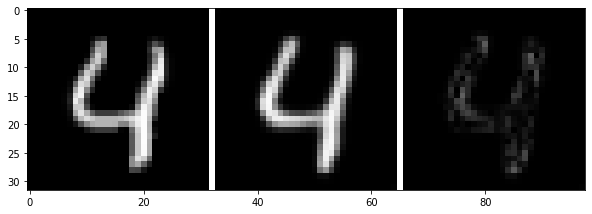

18/02/2020 20:27:38, epoch=106, step=12520, loss=0.04854, distortion=0.070, rate=0.025, -elbo=267.65839, nll=198.05524, KL=69.60313, commit_loss=678.54547, bit_usage=0.96636, highest_prob=0.009, temp=0.19587
18/02/2020 20:27:38, epoch=106, step=12540, loss=0.04773, distortion=0.069, rate=0.025, -elbo=264.36383, nll=194.77315, KL=69.59070, commit_loss=679.81079, bit_usage=0.96694, highest_prob=0.010, temp=0.19512
18/02/2020 20:27:39, epoch=106, step=12560, loss=0.04810, distortion=0.069, rate=0.024, -elbo=265.78644, nll=196.27219, KL=69.51425, commit_loss=682.25989, bit_usage=0.96547, highest_prob=0.010, temp=0.19437
18/02/2020 20:27:39, epoch=106, step=12580, loss=0.04678, distortion=0.067, rate=0.025, -elbo=260.52649, nll=190.85890, KL=69.66757, commit_loss=673.16119, bit_usage=0.96820, highest_prob=0.009, temp=0.19361
18/02/2020 20:27:40, epoch=106, step=12600, loss=0.04842, distortion=0.070, rate=0.024, -elbo=266.97583, nll=197.56451, KL=69.41130, commit_loss=674.30573, bit_usage=0.

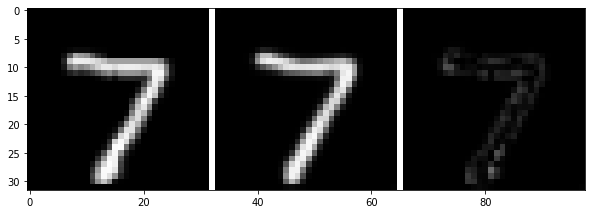

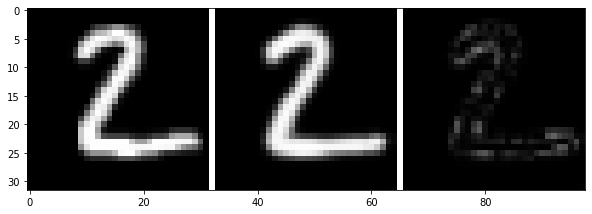

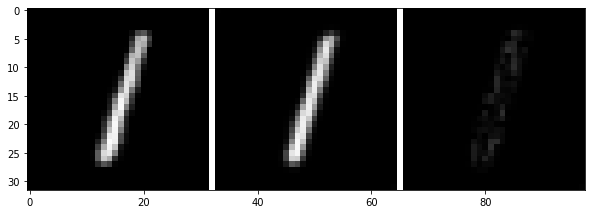

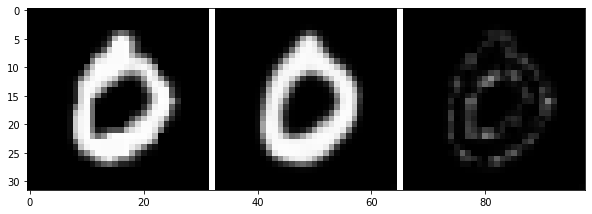

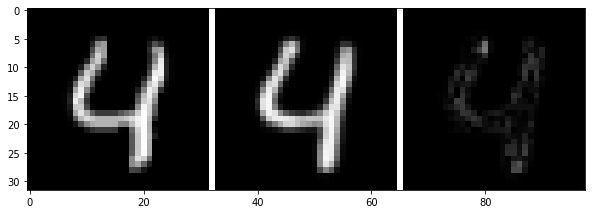

18/02/2020 20:27:53, epoch=111, step=13100, loss=0.04751, distortion=0.068, rate=0.025, -elbo=263.73404, nll=193.87785, KL=69.85619, commit_loss=673.45038, bit_usage=0.96927, highest_prob=0.009, temp=0.17405
18/02/2020 20:27:53, epoch=111, step=13120, loss=0.04626, distortion=0.066, rate=0.025, -elbo=258.57336, nll=188.73578, KL=69.83759, commit_loss=678.08997, bit_usage=0.96869, highest_prob=0.009, temp=0.17329
18/02/2020 20:27:54, epoch=111, step=13140, loss=0.04797, distortion=0.069, rate=0.025, -elbo=265.84146, nll=195.73901, KL=70.10245, commit_loss=679.18866, bit_usage=0.96764, highest_prob=0.009, temp=0.17254
18/02/2020 20:27:54, epoch=111, step=13160, loss=0.04742, distortion=0.068, rate=0.025, -elbo=263.64789, nll=193.48387, KL=70.16401, commit_loss=678.06903, bit_usage=0.96732, highest_prob=0.009, temp=0.17179
18/02/2020 20:27:55, epoch=111, step=13180, loss=0.04713, distortion=0.068, rate=0.025, -elbo=262.46640, nll=192.30254, KL=70.16386, commit_loss=676.67291, bit_usage=0.

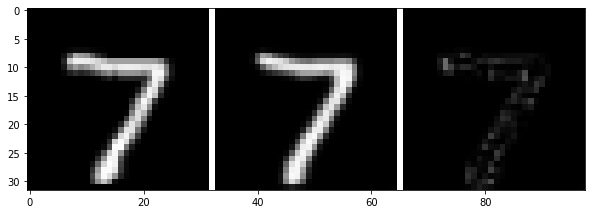

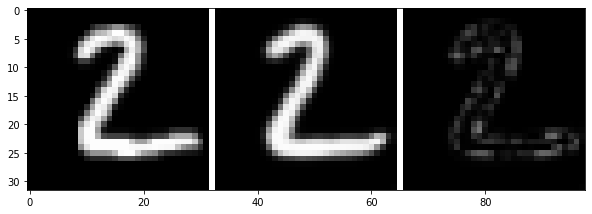

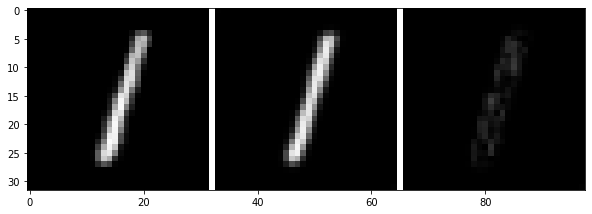

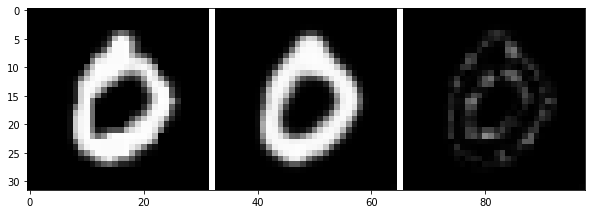

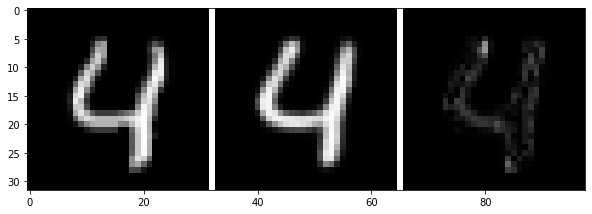

18/02/2020 20:28:08, epoch=116, step=13700, loss=0.04580, distortion=0.066, rate=0.025, -elbo=257.22772, nll=186.84659, KL=70.38112, commit_loss=680.44684, bit_usage=0.96785, highest_prob=0.011, temp=0.15147
reset code 57
18/02/2020 20:28:08, epoch=116, step=13720, loss=0.04566, distortion=0.066, rate=0.025, -elbo=256.59671, nll=186.26498, KL=70.33173, commit_loss=674.52692, bit_usage=0.96878, highest_prob=0.010, temp=0.15072
18/02/2020 20:28:09, epoch=116, step=13740, loss=0.04592, distortion=0.066, rate=0.025, -elbo=257.99396, nll=187.35806, KL=70.63591, commit_loss=670.87939, bit_usage=0.96748, highest_prob=0.009, temp=0.14997
reset code 250
18/02/2020 20:28:09, epoch=116, step=13760, loss=0.04601, distortion=0.066, rate=0.025, -elbo=258.22290, nll=187.70105, KL=70.52187, commit_loss=676.78491, bit_usage=0.96946, highest_prob=0.009, temp=0.14921
18/02/2020 20:28:10, epoch=116, step=13780, loss=0.04538, distortion=0.065, rate=0.025, -elbo=255.48079, nll=185.14078, KL=70.34001, commit

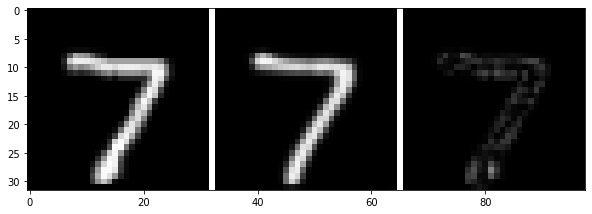

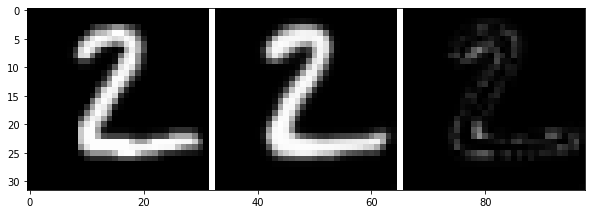

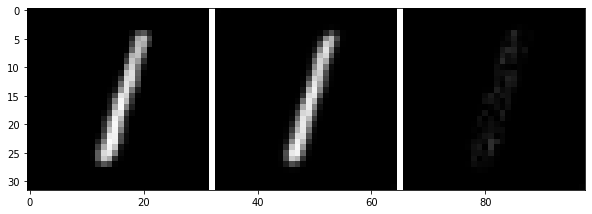

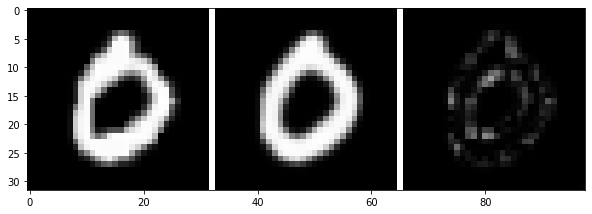

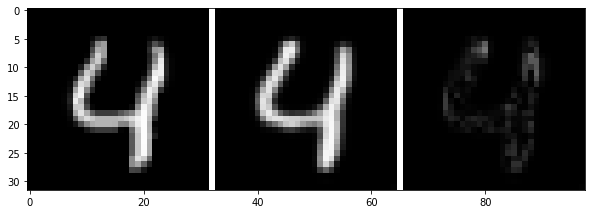

18/02/2020 20:28:22, epoch=121, step=14280, loss=0.04643, distortion=0.067, rate=0.025, -elbo=260.21982, nll=189.43031, KL=70.78951, commit_loss=684.04016, bit_usage=0.96958, highest_prob=0.010, temp=0.12965
18/02/2020 20:28:23, epoch=121, step=14300, loss=0.04703, distortion=0.068, rate=0.025, -elbo=262.68597, nll=191.88739, KL=70.79857, commit_loss=678.77283, bit_usage=0.96905, highest_prob=0.009, temp=0.12889
reset code 26
18/02/2020 20:28:23, epoch=121, step=14320, loss=0.04626, distortion=0.066, rate=0.025, -elbo=259.26630, nll=188.72293, KL=70.54335, commit_loss=667.68945, bit_usage=0.97001, highest_prob=0.009, temp=0.12814
18/02/2020 20:28:23, epoch=121, step=14340, loss=0.04602, distortion=0.066, rate=0.025, -elbo=258.55762, nll=187.76604, KL=70.79158, commit_loss=677.03040, bit_usage=0.97025, highest_prob=0.009, temp=0.12739
18/02/2020 20:28:24, epoch=121, step=14360, loss=0.04815, distortion=0.069, rate=0.025, -elbo=267.26532, nll=196.46881, KL=70.79651, commit_loss=676.06354

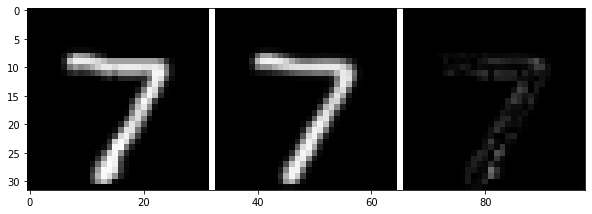

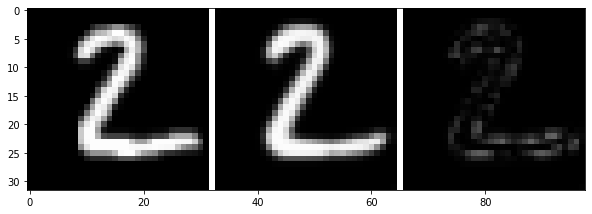

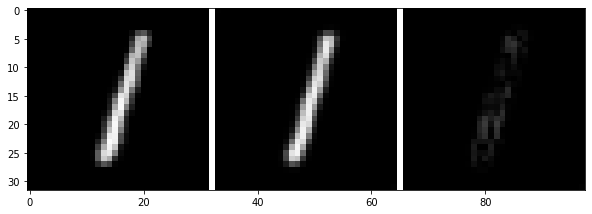

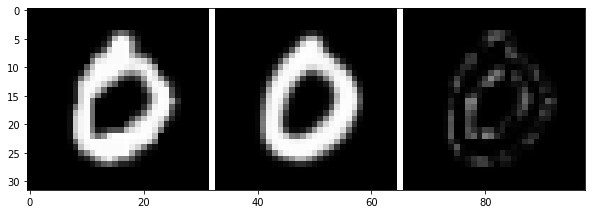

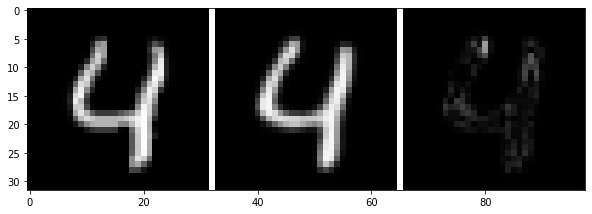

18/02/2020 20:28:37, epoch=126, step=14880, loss=0.04575, distortion=0.066, rate=0.025, -elbo=257.44504, nll=186.65578, KL=70.78925, commit_loss=671.58966, bit_usage=0.97042, highest_prob=0.010, temp=0.10707
reset code 43
18/02/2020 20:28:37, epoch=126, step=14900, loss=0.04656, distortion=0.067, rate=0.025, -elbo=260.81735, nll=189.96014, KL=70.85722, commit_loss=673.11145, bit_usage=0.97077, highest_prob=0.009, temp=0.10632
18/02/2020 20:28:38, epoch=126, step=14920, loss=0.04639, distortion=0.067, rate=0.025, -elbo=260.02469, nll=189.27806, KL=70.74663, commit_loss=674.72919, bit_usage=0.97274, highest_prob=0.009, temp=0.10557
18/02/2020 20:28:38, epoch=126, step=14940, loss=0.04583, distortion=0.066, rate=0.025, -elbo=257.73471, nll=186.96959, KL=70.76512, commit_loss=672.03894, bit_usage=0.97223, highest_prob=0.009, temp=0.10481
18/02/2020 20:28:39, epoch=126, step=14960, loss=0.04738, distortion=0.068, rate=0.025, -elbo=264.09088, nll=193.31418, KL=70.77670, commit_loss=679.80054

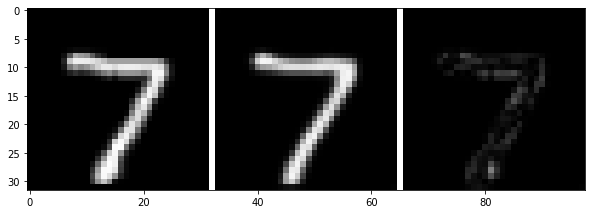

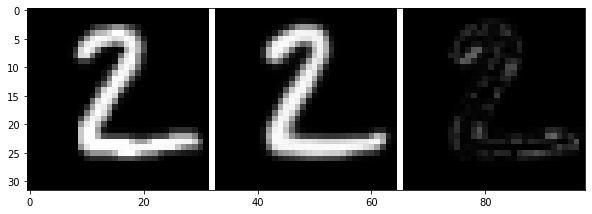

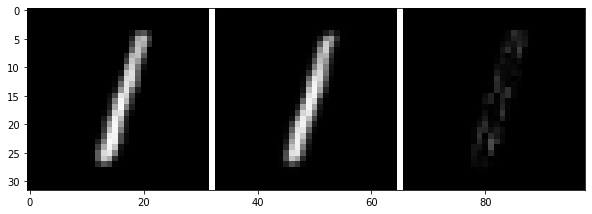

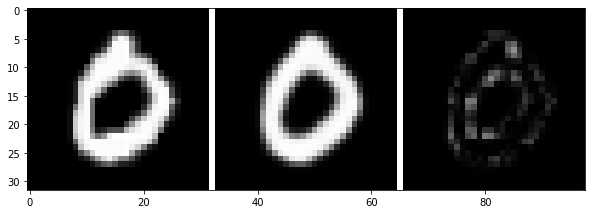

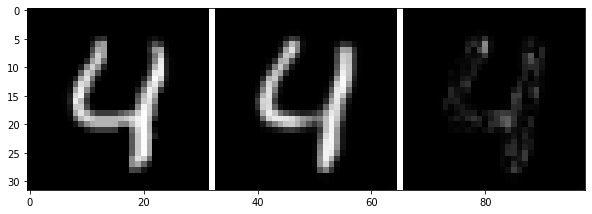

18/02/2020 20:28:52, epoch=131, step=15460, loss=0.04686, distortion=0.067, rate=0.025, -elbo=262.10101, nll=191.19295, KL=70.90805, commit_loss=670.58917, bit_usage=0.97321, highest_prob=0.010, temp=0.08525
18/02/2020 20:28:53, epoch=131, step=15480, loss=0.04523, distortion=0.065, rate=0.025, -elbo=255.24925, nll=184.52429, KL=70.72496, commit_loss=669.57275, bit_usage=0.97231, highest_prob=0.009, temp=0.08449
18/02/2020 20:28:53, epoch=131, step=15500, loss=0.04665, distortion=0.067, rate=0.025, -elbo=261.36380, nll=190.32826, KL=71.03554, commit_loss=679.21497, bit_usage=0.97299, highest_prob=0.009, temp=0.08374
18/02/2020 20:28:53, epoch=131, step=15520, loss=0.04605, distortion=0.066, rate=0.025, -elbo=258.68237, nll=187.89281, KL=70.78957, commit_loss=669.09937, bit_usage=0.97385, highest_prob=0.009, temp=0.08299
18/02/2020 20:28:54, epoch=131, step=15540, loss=0.04532, distortion=0.065, rate=0.025, -elbo=255.75302, nll=184.90511, KL=70.84792, commit_loss=670.82629, bit_usage=0.

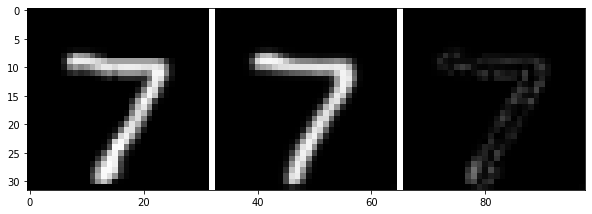

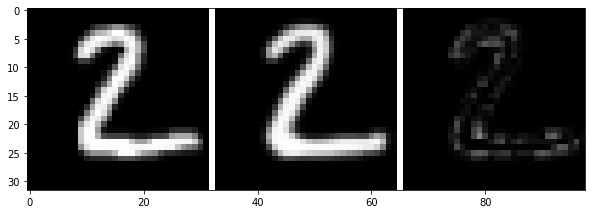

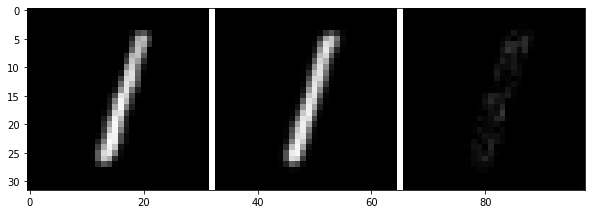

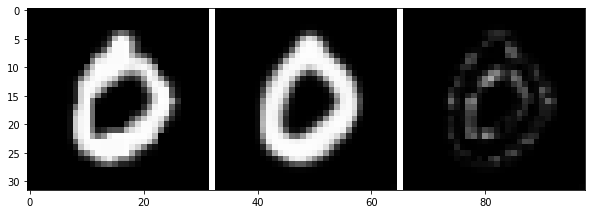

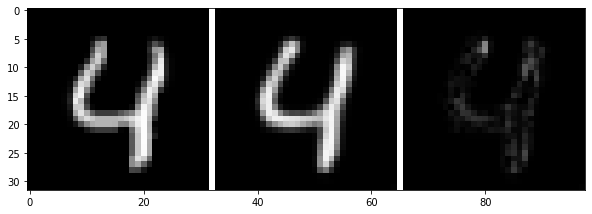

18/02/2020 20:29:07, epoch=136, step=16060, loss=0.04513, distortion=0.065, rate=0.025, -elbo=254.99751, nll=184.10529, KL=70.89223, commit_loss=675.48743, bit_usage=0.97512, highest_prob=0.008, temp=0.06267
18/02/2020 20:29:07, epoch=136, step=16080, loss=0.04659, distortion=0.067, rate=0.025, -elbo=261.28653, nll=190.09706, KL=71.18947, commit_loss=675.17554, bit_usage=0.97472, highest_prob=0.009, temp=0.06192
18/02/2020 20:29:08, epoch=136, step=16100, loss=0.04547, distortion=0.065, rate=0.025, -elbo=256.40381, nll=185.49359, KL=70.91023, commit_loss=674.31079, bit_usage=0.97272, highest_prob=0.009, temp=0.06117
18/02/2020 20:29:08, epoch=136, step=16120, loss=0.04478, distortion=0.064, rate=0.025, -elbo=253.67531, nll=182.66856, KL=71.00674, commit_loss=676.57904, bit_usage=0.97190, highest_prob=0.009, temp=0.06041
18/02/2020 20:29:08, epoch=136, step=16140, loss=0.04490, distortion=0.065, rate=0.025, -elbo=254.25665, nll=183.14447, KL=71.11219, commit_loss=681.21588, bit_usage=0.

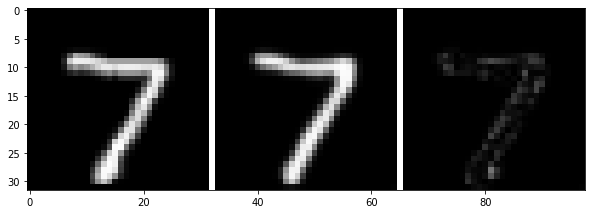

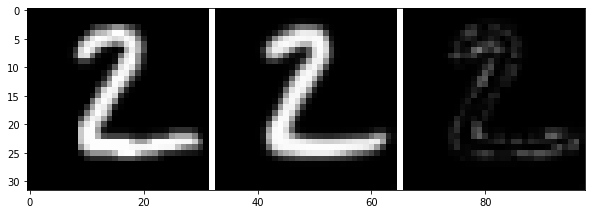

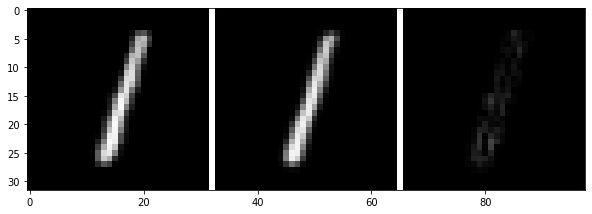

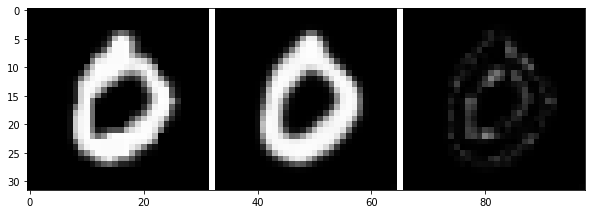

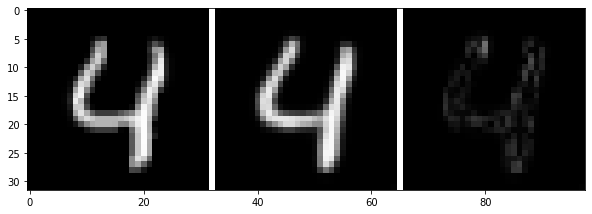

18/02/2020 20:29:21, epoch=141, step=16640, loss=0.04592, distortion=0.066, rate=0.025, -elbo=258.40494, nll=187.35107, KL=71.05386, commit_loss=675.63574, bit_usage=0.97262, highest_prob=0.009, temp=0.04085
18/02/2020 20:29:21, epoch=141, step=16660, loss=0.04527, distortion=0.065, rate=0.025, -elbo=255.70343, nll=184.65875, KL=71.04468, commit_loss=676.05981, bit_usage=0.97325, highest_prob=0.009, temp=0.04009
18/02/2020 20:29:21, epoch=141, step=16680, loss=0.04555, distortion=0.065, rate=0.025, -elbo=257.01645, nll=185.80750, KL=71.20895, commit_loss=677.35522, bit_usage=0.97176, highest_prob=0.011, temp=0.03934
reset code 60
18/02/2020 20:29:22, epoch=141, step=16700, loss=0.04507, distortion=0.065, rate=0.025, -elbo=254.78107, nll=183.84283, KL=70.93823, commit_loss=675.35718, bit_usage=0.97245, highest_prob=0.009, temp=0.03859
18/02/2020 20:29:22, epoch=141, step=16720, loss=0.04653, distortion=0.067, rate=0.025, -elbo=261.09076, nll=189.82426, KL=71.26648, commit_loss=675.21082

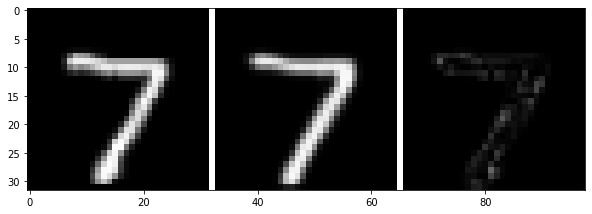

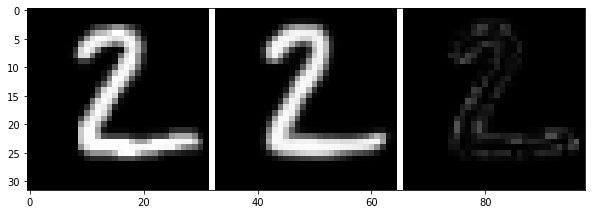

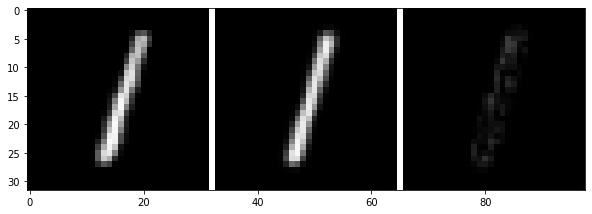

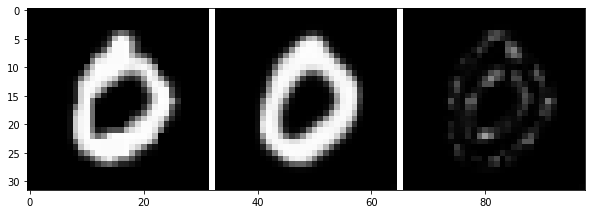

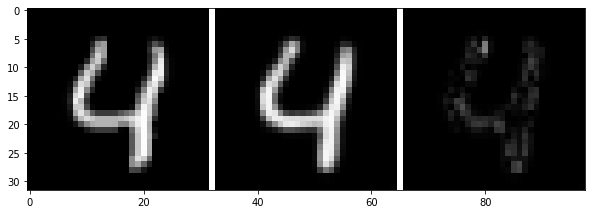

18/02/2020 20:29:35, epoch=146, step=17240, loss=0.04455, distortion=0.064, rate=0.025, -elbo=252.89491, nll=181.73030, KL=71.16461, commit_loss=680.92322, bit_usage=0.97347, highest_prob=0.008, temp=0.01827
18/02/2020 20:29:35, epoch=146, step=17260, loss=0.04510, distortion=0.065, rate=0.025, -elbo=255.08469, nll=183.98839, KL=71.09630, commit_loss=680.54071, bit_usage=0.97566, highest_prob=0.010, temp=0.01752
18/02/2020 20:29:35, epoch=146, step=17280, loss=0.04591, distortion=0.066, rate=0.025, -elbo=258.25214, nll=187.29404, KL=70.95810, commit_loss=676.71985, bit_usage=0.97539, highest_prob=0.008, temp=0.01677
18/02/2020 20:29:36, epoch=146, step=17300, loss=0.04454, distortion=0.064, rate=0.025, -elbo=252.83264, nll=181.67993, KL=71.15272, commit_loss=674.71869, bit_usage=0.97313, highest_prob=0.010, temp=0.01601
18/02/2020 20:29:36, epoch=146, step=17320, loss=0.04597, distortion=0.066, rate=0.025, -elbo=258.51712, nll=187.53616, KL=70.98095, commit_loss=678.87494, bit_usage=0.

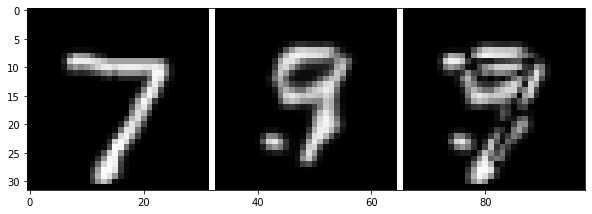

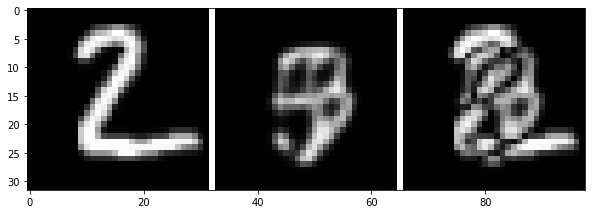

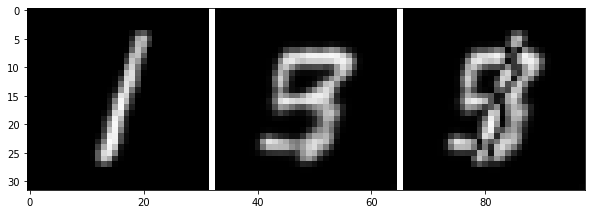

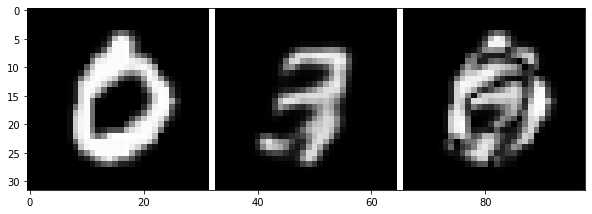

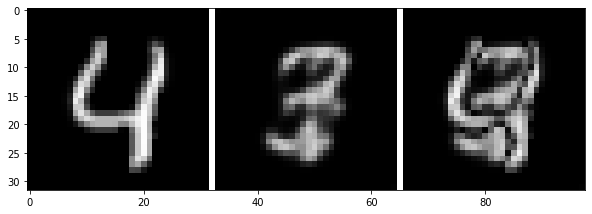

18/02/2020 20:29:49, epoch=1, step=120, loss=0.56453, distortion=0.814, rate=0.027, -elbo=597.35522, nll=577.94794, KL=19.40730, commit_loss=113.05392, bit_usage=0.24922, highest_prob=0.275, temp=0.66245
reset code 48
pruned code 48 - 508 remain
18/02/2020 20:29:49, epoch=1, step=140, loss=0.56674, distortion=0.817, rate=0.027, -elbo=599.60327, nll=580.20886, KL=19.39441, commit_loss=110.75066, bit_usage=0.24904, highest_prob=0.288, temp=0.66169
reset code 48
18/02/2020 20:29:50, epoch=1, step=160, loss=0.56651, distortion=0.817, rate=0.026, -elbo=598.47839, nll=579.97888, KL=18.49953, commit_loss=106.63081, bit_usage=0.28963, highest_prob=0.217, temp=0.66094
reset code 64
pruned code 64 - 507 remain
18/02/2020 20:29:50, epoch=1, step=180, loss=0.57319, distortion=0.827, rate=0.026, -elbo=605.30914, nll=586.82312, KL=18.48602, commit_loss=100.38960, bit_usage=0.28958, highest_prob=0.220, temp=0.66019
reset code 64
18/02/2020 20:29:50, epoch=1, step=200, loss=0.57430, distortion=0.828, 

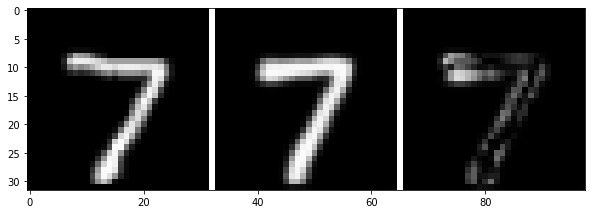

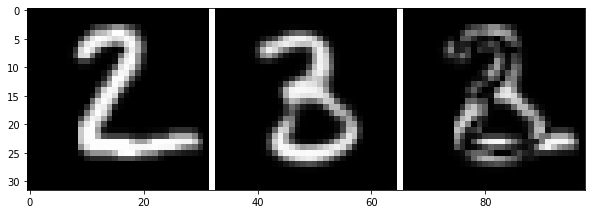

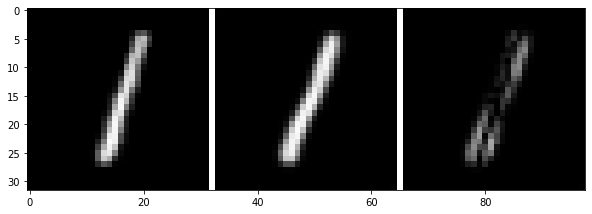

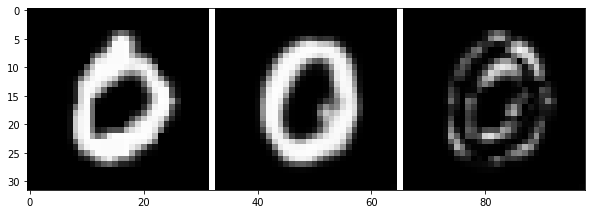

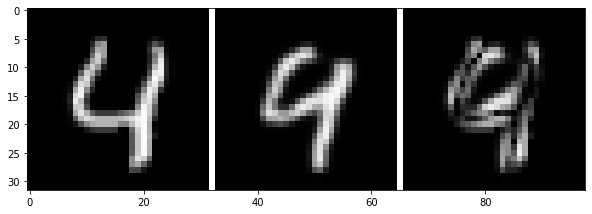

18/02/2020 20:30:04, epoch=6, step=720, loss=0.25741, distortion=0.371, rate=0.028, -elbo=283.47070, nll=263.42218, KL=20.04851, commit_loss=143.22997, bit_usage=0.57959, highest_prob=0.063, temp=0.63987
reset code 288
pruned code 288 - 493 remain
18/02/2020 20:30:05, epoch=6, step=740, loss=0.25520, distortion=0.368, rate=0.028, -elbo=281.23682, nll=261.15622, KL=20.08059, commit_loss=143.88269, bit_usage=0.58305, highest_prob=0.078, temp=0.63912
reset code 288
18/02/2020 20:30:05, epoch=6, step=760, loss=0.25503, distortion=0.368, rate=0.028, -elbo=280.84814, nll=260.98889, KL=19.85927, commit_loss=142.81303, bit_usage=0.59471, highest_prob=0.062, temp=0.63837
reset code 304
pruned code 304 - 492 remain
18/02/2020 20:30:05, epoch=6, step=780, loss=0.25179, distortion=0.363, rate=0.028, -elbo=277.65863, nll=257.66650, KL=19.99214, commit_loss=143.01013, bit_usage=0.59833, highest_prob=0.062, temp=0.63761
reset code 320
18/02/2020 20:30:06, epoch=6, step=800, loss=0.24476, distortion=0

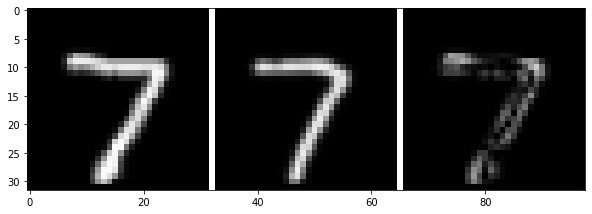

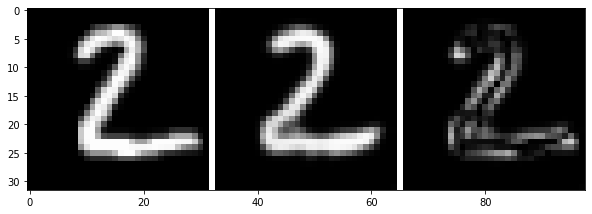

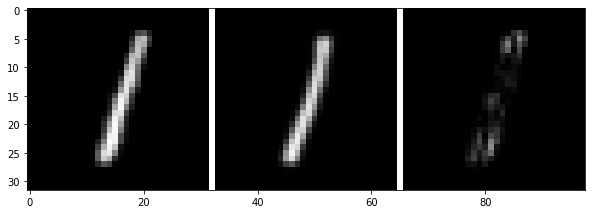

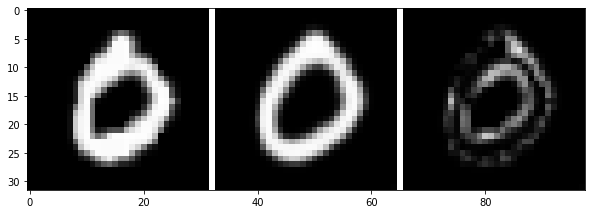

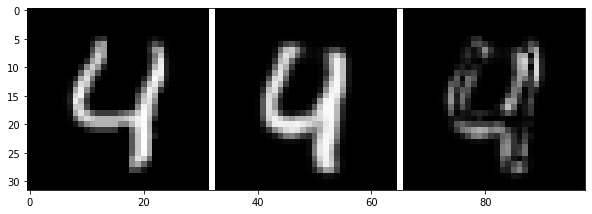

18/02/2020 20:30:19, epoch=11, step=1300, loss=0.19733, distortion=0.284, rate=0.027, -elbo=221.35577, nll=201.89462, KL=19.46115, commit_loss=148.75082, bit_usage=0.68222, highest_prob=0.044, temp=0.61805
reset code 80
18/02/2020 20:30:19, epoch=11, step=1320, loss=0.20162, distortion=0.291, rate=0.027, -elbo=225.63306, nll=206.29541, KL=19.33765, commit_loss=148.48340, bit_usage=0.68549, highest_prob=0.042, temp=0.61729
reset code 48
pruned code 48 - 478 remain
18/02/2020 20:30:20, epoch=11, step=1340, loss=0.20068, distortion=0.289, rate=0.027, -elbo=224.58980, nll=205.32379, KL=19.26601, commit_loss=149.28006, bit_usage=0.68801, highest_prob=0.040, temp=0.61654
reset code 48
18/02/2020 20:30:20, epoch=11, step=1360, loss=0.19302, distortion=0.278, rate=0.027, -elbo=216.72073, nll=197.48192, KL=19.23881, commit_loss=149.69138, bit_usage=0.69542, highest_prob=0.036, temp=0.61579
reset code 64
pruned code 64 - 477 remain
18/02/2020 20:30:21, epoch=11, step=1380, loss=0.19932, distorti

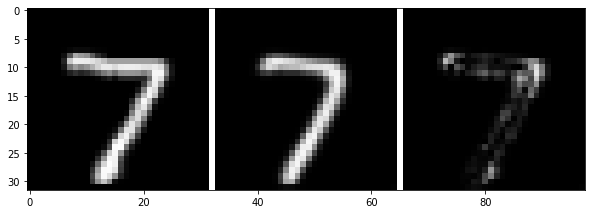

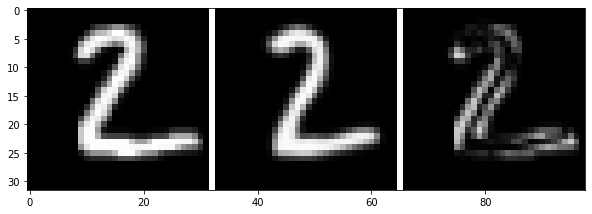

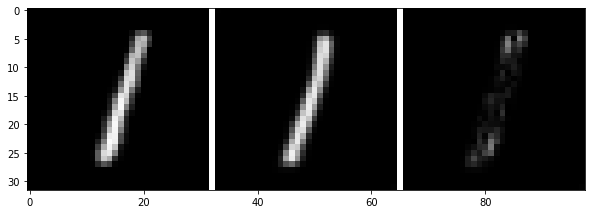

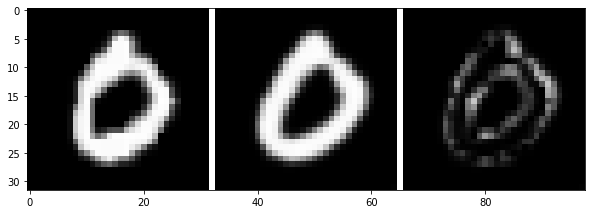

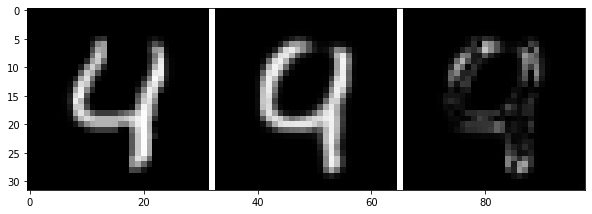

18/02/2020 20:30:34, epoch=16, step=1900, loss=0.17628, distortion=0.254, rate=0.027, -elbo=199.53239, nll=180.33736, KL=19.19504, commit_loss=156.25780, bit_usage=0.74451, highest_prob=0.030, temp=0.59547
reset code 208
18/02/2020 20:30:34, epoch=16, step=1920, loss=0.18304, distortion=0.264, rate=0.027, -elbo=206.49193, nll=187.26233, KL=19.22960, commit_loss=155.68010, bit_usage=0.74602, highest_prob=0.030, temp=0.59472
reset code 240
pruned code 240 - 463 remain
18/02/2020 20:30:35, epoch=16, step=1940, loss=0.17675, distortion=0.255, rate=0.027, -elbo=200.01804, nll=180.81577, KL=19.20228, commit_loss=155.60463, bit_usage=0.74433, highest_prob=0.031, temp=0.59397
reset code 256
18/02/2020 20:30:35, epoch=16, step=1960, loss=0.17837, distortion=0.257, rate=0.027, -elbo=201.67499, nll=182.47673, KL=19.19826, commit_loss=157.15631, bit_usage=0.75215, highest_prob=0.027, temp=0.59321
reset code 272
pruned code 272 - 462 remain
18/02/2020 20:30:35, epoch=16, step=1980, loss=0.18221, di

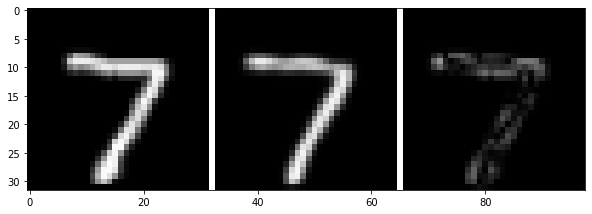

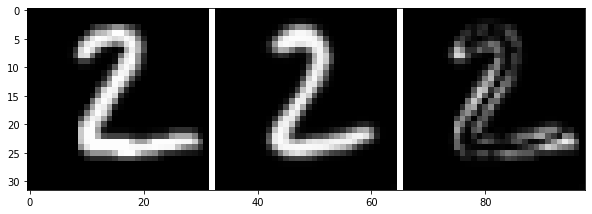

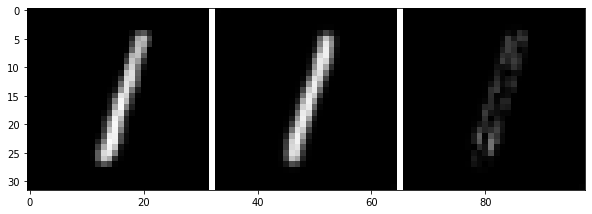

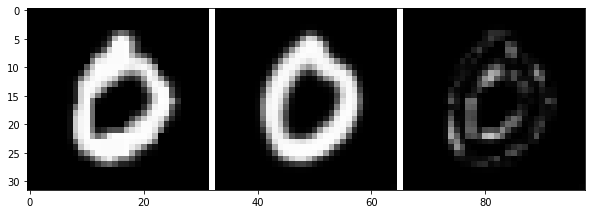

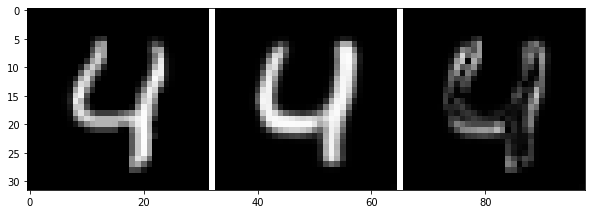

18/02/2020 20:30:48, epoch=21, step=2480, loss=0.16433, distortion=0.237, rate=0.027, -elbo=187.21533, nll=168.09091, KL=19.12441, commit_loss=159.49960, bit_usage=0.78086, highest_prob=0.033, temp=0.57365
reset code 80
pruned code 80 - 449 remain
18/02/2020 20:30:48, epoch=21, step=2500, loss=0.16681, distortion=0.240, rate=0.027, -elbo=189.69568, nll=170.63881, KL=19.05687, commit_loss=159.81332, bit_usage=0.78259, highest_prob=0.025, temp=0.57289
reset code 80
18/02/2020 20:30:49, epoch=21, step=2520, loss=0.15831, distortion=0.228, rate=0.027, -elbo=181.01448, nll=161.93149, KL=19.08300, commit_loss=159.15613, bit_usage=0.78518, highest_prob=0.024, temp=0.57214
reset code 96
pruned code 96 - 448 remain
18/02/2020 20:30:49, epoch=21, step=2540, loss=0.16103, distortion=0.232, rate=0.027, -elbo=183.75049, nll=164.71640, KL=19.03409, commit_loss=160.18576, bit_usage=0.79044, highest_prob=0.023, temp=0.57139
reset code 96
18/02/2020 20:30:50, epoch=21, step=2560, loss=0.15998, distorti

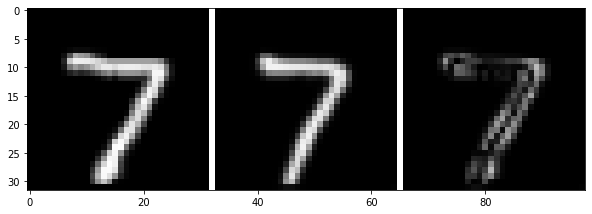

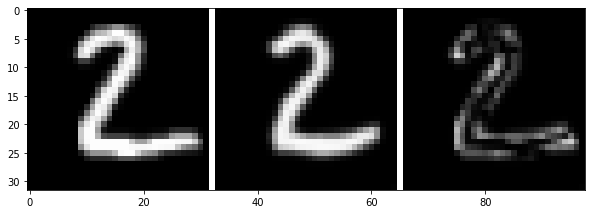

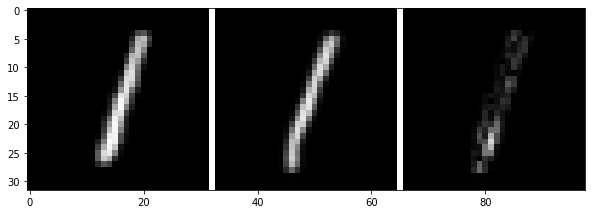

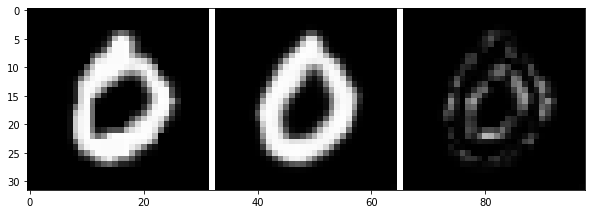

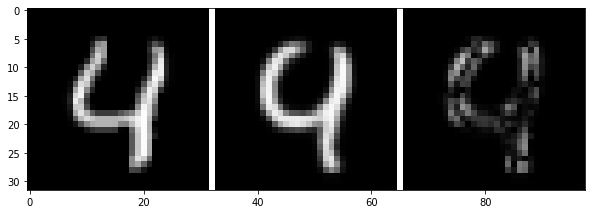

18/02/2020 20:31:03, epoch=26, step=3080, loss=0.15121, distortion=0.218, rate=0.027, -elbo=173.68159, nll=154.65909, KL=19.02250, commit_loss=164.02737, bit_usage=0.81473, highest_prob=0.020, temp=0.55107
reset code 72
pruned code 72 - 434 remain
18/02/2020 20:31:04, epoch=26, step=3100, loss=0.15471, distortion=0.223, rate=0.027, -elbo=177.37294, nll=158.24110, KL=19.13184, commit_loss=164.89041, bit_usage=0.81318, highest_prob=0.023, temp=0.55032
reset code 80
18/02/2020 20:31:04, epoch=26, step=3120, loss=0.15192, distortion=0.219, rate=0.027, -elbo=174.47415, nll=155.38625, KL=19.08791, commit_loss=163.87662, bit_usage=0.81525, highest_prob=0.019, temp=0.54957
reset code 96
pruned code 96 - 433 remain
18/02/2020 20:31:04, epoch=26, step=3140, loss=0.14636, distortion=0.211, rate=0.027, -elbo=168.78038, nll=149.69215, KL=19.08822, commit_loss=163.48254, bit_usage=0.81724, highest_prob=0.026, temp=0.54881
reset code 96
18/02/2020 20:31:05, epoch=26, step=3160, loss=0.15221, distorti

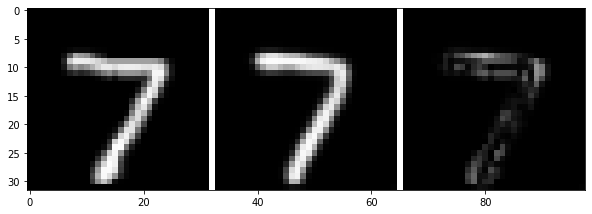

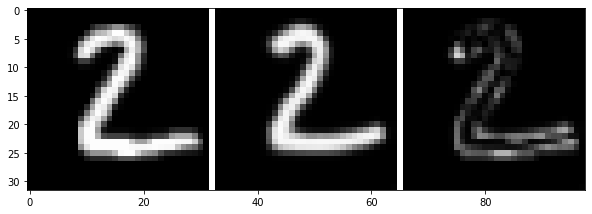

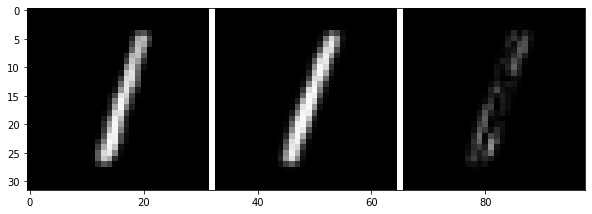

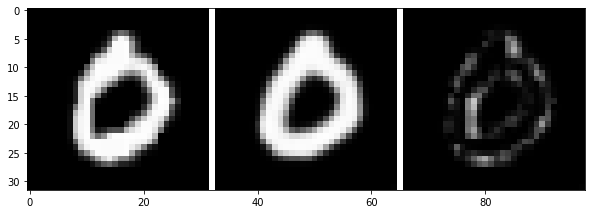

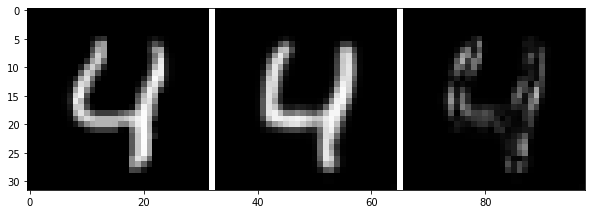

18/02/2020 20:31:17, epoch=31, step=3660, loss=0.14449, distortion=0.208, rate=0.027, -elbo=166.75790, nll=147.77805, KL=18.97985, commit_loss=162.74126, bit_usage=0.84343, highest_prob=0.019, temp=0.52925
reset code 352
18/02/2020 20:31:17, epoch=31, step=3680, loss=0.14518, distortion=0.209, rate=0.027, -elbo=167.41617, nll=148.47723, KL=18.93894, commit_loss=164.34221, bit_usage=0.84445, highest_prob=0.018, temp=0.52849
reset code 368
pruned code 368 - 419 remain
18/02/2020 20:31:18, epoch=31, step=3700, loss=0.14185, distortion=0.204, rate=0.027, -elbo=164.03046, nll=145.07106, KL=18.95939, commit_loss=163.67346, bit_usage=0.84637, highest_prob=0.018, temp=0.52774
reset code 72
18/02/2020 20:31:18, epoch=31, step=3720, loss=0.14629, distortion=0.211, rate=0.027, -elbo=168.62672, nll=149.61693, KL=19.00979, commit_loss=163.60068, bit_usage=0.84528, highest_prob=0.018, temp=0.52699
reset code 120
pruned code 120 - 418 remain
18/02/2020 20:31:19, epoch=31, step=3740, loss=0.14338, dis

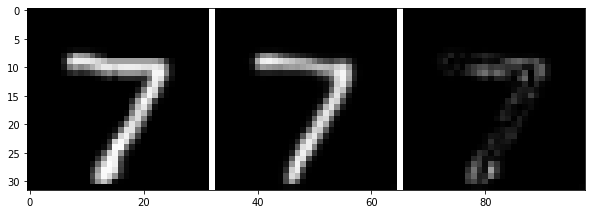

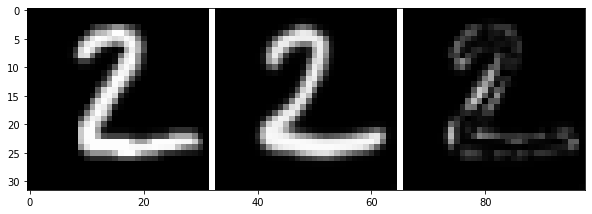

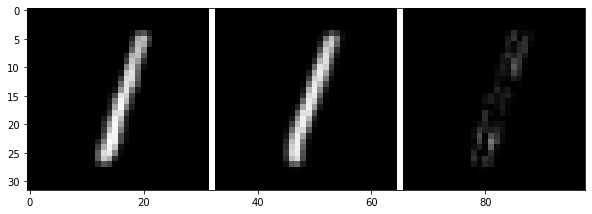

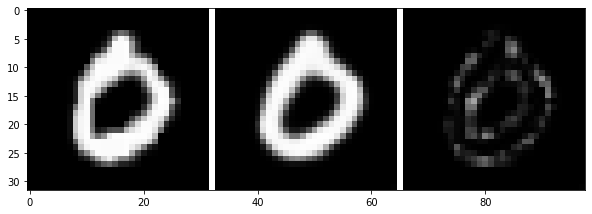

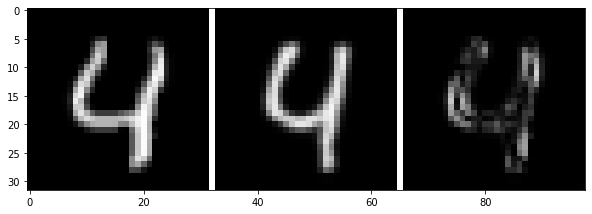

18/02/2020 20:31:32, epoch=36, step=4260, loss=0.13488, distortion=0.194, rate=0.027, -elbo=156.78224, nll=137.93552, KL=18.84673, commit_loss=164.34846, bit_usage=0.86593, highest_prob=0.015, temp=0.50667
reset code 192
18/02/2020 20:31:32, epoch=36, step=4280, loss=0.13757, distortion=0.198, rate=0.026, -elbo=159.48845, nll=140.68729, KL=18.80117, commit_loss=163.78656, bit_usage=0.87218, highest_prob=0.017, temp=0.50592
reset code 208
pruned code 208 - 404 remain
18/02/2020 20:31:33, epoch=36, step=4300, loss=0.13837, distortion=0.199, rate=0.027, -elbo=160.35872, nll=141.50348, KL=18.85524, commit_loss=164.11208, bit_usage=0.86726, highest_prob=0.016, temp=0.50517
reset code 208
18/02/2020 20:31:33, epoch=36, step=4320, loss=0.13932, distortion=0.201, rate=0.026, -elbo=161.26704, nll=142.47906, KL=18.78798, commit_loss=164.94270, bit_usage=0.87113, highest_prob=0.016, temp=0.50441
reset code 224
pruned code 224 - 403 remain
18/02/2020 20:31:33, epoch=36, step=4340, loss=0.13364, di

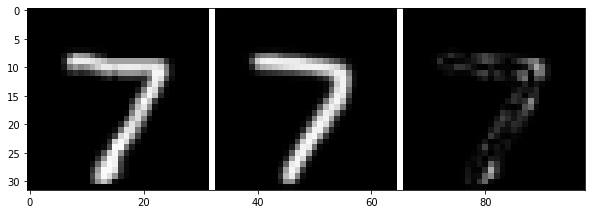

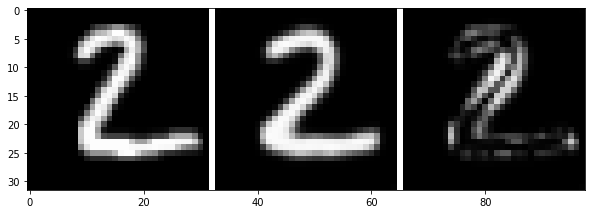

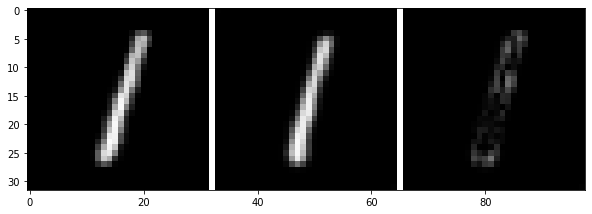

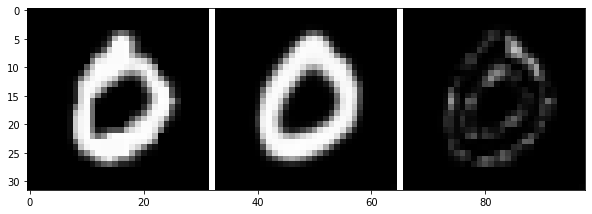

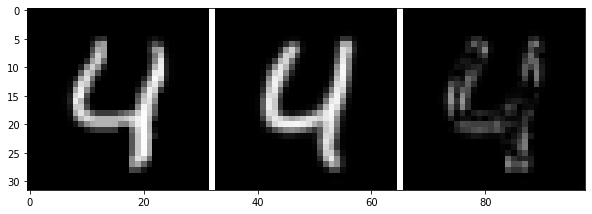

18/02/2020 20:31:46, epoch=41, step=4840, loss=0.13456, distortion=0.194, rate=0.027, -elbo=156.44714, nll=137.60254, KL=18.84460, commit_loss=163.51035, bit_usage=0.88103, highest_prob=0.016, temp=0.48485
reset code 224
pruned code 224 - 390 remain
18/02/2020 20:31:47, epoch=41, step=4860, loss=0.13177, distortion=0.190, rate=0.026, -elbo=153.53281, nll=134.74892, KL=18.78389, commit_loss=164.06601, bit_usage=0.88221, highest_prob=0.015, temp=0.48409
reset code 224
18/02/2020 20:31:47, epoch=41, step=4880, loss=0.13429, distortion=0.193, rate=0.026, -elbo=156.12979, nll=137.33018, KL=18.79961, commit_loss=164.20779, bit_usage=0.88422, highest_prob=0.014, temp=0.48334
reset code 240
pruned code 240 - 389 remain
18/02/2020 20:31:48, epoch=41, step=4900, loss=0.13426, distortion=0.193, rate=0.026, -elbo=156.03860, nll=137.29849, KL=18.74011, commit_loss=162.73085, bit_usage=0.88567, highest_prob=0.015, temp=0.48259
reset code 240
18/02/2020 20:31:48, epoch=41, step=4920, loss=0.13347, di

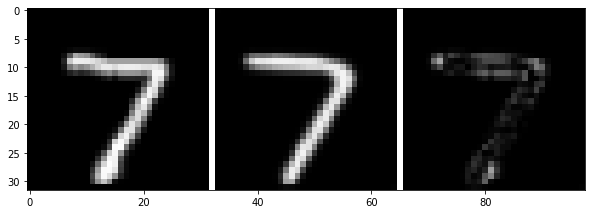

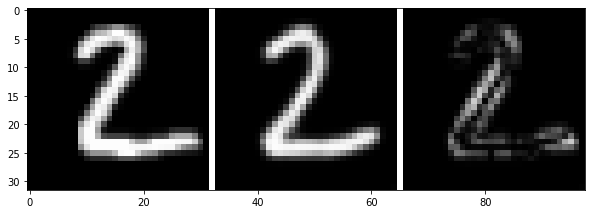

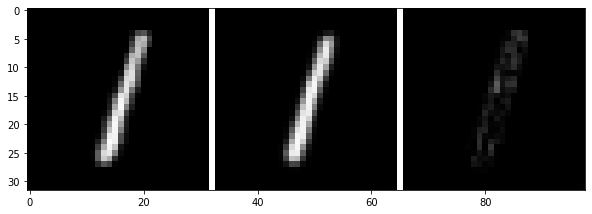

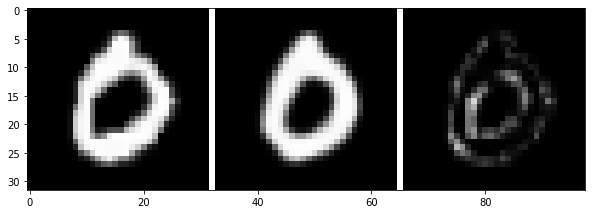

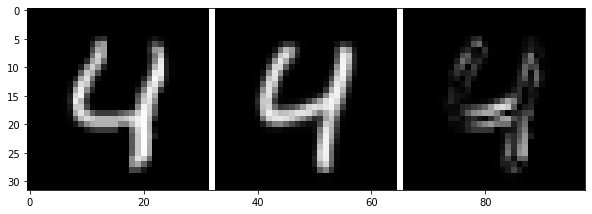

18/02/2020 20:32:02, epoch=46, step=5440, loss=0.12609, distortion=0.182, rate=0.026, -elbo=147.51247, nll=128.93311, KL=18.57936, commit_loss=161.62869, bit_usage=0.89514, highest_prob=0.018, temp=0.46227
reset code 224
pruned code 224 - 375 remain
18/02/2020 20:32:02, epoch=46, step=5460, loss=0.12789, distortion=0.184, rate=0.026, -elbo=149.51935, nll=130.77933, KL=18.74002, commit_loss=164.56694, bit_usage=0.90092, highest_prob=0.014, temp=0.46152
reset code 224
18/02/2020 20:32:03, epoch=46, step=5480, loss=0.12938, distortion=0.186, rate=0.026, -elbo=150.95401, nll=132.30956, KL=18.64446, commit_loss=161.86127, bit_usage=0.90064, highest_prob=0.013, temp=0.46077
reset code 240
pruned code 240 - 374 remain
18/02/2020 20:32:03, epoch=46, step=5500, loss=0.13133, distortion=0.189, rate=0.026, -elbo=153.02969, nll=134.30304, KL=18.72665, commit_loss=163.19792, bit_usage=0.90084, highest_prob=0.020, temp=0.46001
reset code 288
18/02/2020 20:32:04, epoch=46, step=5520, loss=0.13031, di

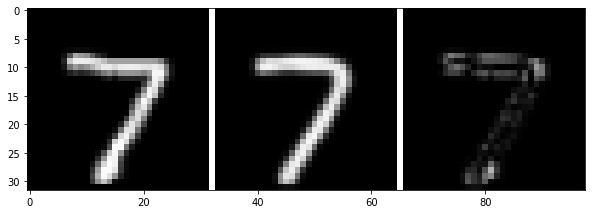

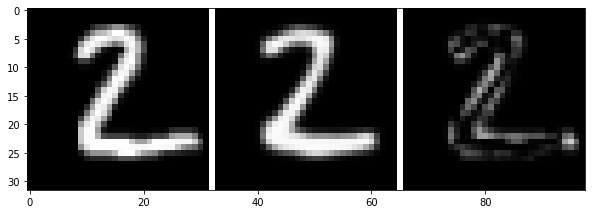

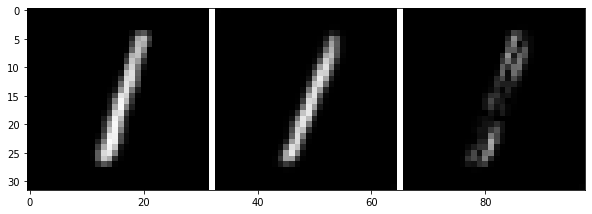

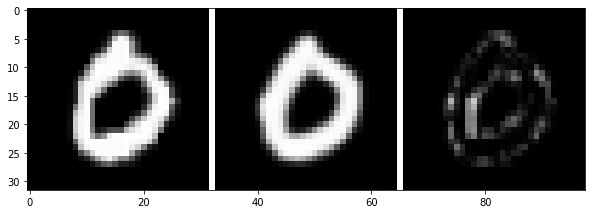

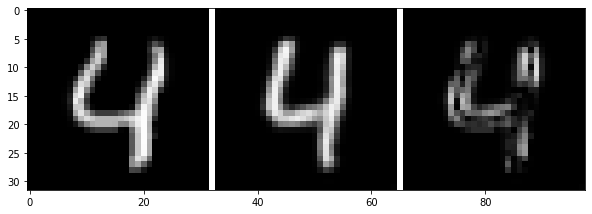

18/02/2020 20:32:17, epoch=51, step=6020, loss=0.12232, distortion=0.176, rate=0.026, -elbo=143.58525, nll=125.07091, KL=18.51435, commit_loss=163.52585, bit_usage=0.91321, highest_prob=0.014, temp=0.44045
reset code 20
18/02/2020 20:32:17, epoch=51, step=6040, loss=0.12553, distortion=0.181, rate=0.026, -elbo=146.87531, nll=128.35686, KL=18.51845, commit_loss=164.70779, bit_usage=0.91233, highest_prob=0.012, temp=0.43969
reset code 36
pruned code 36 - 360 remain
18/02/2020 20:32:18, epoch=51, step=6060, loss=0.12206, distortion=0.176, rate=0.026, -elbo=143.39127, nll=124.81020, KL=18.58108, commit_loss=163.06088, bit_usage=0.91550, highest_prob=0.013, temp=0.43894
reset code 64
18/02/2020 20:32:18, epoch=51, step=6080, loss=0.12391, distortion=0.179, rate=0.026, -elbo=145.29106, nll=126.70673, KL=18.58433, commit_loss=163.54906, bit_usage=0.91584, highest_prob=0.013, temp=0.43819
reset code 80
pruned code 80 - 359 remain
18/02/2020 20:32:19, epoch=51, step=6100, loss=0.12228, distorti

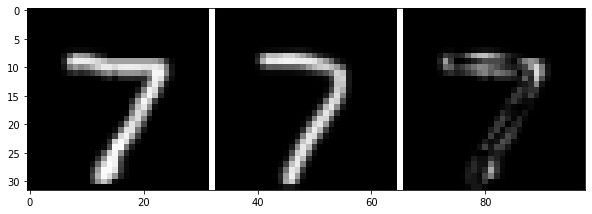

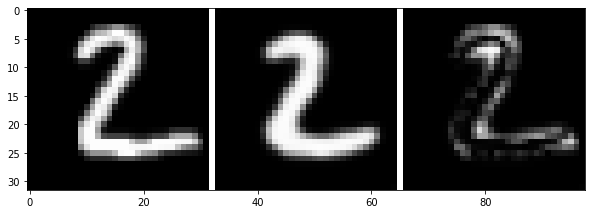

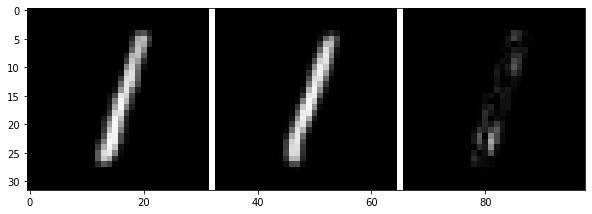

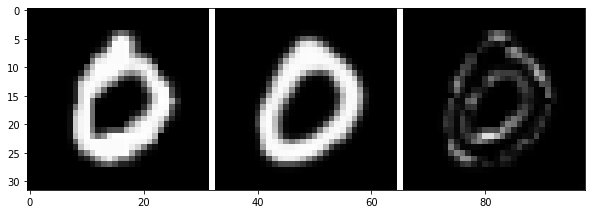

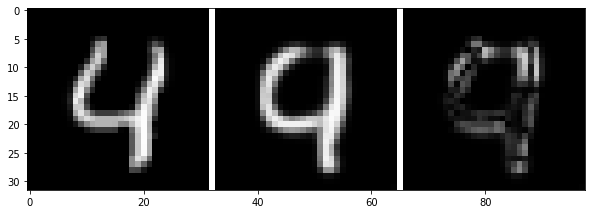

18/02/2020 20:32:32, epoch=56, step=6620, loss=0.12400, distortion=0.179, rate=0.026, -elbo=145.22786, nll=126.79388, KL=18.43397, commit_loss=163.76627, bit_usage=0.92591, highest_prob=0.012, temp=0.41787
reset code 96
18/02/2020 20:32:33, epoch=56, step=6640, loss=0.12308, distortion=0.177, rate=0.026, -elbo=144.17162, nll=125.85688, KL=18.31474, commit_loss=161.06712, bit_usage=0.92661, highest_prob=0.012, temp=0.41712
reset code 128
pruned code 128 - 345 remain
18/02/2020 20:32:33, epoch=56, step=6660, loss=0.12098, distortion=0.174, rate=0.026, -elbo=142.11380, nll=123.70499, KL=18.40881, commit_loss=162.15829, bit_usage=0.93010, highest_prob=0.012, temp=0.41637
reset code 128
18/02/2020 20:32:34, epoch=56, step=6680, loss=0.12701, distortion=0.183, rate=0.026, -elbo=148.30348, nll=129.88104, KL=18.42244, commit_loss=163.52483, bit_usage=0.92478, highest_prob=0.016, temp=0.41561
reset code 224
pruned code 224 - 344 remain
18/02/2020 20:32:34, epoch=56, step=6700, loss=0.12414, dis

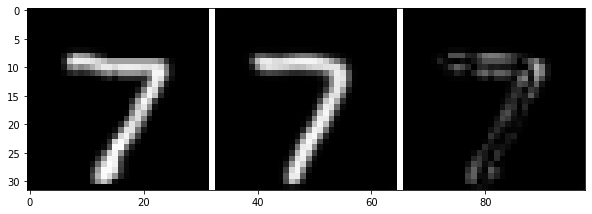

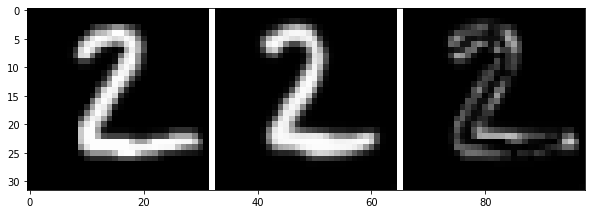

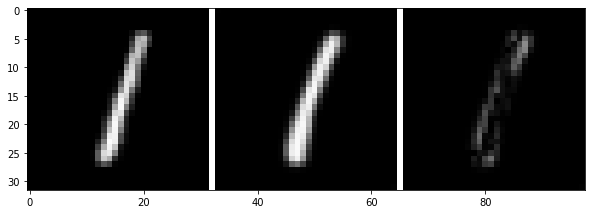

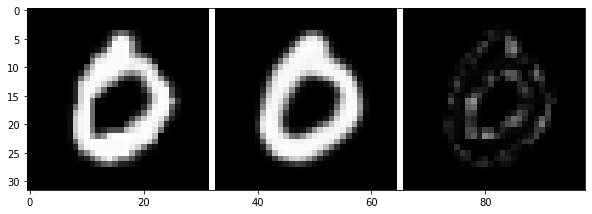

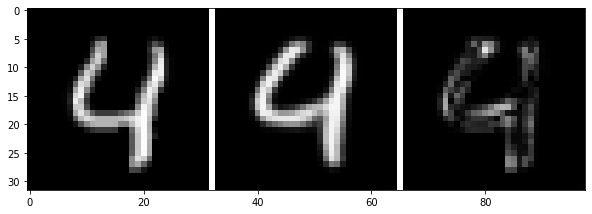

18/02/2020 20:32:48, epoch=61, step=7200, loss=0.11540, distortion=0.166, rate=0.026, -elbo=136.31094, nll=117.99421, KL=18.31673, commit_loss=160.06714, bit_usage=0.93993, highest_prob=0.013, temp=0.39605
reset code 192
pruned code 192 - 331 remain
18/02/2020 20:32:48, epoch=61, step=7220, loss=0.12105, distortion=0.174, rate=0.026, -elbo=142.11324, nll=123.76974, KL=18.34349, commit_loss=163.18307, bit_usage=0.93794, highest_prob=0.012, temp=0.39529
reset code 224
18/02/2020 20:32:48, epoch=61, step=7240, loss=0.12439, distortion=0.179, rate=0.026, -elbo=145.50308, nll=127.19291, KL=18.31017, commit_loss=161.75070, bit_usage=0.94053, highest_prob=0.011, temp=0.39454
reset code 320
pruned code 320 - 330 remain
18/02/2020 20:32:49, epoch=61, step=7260, loss=0.11918, distortion=0.172, rate=0.026, -elbo=140.13034, nll=121.86485, KL=18.26549, commit_loss=161.83943, bit_usage=0.94296, highest_prob=0.011, temp=0.39379
reset code 72
18/02/2020 20:32:49, epoch=61, step=7280, loss=0.11741, dis

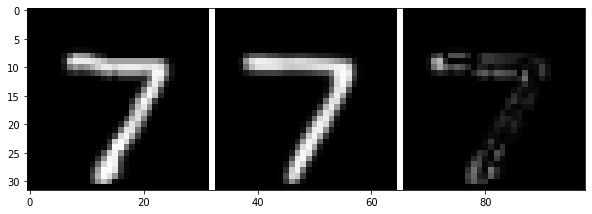

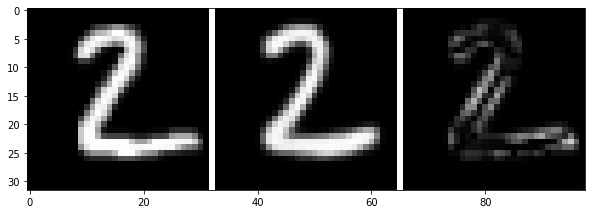

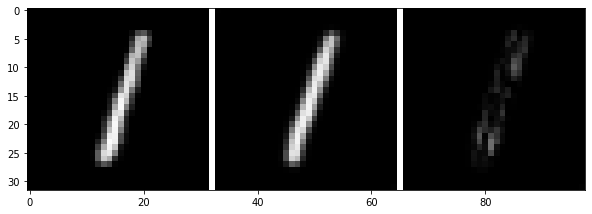

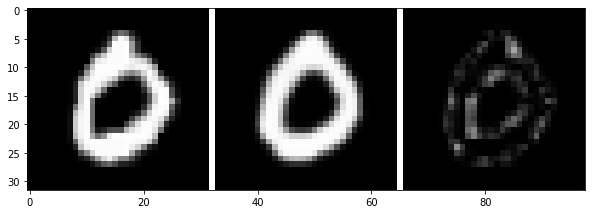

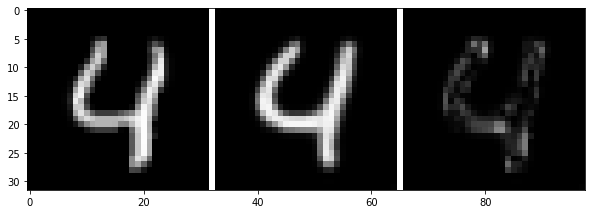

18/02/2020 20:33:03, epoch=66, step=7800, loss=0.11364, distortion=0.164, rate=0.025, -elbo=134.26263, nll=116.19089, KL=18.07175, commit_loss=160.83759, bit_usage=0.95008, highest_prob=0.012, temp=0.37347
reset code 304
pruned code 304 - 316 remain
18/02/2020 20:33:03, epoch=66, step=7820, loss=0.11549, distortion=0.166, rate=0.026, -elbo=136.23282, nll=118.08228, KL=18.15055, commit_loss=160.81021, bit_usage=0.95237, highest_prob=0.013, temp=0.37272
reset code 88
18/02/2020 20:33:03, epoch=66, step=7840, loss=0.11692, distortion=0.168, rate=0.026, -elbo=137.67955, nll=119.54462, KL=18.13494, commit_loss=161.45430, bit_usage=0.95326, highest_prob=0.011, temp=0.37197
reset code 296
pruned code 296 - 315 remain
18/02/2020 20:33:04, epoch=66, step=7860, loss=0.11709, distortion=0.169, rate=0.025, -elbo=137.79436, nll=119.71775, KL=18.07660, commit_loss=160.44353, bit_usage=0.95218, highest_prob=0.011, temp=0.37121
reset code 100
18/02/2020 20:33:04, epoch=66, step=7880, loss=0.11625, dis

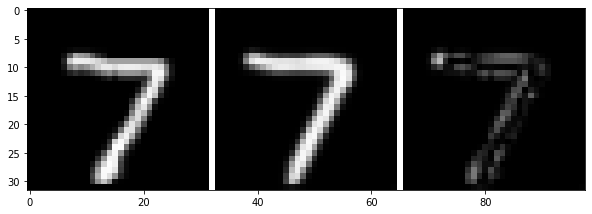

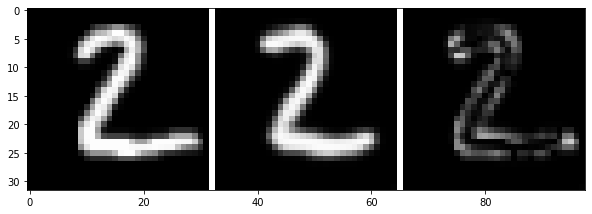

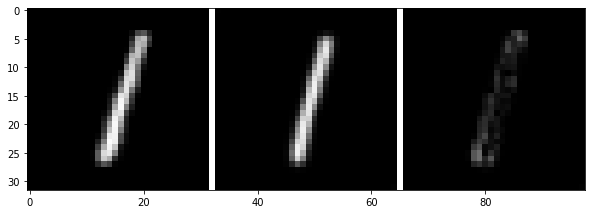

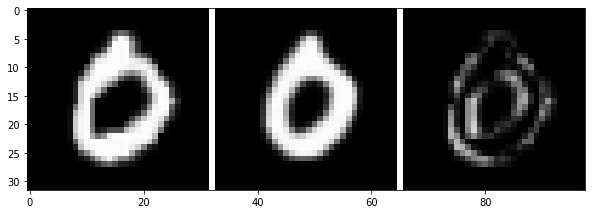

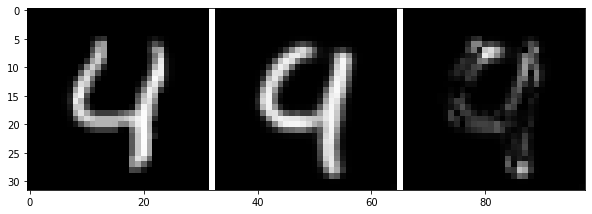

18/02/2020 20:33:18, epoch=71, step=8380, loss=0.11811, distortion=0.170, rate=0.025, -elbo=138.70294, nll=120.76360, KL=17.93935, commit_loss=161.40845, bit_usage=0.96197, highest_prob=0.012, temp=0.35165
reset code 176
18/02/2020 20:33:18, epoch=71, step=8400, loss=0.11491, distortion=0.166, rate=0.025, -elbo=135.41234, nll=117.49094, KL=17.92140, commit_loss=161.26453, bit_usage=0.96207, highest_prob=0.010, temp=0.35089
reset code 40
pruned code 40 - 301 remain
18/02/2020 20:33:19, epoch=71, step=8420, loss=0.11388, distortion=0.164, rate=0.025, -elbo=134.24406, nll=116.43730, KL=17.80676, commit_loss=159.73489, bit_usage=0.96316, highest_prob=0.012, temp=0.35014
reset code 80
18/02/2020 20:33:19, epoch=71, step=8440, loss=0.11486, distortion=0.165, rate=0.025, -elbo=135.38170, nll=117.43517, KL=17.94653, commit_loss=160.81165, bit_usage=0.96762, highest_prob=0.010, temp=0.34939
reset code 88
pruned code 88 - 300 remain
18/02/2020 20:33:19, epoch=71, step=8460, loss=0.11442, distort

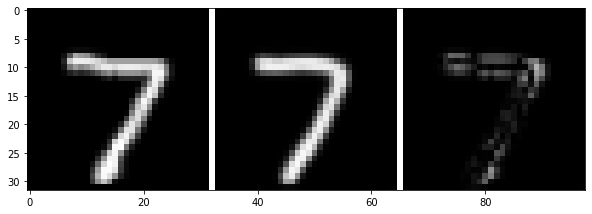

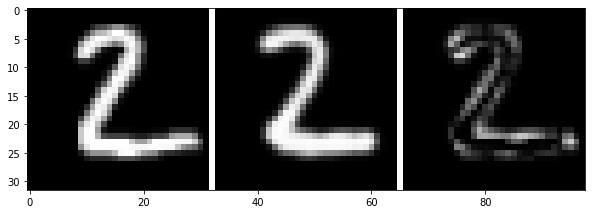

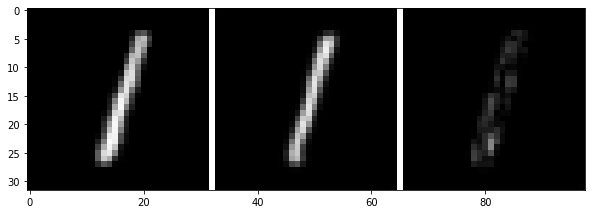

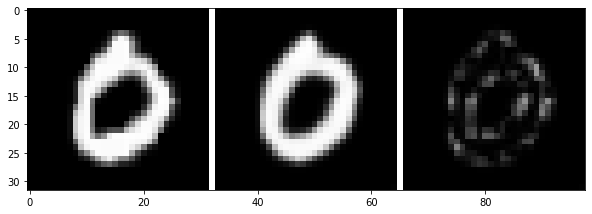

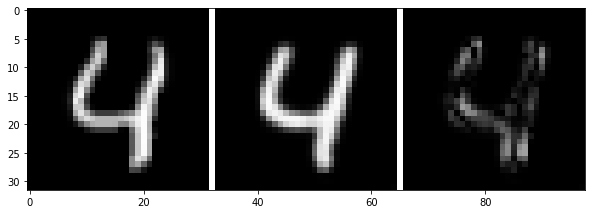

18/02/2020 20:33:33, epoch=76, step=8980, loss=0.11218, distortion=0.162, rate=0.025, -elbo=132.57677, nll=114.69659, KL=17.88018, commit_loss=159.57935, bit_usage=0.96380, highest_prob=0.012, temp=0.32907
reset code 8
18/02/2020 20:33:33, epoch=76, step=9000, loss=0.11229, distortion=0.162, rate=0.025, -elbo=132.55501, nll=114.80477, KL=17.75023, commit_loss=159.80220, bit_usage=0.96552, highest_prob=0.011, temp=0.32832
reset code 24
pruned code 24 - 286 remain
18/02/2020 20:33:34, epoch=76, step=9020, loss=0.10981, distortion=0.158, rate=0.025, -elbo=130.03343, nll=112.26613, KL=17.76730, commit_loss=160.36697, bit_usage=0.96938, highest_prob=0.009, temp=0.32757
reset code 24
18/02/2020 20:33:34, epoch=76, step=9040, loss=0.11189, distortion=0.161, rate=0.025, -elbo=132.09767, nll=114.40410, KL=17.69358, commit_loss=158.67162, bit_usage=0.96795, highest_prob=0.011, temp=0.32681
reset code 4
pruned code 4 - 285 remain
18/02/2020 20:33:34, epoch=76, step=9060, loss=0.11305, distortion=

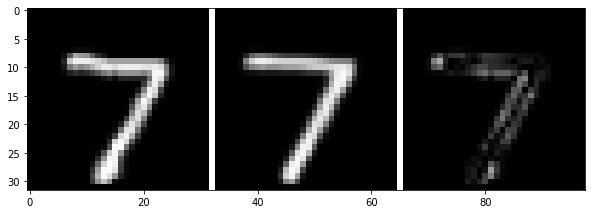

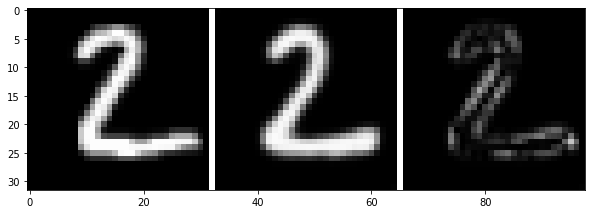

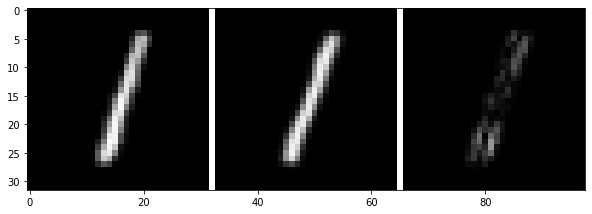

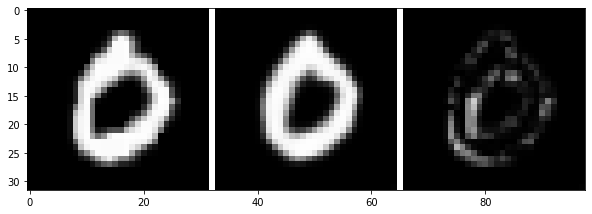

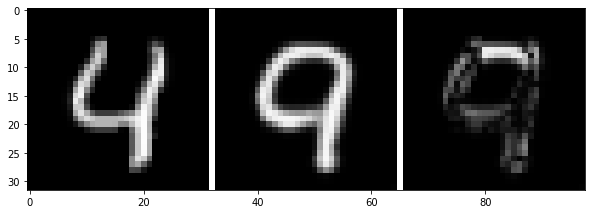

18/02/2020 20:33:48, epoch=81, step=9560, loss=0.11358, distortion=0.164, rate=0.025, -elbo=133.76620, nll=116.12674, KL=17.63947, commit_loss=158.72278, bit_usage=0.97125, highest_prob=0.011, temp=0.30725
reset code 79
pruned code 79 - 272 remain
18/02/2020 20:33:48, epoch=81, step=9580, loss=0.11151, distortion=0.161, rate=0.025, -elbo=131.65881, nll=114.01259, KL=17.64622, commit_loss=158.93007, bit_usage=0.97360, highest_prob=0.013, temp=0.30649
reset code 123
18/02/2020 20:33:49, epoch=81, step=9600, loss=0.10986, distortion=0.158, rate=0.025, -elbo=129.98790, nll=112.31679, KL=17.67111, commit_loss=159.05022, bit_usage=0.97481, highest_prob=0.011, temp=0.30574
pruned code 183 - 271 remain
18/02/2020 20:33:49, epoch=81, step=9620, loss=0.11032, distortion=0.159, rate=0.025, -elbo=130.48647, nll=112.79285, KL=17.69362, commit_loss=159.72708, bit_usage=0.97271, highest_prob=0.010, temp=0.30499
reset code 219
18/02/2020 20:33:50, epoch=81, step=9640, loss=0.10920, distortion=0.157, r

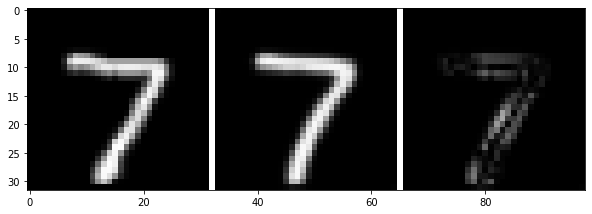

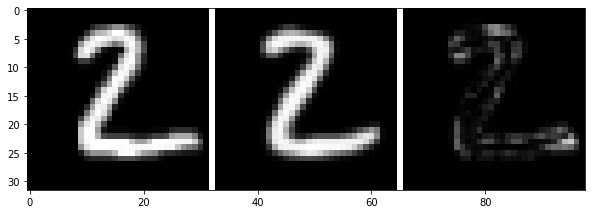

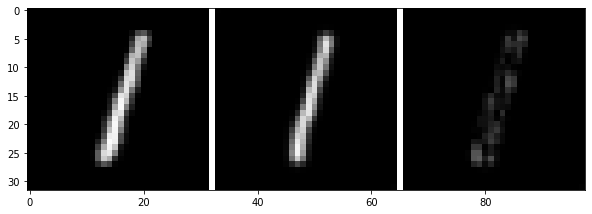

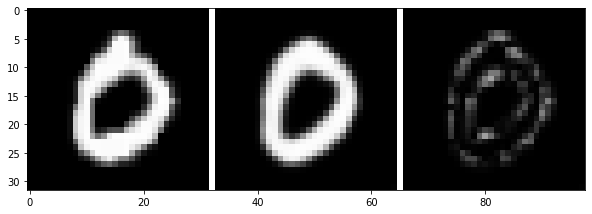

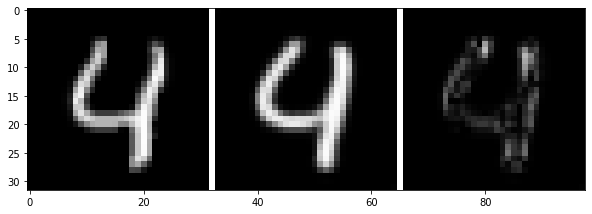

18/02/2020 20:34:03, epoch=86, step=10160, loss=0.10858, distortion=0.156, rate=0.025, -elbo=128.69180, nll=111.00823, KL=17.68357, commit_loss=160.35846, bit_usage=0.97350, highest_prob=0.009, temp=0.28467
pruned code 211 - 257 remain
18/02/2020 20:34:03, epoch=86, step=10180, loss=0.10742, distortion=0.155, rate=0.025, -elbo=127.48232, nll=109.82087, KL=17.66145, commit_loss=157.59464, bit_usage=0.97104, highest_prob=0.010, temp=0.28392
18/02/2020 20:34:04, epoch=86, step=10200, loss=0.10846, distortion=0.156, rate=0.025, -elbo=128.47801, nll=110.88379, KL=17.59422, commit_loss=158.45969, bit_usage=0.97189, highest_prob=0.013, temp=0.28317
pruned code 183 - 256 remain
18/02/2020 20:34:04, epoch=86, step=10220, loss=0.11277, distortion=0.162, rate=0.025, -elbo=133.03920, nll=115.29872, KL=17.74048, commit_loss=161.34422, bit_usage=0.97217, highest_prob=0.010, temp=0.28241
18/02/2020 20:34:05, epoch=86, step=10240, loss=0.10858, distortion=0.156, rate=0.025, -elbo=128.72981, nll=111.01

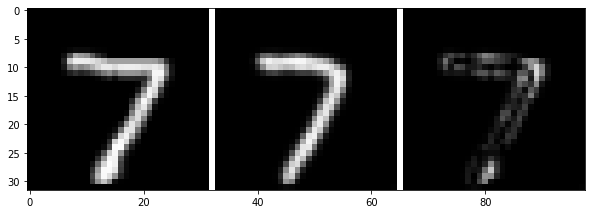

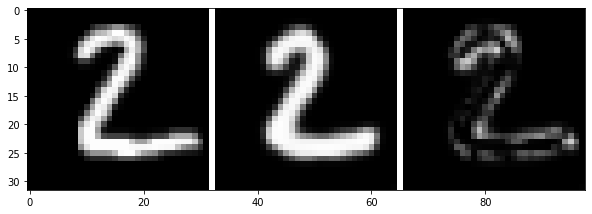

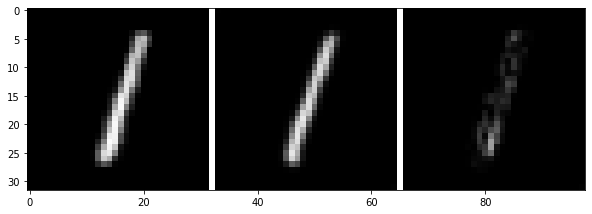

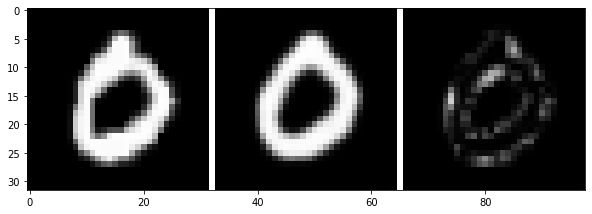

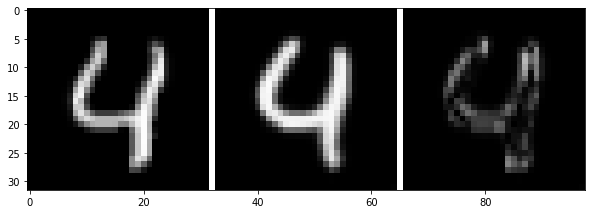

18/02/2020 20:34:18, epoch=91, step=10740, loss=0.11190, distortion=0.161, rate=0.025, -elbo=132.22415, nll=114.41058, KL=17.81357, commit_loss=159.23669, bit_usage=0.97273, highest_prob=0.010, temp=0.26285
18/02/2020 20:34:18, epoch=91, step=10760, loss=0.10544, distortion=0.152, rate=0.025, -elbo=125.68953, nll=107.79802, KL=17.89151, commit_loss=158.54980, bit_usage=0.97496, highest_prob=0.010, temp=0.26209
18/02/2020 20:34:19, epoch=91, step=10780, loss=0.10645, distortion=0.153, rate=0.025, -elbo=126.71349, nll=108.82755, KL=17.88594, commit_loss=159.43768, bit_usage=0.97216, highest_prob=0.010, temp=0.26134
18/02/2020 20:34:19, epoch=91, step=10800, loss=0.11076, distortion=0.160, rate=0.025, -elbo=131.10799, nll=113.23863, KL=17.86936, commit_loss=159.09433, bit_usage=0.97301, highest_prob=0.010, temp=0.26059
18/02/2020 20:34:20, epoch=91, step=10820, loss=0.11082, distortion=0.160, rate=0.025, -elbo=131.19214, nll=113.30508, KL=17.88705, commit_loss=159.29333, bit_usage=0.96992

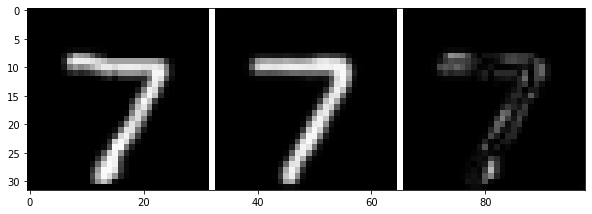

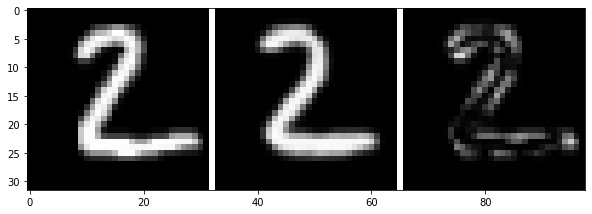

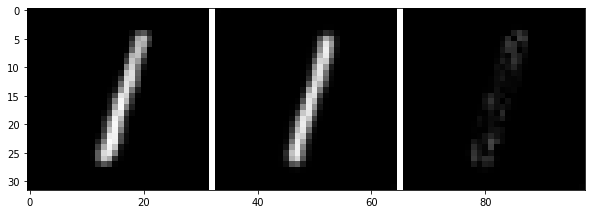

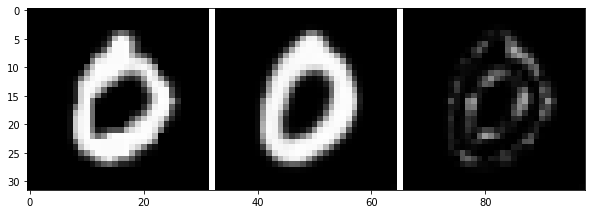

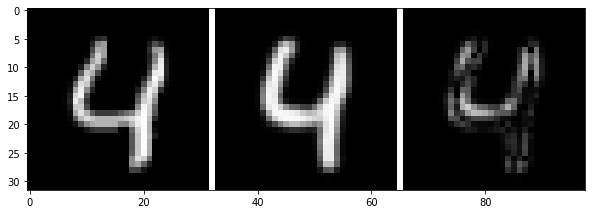

18/02/2020 20:34:33, epoch=96, step=11340, loss=0.10418, distortion=0.150, rate=0.025, -elbo=124.46788, nll=106.50314, KL=17.96474, commit_loss=157.28558, bit_usage=0.97605, highest_prob=0.009, temp=0.24027
18/02/2020 20:34:34, epoch=96, step=11360, loss=0.10907, distortion=0.157, rate=0.025, -elbo=129.55933, nll=111.51379, KL=18.04553, commit_loss=160.65564, bit_usage=0.97285, highest_prob=0.012, temp=0.23952
18/02/2020 20:34:34, epoch=96, step=11380, loss=0.10864, distortion=0.156, rate=0.025, -elbo=129.05815, nll=111.07193, KL=17.98623, commit_loss=158.97299, bit_usage=0.97279, highest_prob=0.010, temp=0.23877
18/02/2020 20:34:34, epoch=96, step=11400, loss=0.11165, distortion=0.161, rate=0.025, -elbo=132.24863, nll=114.15064, KL=18.09798, commit_loss=160.36050, bit_usage=0.97075, highest_prob=0.011, temp=0.23801
18/02/2020 20:34:35, epoch=96, step=11420, loss=0.10884, distortion=0.157, rate=0.025, -elbo=129.23802, nll=111.27333, KL=17.96469, commit_loss=158.73978, bit_usage=0.97405

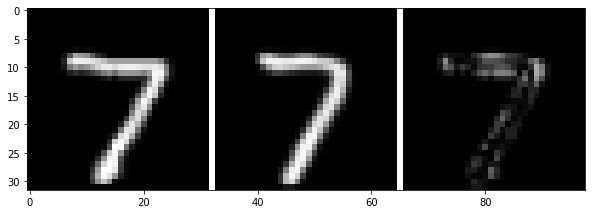

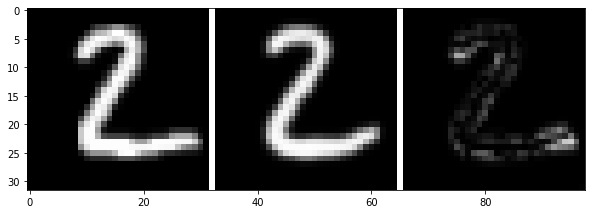

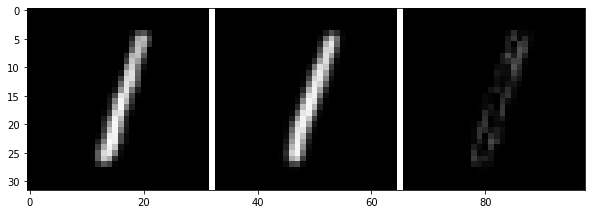

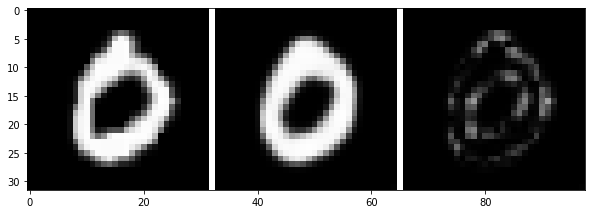

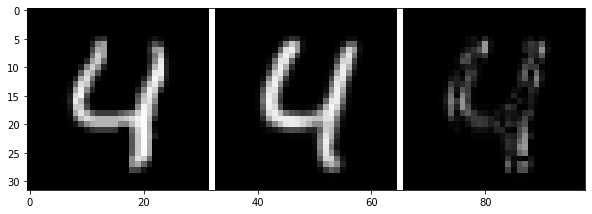

18/02/2020 20:34:47, epoch=101, step=11920, loss=0.10568, distortion=0.152, rate=0.025, -elbo=126.13792, nll=108.04344, KL=18.09449, commit_loss=157.29520, bit_usage=0.97225, highest_prob=0.011, temp=0.21845
reset code 243
18/02/2020 20:34:48, epoch=101, step=11940, loss=0.10514, distortion=0.151, rate=0.026, -elbo=125.60792, nll=107.48802, KL=18.11990, commit_loss=159.27908, bit_usage=0.97187, highest_prob=0.011, temp=0.21769
18/02/2020 20:34:48, epoch=101, step=11960, loss=0.10633, distortion=0.153, rate=0.026, -elbo=126.88152, nll=108.70134, KL=18.18017, commit_loss=159.04843, bit_usage=0.97057, highest_prob=0.011, temp=0.21694
18/02/2020 20:34:49, epoch=101, step=11980, loss=0.10757, distortion=0.155, rate=0.025, -elbo=128.04477, nll=109.96920, KL=18.07557, commit_loss=159.42715, bit_usage=0.97588, highest_prob=0.013, temp=0.21619
18/02/2020 20:34:49, epoch=101, step=12000, loss=0.10758, distortion=0.155, rate=0.026, -elbo=128.18126, nll=109.98914, KL=18.19212, commit_loss=159.0707

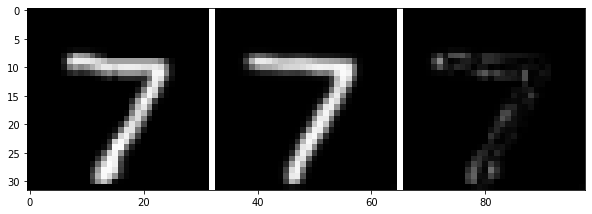

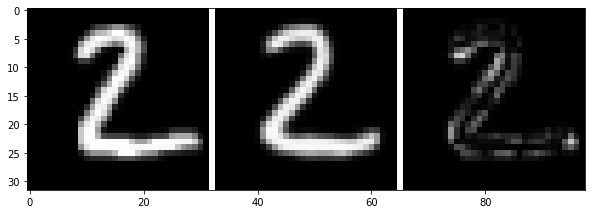

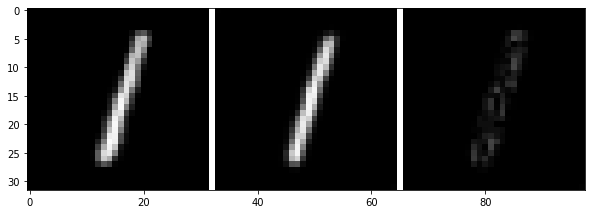

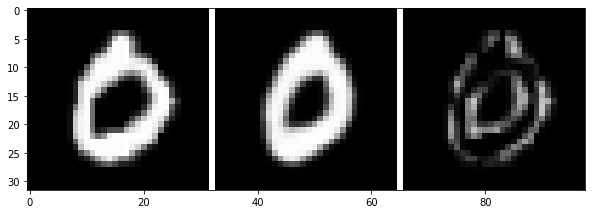

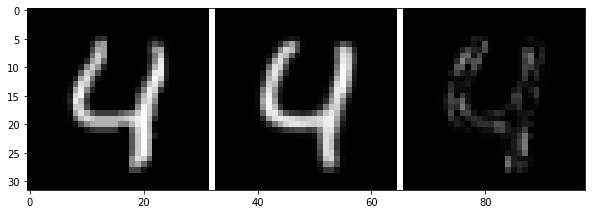

18/02/2020 20:35:03, epoch=106, step=12520, loss=0.10442, distortion=0.150, rate=0.026, -elbo=124.99738, nll=106.74693, KL=18.25045, commit_loss=157.11374, bit_usage=0.97331, highest_prob=0.011, temp=0.19587
18/02/2020 20:35:03, epoch=106, step=12540, loss=0.10675, distortion=0.154, rate=0.026, -elbo=127.48549, nll=109.13445, KL=18.35104, commit_loss=158.41216, bit_usage=0.97008, highest_prob=0.012, temp=0.19512
18/02/2020 20:35:03, epoch=106, step=12560, loss=0.11128, distortion=0.160, rate=0.026, -elbo=132.01492, nll=113.77071, KL=18.24421, commit_loss=158.60721, bit_usage=0.97193, highest_prob=0.010, temp=0.19437
18/02/2020 20:35:04, epoch=106, step=12580, loss=0.10592, distortion=0.153, rate=0.026, -elbo=126.56519, nll=108.28989, KL=18.27530, commit_loss=158.33942, bit_usage=0.97345, highest_prob=0.010, temp=0.19361
reset code 93
18/02/2020 20:35:04, epoch=106, step=12600, loss=0.10658, distortion=0.154, rate=0.026, -elbo=127.26438, nll=108.96410, KL=18.30028, commit_loss=157.02545

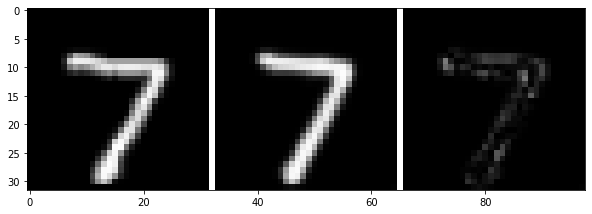

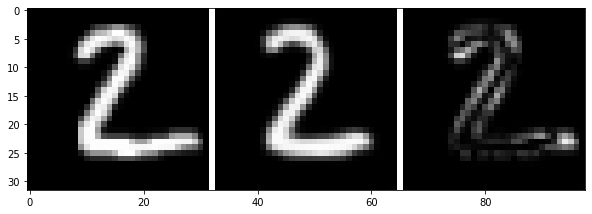

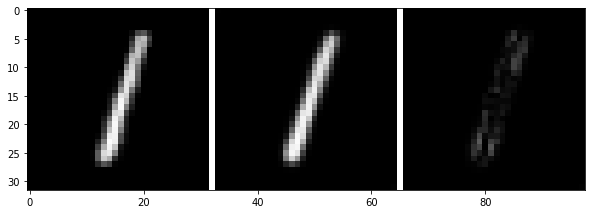

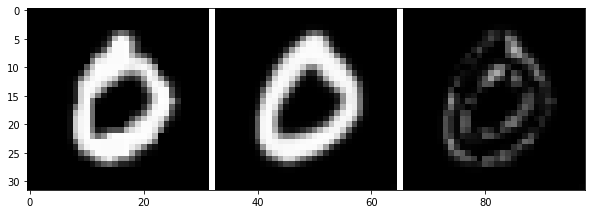

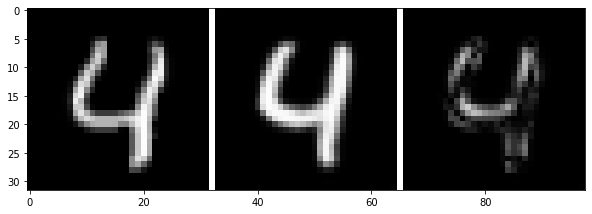

18/02/2020 20:35:17, epoch=111, step=13100, loss=0.10260, distortion=0.148, rate=0.026, -elbo=123.24092, nll=104.89245, KL=18.34847, commit_loss=156.54916, bit_usage=0.97396, highest_prob=0.011, temp=0.17405
18/02/2020 20:35:17, epoch=111, step=13120, loss=0.10358, distortion=0.149, rate=0.026, -elbo=124.25479, nll=105.88951, KL=18.36528, commit_loss=158.37387, bit_usage=0.97080, highest_prob=0.009, temp=0.17329
18/02/2020 20:35:18, epoch=111, step=13140, loss=0.10704, distortion=0.154, rate=0.026, -elbo=127.85894, nll=109.43199, KL=18.42695, commit_loss=158.64334, bit_usage=0.97489, highest_prob=0.011, temp=0.17254
18/02/2020 20:35:18, epoch=111, step=13160, loss=0.10357, distortion=0.149, rate=0.026, -elbo=124.28633, nll=105.87436, KL=18.41197, commit_loss=157.98134, bit_usage=0.97396, highest_prob=0.012, temp=0.17179
18/02/2020 20:35:19, epoch=111, step=13180, loss=0.10037, distortion=0.145, rate=0.026, -elbo=120.89343, nll=102.59927, KL=18.29416, commit_loss=157.03128, bit_usage=0.

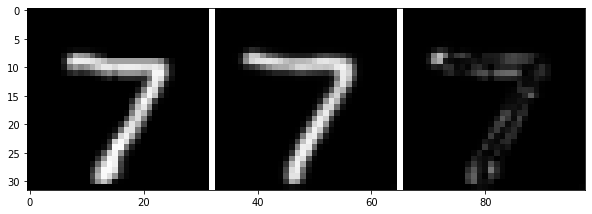

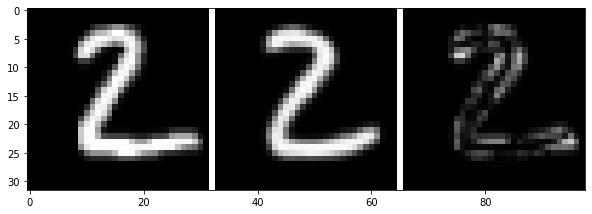

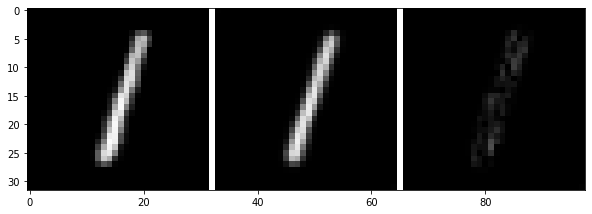

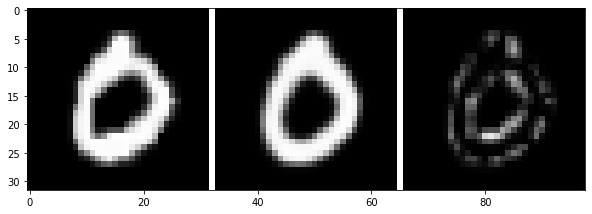

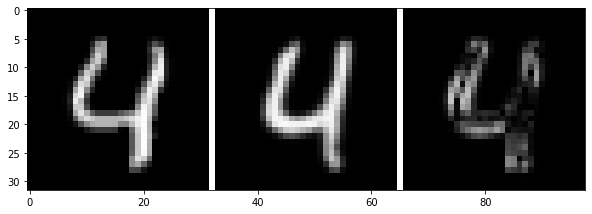

18/02/2020 20:35:32, epoch=116, step=13700, loss=0.10128, distortion=0.146, rate=0.026, -elbo=121.97896, nll=103.53315, KL=18.44581, commit_loss=158.41681, bit_usage=0.97344, highest_prob=0.010, temp=0.15147
18/02/2020 20:35:33, epoch=116, step=13720, loss=0.10299, distortion=0.148, rate=0.026, -elbo=123.75247, nll=105.29014, KL=18.46234, commit_loss=157.69998, bit_usage=0.96967, highest_prob=0.011, temp=0.15072
18/02/2020 20:35:33, epoch=116, step=13740, loss=0.10448, distortion=0.150, rate=0.026, -elbo=125.28627, nll=106.81221, KL=18.47406, commit_loss=157.24643, bit_usage=0.97264, highest_prob=0.011, temp=0.14997
18/02/2020 20:35:33, epoch=116, step=13760, loss=0.10296, distortion=0.148, rate=0.026, -elbo=123.78071, nll=105.25887, KL=18.52184, commit_loss=156.97263, bit_usage=0.97206, highest_prob=0.010, temp=0.14921
18/02/2020 20:35:34, epoch=116, step=13780, loss=0.10430, distortion=0.150, rate=0.026, -elbo=125.09958, nll=106.62646, KL=18.47312, commit_loss=158.61761, bit_usage=0.

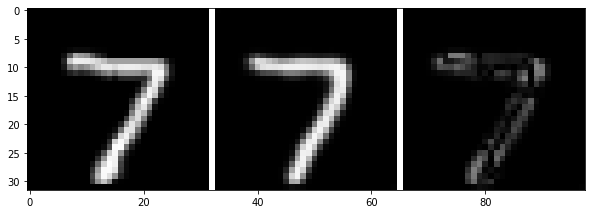

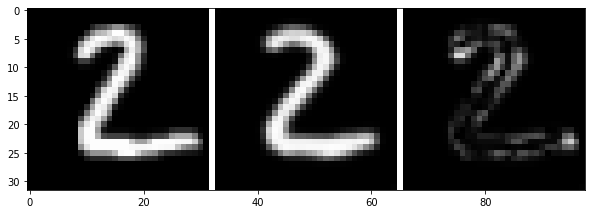

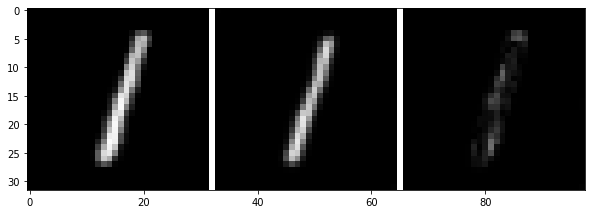

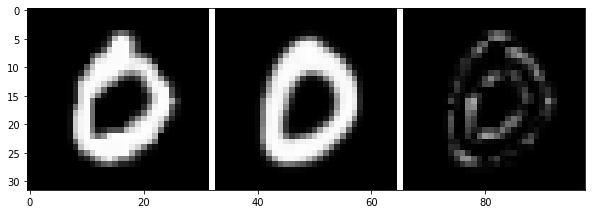

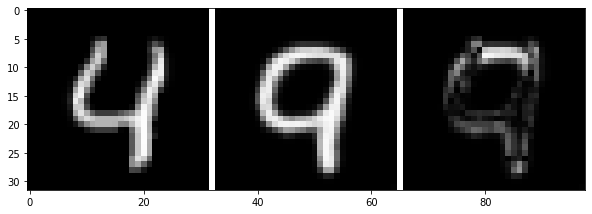

18/02/2020 20:35:47, epoch=121, step=14280, loss=0.09956, distortion=0.143, rate=0.026, -elbo=120.26137, nll=101.76851, KL=18.49286, commit_loss=158.06421, bit_usage=0.97516, highest_prob=0.013, temp=0.12965
18/02/2020 20:35:47, epoch=121, step=14300, loss=0.10068, distortion=0.145, rate=0.026, -elbo=121.46808, nll=102.92421, KL=18.54387, commit_loss=157.85590, bit_usage=0.97660, highest_prob=0.010, temp=0.12889
18/02/2020 20:35:48, epoch=121, step=14320, loss=0.10315, distortion=0.149, rate=0.026, -elbo=124.02704, nll=105.44710, KL=18.57994, commit_loss=158.51839, bit_usage=0.97358, highest_prob=0.010, temp=0.12814
18/02/2020 20:35:48, epoch=121, step=14340, loss=0.10419, distortion=0.150, rate=0.026, -elbo=124.98837, nll=106.50899, KL=18.47939, commit_loss=158.18848, bit_usage=0.97672, highest_prob=0.010, temp=0.12739
18/02/2020 20:35:49, epoch=121, step=14360, loss=0.10411, distortion=0.150, rate=0.026, -elbo=124.93683, nll=106.42708, KL=18.50975, commit_loss=159.35864, bit_usage=0.

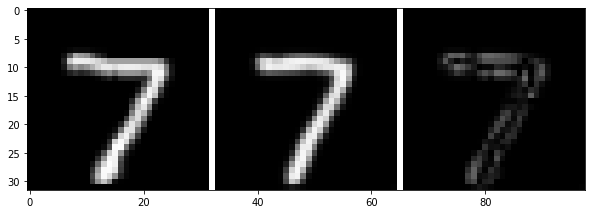

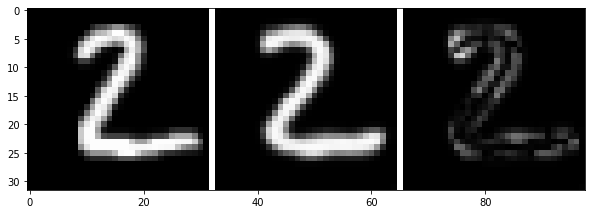

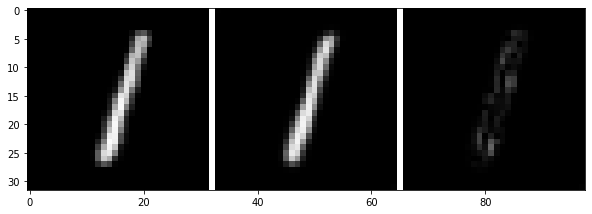

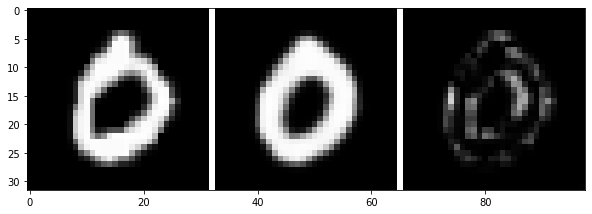

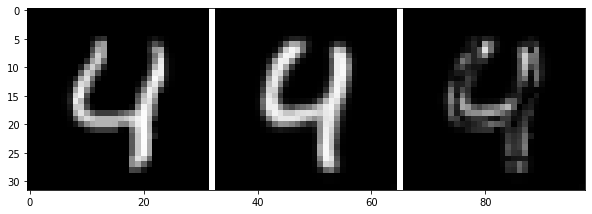

18/02/2020 20:36:03, epoch=126, step=14880, loss=0.09913, distortion=0.143, rate=0.026, -elbo=119.97510, nll=101.33746, KL=18.63763, commit_loss=158.07947, bit_usage=0.97298, highest_prob=0.011, temp=0.10707
18/02/2020 20:36:04, epoch=126, step=14900, loss=0.10091, distortion=0.145, rate=0.026, -elbo=121.75896, nll=103.15723, KL=18.60172, commit_loss=156.83430, bit_usage=0.97763, highest_prob=0.012, temp=0.10632
18/02/2020 20:36:04, epoch=126, step=14920, loss=0.09895, distortion=0.143, rate=0.026, -elbo=119.69053, nll=101.14781, KL=18.54272, commit_loss=156.39026, bit_usage=0.97676, highest_prob=0.009, temp=0.10557
18/02/2020 20:36:04, epoch=126, step=14940, loss=0.10553, distortion=0.152, rate=0.026, -elbo=126.48813, nll=107.88547, KL=18.60266, commit_loss=158.36200, bit_usage=0.97129, highest_prob=0.010, temp=0.10481
18/02/2020 20:36:05, epoch=126, step=14960, loss=0.09860, distortion=0.142, rate=0.026, -elbo=119.40629, nll=100.79433, KL=18.61196, commit_loss=157.42442, bit_usage=0.

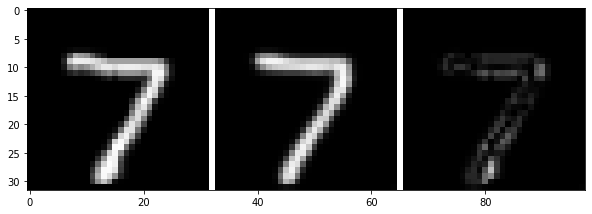

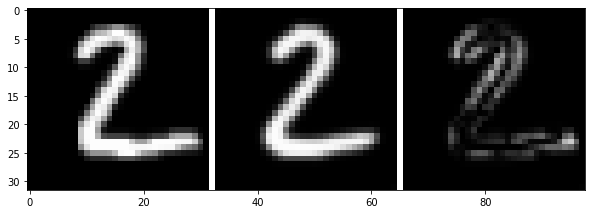

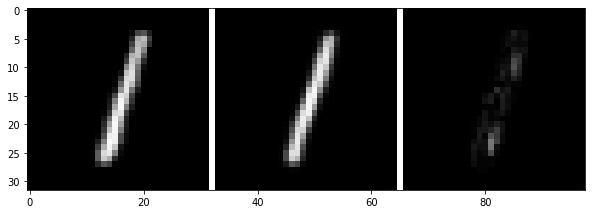

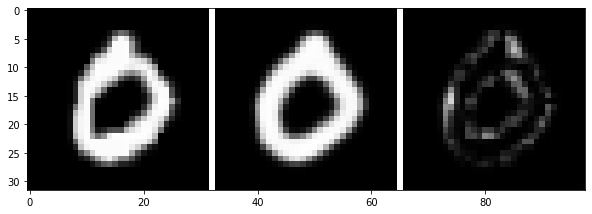

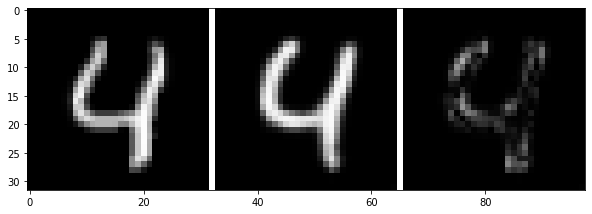

18/02/2020 20:36:19, epoch=131, step=15460, loss=0.09908, distortion=0.143, rate=0.026, -elbo=119.78241, nll=101.27931, KL=18.50310, commit_loss=159.27173, bit_usage=0.97831, highest_prob=0.010, temp=0.08525
18/02/2020 20:36:19, epoch=131, step=15480, loss=0.09999, distortion=0.144, rate=0.026, -elbo=120.80530, nll=102.21219, KL=18.59311, commit_loss=159.74413, bit_usage=0.97666, highest_prob=0.011, temp=0.08449
18/02/2020 20:36:19, epoch=131, step=15500, loss=0.09811, distortion=0.141, rate=0.026, -elbo=118.83421, nll=100.28802, KL=18.54619, commit_loss=157.73239, bit_usage=0.97456, highest_prob=0.013, temp=0.08374
18/02/2020 20:36:20, epoch=131, step=15520, loss=0.09967, distortion=0.144, rate=0.026, -elbo=120.50723, nll=101.88115, KL=18.62608, commit_loss=157.96112, bit_usage=0.97380, highest_prob=0.010, temp=0.08299
18/02/2020 20:36:20, epoch=131, step=15540, loss=0.09876, distortion=0.142, rate=0.026, -elbo=119.60446, nll=100.95131, KL=18.65315, commit_loss=156.81189, bit_usage=0.

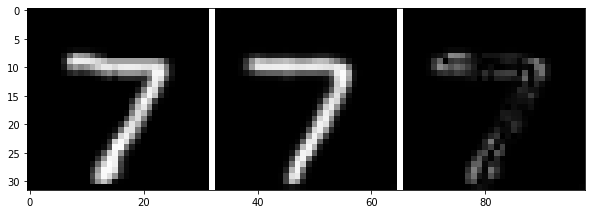

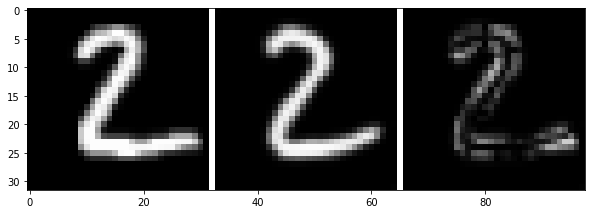

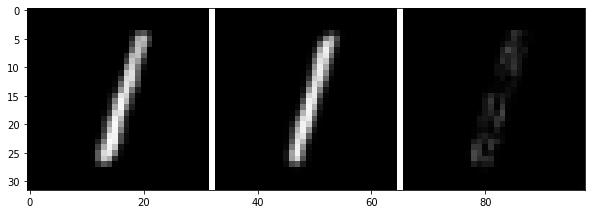

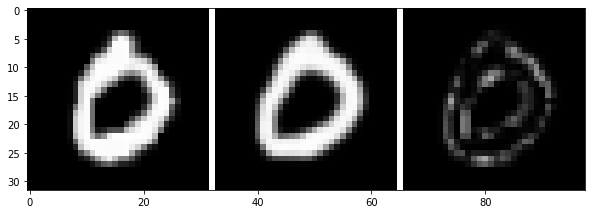

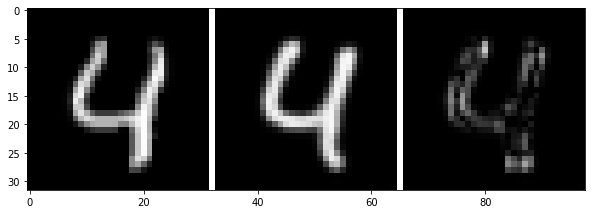

18/02/2020 20:36:34, epoch=136, step=16060, loss=0.09670, distortion=0.139, rate=0.026, -elbo=117.49562, nll=98.83841, KL=18.65721, commit_loss=158.64282, bit_usage=0.97653, highest_prob=0.009, temp=0.06267
18/02/2020 20:36:34, epoch=136, step=16080, loss=0.09742, distortion=0.140, rate=0.026, -elbo=118.22776, nll=99.57832, KL=18.64944, commit_loss=158.56140, bit_usage=0.97543, highest_prob=0.012, temp=0.06192
18/02/2020 20:36:34, epoch=136, step=16100, loss=0.09766, distortion=0.141, rate=0.026, -elbo=118.40173, nll=99.82713, KL=18.57461, commit_loss=157.95229, bit_usage=0.97540, highest_prob=0.011, temp=0.06117
18/02/2020 20:36:35, epoch=136, step=16120, loss=0.09642, distortion=0.139, rate=0.026, -elbo=117.20722, nll=98.56266, KL=18.64456, commit_loss=155.86029, bit_usage=0.97307, highest_prob=0.012, temp=0.06041
18/02/2020 20:36:35, epoch=136, step=16140, loss=0.09547, distortion=0.137, rate=0.026, -elbo=116.14973, nll=97.58382, KL=18.56591, commit_loss=156.28522, bit_usage=0.97648

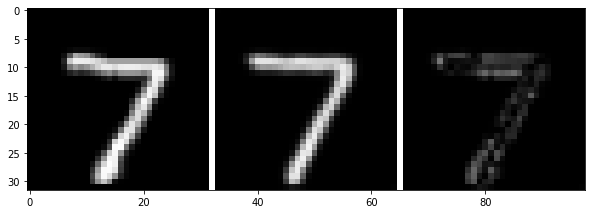

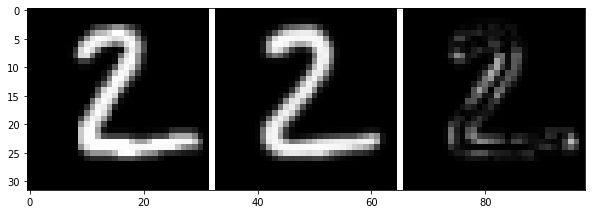

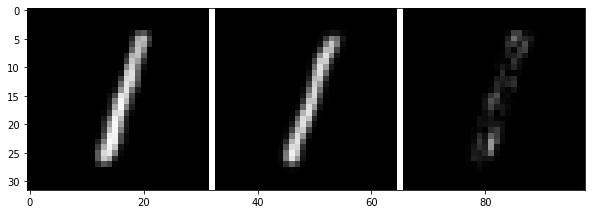

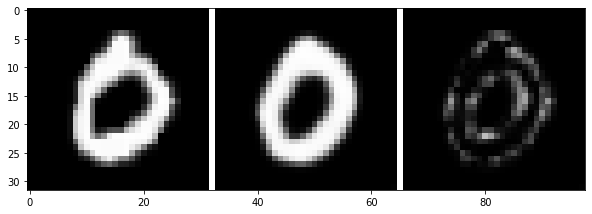

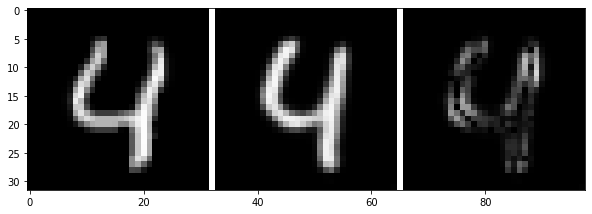

18/02/2020 20:36:48, epoch=141, step=16640, loss=0.09472, distortion=0.136, rate=0.026, -elbo=115.41786, nll=96.81607, KL=18.60179, commit_loss=157.18126, bit_usage=0.97761, highest_prob=0.009, temp=0.04085
18/02/2020 20:36:48, epoch=141, step=16660, loss=0.09808, distortion=0.141, rate=0.026, -elbo=118.87754, nll=100.26133, KL=18.61621, commit_loss=158.79071, bit_usage=0.97473, highest_prob=0.010, temp=0.04009
18/02/2020 20:36:49, epoch=141, step=16680, loss=0.09756, distortion=0.140, rate=0.026, -elbo=118.36766, nll=99.72077, KL=18.64689, commit_loss=157.97876, bit_usage=0.97694, highest_prob=0.009, temp=0.03934
18/02/2020 20:36:49, epoch=141, step=16700, loss=0.09696, distortion=0.140, rate=0.026, -elbo=117.68653, nll=99.10707, KL=18.57946, commit_loss=157.82344, bit_usage=0.97708, highest_prob=0.013, temp=0.03859
18/02/2020 20:36:50, epoch=141, step=16720, loss=0.10220, distortion=0.147, rate=0.026, -elbo=123.18813, nll=104.47514, KL=18.71300, commit_loss=158.15013, bit_usage=0.976

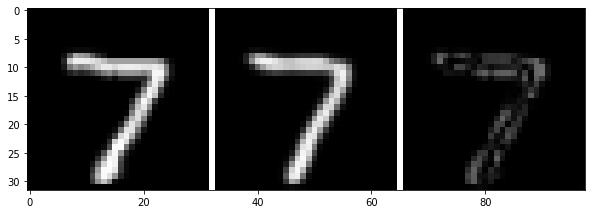

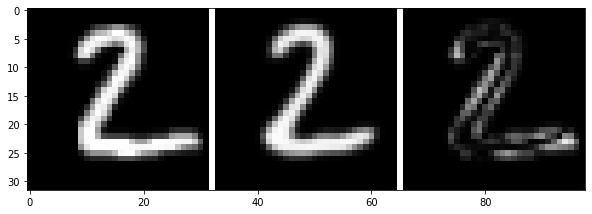

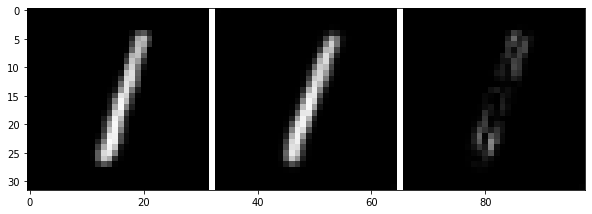

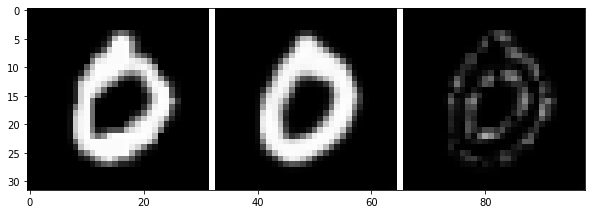

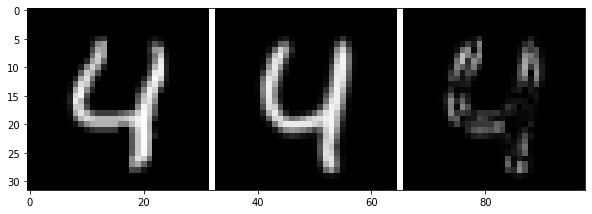

18/02/2020 20:37:04, epoch=146, step=17240, loss=0.09804, distortion=0.141, rate=0.026, -elbo=118.86826, nll=100.21185, KL=18.65640, commit_loss=158.44139, bit_usage=0.97570, highest_prob=0.009, temp=0.01827
18/02/2020 20:37:04, epoch=146, step=17260, loss=0.09672, distortion=0.139, rate=0.026, -elbo=117.56560, nll=98.86091, KL=18.70469, commit_loss=157.52557, bit_usage=0.97503, highest_prob=0.010, temp=0.01752
18/02/2020 20:37:04, epoch=146, step=17280, loss=0.09931, distortion=0.143, rate=0.026, -elbo=120.21503, nll=101.51855, KL=18.69648, commit_loss=159.56152, bit_usage=0.97339, highest_prob=0.009, temp=0.01677
18/02/2020 20:37:05, epoch=146, step=17300, loss=0.09755, distortion=0.140, rate=0.026, -elbo=118.41661, nll=99.71283, KL=18.70378, commit_loss=157.63548, bit_usage=0.97587, highest_prob=0.012, temp=0.01601
18/02/2020 20:37:05, epoch=146, step=17320, loss=0.09997, distortion=0.144, rate=0.026, -elbo=120.84931, nll=102.19444, KL=18.65487, commit_loss=158.97827, bit_usage=0.97

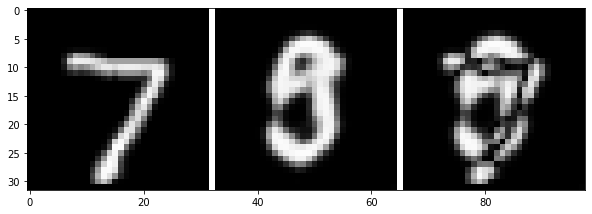

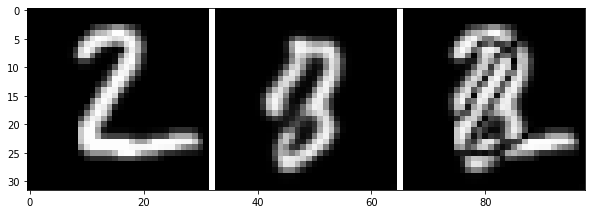

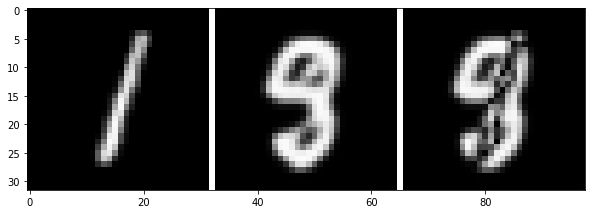

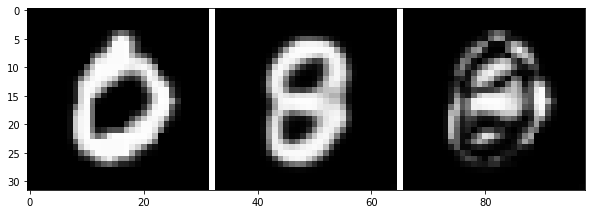

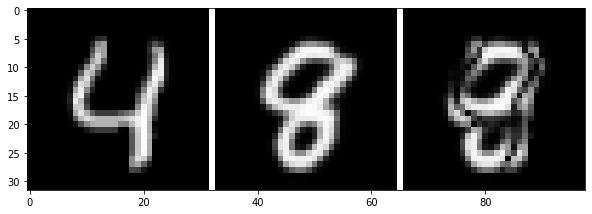

18/02/2020 20:37:19, epoch=1, step=120, loss=0.62369, distortion=0.900, rate=0.027, -elbo=164.42285, nll=159.62839, KL=4.79447, commit_loss=32.25740, bit_usage=0.26567, highest_prob=0.289, temp=0.66245
reset code 48
pruned code 48 - 508 remain
18/02/2020 20:37:20, epoch=1, step=140, loss=0.59029, distortion=0.851, rate=0.028, -elbo=156.02829, nll=151.07834, KL=4.94995, commit_loss=32.00877, bit_usage=0.29356, highest_prob=0.271, temp=0.66169
reset code 48
18/02/2020 20:37:20, epoch=1, step=160, loss=0.55798, distortion=0.805, rate=0.029, -elbo=147.93553, nll=142.80722, KL=5.12832, commit_loss=31.30601, bit_usage=0.29427, highest_prob=0.396, temp=0.66094
reset code 64
pruned code 64 - 507 remain
18/02/2020 20:37:21, epoch=1, step=180, loss=0.56010, distortion=0.808, rate=0.029, -elbo=148.57693, nll=143.34909, KL=5.22785, commit_loss=31.54983, bit_usage=0.27846, highest_prob=0.463, temp=0.66019
reset code 64
18/02/2020 20:37:22, epoch=1, step=200, loss=0.54802, distortion=0.790, rate=0.0

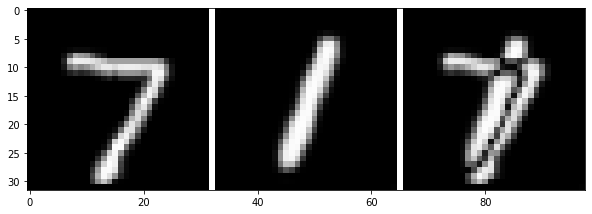

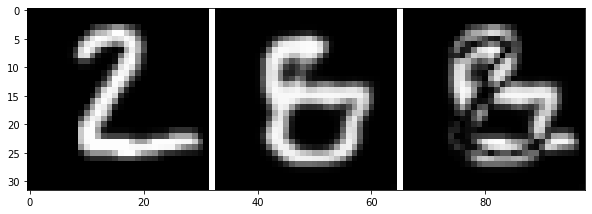

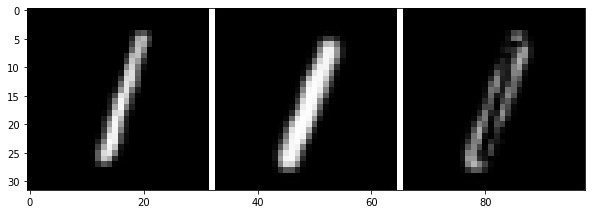

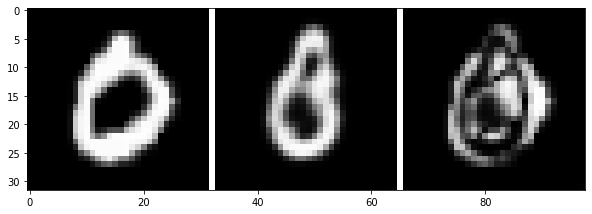

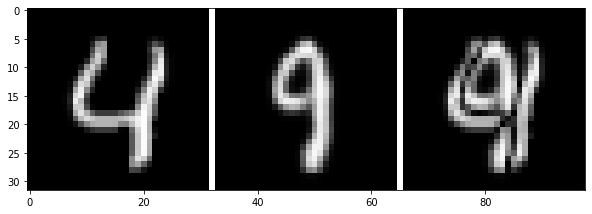

18/02/2020 20:37:39, epoch=6, step=720, loss=0.45023, distortion=0.649, rate=0.022, -elbo=119.16471, nll=115.22165, KL=3.94306, commit_loss=32.14105, bit_usage=0.55361, highest_prob=0.072, temp=0.63987
reset code 288
pruned code 288 - 493 remain
18/02/2020 20:37:40, epoch=6, step=740, loss=0.44478, distortion=0.641, rate=0.022, -elbo=117.79470, nll=113.82684, KL=3.96786, commit_loss=31.95319, bit_usage=0.55242, highest_prob=0.070, temp=0.63912
reset code 288
18/02/2020 20:37:41, epoch=6, step=760, loss=0.43651, distortion=0.630, rate=0.022, -elbo=115.61304, nll=111.71151, KL=3.90153, commit_loss=32.15068, bit_usage=0.56077, highest_prob=0.064, temp=0.63837
reset code 304
pruned code 304 - 492 remain
18/02/2020 20:37:41, epoch=6, step=780, loss=0.44153, distortion=0.637, rate=0.022, -elbo=116.92113, nll=112.99693, KL=3.92420, commit_loss=31.84204, bit_usage=0.56261, highest_prob=0.061, temp=0.63761
reset code 304
18/02/2020 20:37:42, epoch=6, step=800, loss=0.44573, distortion=0.643, ra

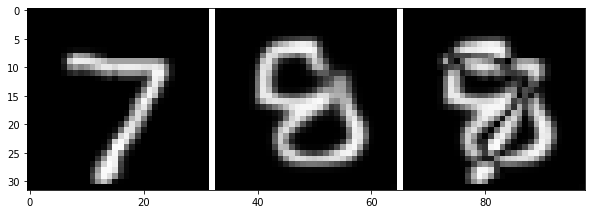

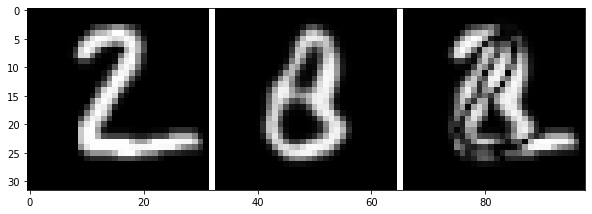

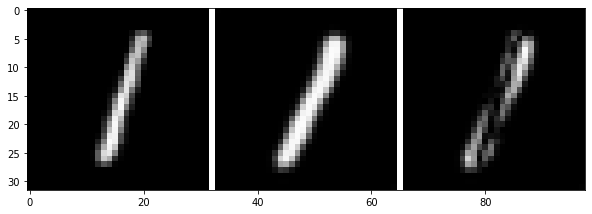

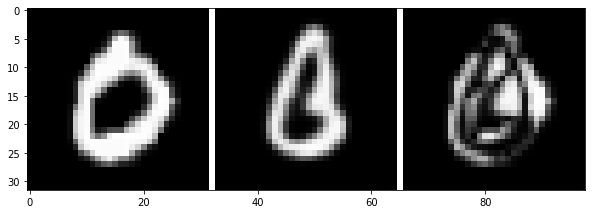

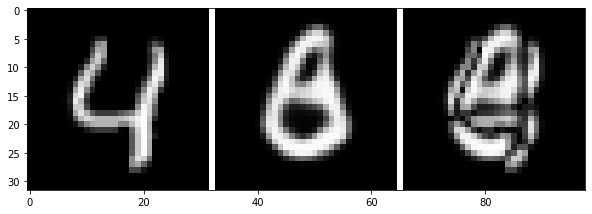

18/02/2020 20:37:58, epoch=11, step=1300, loss=0.41843, distortion=0.603, rate=0.020, -elbo=110.65956, nll=107.08412, KL=3.57544, commit_loss=31.50875, bit_usage=0.63949, highest_prob=0.049, temp=0.61805
reset code 32
18/02/2020 20:37:58, epoch=11, step=1320, loss=0.42039, distortion=0.606, rate=0.020, -elbo=111.16512, nll=107.58387, KL=3.58125, commit_loss=31.47851, bit_usage=0.64765, highest_prob=0.053, temp=0.61729
reset code 48
pruned code 48 - 478 remain
18/02/2020 20:37:58, epoch=11, step=1340, loss=0.41388, distortion=0.597, rate=0.020, -elbo=109.49976, nll=105.91902, KL=3.58074, commit_loss=31.51595, bit_usage=0.64190, highest_prob=0.051, temp=0.61654
reset code 48
18/02/2020 20:37:59, epoch=11, step=1360, loss=0.41573, distortion=0.600, rate=0.020, -elbo=109.99239, nll=106.39136, KL=3.60103, commit_loss=31.37742, bit_usage=0.64463, highest_prob=0.053, temp=0.61579
reset code 64
pruned code 64 - 477 remain
18/02/2020 20:38:00, epoch=11, step=1380, loss=0.41125, distortion=0.593

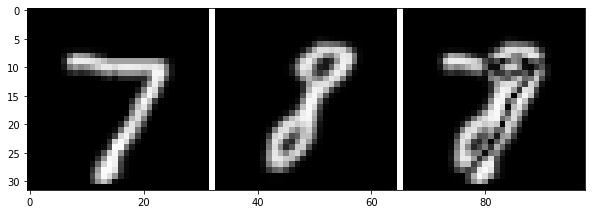

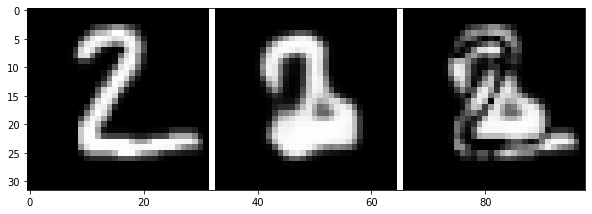

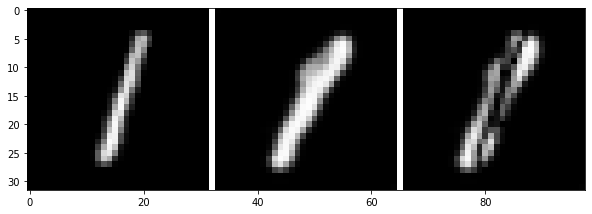

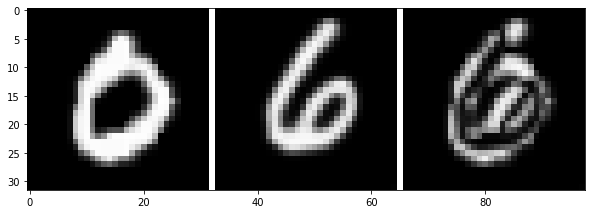

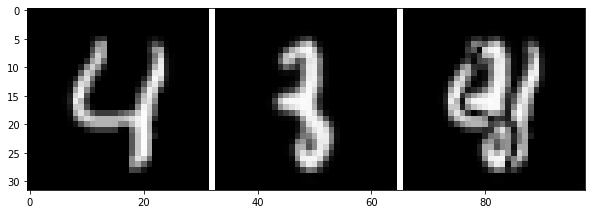

18/02/2020 20:38:15, epoch=16, step=1900, loss=0.40603, distortion=0.586, rate=0.018, -elbo=107.10718, nll=103.90892, KL=3.19826, commit_loss=31.59307, bit_usage=0.69609, highest_prob=0.041, temp=0.59547
reset code 32
18/02/2020 20:38:15, epoch=16, step=1920, loss=0.38543, distortion=0.556, rate=0.018, -elbo=101.85941, nll=98.63545, KL=3.22396, commit_loss=31.42869, bit_usage=0.69245, highest_prob=0.047, temp=0.59472
reset code 48
pruned code 48 - 463 remain
18/02/2020 20:38:16, epoch=16, step=1940, loss=0.39331, distortion=0.567, rate=0.018, -elbo=103.82896, nll=100.65161, KL=3.17736, commit_loss=31.65553, bit_usage=0.69930, highest_prob=0.039, temp=0.59397
reset code 48
18/02/2020 20:38:16, epoch=16, step=1960, loss=0.40072, distortion=0.578, rate=0.018, -elbo=105.69692, nll=102.55061, KL=3.14631, commit_loss=31.69243, bit_usage=0.69901, highest_prob=0.045, temp=0.59321
reset code 64
pruned code 64 - 462 remain
18/02/2020 20:38:16, epoch=16, step=1980, loss=0.40271, distortion=0.581,

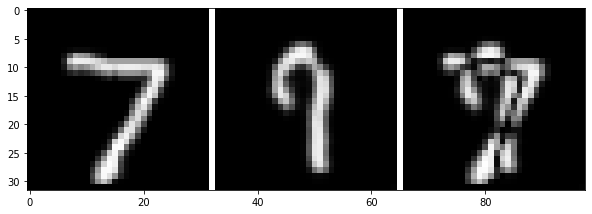

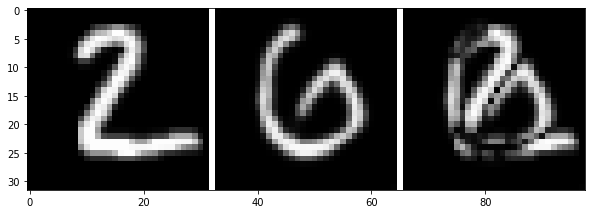

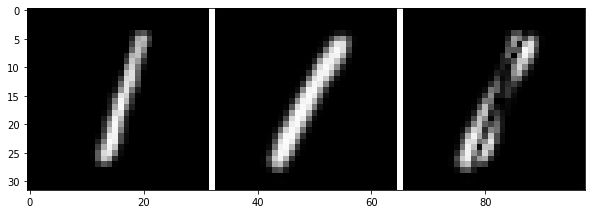

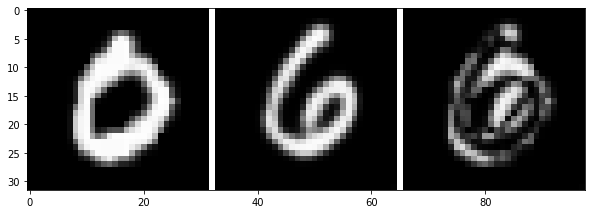

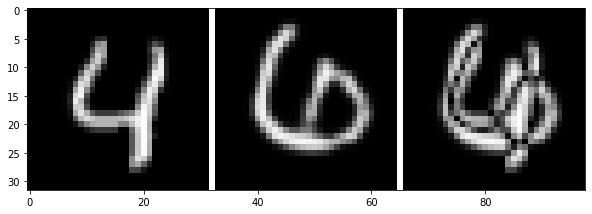

18/02/2020 20:38:33, epoch=21, step=2480, loss=0.39727, distortion=0.573, rate=0.016, -elbo=104.57874, nll=101.66701, KL=2.91173, commit_loss=32.02993, bit_usage=0.74222, highest_prob=0.027, temp=0.57365
reset code 288
pruned code 288 - 449 remain
18/02/2020 20:38:34, epoch=21, step=2500, loss=0.39216, distortion=0.566, rate=0.016, -elbo=103.24166, nll=100.35837, KL=2.88330, commit_loss=32.14280, bit_usage=0.73826, highest_prob=0.033, temp=0.57289
reset code 24
18/02/2020 20:38:34, epoch=21, step=2520, loss=0.39169, distortion=0.565, rate=0.016, -elbo=103.13515, nll=100.23699, KL=2.89817, commit_loss=32.03921, bit_usage=0.74663, highest_prob=0.037, temp=0.57214
reset code 40
pruned code 40 - 448 remain
18/02/2020 20:38:35, epoch=21, step=2540, loss=0.39207, distortion=0.565, rate=0.016, -elbo=103.24733, nll=100.33430, KL=2.91303, commit_loss=32.06703, bit_usage=0.74023, highest_prob=0.035, temp=0.57139
reset code 48
18/02/2020 20:38:35, epoch=21, step=2560, loss=0.39219, distortion=0.5

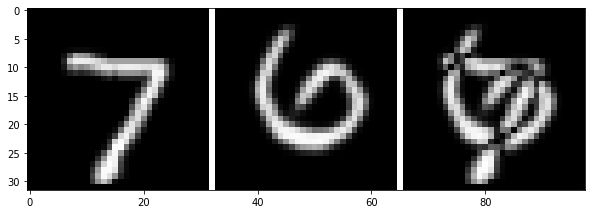

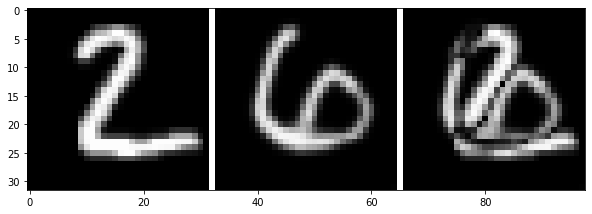

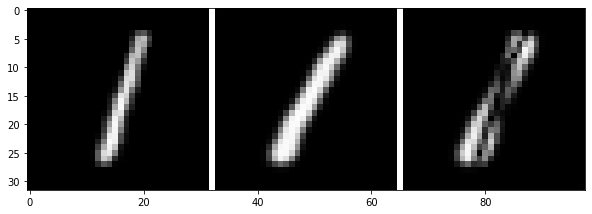

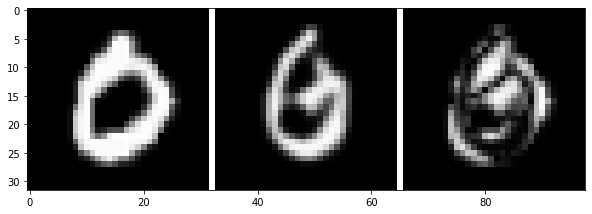

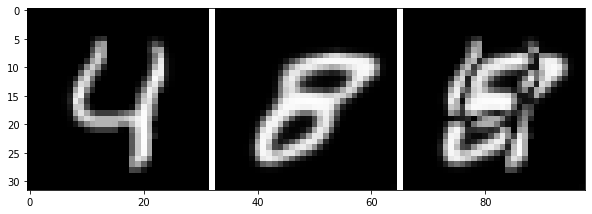

18/02/2020 20:38:53, epoch=26, step=3080, loss=0.38852, distortion=0.560, rate=0.016, -elbo=102.22093, nll=99.42714, KL=2.79379, commit_loss=32.31623, bit_usage=0.76497, highest_prob=0.037, temp=0.55107
reset code 320
pruned code 320 - 434 remain
18/02/2020 20:38:53, epoch=26, step=3100, loss=0.38444, distortion=0.554, rate=0.016, -elbo=101.20087, nll=98.38164, KL=2.81924, commit_loss=32.40660, bit_usage=0.76895, highest_prob=0.041, temp=0.55032
reset code 320
18/02/2020 20:38:54, epoch=26, step=3120, loss=0.38252, distortion=0.552, rate=0.016, -elbo=100.76352, nll=97.88934, KL=2.87418, commit_loss=32.54811, bit_usage=0.77070, highest_prob=0.053, temp=0.54957
reset code 336
pruned code 336 - 433 remain
18/02/2020 20:38:54, epoch=26, step=3140, loss=0.38029, distortion=0.548, rate=0.016, -elbo=100.17921, nll=97.31788, KL=2.86134, commit_loss=32.72369, bit_usage=0.77211, highest_prob=0.045, temp=0.54881
reset code 40
18/02/2020 20:38:55, epoch=26, step=3160, loss=0.38657, distortion=0.55

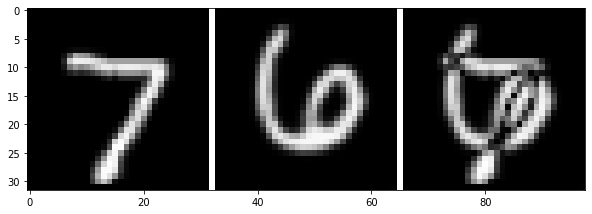

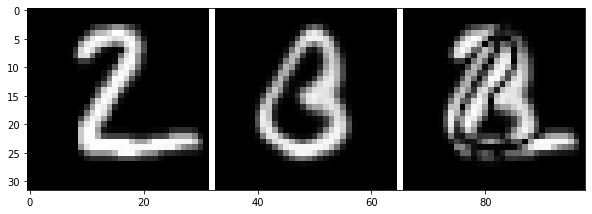

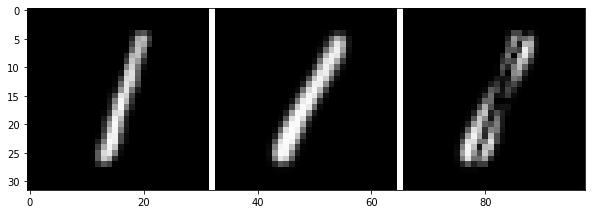

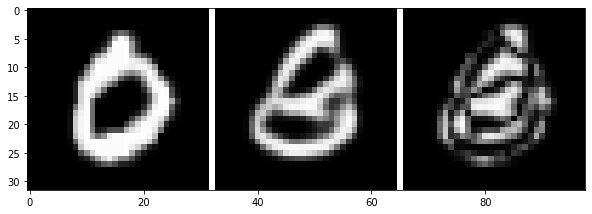

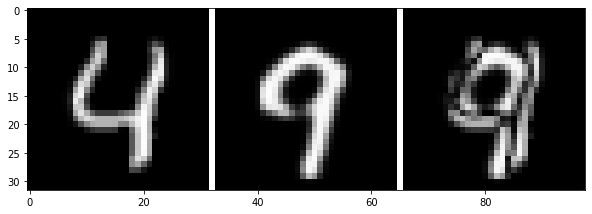

18/02/2020 20:39:10, epoch=31, step=3660, loss=0.36812, distortion=0.531, rate=0.017, -elbo=97.15114, nll=94.20166, KL=2.94948, commit_loss=34.75734, bit_usage=0.78004, highest_prob=0.031, temp=0.52925
reset code 288
18/02/2020 20:39:11, epoch=31, step=3680, loss=0.37454, distortion=0.540, rate=0.016, -elbo=98.72644, nll=95.84300, KL=2.88344, commit_loss=35.07899, bit_usage=0.77725, highest_prob=0.037, temp=0.52849
reset code 304
pruned code 304 - 419 remain
18/02/2020 20:39:11, epoch=31, step=3700, loss=0.37117, distortion=0.535, rate=0.017, -elbo=97.97123, nll=94.98168, KL=2.98954, commit_loss=34.65569, bit_usage=0.78384, highest_prob=0.033, temp=0.52774
reset code 304
18/02/2020 20:39:12, epoch=31, step=3720, loss=0.36921, distortion=0.532, rate=0.017, -elbo=97.42347, nll=94.48091, KL=2.94256, commit_loss=34.96333, bit_usage=0.78346, highest_prob=0.035, temp=0.52699
reset code 320
pruned code 320 - 418 remain
18/02/2020 20:39:12, epoch=31, step=3740, loss=0.37169, distortion=0.536, 

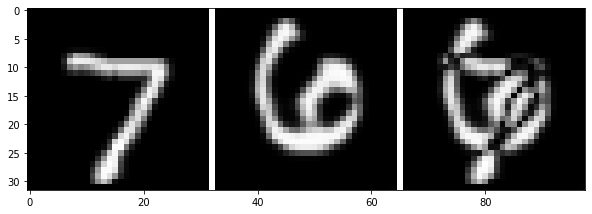

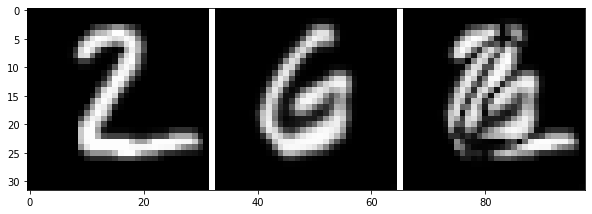

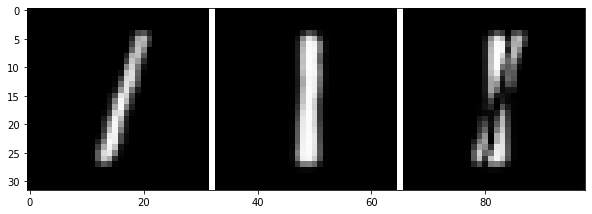

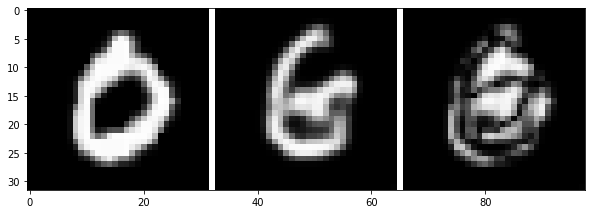

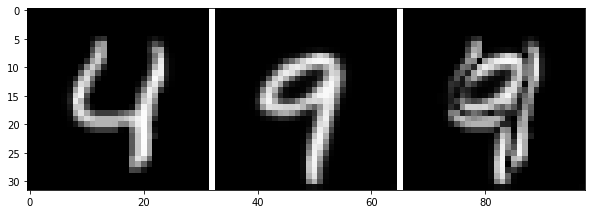

18/02/2020 20:39:28, epoch=36, step=4260, loss=0.36048, distortion=0.520, rate=0.018, -elbo=95.41809, nll=92.24354, KL=3.17455, commit_loss=37.40521, bit_usage=0.79271, highest_prob=0.035, temp=0.50667
reset code 336
18/02/2020 20:39:29, epoch=36, step=4280, loss=0.35692, distortion=0.515, rate=0.018, -elbo=94.56983, nll=91.33028, KL=3.23956, commit_loss=37.91705, bit_usage=0.79120, highest_prob=0.041, temp=0.50592
reset code 352
pruned code 352 - 404 remain
18/02/2020 20:39:29, epoch=36, step=4300, loss=0.36506, distortion=0.526, rate=0.018, -elbo=96.56502, nll=93.41378, KL=3.15124, commit_loss=37.85726, bit_usage=0.79219, highest_prob=0.035, temp=0.50517
reset code 352
18/02/2020 20:39:30, epoch=36, step=4320, loss=0.36016, distortion=0.519, rate=0.018, -elbo=95.37562, nll=92.16016, KL=3.21546, commit_loss=37.41102, bit_usage=0.80611, highest_prob=0.029, temp=0.50441
reset code 368
pruned code 368 - 403 remain
18/02/2020 20:39:30, epoch=36, step=4340, loss=0.36186, distortion=0.522, 

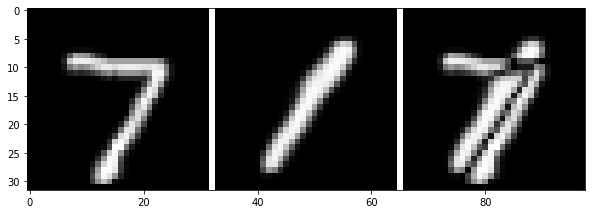

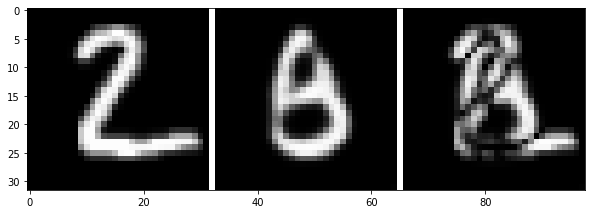

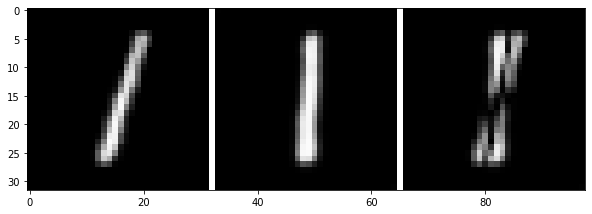

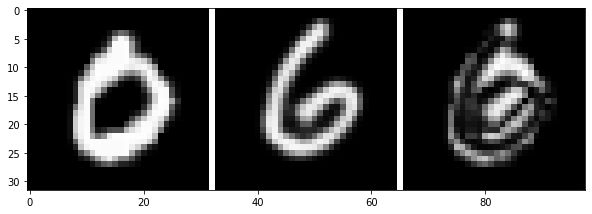

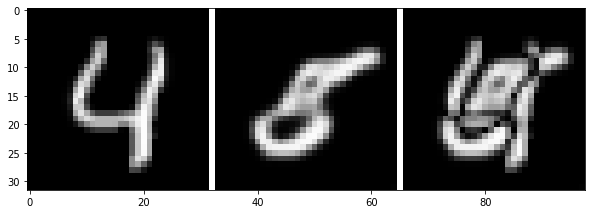

18/02/2020 20:39:47, epoch=41, step=4840, loss=0.34708, distortion=0.500, rate=0.019, -elbo=92.13375, nll=88.80856, KL=3.32519, commit_loss=39.33072, bit_usage=0.78600, highest_prob=0.031, temp=0.48485
reset code 336
pruned code 336 - 390 remain
18/02/2020 20:39:48, epoch=41, step=4860, loss=0.34854, distortion=0.503, rate=0.019, -elbo=92.50239, nll=89.18404, KL=3.31834, commit_loss=39.32613, bit_usage=0.80550, highest_prob=0.033, temp=0.48409
reset code 336
18/02/2020 20:39:48, epoch=41, step=4880, loss=0.34729, distortion=0.501, rate=0.019, -elbo=92.20633, nll=88.86296, KL=3.34337, commit_loss=39.87076, bit_usage=0.81090, highest_prob=0.039, temp=0.48334
reset code 352
pruned code 352 - 389 remain
18/02/2020 20:39:49, epoch=41, step=4900, loss=0.35278, distortion=0.509, rate=0.019, -elbo=93.63400, nll=90.26723, KL=3.36677, commit_loss=40.01766, bit_usage=0.80311, highest_prob=0.031, temp=0.48259
reset code 352
18/02/2020 20:39:49, epoch=41, step=4920, loss=0.34296, distortion=0.495, 

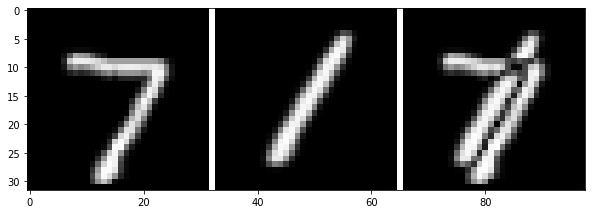

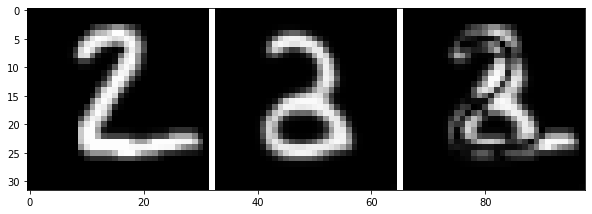

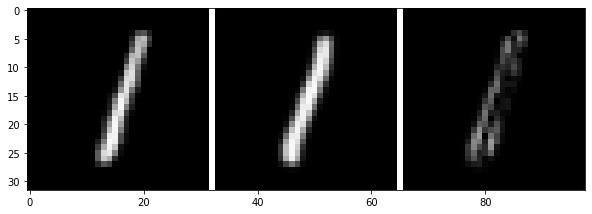

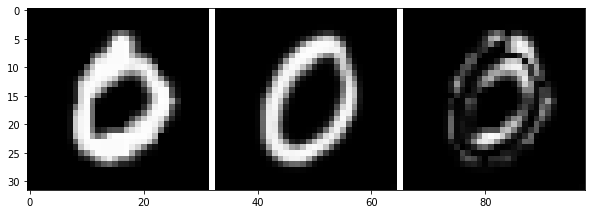

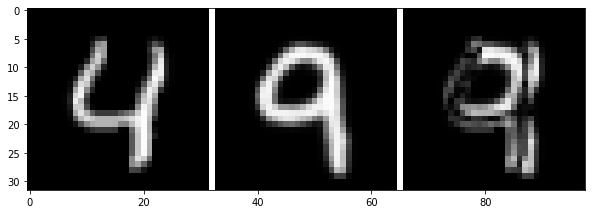

18/02/2020 20:40:06, epoch=46, step=5440, loss=0.34719, distortion=0.501, rate=0.020, -elbo=92.41854, nll=88.83793, KL=3.58061, commit_loss=40.00336, bit_usage=0.79050, highest_prob=0.039, temp=0.46227
reset code 368
pruned code 368 - 375 remain
18/02/2020 20:40:06, epoch=46, step=5460, loss=0.34041, distortion=0.491, rate=0.020, -elbo=90.64906, nll=87.10204, KL=3.54702, commit_loss=40.15279, bit_usage=0.78610, highest_prob=0.057, temp=0.46152
reset code 368
18/02/2020 20:40:07, epoch=46, step=5480, loss=0.34473, distortion=0.497, rate=0.020, -elbo=91.81400, nll=88.20541, KL=3.60859, commit_loss=41.40305, bit_usage=0.80066, highest_prob=0.031, temp=0.46077
reset code 120
pruned code 120 - 374 remain
18/02/2020 20:40:08, epoch=46, step=5500, loss=0.34021, distortion=0.491, rate=0.020, -elbo=90.65853, nll=87.04792, KL=3.61061, commit_loss=41.61975, bit_usage=0.78712, highest_prob=0.051, temp=0.46001
reset code 128
18/02/2020 20:40:08, epoch=46, step=5520, loss=0.33670, distortion=0.485, 

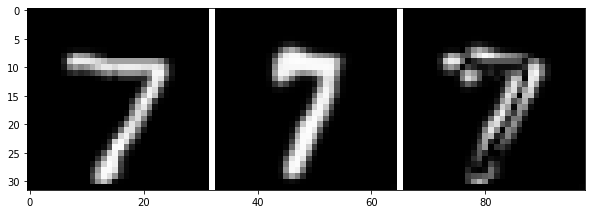

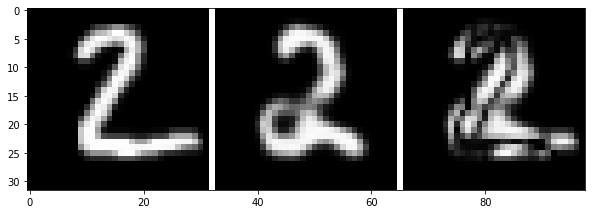

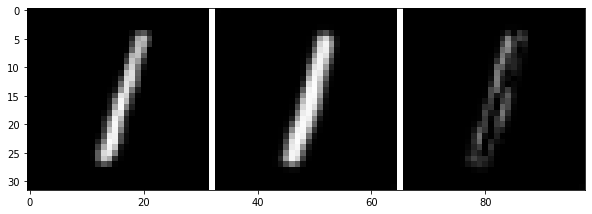

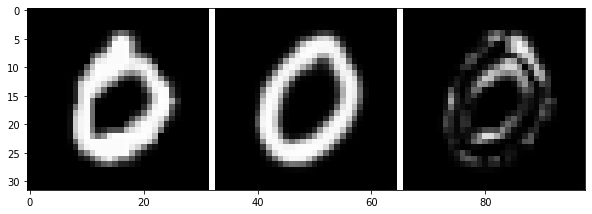

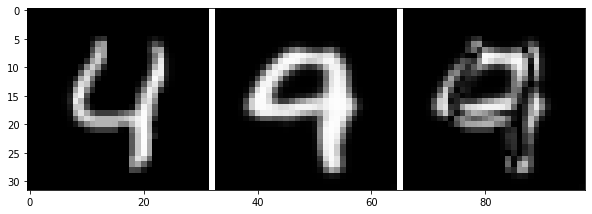

18/02/2020 20:40:25, epoch=51, step=6020, loss=0.33109, distortion=0.477, rate=0.021, -elbo=88.48402, nll=84.71173, KL=3.77229, commit_loss=44.04431, bit_usage=0.79649, highest_prob=0.043, temp=0.44045
reset code 304
18/02/2020 20:40:26, epoch=51, step=6040, loss=0.32809, distortion=0.473, rate=0.021, -elbo=87.73766, nll=83.94414, KL=3.79351, commit_loss=43.82880, bit_usage=0.78761, highest_prob=0.041, temp=0.43969
reset code 320
pruned code 320 - 360 remain
18/02/2020 20:40:26, epoch=51, step=6060, loss=0.33624, distortion=0.485, rate=0.021, -elbo=89.79106, nll=86.03128, KL=3.75978, commit_loss=42.72787, bit_usage=0.78017, highest_prob=0.039, temp=0.43894
reset code 320
18/02/2020 20:40:27, epoch=51, step=6080, loss=0.33173, distortion=0.478, rate=0.022, -elbo=88.71838, nll=84.87582, KL=3.84257, commit_loss=42.81113, bit_usage=0.79252, highest_prob=0.041, temp=0.43819
reset code 336
pruned code 336 - 359 remain
18/02/2020 20:40:27, epoch=51, step=6100, loss=0.32504, distortion=0.469, 

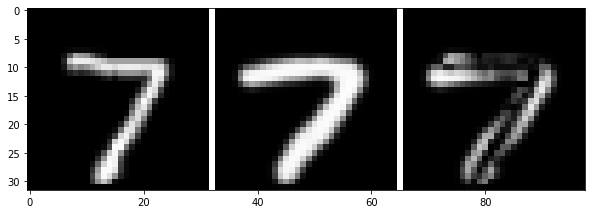

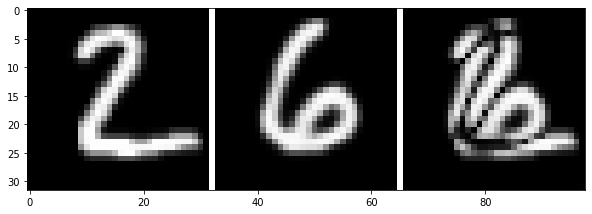

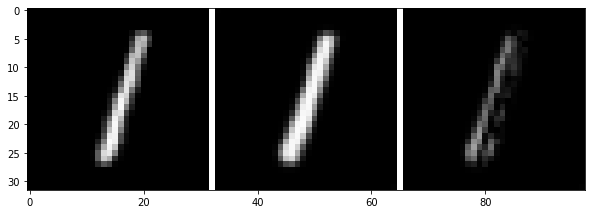

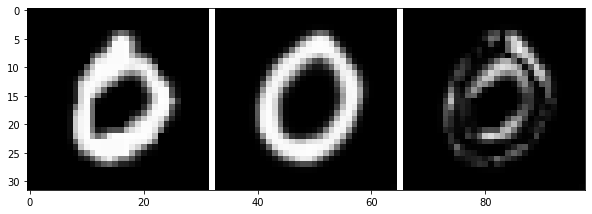

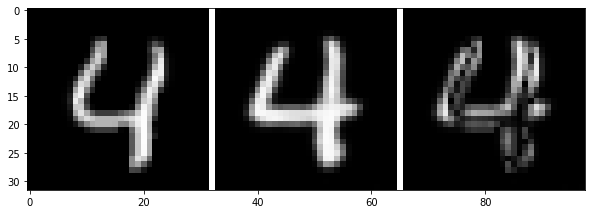

18/02/2020 20:40:44, epoch=56, step=6620, loss=0.32101, distortion=0.463, rate=0.022, -elbo=85.99348, nll=82.13071, KL=3.86277, commit_loss=44.91811, bit_usage=0.79676, highest_prob=0.033, temp=0.41787
reset code 224
18/02/2020 20:40:45, epoch=56, step=6640, loss=0.32311, distortion=0.466, rate=0.022, -elbo=86.59600, nll=82.66724, KL=3.92876, commit_loss=44.63387, bit_usage=0.80647, highest_prob=0.031, temp=0.41712
reset code 288
pruned code 288 - 345 remain
18/02/2020 20:40:46, epoch=56, step=6660, loss=0.31209, distortion=0.450, rate=0.022, -elbo=83.80914, nll=79.84540, KL=3.96374, commit_loss=44.97841, bit_usage=0.79738, highest_prob=0.033, temp=0.41637
reset code 304
18/02/2020 20:40:46, epoch=56, step=6680, loss=0.32028, distortion=0.462, rate=0.022, -elbo=85.86930, nll=81.94292, KL=3.92638, commit_loss=44.81410, bit_usage=0.81276, highest_prob=0.027, temp=0.41561
reset code 336
pruned code 336 - 344 remain
18/02/2020 20:40:47, epoch=56, step=6700, loss=0.32078, distortion=0.463, 

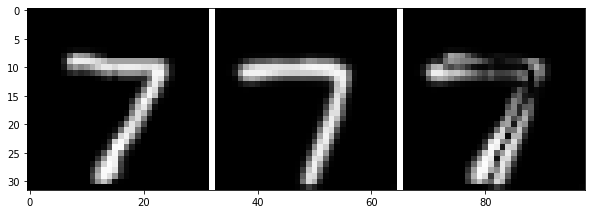

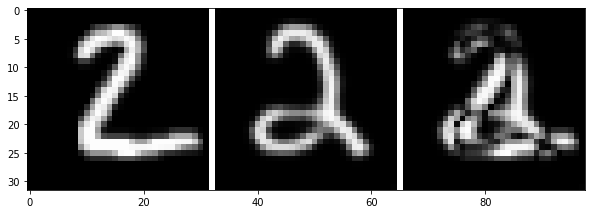

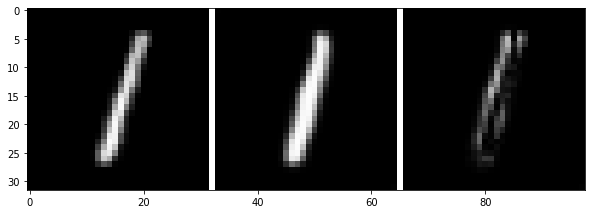

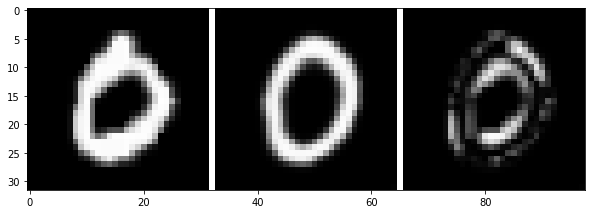

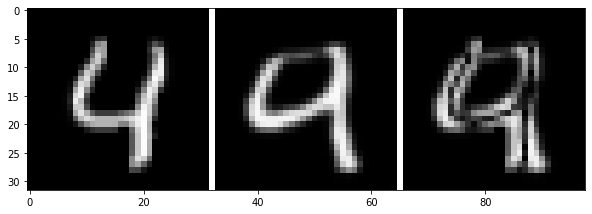

18/02/2020 20:41:04, epoch=61, step=7200, loss=0.31183, distortion=0.450, rate=0.023, -elbo=83.86685, nll=79.77898, KL=4.08788, commit_loss=46.42433, bit_usage=0.79312, highest_prob=0.037, temp=0.39605
reset code 288
pruned code 288 - 331 remain
18/02/2020 20:41:05, epoch=61, step=7220, loss=0.31593, distortion=0.456, rate=0.023, -elbo=84.97568, nll=80.82660, KL=4.14908, commit_loss=46.12791, bit_usage=0.78835, highest_prob=0.031, temp=0.39529
reset code 168
18/02/2020 20:41:05, epoch=61, step=7240, loss=0.31227, distortion=0.450, rate=0.023, -elbo=83.97697, nll=79.89091, KL=4.08605, commit_loss=46.63732, bit_usage=0.81337, highest_prob=0.033, temp=0.39454
reset code 184
pruned code 184 - 330 remain
18/02/2020 20:41:06, epoch=61, step=7260, loss=0.29753, distortion=0.429, rate=0.024, -elbo=80.33406, nll=76.11504, KL=4.21902, commit_loss=47.45525, bit_usage=0.79016, highest_prob=0.035, temp=0.39379
reset code 192
18/02/2020 20:41:07, epoch=61, step=7280, loss=0.30887, distortion=0.445, 

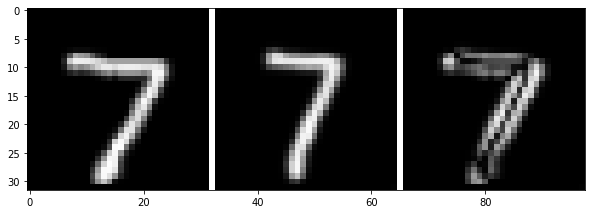

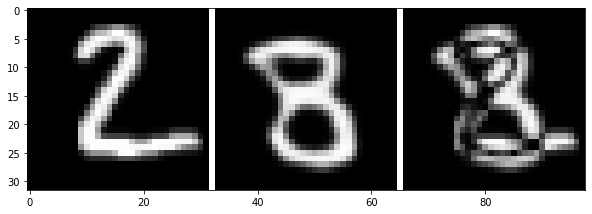

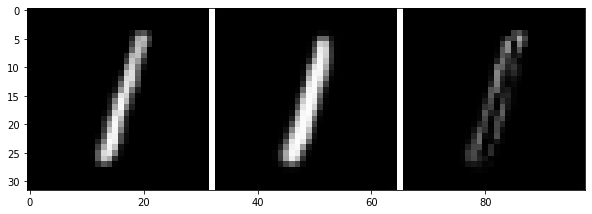

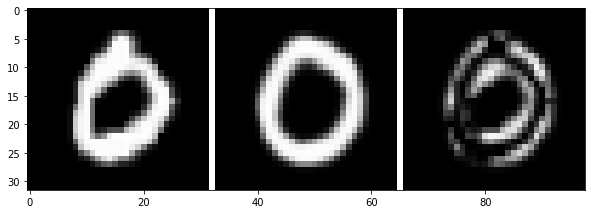

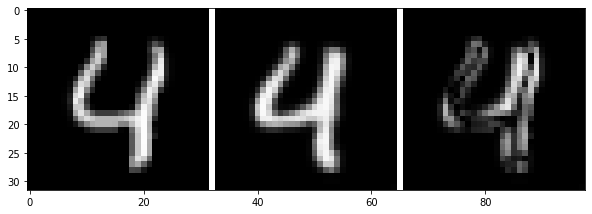

18/02/2020 20:41:24, epoch=66, step=7800, loss=0.30651, distortion=0.442, rate=0.024, -elbo=82.63708, nll=78.41299, KL=4.22408, commit_loss=48.36637, bit_usage=0.81680, highest_prob=0.021, temp=0.37347
reset code 16
pruned code 16 - 316 remain
18/02/2020 20:41:25, epoch=66, step=7820, loss=0.30263, distortion=0.436, rate=0.024, -elbo=81.63049, nll=77.42204, KL=4.20845, commit_loss=47.99552, bit_usage=0.81968, highest_prob=0.029, temp=0.37272
reset code 16
18/02/2020 20:41:25, epoch=66, step=7840, loss=0.30219, distortion=0.436, rate=0.024, -elbo=81.56927, nll=77.30840, KL=4.26088, commit_loss=48.29278, bit_usage=0.81416, highest_prob=0.023, temp=0.37197
reset code 32
pruned code 32 - 315 remain
18/02/2020 20:41:26, epoch=66, step=7860, loss=0.29917, distortion=0.431, rate=0.024, -elbo=80.83668, nll=76.53371, KL=4.30297, commit_loss=48.59489, bit_usage=0.81144, highest_prob=0.039, temp=0.37121
reset code 32
18/02/2020 20:41:26, epoch=66, step=7880, loss=0.30177, distortion=0.435, rate=0

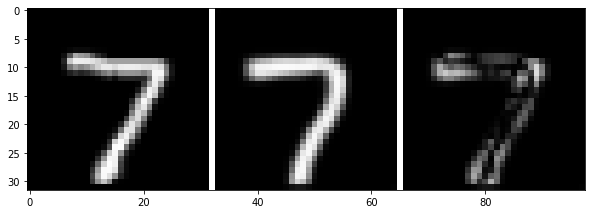

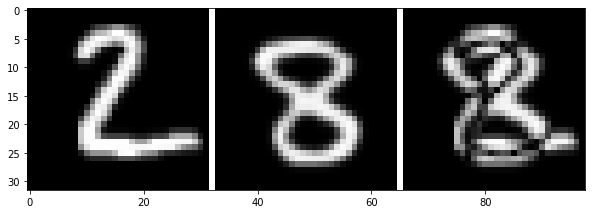

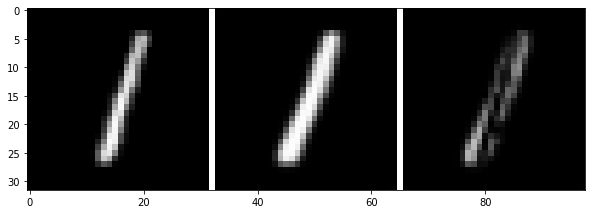

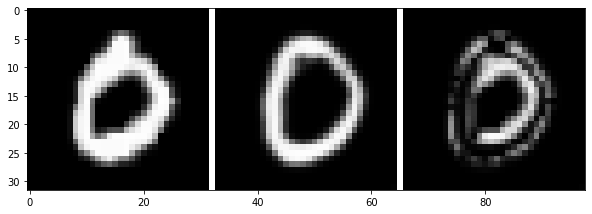

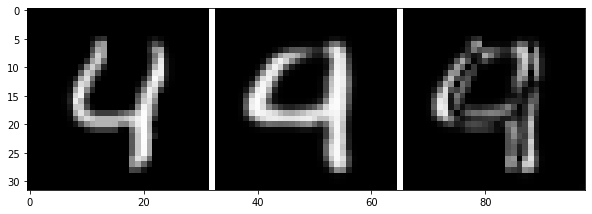

18/02/2020 20:41:41, epoch=71, step=8380, loss=0.29038, distortion=0.419, rate=0.024, -elbo=78.59416, nll=74.28482, KL=4.30934, commit_loss=49.26444, bit_usage=0.82632, highest_prob=0.027, temp=0.35165
reset code 112
18/02/2020 20:41:41, epoch=71, step=8400, loss=0.29231, distortion=0.421, rate=0.024, -elbo=79.10380, nll=74.77838, KL=4.32542, commit_loss=48.61180, bit_usage=0.82863, highest_prob=0.023, temp=0.35089
reset code 192
pruned code 192 - 301 remain
18/02/2020 20:41:42, epoch=71, step=8420, loss=0.30351, distortion=0.438, rate=0.024, -elbo=81.93701, nll=77.64517, KL=4.29184, commit_loss=48.13689, bit_usage=0.83217, highest_prob=0.027, temp=0.35014
reset code 144
18/02/2020 20:41:42, epoch=71, step=8440, loss=0.28191, distortion=0.406, rate=0.024, -elbo=76.44955, nll=72.11629, KL=4.33326, commit_loss=48.98537, bit_usage=0.82462, highest_prob=0.025, temp=0.34939
reset code 240
pruned code 240 - 300 remain
18/02/2020 20:41:43, epoch=71, step=8460, loss=0.29917, distortion=0.431, 

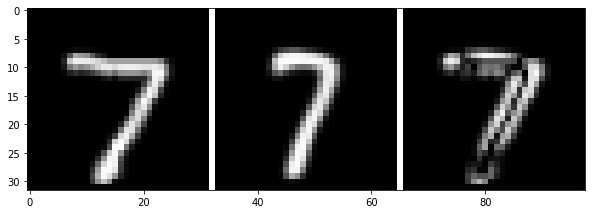

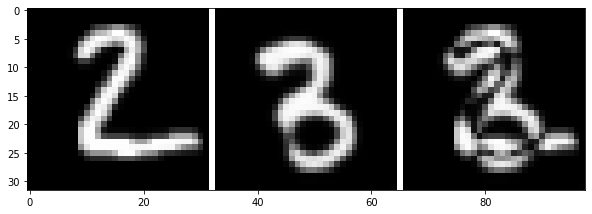

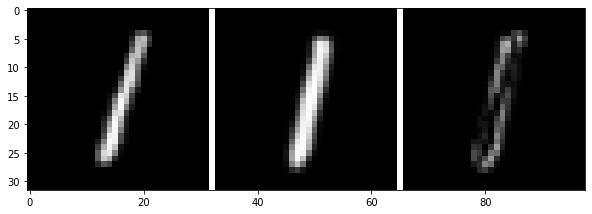

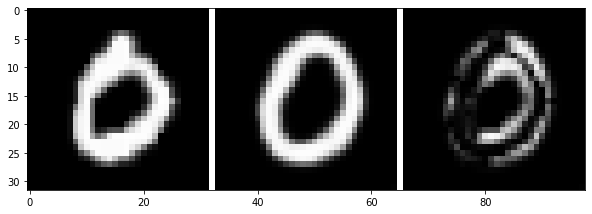

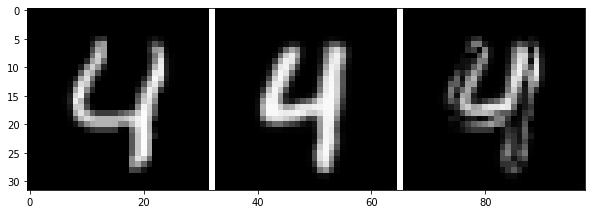

18/02/2020 20:41:58, epoch=76, step=8980, loss=0.28828, distortion=0.416, rate=0.025, -elbo=78.13840, nll=73.74603, KL=4.39237, commit_loss=50.09042, bit_usage=0.83846, highest_prob=0.023, temp=0.32907
reset code 176
18/02/2020 20:41:58, epoch=76, step=9000, loss=0.28913, distortion=0.417, rate=0.025, -elbo=78.36050, nll=73.96191, KL=4.39859, commit_loss=49.80146, bit_usage=0.84242, highest_prob=0.021, temp=0.32832
reset code 192
pruned code 192 - 286 remain
18/02/2020 20:41:59, epoch=76, step=9020, loss=0.28852, distortion=0.416, rate=0.025, -elbo=78.22626, nll=73.80605, KL=4.42022, commit_loss=50.54862, bit_usage=0.84702, highest_prob=0.023, temp=0.32757
reset code 192
18/02/2020 20:41:59, epoch=76, step=9040, loss=0.28424, distortion=0.410, rate=0.025, -elbo=77.16216, nll=72.71155, KL=4.45060, commit_loss=50.57872, bit_usage=0.83412, highest_prob=0.027, temp=0.32681
reset code 20
pruned code 20 - 285 remain
18/02/2020 20:42:00, epoch=76, step=9060, loss=0.28533, distortion=0.411, ra

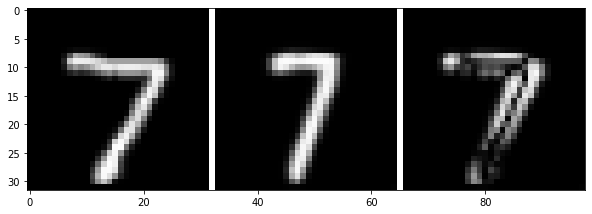

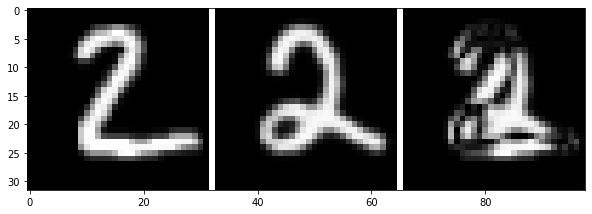

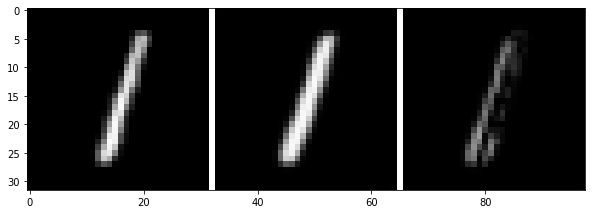

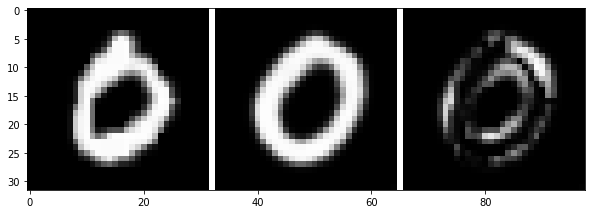

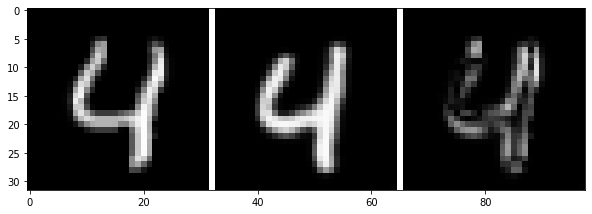

18/02/2020 20:42:17, epoch=81, step=9560, loss=0.28609, distortion=0.412, rate=0.025, -elbo=77.59534, nll=73.18331, KL=4.41202, commit_loss=50.90877, bit_usage=0.86001, highest_prob=0.023, temp=0.30725
reset code 112
pruned code 112 - 272 remain
18/02/2020 20:42:18, epoch=81, step=9580, loss=0.28390, distortion=0.409, rate=0.025, -elbo=77.07174, nll=72.62265, KL=4.44909, commit_loss=50.88466, bit_usage=0.84075, highest_prob=0.020, temp=0.30649
reset code 144
18/02/2020 20:42:18, epoch=81, step=9600, loss=0.27976, distortion=0.403, rate=0.025, -elbo=76.04242, nll=71.56282, KL=4.47960, commit_loss=50.85180, bit_usage=0.85550, highest_prob=0.021, temp=0.30574
reset code 128
pruned code 128 - 271 remain
18/02/2020 20:42:19, epoch=81, step=9620, loss=0.28054, distortion=0.404, rate=0.025, -elbo=76.14276, nll=71.76152, KL=4.38124, commit_loss=51.07809, bit_usage=0.85458, highest_prob=0.023, temp=0.30499
reset code 144
18/02/2020 20:42:19, epoch=81, step=9640, loss=0.27943, distortion=0.403, 

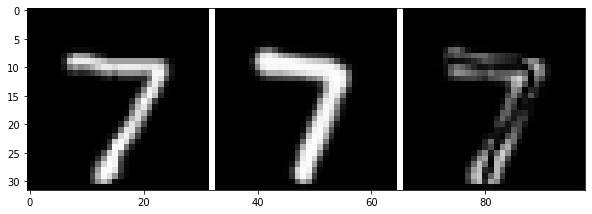

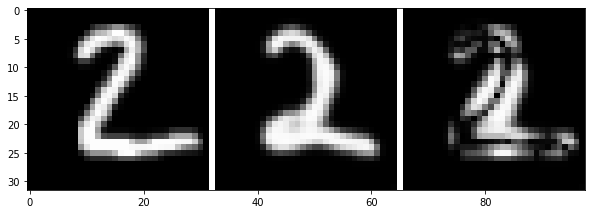

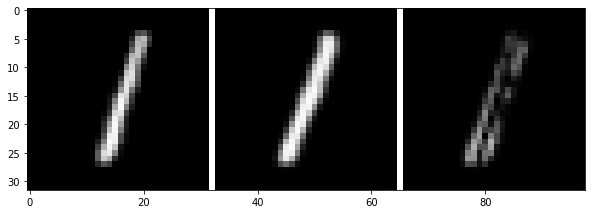

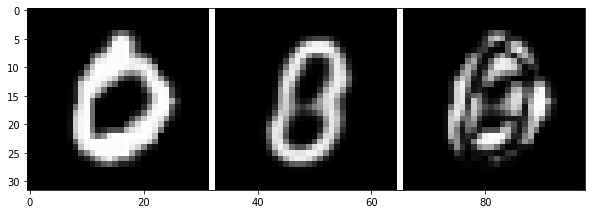

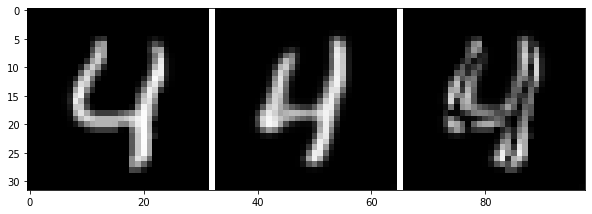

18/02/2020 20:42:36, epoch=86, step=10160, loss=0.28122, distortion=0.405, rate=0.025, -elbo=76.42976, nll=71.93595, KL=4.49381, commit_loss=50.87036, bit_usage=0.86270, highest_prob=0.023, temp=0.28467
reset code 24
pruned code 24 - 257 remain
18/02/2020 20:42:36, epoch=86, step=10180, loss=0.27970, distortion=0.403, rate=0.025, -elbo=75.93822, nll=71.54718, KL=4.39103, commit_loss=50.55602, bit_usage=0.87918, highest_prob=0.020, temp=0.28392
reset code 32
18/02/2020 20:42:37, epoch=86, step=10200, loss=0.27571, distortion=0.397, rate=0.025, -elbo=74.95515, nll=70.52749, KL=4.42766, commit_loss=50.31532, bit_usage=0.87245, highest_prob=0.021, temp=0.28317
reset code 64
pruned code 64 - 256 remain
18/02/2020 20:42:38, epoch=86, step=10220, loss=0.27717, distortion=0.400, rate=0.025, -elbo=75.33566, nll=70.90089, KL=4.43477, commit_loss=50.28380, bit_usage=0.86676, highest_prob=0.023, temp=0.28241
reset code 64
18/02/2020 20:42:38, epoch=86, step=10240, loss=0.27672, distortion=0.399, r

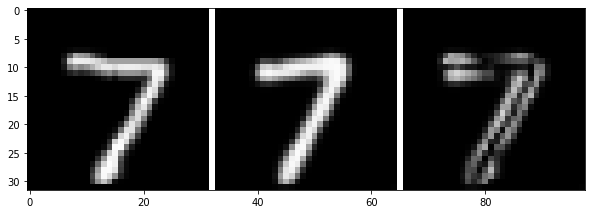

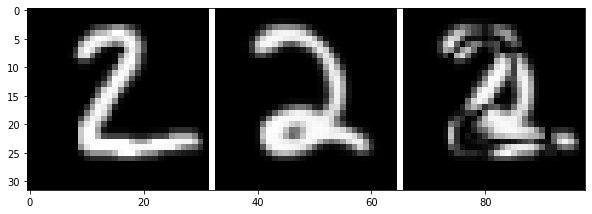

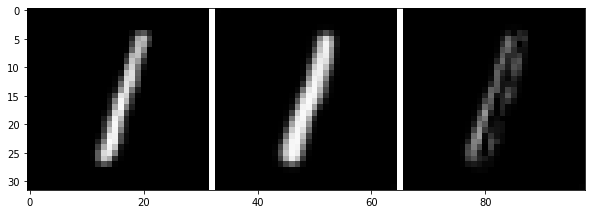

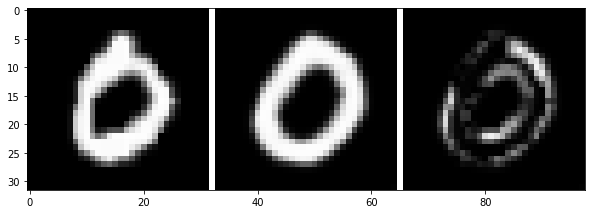

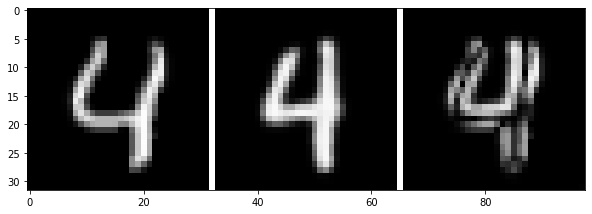

18/02/2020 20:42:56, epoch=91, step=10740, loss=0.27427, distortion=0.395, rate=0.025, -elbo=74.59363, nll=70.15829, KL=4.43533, commit_loss=50.99994, bit_usage=0.89291, highest_prob=0.016, temp=0.26285
reset code 26
18/02/2020 20:42:56, epoch=91, step=10760, loss=0.27184, distortion=0.392, rate=0.025, -elbo=73.94875, nll=69.53616, KL=4.41259, commit_loss=51.32017, bit_usage=0.89277, highest_prob=0.020, temp=0.26209
reset code 90
18/02/2020 20:42:57, epoch=91, step=10780, loss=0.26814, distortion=0.387, rate=0.025, -elbo=73.00466, nll=68.58815, KL=4.41651, commit_loss=50.94010, bit_usage=0.89220, highest_prob=0.018, temp=0.26134
reset code 106
18/02/2020 20:42:58, epoch=91, step=10800, loss=0.26825, distortion=0.387, rate=0.025, -elbo=73.05706, nll=68.61697, KL=4.44009, commit_loss=51.27477, bit_usage=0.89049, highest_prob=0.021, temp=0.26059
reset code 154
18/02/2020 20:42:58, epoch=91, step=10820, loss=0.27377, distortion=0.395, rate=0.025, -elbo=74.47248, nll=70.02872, KL=4.44376, c

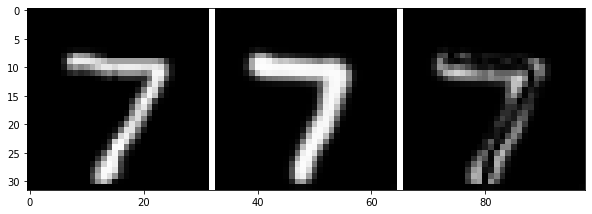

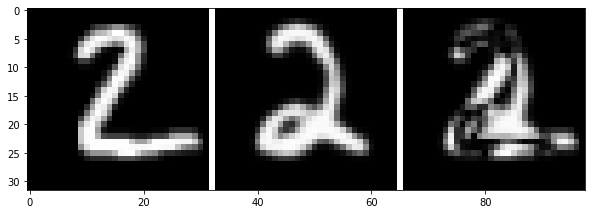

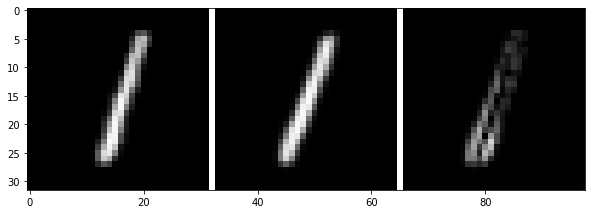

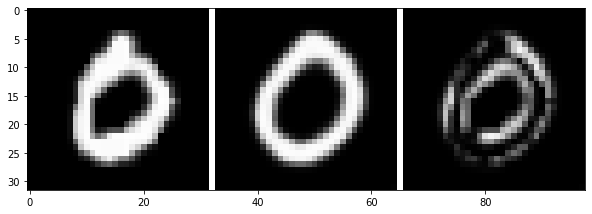

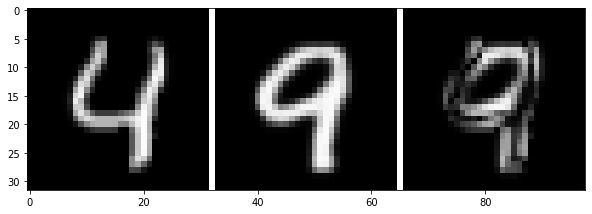

18/02/2020 20:43:15, epoch=96, step=11340, loss=0.26844, distortion=0.387, rate=0.025, -elbo=73.18369, nll=68.66393, KL=4.51976, commit_loss=51.81667, bit_usage=0.91039, highest_prob=0.016, temp=0.24027
reset code 217
18/02/2020 20:43:16, epoch=96, step=11360, loss=0.27103, distortion=0.391, rate=0.025, -elbo=73.77999, nll=69.32635, KL=4.45364, commit_loss=51.70724, bit_usage=0.89105, highest_prob=0.021, temp=0.23952
reset code 92
18/02/2020 20:43:16, epoch=96, step=11380, loss=0.27327, distortion=0.394, rate=0.025, -elbo=74.37788, nll=69.90070, KL=4.47718, commit_loss=51.18818, bit_usage=0.89378, highest_prob=0.020, temp=0.23877
reset code 201
18/02/2020 20:43:17, epoch=96, step=11400, loss=0.27410, distortion=0.395, rate=0.025, -elbo=74.60105, nll=70.11472, KL=4.48633, commit_loss=51.17241, bit_usage=0.89626, highest_prob=0.014, temp=0.23801
reset code 233
18/02/2020 20:43:17, epoch=96, step=11420, loss=0.26608, distortion=0.384, rate=0.025, -elbo=72.52234, nll=68.06026, KL=4.46208, 

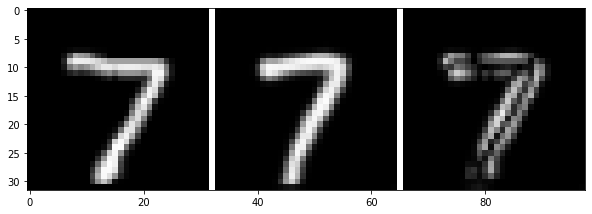

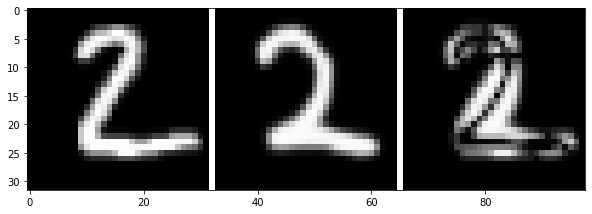

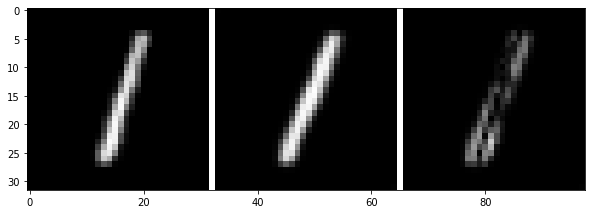

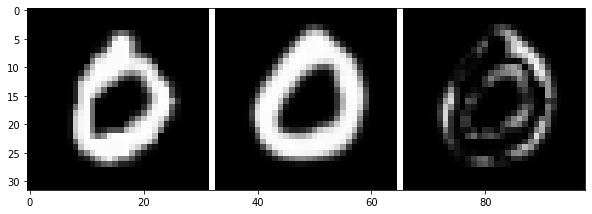

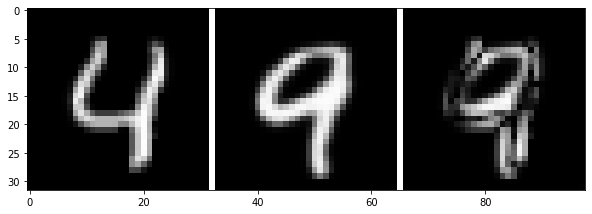

18/02/2020 20:43:33, epoch=101, step=11920, loss=0.26875, distortion=0.387, rate=0.025, -elbo=73.21546, nll=68.74300, KL=4.47247, commit_loss=51.43737, bit_usage=0.90411, highest_prob=0.018, temp=0.21845
reset code 227
18/02/2020 20:43:34, epoch=101, step=11940, loss=0.27467, distortion=0.396, rate=0.025, -elbo=74.73033, nll=70.25977, KL=4.47057, commit_loss=51.07824, bit_usage=0.91268, highest_prob=0.020, temp=0.21769
reset code 157
18/02/2020 20:43:35, epoch=101, step=11960, loss=0.26945, distortion=0.388, rate=0.025, -elbo=73.39349, nll=68.92257, KL=4.47093, commit_loss=51.56897, bit_usage=0.91613, highest_prob=0.016, temp=0.21694
reset code 11
18/02/2020 20:43:35, epoch=101, step=11980, loss=0.27231, distortion=0.393, rate=0.025, -elbo=74.13923, nll=69.65491, KL=4.48431, commit_loss=51.11349, bit_usage=0.91731, highest_prob=0.016, temp=0.21619
reset code 219
18/02/2020 20:43:36, epoch=101, step=12000, loss=0.26189, distortion=0.378, rate=0.025, -elbo=71.46657, nll=66.98701, KL=4.47

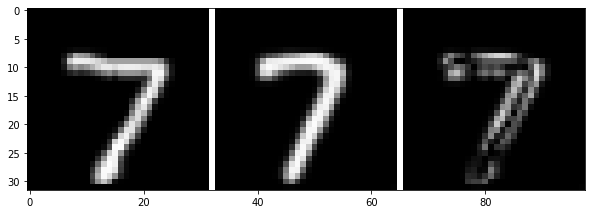

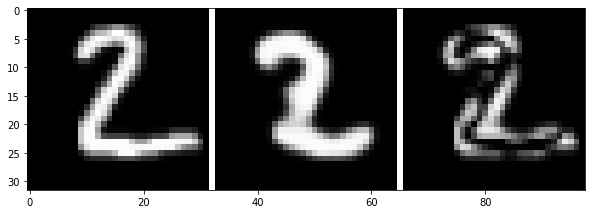

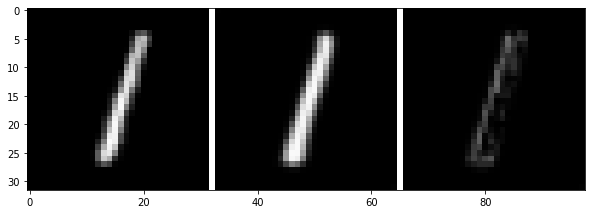

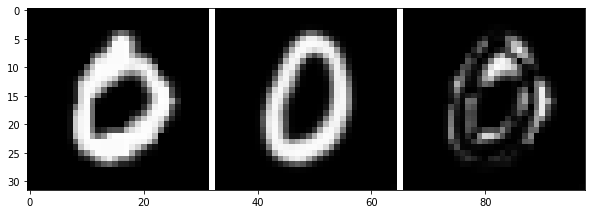

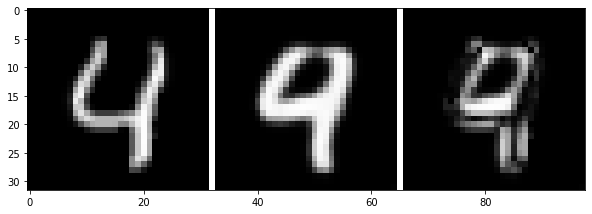

18/02/2020 20:43:53, epoch=106, step=12520, loss=0.26650, distortion=0.384, rate=0.025, -elbo=72.65595, nll=68.16866, KL=4.48729, commit_loss=51.08382, bit_usage=0.92927, highest_prob=0.014, temp=0.19587
reset code 64
18/02/2020 20:43:54, epoch=106, step=12540, loss=0.25971, distortion=0.374, rate=0.025, -elbo=70.92115, nll=66.42970, KL=4.49145, commit_loss=51.41363, bit_usage=0.93290, highest_prob=0.016, temp=0.19512
reset code 233
18/02/2020 20:43:54, epoch=106, step=12560, loss=0.25825, distortion=0.372, rate=0.025, -elbo=70.54867, nll=66.05697, KL=4.49170, commit_loss=51.49944, bit_usage=0.92794, highest_prob=0.016, temp=0.19437
reset code 58
18/02/2020 20:43:55, epoch=106, step=12580, loss=0.26313, distortion=0.379, rate=0.025, -elbo=71.80577, nll=67.30540, KL=4.50036, commit_loss=50.96146, bit_usage=0.92348, highest_prob=0.016, temp=0.19361
reset code 156
18/02/2020 20:43:55, epoch=106, step=12600, loss=0.25979, distortion=0.374, rate=0.025, -elbo=70.97227, nll=66.45177, KL=4.520

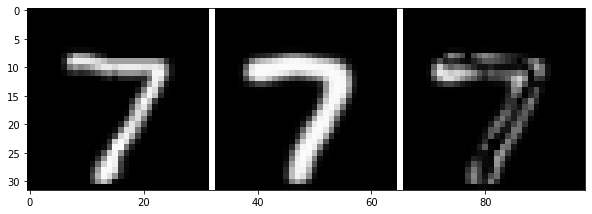

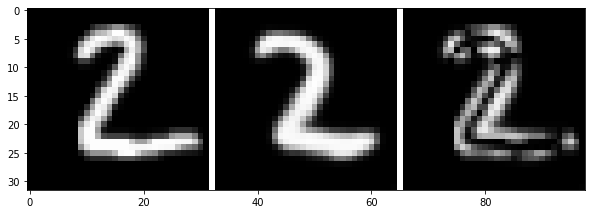

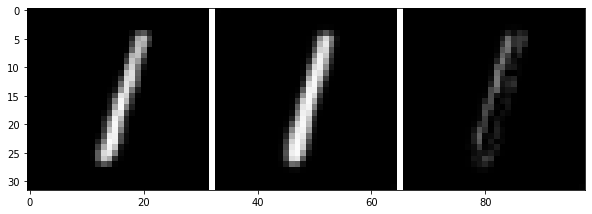

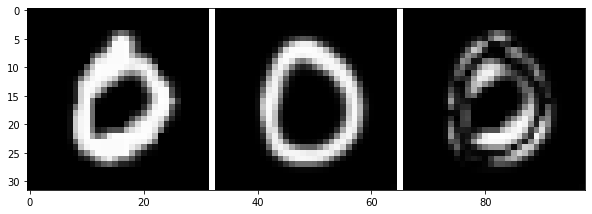

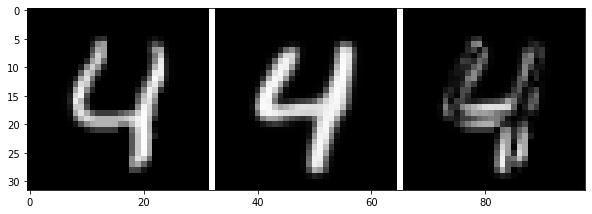

18/02/2020 20:44:10, epoch=111, step=13100, loss=0.26202, distortion=0.378, rate=0.026, -elbo=71.55033, nll=67.02238, KL=4.52795, commit_loss=50.61780, bit_usage=0.92995, highest_prob=0.014, temp=0.17405
18/02/2020 20:44:10, epoch=111, step=13120, loss=0.25849, distortion=0.373, rate=0.025, -elbo=70.63993, nll=66.11697, KL=4.52295, commit_loss=51.00304, bit_usage=0.92481, highest_prob=0.014, temp=0.17329
reset code 177
18/02/2020 20:44:11, epoch=111, step=13140, loss=0.25680, distortion=0.370, rate=0.026, -elbo=70.23721, nll=65.68483, KL=4.55238, commit_loss=50.86493, bit_usage=0.92646, highest_prob=0.016, temp=0.17254
18/02/2020 20:44:11, epoch=111, step=13160, loss=0.25569, distortion=0.369, rate=0.026, -elbo=69.94132, nll=65.40007, KL=4.54125, commit_loss=51.00069, bit_usage=0.93033, highest_prob=0.018, temp=0.17179
reset code 104
18/02/2020 20:44:12, epoch=111, step=13180, loss=0.26215, distortion=0.378, rate=0.025, -elbo=71.56194, nll=67.05611, KL=4.50583, commit_loss=50.88865, bi

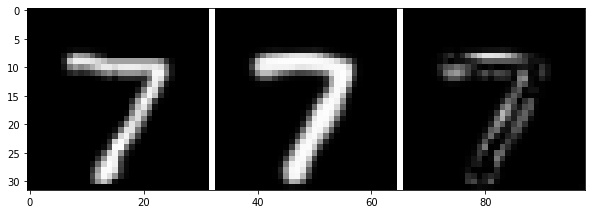

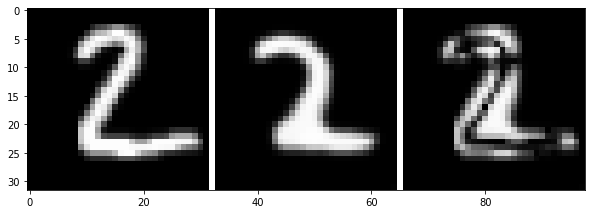

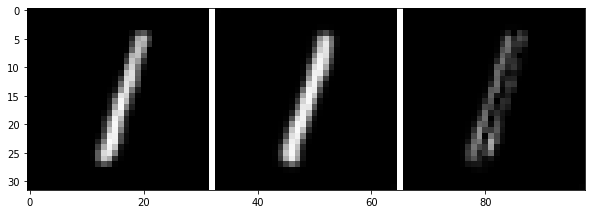

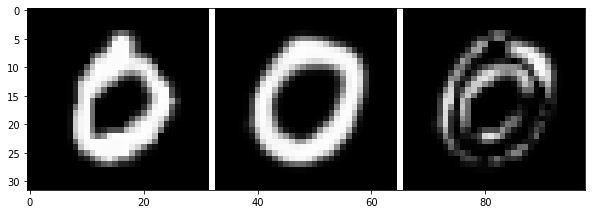

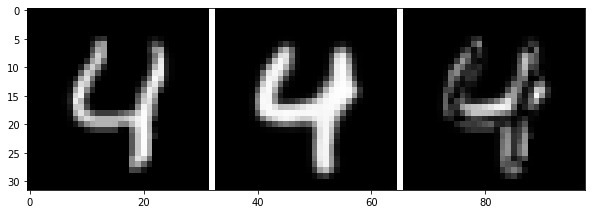

18/02/2020 20:44:28, epoch=116, step=13700, loss=0.26088, distortion=0.376, rate=0.026, -elbo=71.31886, nll=66.73014, KL=4.58872, commit_loss=50.10387, bit_usage=0.93205, highest_prob=0.016, temp=0.15147
reset code 188
18/02/2020 20:44:28, epoch=116, step=13720, loss=0.26002, distortion=0.375, rate=0.026, -elbo=71.12535, nll=66.51115, KL=4.61421, commit_loss=50.31911, bit_usage=0.93451, highest_prob=0.014, temp=0.15072
18/02/2020 20:44:29, epoch=116, step=13740, loss=0.25603, distortion=0.369, rate=0.026, -elbo=70.06463, nll=65.48758, KL=4.57705, commit_loss=50.83616, bit_usage=0.92444, highest_prob=0.020, temp=0.14997
18/02/2020 20:44:30, epoch=116, step=13760, loss=0.25344, distortion=0.365, rate=0.026, -elbo=69.44038, nll=64.82693, KL=4.61345, commit_loss=50.17408, bit_usage=0.93674, highest_prob=0.016, temp=0.14921
18/02/2020 20:44:30, epoch=116, step=13780, loss=0.26201, distortion=0.378, rate=0.026, -elbo=71.60370, nll=67.02085, KL=4.58285, commit_loss=50.39567, bit_usage=0.93353

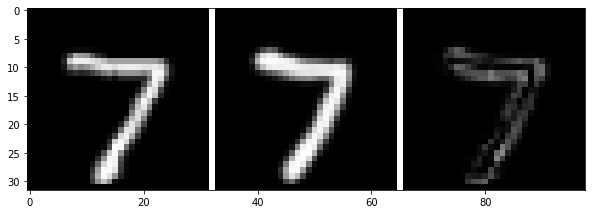

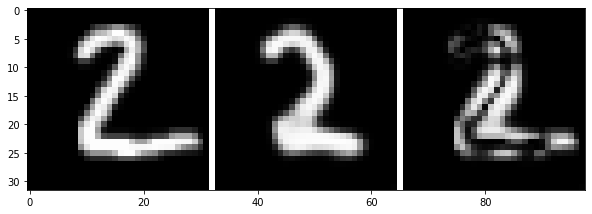

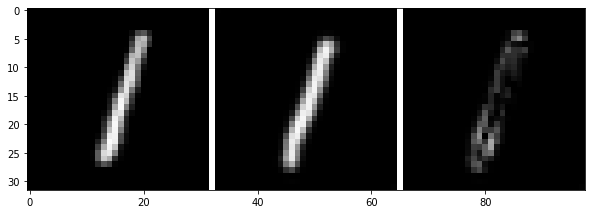

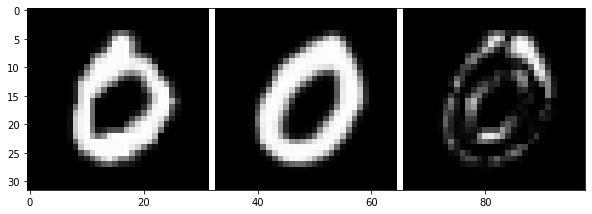

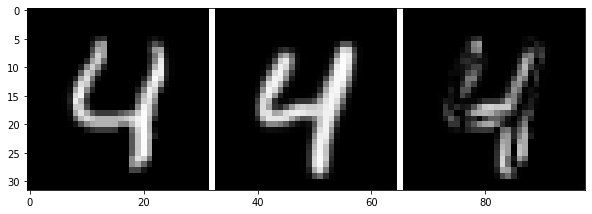

18/02/2020 20:44:47, epoch=121, step=14280, loss=0.25300, distortion=0.365, rate=0.026, -elbo=69.36110, nll=64.71319, KL=4.64791, commit_loss=50.50660, bit_usage=0.92759, highest_prob=0.020, temp=0.12965
18/02/2020 20:44:48, epoch=121, step=14300, loss=0.25883, distortion=0.373, rate=0.026, -elbo=70.86659, nll=66.20404, KL=4.66255, commit_loss=50.96485, bit_usage=0.92344, highest_prob=0.025, temp=0.12889
18/02/2020 20:44:48, epoch=121, step=14320, loss=0.25539, distortion=0.368, rate=0.026, -elbo=69.93252, nll=65.32599, KL=4.60653, commit_loss=50.52230, bit_usage=0.94062, highest_prob=0.014, temp=0.12814
reset code 242
18/02/2020 20:44:49, epoch=121, step=14340, loss=0.25450, distortion=0.367, rate=0.026, -elbo=69.74683, nll=65.09750, KL=4.64932, commit_loss=50.81887, bit_usage=0.93310, highest_prob=0.014, temp=0.12739
18/02/2020 20:44:49, epoch=121, step=14360, loss=0.25654, distortion=0.370, rate=0.026, -elbo=70.26936, nll=65.61884, KL=4.65052, commit_loss=50.37383, bit_usage=0.93554

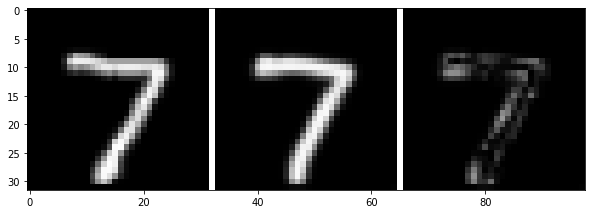

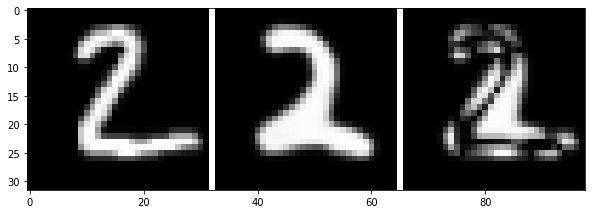

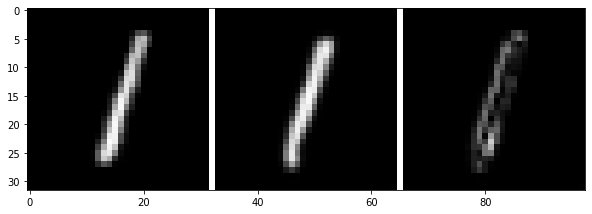

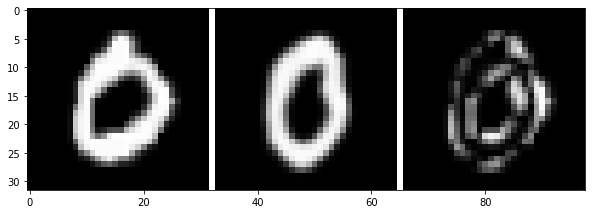

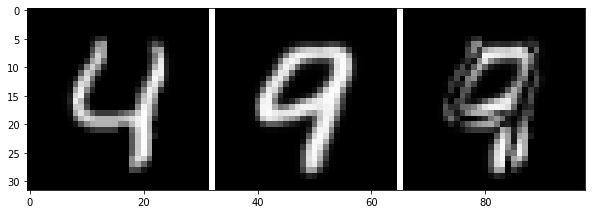

18/02/2020 20:45:07, epoch=126, step=14880, loss=0.24878, distortion=0.359, rate=0.026, -elbo=68.29428, nll=63.63083, KL=4.66346, commit_loss=50.94088, bit_usage=0.93864, highest_prob=0.018, temp=0.10707
18/02/2020 20:45:08, epoch=126, step=14900, loss=0.25665, distortion=0.370, rate=0.026, -elbo=70.29693, nll=65.64825, KL=4.64867, commit_loss=50.59771, bit_usage=0.93152, highest_prob=0.021, temp=0.10632
18/02/2020 20:45:08, epoch=126, step=14920, loss=0.25179, distortion=0.363, rate=0.026, -elbo=69.08918, nll=64.40318, KL=4.68601, commit_loss=50.49779, bit_usage=0.93538, highest_prob=0.014, temp=0.10557
reset code 171
18/02/2020 20:45:09, epoch=126, step=14940, loss=0.26194, distortion=0.378, rate=0.026, -elbo=71.64780, nll=67.00227, KL=4.64552, commit_loss=50.58603, bit_usage=0.93315, highest_prob=0.016, temp=0.10481
18/02/2020 20:45:09, epoch=126, step=14960, loss=0.25681, distortion=0.370, rate=0.026, -elbo=70.36485, nll=65.68823, KL=4.67662, commit_loss=50.88853, bit_usage=0.92360

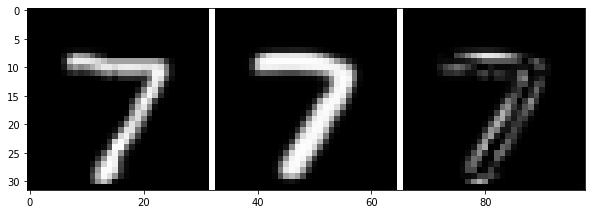

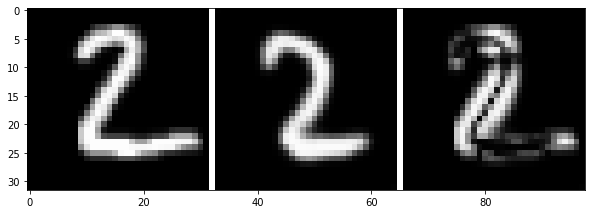

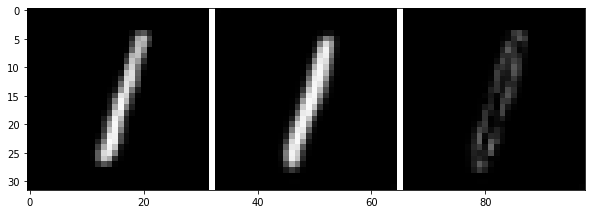

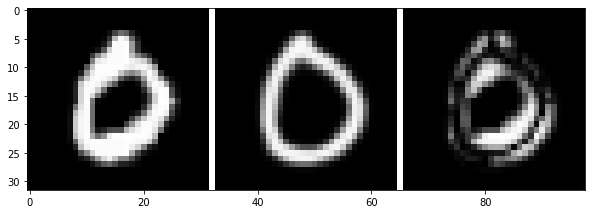

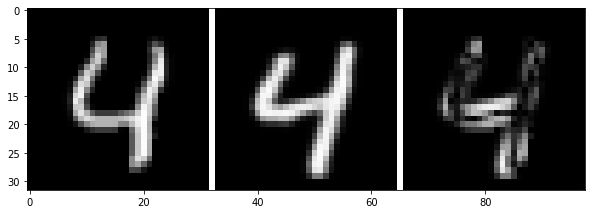

18/02/2020 20:45:26, epoch=131, step=15460, loss=0.24909, distortion=0.359, rate=0.027, -elbo=68.41966, nll=63.71204, KL=4.70762, commit_loss=50.63756, bit_usage=0.93490, highest_prob=0.014, temp=0.08525
18/02/2020 20:45:26, epoch=131, step=15480, loss=0.25113, distortion=0.362, rate=0.026, -elbo=68.91290, nll=64.23270, KL=4.68020, commit_loss=50.73556, bit_usage=0.92639, highest_prob=0.016, temp=0.08449
reset code 104
18/02/2020 20:45:27, epoch=131, step=15500, loss=0.25924, distortion=0.374, rate=0.027, -elbo=71.01765, nll=66.31001, KL=4.70763, commit_loss=50.82325, bit_usage=0.93261, highest_prob=0.018, temp=0.08374
18/02/2020 20:45:28, epoch=131, step=15520, loss=0.25368, distortion=0.366, rate=0.027, -elbo=69.62078, nll=64.88795, KL=4.73282, commit_loss=50.56137, bit_usage=0.92629, highest_prob=0.016, temp=0.08299
reset code 142
18/02/2020 20:45:28, epoch=131, step=15540, loss=0.25262, distortion=0.364, rate=0.027, -elbo=69.32088, nll=64.61472, KL=4.70616, commit_loss=50.64136, bi

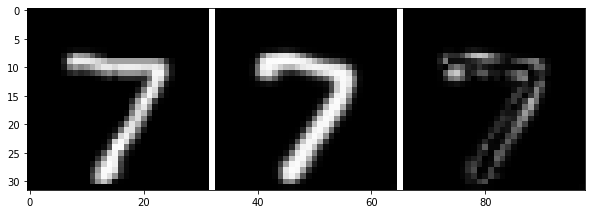

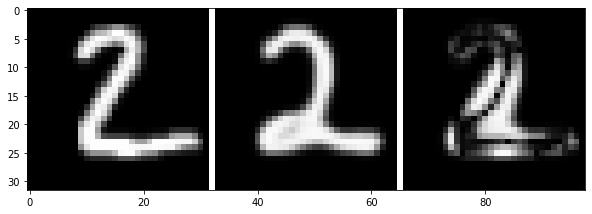

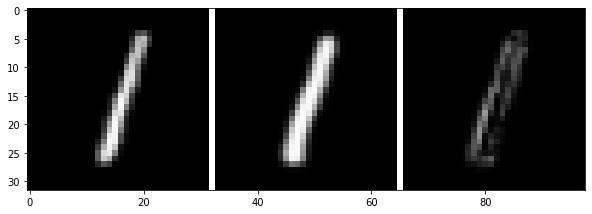

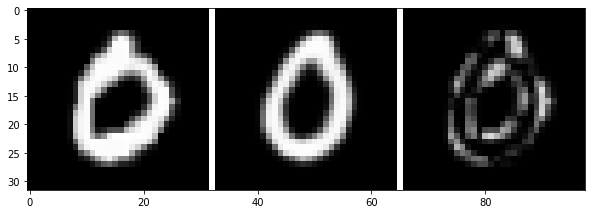

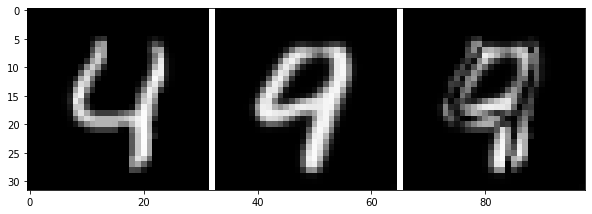

18/02/2020 20:45:45, epoch=136, step=16060, loss=0.25280, distortion=0.364, rate=0.026, -elbo=69.33012, nll=64.66096, KL=4.66917, commit_loss=50.40301, bit_usage=0.94337, highest_prob=0.016, temp=0.06267
18/02/2020 20:45:45, epoch=136, step=16080, loss=0.24706, distortion=0.356, rate=0.026, -elbo=67.87534, nll=63.19305, KL=4.68229, commit_loss=50.84391, bit_usage=0.94202, highest_prob=0.014, temp=0.06192
18/02/2020 20:45:46, epoch=136, step=16100, loss=0.25230, distortion=0.364, rate=0.026, -elbo=69.21654, nll=64.53438, KL=4.68216, commit_loss=50.61217, bit_usage=0.93892, highest_prob=0.016, temp=0.06117
reset code 48
18/02/2020 20:45:46, epoch=136, step=16120, loss=0.24521, distortion=0.353, rate=0.027, -elbo=67.43923, nll=62.71750, KL=4.72173, commit_loss=50.91715, bit_usage=0.93550, highest_prob=0.016, temp=0.06041
18/02/2020 20:45:47, epoch=136, step=16140, loss=0.25943, distortion=0.374, rate=0.026, -elbo=71.02396, nll=66.35910, KL=4.66485, commit_loss=50.98336, bit_usage=0.94093,

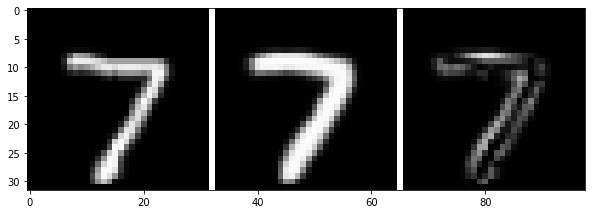

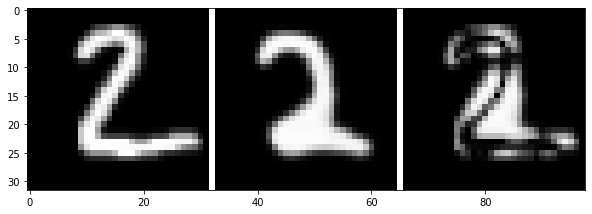

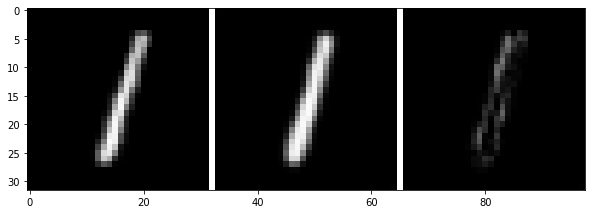

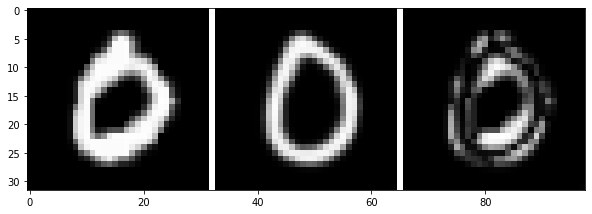

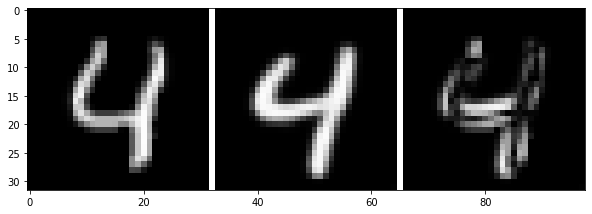

18/02/2020 20:46:04, epoch=141, step=16640, loss=0.25323, distortion=0.365, rate=0.027, -elbo=69.48215, nll=64.77189, KL=4.71027, commit_loss=50.51423, bit_usage=0.93818, highest_prob=0.014, temp=0.04085
18/02/2020 20:46:04, epoch=141, step=16660, loss=0.25584, distortion=0.369, rate=0.026, -elbo=70.10820, nll=65.43962, KL=4.66858, commit_loss=50.63258, bit_usage=0.93437, highest_prob=0.018, temp=0.04009
18/02/2020 20:46:05, epoch=141, step=16680, loss=0.25565, distortion=0.369, rate=0.027, -elbo=70.12058, nll=65.39186, KL=4.72872, commit_loss=50.72863, bit_usage=0.93846, highest_prob=0.018, temp=0.03934
18/02/2020 20:46:05, epoch=141, step=16700, loss=0.24708, distortion=0.356, rate=0.026, -elbo=67.88463, nll=63.19822, KL=4.68641, commit_loss=50.80322, bit_usage=0.93155, highest_prob=0.018, temp=0.03859
18/02/2020 20:46:06, epoch=141, step=16720, loss=0.25445, distortion=0.367, rate=0.026, -elbo=69.78123, nll=65.08481, KL=4.69643, commit_loss=50.81196, bit_usage=0.93853, highest_prob=

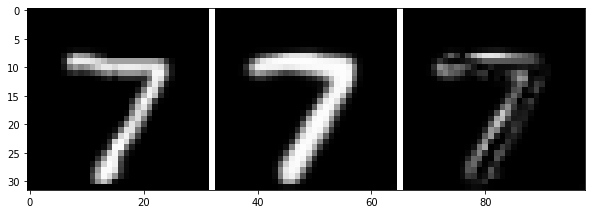

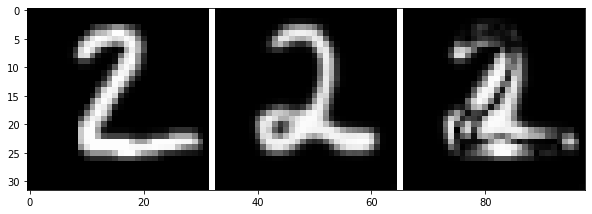

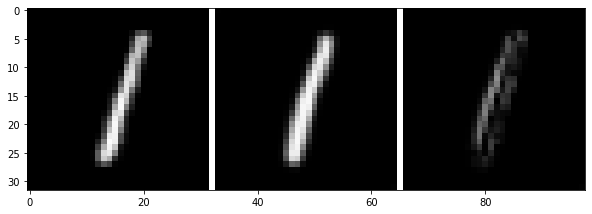

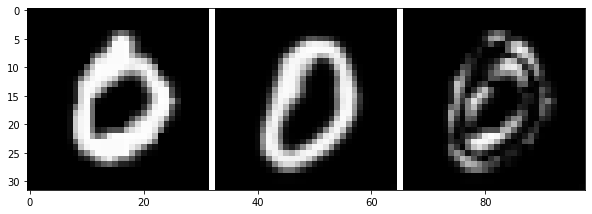

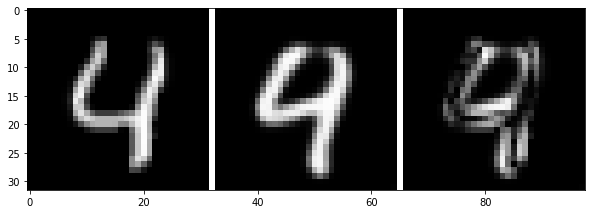

18/02/2020 20:46:23, epoch=146, step=17240, loss=0.25659, distortion=0.370, rate=0.026, -elbo=70.31963, nll=65.63239, KL=4.68725, commit_loss=50.78374, bit_usage=0.93951, highest_prob=0.016, temp=0.01827
18/02/2020 20:46:24, epoch=146, step=17260, loss=0.25611, distortion=0.369, rate=0.026, -elbo=70.20325, nll=65.50786, KL=4.69539, commit_loss=50.40237, bit_usage=0.93400, highest_prob=0.016, temp=0.01752
18/02/2020 20:46:24, epoch=146, step=17280, loss=0.25122, distortion=0.362, rate=0.026, -elbo=68.95869, nll=64.25729, KL=4.70140, commit_loss=50.85678, bit_usage=0.93983, highest_prob=0.014, temp=0.01677
18/02/2020 20:46:25, epoch=146, step=17300, loss=0.24258, distortion=0.350, rate=0.027, -elbo=66.76069, nll=62.04490, KL=4.71578, commit_loss=51.00623, bit_usage=0.93287, highest_prob=0.016, temp=0.01601
18/02/2020 20:46:26, epoch=146, step=17320, loss=0.25217, distortion=0.363, rate=0.026, -elbo=69.18013, nll=64.50078, KL=4.67935, commit_loss=51.04203, bit_usage=0.93529, highest_prob=

/home/willw/tmp/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type HQA. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/willw/tmp/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/willw/tmp/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/willw/tmp/hqa/venv_hqa/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " 

In [12]:
# Train a HQA stack
models_dir = f"{os.getcwd()}/models"
os.makedirs(models_dir, exist_ok=True)
hqa_model = train_full_stack(models_dir, "hqa_model", epochs=150)
#hqa_model = torch.load(f"{models_dir}/hqa_model.pt")

layer_names = ["Layer 0", "Layer 1", "Layer 2", "Layer 3", "Layer 4 - Final model"]
layer_descriptions = [
    "downsample 2 in each dimension, latent space size of 16x16",
    "downsample 4 in each dimension, latent space size of 8x8",
    "downsample 8 in each dimension, latent space size of 4x4",
    "downsample 16 in each dimension, latent space size of 2x2",
    "downsample 32 in each dimension, latent space size of 1x1",
]

### Reconstructions - layer-wise

Original images to be reconstructed


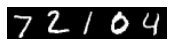

Layer 0: downsample 2 in each dimension, latent space size of 16x16


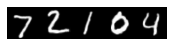

Layer 1: downsample 4 in each dimension, latent space size of 8x8


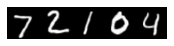

Layer 2: downsample 8 in each dimension, latent space size of 4x4


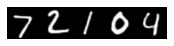

Layer 3: downsample 16 in each dimension, latent space size of 2x2


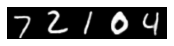

Layer 4 - Final model: downsample 32 in each dimension, latent space size of 1x1


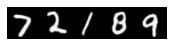

In [13]:
indexes= [i for i in range(len(hqa_model))]

images = []
for idx in indexes:
    (image, label) = ds_test[idx]    
    img = image.to(device).squeeze()
    images.append(img.cpu())

print("Original images to be reconstructed")
show_image(torch.cat(images, dim=1))

# Show reconstruction comparison over each layer in HQA
for layer_idx, name, description in zip(indexes, layer_names, layer_descriptions):
    results = []

    model = hqa_model[layer_idx]
    for idx in indexes:
        (image, label) = ds_test[idx]    
        img = image.to(device).squeeze()

        for_recon = img.unsqueeze(0).unsqueeze(0)
        model.eval()
        recon = model.reconstruct(for_recon).squeeze(0).squeeze(0)
        results.append(recon.cpu())

    print(f"{name}: {description}")
    res = torch.cat(results, dim=1) # h,w,c
    show_image(res)

### Reconstructions - final model 

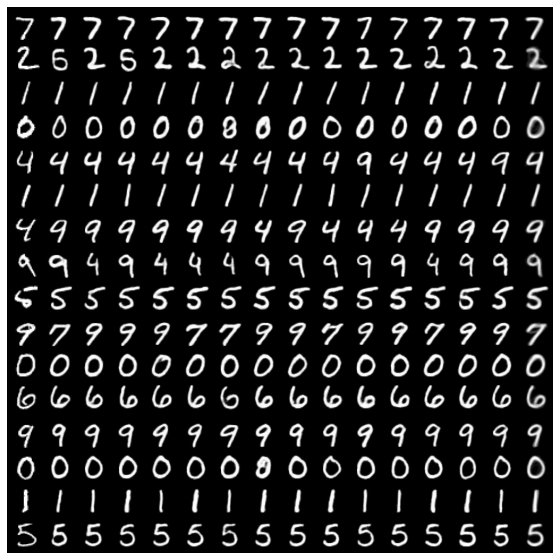

In [14]:
# Show held-out reconstructions: [ORIG, 14xSAMPLE, AVERAGED_10_SAMPLES]
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)

result_idx = 0
for test_idx in range(grid_y):
    x_a,_ = ds_test[test_idx]
    img = x_a.squeeze().to(device)
    img_ = img.unsqueeze(0).unsqueeze(0)
    model.eval()
    num_examples = 5
    
    # ORIG
    results[result_idx] = img
    result_idx += 1
    
    # 14 RANDOM STOCHASTIC DECODES
    for _ in range(grid_x -2):
        results[result_idx] = model.reconstruct(img_).squeeze()
        result_idx += 1
    
    # AVERAGED SAMPLES
    results[result_idx] = model.reconstruct_average(img_, num_samples=14).squeeze()
    result_idx += 1

grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Samples: enumerating over all 1x1 latents

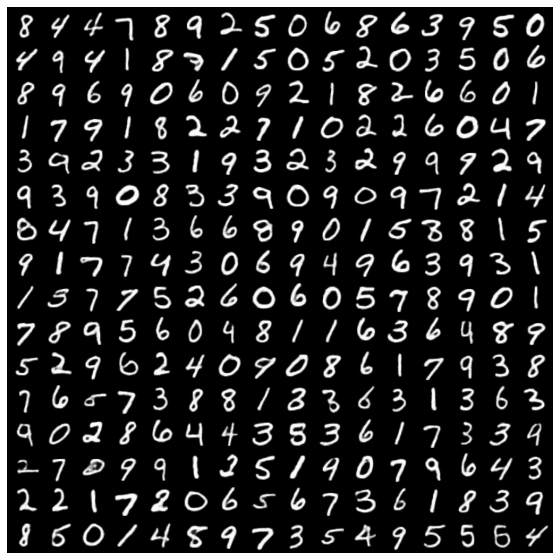

In [15]:
model = hqa_model.eval()
num_codes = model.codebook.codebook_slots
results = torch.Tensor(num_codes, 1, 32, 32).to(device)
count=0
for i in range(num_codes):
    codes = torch.LongTensor([i]).unsqueeze(0).unsqueeze(0).to(device)
    results[count] = model.reconstruct_from_codes(codes)
    count += 1
        
grid_img = make_grid(results.cpu(), nrow=16)
show_image(grid_img[0,:,:])

### Interpolations - layer-wise

Originals


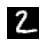

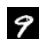

Layer 0 : downsample 2 in each dimension, latent space size of 16x16


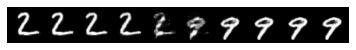

Layer 1 : downsample 4 in each dimension, latent space size of 8x8


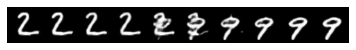

Layer 2 : downsample 8 in each dimension, latent space size of 4x4


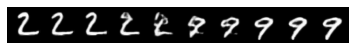

Layer 3 : downsample 16 in each dimension, latent space size of 2x2


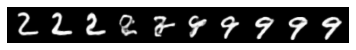

Layer 4 - Final model : downsample 32 in each dimension, latent space size of 1x1


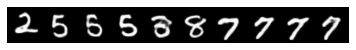

In [16]:
def set_figure_pixel_size (width, height, ppi):
    plt.figure(figsize=(width/float(ppi), height/float(ppi)), dpi=ppi)

def interpolate(a, b, vqvae, grid_x=16):
    images = []
    
    x_a,_ = ds_test[a]
    x_b,_ = ds_test[b]
    point_1 = vqvae.encode(x_a.unsqueeze(0).to(device))
    point_2 = vqvae.encode(x_b.unsqueeze(0).to(device))

    interpolate_x = np.linspace(point_1[0].cpu().numpy(), point_2[0].cpu().numpy(), grid_x)
    
    results = torch.Tensor(len(interpolate_x), 1, 32, 32)
    for i, z_e_interpolated in enumerate(interpolate_x):       
        z_e = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = vqvae.quantize(z_e)
        recon = vqvae.decode(z_q).squeeze() 
        results[i] = recon

    grid_img = make_grid(results.cpu(), nrow=grid_x)
    show_image(grid_img[0,:,:])

def show_original(idx):
    x, _ = ds_test[idx]
    image = x.squeeze()
    show_image(image)
    
print("Originals")
show_original(1)
show_original(9)
for layer, name, description in zip(hqa_model, layer_names, layer_descriptions):
    print(f"{name} : {description}")
    interpolate(1, 9, layer, grid_x=10)

### Interpolations - final model

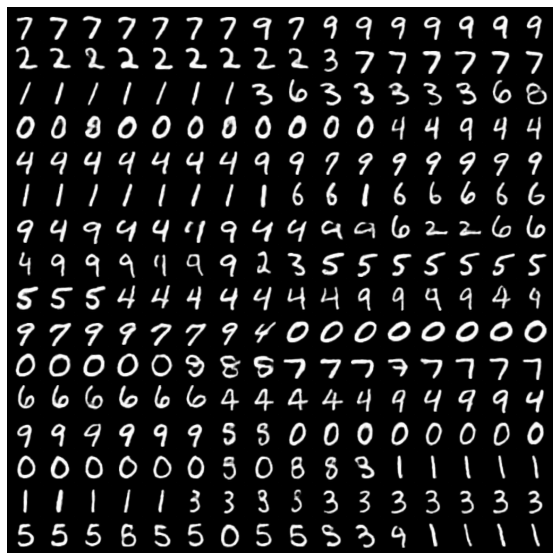

In [17]:
grid_x = grid_y = 16
results = torch.Tensor(grid_x * grid_y, 1, 32, 32)
i = 0
model = hqa_model

for j in range(grid_y):
    x_a,_ = ds_test[j]
    x_b,_ = ds_test[j+grid_y]
    point_1 = model.encode(x_a.unsqueeze(0).to(device)).cpu()
    point_2 = model.encode(x_b.unsqueeze(0).to(device)).cpu()
    interpolate_x = np.linspace(point_1[0], point_2[0], grid_x)

    for z_e_interpolated in interpolate_x:
        z_e_i = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = model.quantize(z_e_i)
        results[i] = model.decode(z_q).squeeze()
        i += 1
            
grid_img = make_grid(results.cpu(), nrow=grid_x)
show_image(grid_img[0,:,:])

### Distortions

In [18]:
def get_rate_upper_bound(model, example_input):
    assert len(example_input.shape) == 4, "Expected (1, num_channels, x_h, x_w)"
    assert example_input.shape[0] == 1, "Please provide example with batch_size=1"
    
    z_e = model.encode(example_input)
    _, top_indices, _, _ = model.codebook(z_e)
        
    # assume worst case scenario: we have a uniform usage of all our codes
    rate_bound = top_indices[0].numel() * np.log2(model.codebook.min_codebook_slots)

    return rate_bound

def test(model):
    model.eval()
    total_nll = []
    total_kl = []
    
    for x, _ in dl_test:
        img = x.to(device)       
        recon, orig, z_q, z_e, indices, kl, _ = model.forward_full_stack(img)       
        recon_loss = model[0].recon_loss(img, recon)        
        total_nll.append(recon_loss.item())
        if kl != 0:
            total_kl.append(kl.item())
        else:
            total_kl.append(kl)
    
    dims = np.prod(x.shape[1:])
    kl_mean = np.mean(total_kl)
    nll_mean = np.mean(total_nll)
    distortion_bpd = nll_mean / dims / np.log(2)
    rate_bpd = kl_mean / dims / np.log(2)
    elbo = -(nll_mean + kl_mean)
    
    rate_bound = get_rate_upper_bound(model, img[0].unsqueeze(0))
    
    return distortion_bpd, rate_bound


def get_rd_data(model):
    dist = []
    rates = []
    
    for i, _ in enumerate(model):
        d, r = test(model[i])
        dist.append(float(d))
        rates.append(float(r))
    
    return dist, rates

In [19]:
# Layer distortions
distortions, rates = get_rd_data(hqa_model)
print("Name \t\t Distortion \t Rate")
for dist, rate, name in zip(distortions, rates, layer_names):
    print(f"{name} \t {dist:.4f} \t {int(rate)}")

Name 		 Distortion 	 Rate
Layer 0 	 0.0010 	 2048
Layer 1 	 0.0022 	 512
Layer 2 	 0.0066 	 128
Layer 3 	 0.0222 	 32
Layer 4 - Final model 	 0.0631 	 8


# Paper figures

### Layerwise interpolations

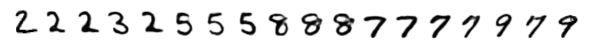

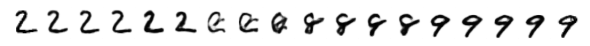

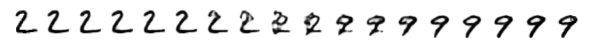

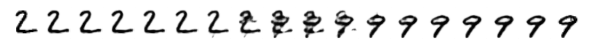

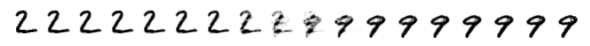

In [20]:
# Table 5
def interpolate2(x_a, x_b, vqstack, system_type, grid_x=16):
    images = []
    images.append(1 - x_a.squeeze().cpu())
    
    if system_type == "normal":
        point_1 = vqstack.encode(x_a.unsqueeze(0).to(device))
        point_2 = vqstack.encode(x_b.unsqueeze(0).to(device))
    elif system_type == "hams":
        point_1, _ = vqstack.encode_ze(x_a.unsqueeze(0).to(device))
        point_2, _ = vqstack.encode_ze(x_b.unsqueeze(0).to(device))
    interpolate_x = np.linspace(point_1[0].cpu().numpy(), point_2[0].cpu().numpy(), grid_x)
    latents = []
    for i, z_e_interpolated in enumerate(interpolate_x):
        z_e = torch.Tensor(z_e_interpolated).unsqueeze(0).to(device)
        z_q = vqstack.quantize(z_e)
        recon = vqstack.decode(z_q).squeeze() 
        images.append(1 - recon.cpu())
    
    images.append(1 - x_b.squeeze().cpu())
    res = torch.cat(images, dim=1) # h,w,c
    show_image(res)

x_a,_ = ds_test[1]
x_b,_ = ds_test[9]
models = [hqa_model, hqa_model.prev_model, hqa_model.prev_model.prev_model, hqa_model.prev_model.prev_model.prev_model, hqa_model.prev_model.prev_model.prev_model.prev_model]
for m in models:
    interpolate2(x_a, x_b, m, "normal")

### Layerwise reconstructions

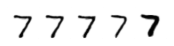

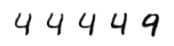

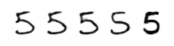

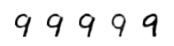

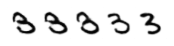

In [21]:
# Table 3
def recon_comparison(models, total_recons=5, system_type="normal"):
    
    for idx in [0,4,15,16,18]:
        result = []
        (image, label) = ds_test[idx]    
        img = image.to(device).squeeze()
        for_recon = img.unsqueeze(0).unsqueeze(0)
        if system_type == "normal":
            for model in models:
                model.eval()
                recon = model.reconstruct(for_recon).squeeze()
                result.append(1 - recon.cpu())
        elif system_type == "greedy":
            for model_list in models:
                x = for_recon
                for i, model in enumerate(model_list):
                    x = model.encode(x)
                for j in torch.arange(i, -1, -1):
                    x = model_list[j].quantize(x)
                    x = model_list[j].decode(x)
                recon = x.squeeze()
                result.append(1 - recon.cpu())
        show_image(torch.cat(result, dim=1))

recon_comparison([hqa_model[i] for i in range(len(hqa_model))])
